goals
1. port to jax and do first and second order MD 
2. redo Kohn Sham regularizer in 3d 
3. circumvent eigendecomposition using neural network 
4. port to IPU

TODO:

1. make github jax scf, invite OGB people. 

2. check alexm has access


- allan, patrick, amelia, sam+sam.


.  lines of improvement:
      # 1. If things doesn't change we can compute it once and re-use it "num_iterations" times. This is hard to see if it's all split over multiple files. 
      # 2. Most for loops etc can be made into a single matmul or batched matmul. 
      # 3. No need to write things to disc, we have soo much RAM today. 
      # 4. Compile to jax. 
      # 5. less lines of code means we can see things and understand what is going on. 
      # 6. instead of initializing empty numpy array and then writing to it (usually with for loops), we can just have computation in one line and store directly.


known bugs
- $N_3$ pyscf/us/pcq all disagree [2.0, 2.4]; disagreement to pyscf starts, surprisingly, from first refactor. (this molecule is different because num_electrons is odd!)

In [1]:
!pip install pyscf

In [4]:
!source /nethome/alexm/poplar_sdk-ubuntu_20_04-3.1.0+1205-58b501c780/enable

In [1]:
import jax

ImportError: libgcl.so: cannot open shared object file: No such file or directory

In [2]:
!ls *.pkl

pcq.pkl


In [3]:
import os 
if not os.path.exists("pcq.pkl"):
  !gdown 1iwll9zMuzEeFi-FEbVEUSWsn_TzV0x0p

import pandas as pd 
if not "pcq" in locals(): # only read if not exists  ;; save test cases version 
  print("trying to load pcq.pkl")
  pcq = pd.read_pickle("pcq.pkl") # units: [u], [eV], [angstrom]
#pcq[["atom_string", "hlgap"]][:100]
#pcq[["atom_string", "hlgap"]][:100]
pcq[:5]
hlunique = pcq[~pcq["hlgap"].duplicated()]
hlunique[["atom_string", "hlgap"]]

In [7]:
import os
os.environ["OMP_NUM_THREADS"] = "30"

In [9]:
import numpy as np 
a = np.random.normal(0,1, (1000, 1000))

while True: 
  a = a @ a 

/tmp/ipykernel_194193/105102873.py:5: RuntimeWarning: overflow encountered in matmul
  a = a @ a
/tmp/ipykernel_194193/105102873.py:5: RuntimeWarning: invalid value encountered in matmul
  a = a @ a


KeyboardInterrupt: 

(87782, 11) (139922, 11) (199486, 11)


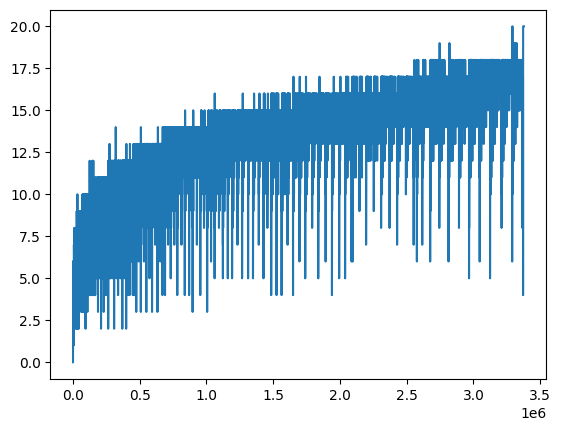

In [ ]:
#write 4/8/2023
atoms = pcq["num_atoms"] - pcq["num_hs"]
import matplotlib.pyplot as plt

plt.plot(atoms.values) # fetch gdb9 from this 

gdb9  = pcq[atoms == 9] # 87k that's pretty neat! 
gdb10 = pcq[atoms == 10] # 87k that's pretty neat! 
gdb11 = pcq[atoms == 11] # 87k that's pretty neat! 

print(gdb9.shape, gdb10.shape, gdb11.shape)

In [ ]:
!gdown 1iwll9zMuzEeFi-FEbVEUSWsn_TzV0x0p
import pandas as pd 
pcq = pd.read_pickle("pcq.pkl")
benzene = pcq[pcq["atom_string"] == "CCCCCCHHHHHH"]
benzene.to_pickle("benzene.pkl")

Downloading...
From: https://drive.google.com/uc?id=1iwll9zMuzEeFi-FEbVEUSWsn_TzV0x0p
To: /content/pcq.pkl
100% 1.55G/1.55G [00:19<00:00, 78.8MB/s]


In [ ]:
benzene.shape

(45, 11)

In [ ]:
pcq

,sdf_id,num_atoms,weight,num_hs,atom_string,atom_string2,SMILES1,SMILES2,hlgap,atom_locations,atom_locations2
2880108,2880108,2,8.005207,2,HeHe,,[He].[He],,47.023995,"[[2.363, -0.2559, 0.0251], [-0.3801, 0.14, 0.0...",0.0
2912974,2912974,3,12.007810,3,HeHeHe,,[He].[He].[He],,46.381806,"[[2.404, 0.9434, 0.0776], [0.828, -1.221, 1.07...",0.0
1773339,1773339,2,12.017130,1,BH,,[H][B],[BH],2.525217,"[[0.898, 0.0379, -0.0723], [2.094, 0.0379, -0....",0.0
3254373,3254373,2,12.017130,1,BH,,[H][B],[BH],2.525217,"[[0.9375, -0.0886, -0.0425], [2.133, -0.0886, ...",0.0
1773342,1773342,2,15.010899,1,NH,,[H][N],[NH],11.407013,"[[1.032, -0.0666, -0.0582], [2.08, -0.0666, -0...",0.0
...,...,...,...,...,...,...,...,...,...,...,...
1491627,1491627,46,278.199428,26,CCCCCCCCCCCCCCCCNNOOHHHHHHHHHHHHHHHHHHHHHHHHHH,,[H]OC([H])([H])C([H])([H])N(C(=O)C1(C#N)C([H])...,N#CC1(C(=O)N(CCO)C2CCCCC2)CCCCC1,6.658626,"[[-0.654, 2.24, -1.352], [2.514, -3.861, 3.47]...",0.0
1491562,1491562,46,278.199428,26,CCCCCCCCCCCCCCCCNNOOHHHHHHHHHHHHHHHHHHHHHHHHHH,,[H]O[C@@]([H])(C([H])([H])Oc1c([H])c([H])c(C([...,CCc1ccc(OC[C@H](O)CN[C@@H]2CCN(C)C2)cc1,5.804188,"[[1.43, -5.367, -4.504], [1.762, -5.496, 6.46]...",0.0
1491526,1491526,46,278.199428,26,CCCCCCCCCCCCCCCCNNOOHHHHHHHHHHHHHHHHHHHHHHHHHH,,[H]c1c([H])c([C@@]([H])(N([H])[C@@]2([H])C([H]...,COCc1cc([C@H](C)N[C@@H]2CCN(C)C2)ccc1OC,5.787862,"[[0.3345, -0.4524, 1.348], [4.22, 0.2267, -4.0...",0.0
1491510,1491510,46,278.199428,26,CCCCCCCCCCCCCCCCNNOOHHHHHHHHHHHHHHHHHHHHHHHHHH,,[H]O[C@@]([H])(C([H])([H])O[C@]([H])(c1c([H])c...,C[C@H](OC[C@H](O)CN[C@@H]1CCN(C)C1)c1ccccc1,5.591940,"[[5.836, 0.4873, 3.344], [0.5986, 0.2275, -5.5...",0.0


In [ ]:
#pcq[pcq["atom_string"] == "CCCCCCOOOOOOHHHHHHHHHHHH"]
benzene = pcq[pcq["atom_string"] == "CCCCCCHHHHHH"] # benzenes 
print(benzene.shape)
benzene

import pickle 
pickle.dump(benzene , open("benzene.pkl", "wb"))

(45, 11)


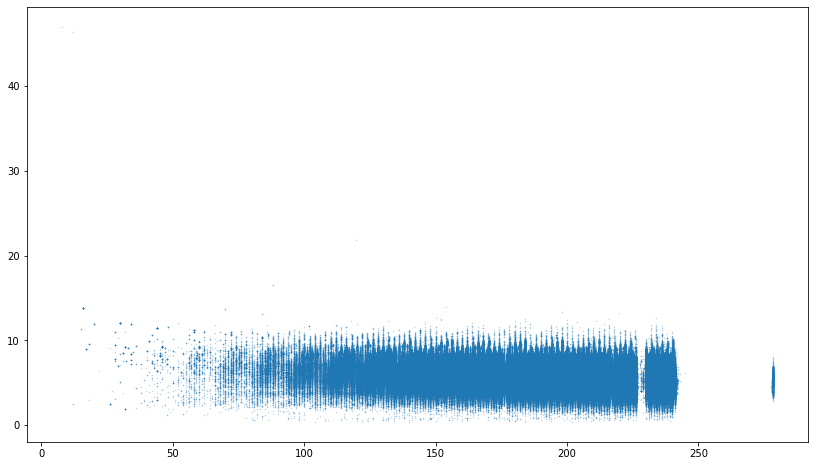

In [ ]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(1,1, figsize=(14, 8))
plt.plot(pcq["weight"], pcq["hlgap"],'.', alpha=0.3, ms=1)

In [1]:
2+2

4

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "30"

import os 
if not os.path.exists("pcq.pkl"):
  !gdown 1iwll9zMuzEeFi-FEbVEUSWsn_TzV0x0p

import pandas as pd 
if not "pcq" in locals(): # only read if not exists  ;; save test cases version 
  pcq = pd.read_pickle("pcq.pkl") # units: [u], [eV], [angstrom]
#pcq[["atom_string", "hlgap"]][:100]
#pcq[["atom_string", "hlgap"]][:100]
pcq[:5]
hlunique = pcq[~pcq["hlgap"].duplicated()]
hlunique[["atom_string", "hlgap"]]

from pyscf import gto, scf
import numpy as np 
import os 
import re 
import time 

def get_atom_string(atoms, locs):
    atom_string = atoms 

    atoms = re.findall('[a-zA-Z][^A-Z]*', atoms)

    str = ""
    for atom, loc in zip(atoms, locs): 
      str += "%s %4f %4f %4f; "%((atom,) + tuple(loc) )

    print(atom_string, end="")

    return atom_string, str 

  

def recompute(num, our_fun, str="", atom_string="", basis_set="6-31G*", xc_fun="b3lyp", verbose=False, spin=0):
  t0 = time.time()

  # So PCQ uses eV and PySCF uses Hartree 
  eV_to_hartree    = 0.0367493
  hartree_to_eV    = 27.2114
  angstrom_to_bohr = 1.88973

  if str == "": 

    atoms = pcq["atom_string"][num]
    locs  = pcq["atom_locations"][num]*angstrom_to_bohr

    atom_string, str = get_atom_string(atoms, locs)

  pyscf_energies = []
  pyscf_dms = []
  def callback(envs):
      energy = envs['e_tot'] # this is after iteraton 1?
      pyscf_energies.append(energy)
      pyscf_dms.append(envs["dm"])

  if not verbose: 
    our_energy, our_hlgap, energies = our_fun(str)
  if verbose: 
    if basis_set == "6-31G*":
     our_energy, our_hlgap, t_us, energies = our_fun(str)
    else: 
     our_energy, our_hlgap, t_us, energies = our_fun(str, basis_set=basis_set)
  print("\t", our_energy, our_hlgap, t_us, end="")


 


  mol = gto.M(atom=str, unit='Bohr', basis=basis_set, spin=spin) # spin=0 by default
  mol.verbose = 0 
  mf = scf.RKS(mol) 
  mf.xc = xc_fun 
  mf.callback = callback

  t0 = time.time()
  pyscf_energy = mf.kernel() 
  t_pyscf = time.time()-t0

  import matplotlib.pyplot as plt 

  fig, ax= plt.subplots()
  plt.plot(pyscf_energies, label="pyscf")
  plt.plot(energies, label="us")
  plt.legend()
  print()
  
  print(">pyscf")
  print(pyscf_energies)
  print(">us")
  print(energies)
  print()

  lumo = np.argmin(mf.mo_occ)
  homo = lumo - 1
  hl_gap_hartree = np.abs(mf.mo_energy[homo] - mf.mo_energy[lumo])
  pyscf_hlgap = hartree_to_eV*hl_gap_hartree
  pcq_hlgap = pcq["hlgap"][num]

  print("\r| %15s | %15s | %15s | %15s | %15f | %17fs | %17fs |"%(atom_string, 
                                                        "%.3f %.3f"%(pyscf_energy, pyscf_hlgap), 
                                                        "%.3f %.3f"%(our_energy, our_hlgap), 
                                                        "%.3f %.3f"%(np.abs(pyscf_energy-our_energy), np.abs(our_hlgap-pyscf_hlgap)), 
                                                        pyscf_hlgap, t_pyscf, t_us))

  if not np.allclose(pyscf_energy, our_energy, atol=10**(-7)): print("ENERGY NOT ALL CLOSE: ", pyscf_energy, our_energy)
  if not np.allclose(pyscf_hlgap, our_hlgap, atol=10**(-7)): print("HLGAP NOT ALL CLOSE: ", pyscf_hlgap, our_hlgap)

# add a big messy ; glucose , maybe something asymmetric more messy. 

def test_cases(our_fun=lambda x: (0., 0.), stop=-1, list=None, verbose=False, spin=0, xc="b3lyp", basis_set="6-31G*"): # add shuffle argument?
  print("| %15s | %15s | %15s | %15s | %15s | %17s | %17s |"%("atom_string", "pyscf", "our", "diff", "pcq_hlgap", "pyscf time [s]", "us time [s]"))

  ids = hlunique["sdf_id"].iloc

  if list is not None: 
    for i in list: 
      id = ids[i]
      recompute(id, our_fun= our_fun, basis_set=basis_set, xc_fun=xc, verbose=verbose, spin=spin)

  else: 
    for num, id in enumerate(ids): 
      if num == stop: break
      if num in [2, 3, 10]: continue 
      recompute(id, our_fun= our_fun, basis_set=basis_set, xc_fun=xc, verbose=verbose, spin=spin)



#test_cases(ids =[0])

KeyboardInterrupt: 

# step 1: refactor inheritance

In [ ]:
import textwrap
import numpy
from pyscf import lib
from pyscf.lib import logger
from pyscf import scf
from pyscf.scf import hf
from pyscf.scf import _vhf
from pyscf.scf import jk
from pyscf.dft import gen_grid
from pyscf.dft import numint
from pyscf import __config__


def get_veff(ks, mol=None, dm=None, dm_last=0, vhf_last=0, hermi=1):
    '''Coulomb + XC functional
    .. note::
        This function will modify the input ks object.
    Args:
        ks : an instance of :class:`RKS`
            XC functional are controlled by ks.xc attribute.  Attribute
            ks.grids might be initialized.
        dm : ndarray or list of ndarrays
            A density matrix or a list of density matrices
    Kwargs:
        dm_last : ndarray or a list of ndarrays or 0
            The density matrix baseline.  If not 0, this function computes the
            increment of HF potential w.r.t. the reference HF potential matrix.
        vhf_last : ndarray or a list of ndarrays or 0
            The reference Vxc potential matrix.
        hermi : int
            Whether J, K matrix is hermitian
            | 0 : no hermitian or symmetric
            | 1 : hermitian
            | 2 : anti-hermitian
    Returns:
        matrix Veff = J + Vxc.  Veff can be a list matrices, if the input
        dm is a list of density matrices.
    '''
    if mol is None: mol = ks.mol
    if dm is None: dm = ks.make_rdm1()
    ks.initialize_grids(mol, dm)

    t0 = (logger.process_clock(), logger.perf_counter())

    ground_state = (isinstance(dm, numpy.ndarray) and dm.ndim == 2)

    ni = ks._numint
    if hermi == 2:  # because rho = 0
        n, exc, vxc = 0, 0, 0
    else:
        max_memory = ks.max_memory - lib.current_memory()[0]
        n, exc, vxc = ni.nr_rks(mol, ks.grids, ks.xc, dm, max_memory=max_memory)
        if ks.nlc:
            assert 'VV10' in ks.nlc.upper()
            _, enlc, vnlc = ni.nr_rks(mol, ks.nlcgrids, ks.xc+'__'+ks.nlc, dm,
                                      max_memory=max_memory)
            exc += enlc
            vxc += vnlc
        logger.debug(ks, 'nelec by numeric integration = %s', n)
        t0 = logger.timer(ks, 'vxc', *t0)

    #enabling range-separated hybrids
    omega, alpha, hyb = ni.rsh_and_hybrid_coeff(ks.xc, spin=mol.spin)

    if abs(hyb) < 1e-10 and abs(alpha) < 1e-10:
        vk = None
        if (ks._eri is None and ks.direct_scf and
            getattr(vhf_last, 'vj', None) is not None):
            ddm = numpy.asarray(dm) - numpy.asarray(dm_last)
            vj = ks.get_j(mol, ddm, hermi)
            vj += vhf_last.vj
        else:
            vj = ks.get_j(mol, dm, hermi)
        vxc += vj
    else:
        if (ks._eri is None and ks.direct_scf and
            getattr(vhf_last, 'vk', None) is not None):
            ddm = numpy.asarray(dm) - numpy.asarray(dm_last)
            vj, vk = ks.get_jk(mol, ddm, hermi)
            vk *= hyb
            if abs(omega) > 1e-10:  # For range separated Coulomb operator
                vklr = ks.get_k(mol, ddm, hermi, omega=omega)
                vklr *= (alpha - hyb)
                vk += vklr
            vj += vhf_last.vj
            vk += vhf_last.vk
        else:
            vj, vk = ks.get_jk(mol, dm, hermi)
            vk *= hyb
            if abs(omega) > 1e-10:
                vklr = ks.get_k(mol, dm, hermi, omega=omega)
                vklr *= (alpha - hyb)
                vk += vklr
        vxc += vj - vk * .5

        if ground_state:
            exc -= numpy.einsum('ij,ji', dm, vk).real * .5 * .5

    if ground_state:
        ecoul = numpy.einsum('ij,ji', dm, vj).real * .5
    else:
        ecoul = None

    vxc = lib.tag_array(vxc, ecoul=ecoul, exc=exc, vj=vj, vk=vk)
    return vxc

def get_vsap(ks, mol=None):
    '''Superposition of atomic potentials
    S. Lehtola, Assessment of initial guesses for self-consistent
    field calculations. Superposition of Atomic Potentials: simple yet
    efficient, J. Chem. Theory Comput. 15, 1593 (2019). DOI:
    10.1021/acs.jctc.8b01089. arXiv:1810.11659.
    This function evaluates the effective charge of a neutral atom,
    given by exchange-only LDA on top of spherically symmetric
    unrestricted Hartree-Fock calculations as described in
    S. Lehtola, L. Visscher, E. Engel, Efficient implementation of the
    superposition of atomic potentials initial guess for electronic
    structure calculations in Gaussian basis sets, J. Chem. Phys., in
    press (2020).
    The potentials have been calculated for the ground-states of
    spherically symmetric atoms at the non-relativistic level of theory
    as described in
    S. Lehtola, "Fully numerical calculations on atoms with fractional
    occupations and range-separated exchange functionals", Phys. Rev. A
    101, 012516 (2020). DOI: 10.1103/PhysRevA.101.012516
    using accurate finite-element calculations as described in
    S. Lehtola, "Fully numerical Hartree-Fock and density functional
    calculations. I. Atoms", Int. J. Quantum Chem. e25945 (2019).
    DOI: 10.1002/qua.25945
    .. note::
        This function will modify the input ks object.
    Args:
        ks : an instance of :class:`RKS`
            XC functional are controlled by ks.xc attribute.  Attribute
            ks.grids might be initialized.
    Returns:
        matrix Vsap = Vnuc + J + Vxc.
    '''
    if mol is None: mol = ks.mol
    t0 = (logger.process_clock(), logger.perf_counter())

    if ks.grids.coords is None:
        ks.grids.build(with_non0tab=True)
        t0 = logger.timer(ks, 'setting up grids', *t0)

    ni = ks._numint
    max_memory = ks.max_memory - lib.current_memory()[0]
    vsap = ni.nr_sap(mol, ks.grids, max_memory=max_memory)
    return vsap

# The vhfopt of standard Coulomb operator can be used here as an approximate
# opt since long-range part Coulomb is always smaller than standard Coulomb.
# It's safe to prescreen LR integrals with the integral estimation from
# standard Coulomb.
def _get_k_lr(mol, dm, omega=0, hermi=0, vhfopt=None):
    import sys
    sys.stderr.write('This function is deprecated. '
                     'It is replaced by mol.get_k(mol, dm, omege=omega)')
    dm = numpy.asarray(dm)
# Note, ks object caches the ERIs for small systems. The cached eris are
# computed with regular Coulomb operator. ks.get_jk or ks.get_k do not evalute
# the K matrix with the range separated Coulomb operator.  Here jk.get_jk
# function computes the K matrix with the modified Coulomb operator.
    nao = dm.shape[-1]
    dms = dm.reshape(-1,nao,nao)
    with mol.with_range_coulomb(omega):
        # Compute the long range part of ERIs temporarily with omega. Restore
        # the original omega when the block ends
        if vhfopt is None:
            contents = lambda: None # just a place_holder
        else:
            contents = vhfopt._this.contents
        with lib.temporary_env(contents,
                               fprescreen=_vhf._fpointer('CVHFnrs8_vk_prescreen')):
            intor = mol._add_suffix('int2e')
            vklr = jk.get_jk(mol, dms, ['ijkl,jk->il']*len(dms), intor=intor,
                             vhfopt=vhfopt)
    return numpy.asarray(vklr).reshape(dm.shape)


def energy_elec(ks, dm=None, h1e=None, vhf=None):
    r'''Electronic part of RKS energy.
    Note this function has side effects which cause mf.scf_summary updated.
    Args:
        ks : an instance of DFT class
        dm : 2D ndarray
            one-partical density matrix
        h1e : 2D ndarray
            Core hamiltonian
    Returns:
        RKS electronic energy and the 2-electron contribution
    '''
    if dm is None: dm = ks.make_rdm1()
    if h1e is None: h1e = ks.get_hcore()
    if vhf is None or getattr(vhf, 'ecoul', None) is None:
        vhf = ks.get_veff(ks.mol, dm)
    e1 = numpy.einsum('ij,ji->', h1e, dm).real
    ecoul = vhf.ecoul.real
    exc = vhf.exc.real
    e2 = ecoul + exc
    ks.scf_summary['e1'] = e1
    ks.scf_summary['coul'] = ecoul
    ks.scf_summary['exc'] = exc
    logger.debug(ks, 'E1 = %s  Ecoul = %s  Exc = %s', e1, ecoul, exc)
    return e1+e2, e2


NELEC_ERROR_TOL = getattr(__config__, 'dft_rks_prune_error_tol', 0.02)
def prune_small_rho_grids_(ks, mol, dm, grids):
    rho = ks._numint.get_rho(mol, dm, grids, ks.max_memory)
    n = numpy.dot(rho, grids.weights)
    if abs(n-mol.nelectron) < NELEC_ERROR_TOL*n:
        rho *= grids.weights
        idx = abs(rho) > ks.small_rho_cutoff / grids.weights.size
        logger.debug(ks, 'Drop grids %d',
                     grids.weights.size - numpy.count_nonzero(idx))
        grids.coords  = numpy.asarray(grids.coords [idx], order='C')
        grids.weights = numpy.asarray(grids.weights[idx], order='C')
        grids.non0tab = grids.make_mask(mol, grids.coords)
    return grids

def define_xc_(ks, description, xctype='LDA', hyb=0, rsh=(0,0,0)):
    libxc = ks._numint.libxc
    ks._numint = libxc.define_xc_(ks._numint, description, xctype, hyb, rsh)
    return ks


def _update_keys_(mf, src):
    src_keys = src.__dict__
    res_keys = {key: src_keys[key] for key in mf._keys if key in src_keys}
    # Avoid to overwrite the target's attribute "_keys". It may not be defined
    # if the .build() method of src not called
    res_keys.pop('_keys', None)
    mf.__dict__.update(res_keys)
    return mf

def init_guess_by_vsap(mf, mol=None):
    '''Form SAP guess'''
    if mol is None: mol = mf.mol

    vsap = mf.get_vsap()
    t = mol.intor_symmetric('int1e_kin')
    s = mf.get_ovlp(mol)
    hsap = t + vsap

    # Form guess orbitals
    mo_energy, mo_coeff = mf.eig(hsap, s)
    logger.debug(mf, 'VSAP mo energies\n{}'.format(mo_energy))

    # and guess density
    mo_occ = mf.get_occ(mo_energy, mo_coeff)
    return mf.make_rdm1(mo_coeff, mo_occ)

from pyscf import lib
from functools import reduce
import numpy
import scipy.linalg
import h5py
from pyscf import gto
from pyscf import lib
from pyscf.lib import logger
from pyscf.scf import diis
from pyscf.scf import _vhf
from pyscf.scf import chkfile
from pyscf.data import nist


WITH_META_LOWDIN = getattr(__config__, 'scf_analyze_with_meta_lowdin', True)
PRE_ORTH_METHOD = getattr(__config__, 'scf_analyze_pre_orth_method', 'ANO')
MO_BASE = getattr(__config__, 'MO_BASE', 1)
TIGHT_GRAD_CONV_TOL = getattr(__config__, 'scf_hf_kernel_tight_grad_conv_tol', True)
MUTE_CHKFILE = getattr(__config__, 'scf_hf_SCF_mute_chkfile', False)
import sys 
import tempfile

# For code compatibility in python-2 and python-3
if sys.version_info >= (3,):
    unicode = str


def eig(h, s): # holy fucking shit they use scipy.linalg.eigh! 
    '''Solver for generalized eigenvalue problem
    .. math:: HC = SCE
    '''
    e, c = scipy.linalg.eigh(h, s)
    idx = numpy.argmax(abs(c.real), axis=0)
    c[:,c[idx,numpy.arange(len(e))].real<0] *= -1
    return e, c


def kernel(mf, conv_tol=1e-10, conv_tol_grad=None,
           dump_chk=True, dm0=None, callback=None, conv_check=True, **kwargs):
    '''kernel: the SCF driver.
    Args:
        mf : an instance of SCF class
            mf object holds all parameters to control SCF.  One can modify its
            member functions to change the behavior of SCF.  The member
            functions which are called in kernel are
            | mf.get_init_guess
            | mf.get_hcore
            | mf.get_ovlp
            | mf.get_veff
            | mf.get_fock
            | mf.get_grad
            | mf.eig
            | mf.get_occ
            | mf.make_rdm1
            | mf.energy_tot
            | mf.dump_chk
    Kwargs:
        conv_tol : float
            converge threshold.
        conv_tol_grad : float
            gradients converge threshold.
        dump_chk : bool
            Whether to save SCF intermediate results in the checkpoint file
        dm0 : ndarray
            Initial guess density matrix.  If not given (the default), the kernel
            takes the density matrix generated by ``mf.get_init_guess``.
        callback : function(envs_dict) => None
            callback function takes one dict as the argument which is
            generated by the builtin function :func:`locals`, so that the
            callback function can access all local variables in the current
            envrionment.
    Returns:
        A list :   scf_conv, e_tot, mo_energy, mo_coeff, mo_occ
        scf_conv : bool
            True means SCF converged
        e_tot : float
            Hartree-Fock energy of last iteration
        mo_energy : 1D float array
            Orbital energies.  Depending the eig function provided by mf
            object, the orbital energies may NOT be sorted.
        mo_coeff : 2D array
            Orbital coefficients.
        mo_occ : 1D array
            Orbital occupancies.  The occupancies may NOT be sorted from large
            to small.
    Examples:
    >>> from pyscf import gto, scf
    >>> mol = gto.M(atom='H 0 0 0; H 0 0 1.1', basis='cc-pvdz')
    >>> conv, e, mo_e, mo, mo_occ = scf.hf.kernel(scf.hf.SCF(mol), dm0=numpy.eye(mol.nao_nr()))
    >>> print('conv = %s, E(HF) = %.12f' % (conv, e))
    conv = True, E(HF) = -1.081170784378
    '''
    if 'init_dm' in kwargs:
        raise RuntimeError('''
You see this error message because of the API updates in pyscf v0.11.
Keyword argument "init_dm" is replaced by "dm0"''')
    cput0 = (logger.process_clock(), logger.perf_counter())

    print("START KERNEL")
    if conv_tol_grad is None:
        conv_tol_grad = numpy.sqrt(conv_tol)
        logger.info(mf, 'Set gradient conv threshold to %g', conv_tol_grad)

    mol = mf.mol
    if dm0 is None:
        dm = mf.get_init_guess(mol, mf.init_guess)
    else:
        dm = dm0

    h1e = mf.get_hcore(mol)
    vhf = mf.get_veff(mol, dm)
    e_tot = mf.energy_tot(dm, h1e, vhf)
    logger.info(mf, 'init E= %.15g', e_tot)

    scf_conv = False
    mo_energy = mo_coeff = mo_occ = None

    s1e = mf.get_ovlp(mol)
    cond = lib.cond(s1e)
    logger.debug(mf, 'cond(S) = %s', cond)
    if numpy.max(cond)*1e-17 > conv_tol:
        logger.warn(mf, 'Singularity detected in overlap matrix (condition number = %4.3g). '
                    'SCF may be inaccurate and hard to converge.', numpy.max(cond))

    # Skip SCF iterations. Compute only the total energy of the initial density
    if mf.max_cycle <= 0:
        fock = mf.get_fock(h1e, s1e, vhf, dm)  # = h1e + vhf, no DIIS
        mo_energy, mo_coeff = mf.eig(fock, s1e)
        mo_occ = mf.get_occ(mo_energy, mo_coeff)
        return scf_conv, e_tot, mo_energy, mo_coeff, mo_occ

    if isinstance(mf.diis, lib.diis.DIIS):
        mf_diis = mf.diis
    elif mf.diis:
        assert issubclass(mf.DIIS, lib.diis.DIIS)
        mf_diis = mf.DIIS(mf, mf.diis_file)
        mf_diis.space = mf.diis_space
        mf_diis.rollback = mf.diis_space_rollback
    else:
        mf_diis = None

    if dump_chk and mf.chkfile:
        # Explicit overwrite the mol object in chkfile
        # Note in pbc.scf, mf.mol == mf.cell, cell is saved under key "mol"
        chkfile.save_mol(mol, mf.chkfile)

    # A preprocessing hook before the SCF iteration
    #mf.pre_kernel(locals()) # TODO ALEX SEARCHFORME

    energies = []

    cput1 = logger.timer(mf, 'initialize scf', *cput0)
    for cycle in range(mf.max_cycle): # Alex 4/8/2023: i think we flipped order of this.  they do eigh in start, second operation, we do eigh in end, lat operation. Perhaps problem is doing xc before doing eigh?
        print(cycle)
        dm_last = dm
        last_hf_e = e_tot

        fock = mf.get_fock(h1e, s1e, vhf, dm, cycle, mf_diis)
        mo_energy, mo_coeff = mf.eig(fock, s1e)
        mo_occ = mf.get_occ(mo_energy, mo_coeff)
        dm = mf.make_rdm1(mo_coeff, mo_occ)
        # attach mo_coeff and mo_occ to dm to improve DFT get_veff efficiency
        dm = lib.tag_array(dm, mo_coeff=mo_coeff, mo_occ=mo_occ)
        vhf = mf.get_veff(mol, dm, dm_last, vhf)
        e_tot = mf.energy_tot(dm, h1e, vhf)

        # Here Fock matrix is h1e + vhf, without DIIS.  Calling get_fock
        # instead of the statement "fock = h1e + vhf" because Fock matrix may
        # be modified in some methods.
        fock = mf.get_fock(h1e, s1e, vhf, dm)  # = h1e + vhf, no DIIS
        norm_gorb = numpy.linalg.norm(mf.get_grad(mo_coeff, mo_occ, fock))
        if not TIGHT_GRAD_CONV_TOL:
            norm_gorb = norm_gorb / numpy.sqrt(norm_gorb.size)
        norm_ddm = numpy.linalg.norm(dm-dm_last)
        logger.info(mf, 'cycle= %d E= %.15g  delta_E= %4.3g  |g|= %4.3g  |ddm|= %4.3g',
                    cycle+1, e_tot, e_tot-last_hf_e, norm_gorb, norm_ddm)

        #if callable(mf.check_convergence): # <-- this is None
        #    scf_conv = mf.check_convergence(locals())
        #elif abs(e_tot-last_hf_e) < conv_tol and norm_gorb < conv_tol_grad:
        #    scf_conv = True

        energies.append(e_tot)

        if abs(e_tot-last_hf_e) < conv_tol and norm_gorb < conv_tol_grad:
            scf_conv = True

        if dump_chk:
            mf.dump_chk(locals())

        if callable(callback):
            callback(locals())

        cput1 = logger.timer(mf, 'cycle= %d'%(cycle+1), *cput1)

        if scf_conv:
            break

    if scf_conv and conv_check:
        # An extra diagonalization, to remove level shift
        #fock = mf.get_fock(h1e, s1e, vhf, dm)  # = h1e + vhf
        mo_energy, mo_coeff = mf.eig(fock, s1e)
        mo_occ = mf.get_occ(mo_energy, mo_coeff)
        dm, dm_last = mf.make_rdm1(mo_coeff, mo_occ), dm
        dm = lib.tag_array(dm, mo_coeff=mo_coeff, mo_occ=mo_occ)
        vhf = mf.get_veff(mol, dm, dm_last, vhf)
        e_tot, last_hf_e = mf.energy_tot(dm, h1e, vhf), e_tot

        fock = mf.get_fock(h1e, s1e, vhf, dm)
        norm_gorb = numpy.linalg.norm(mf.get_grad(mo_coeff, mo_occ, fock))
        if not TIGHT_GRAD_CONV_TOL:
            norm_gorb = norm_gorb / numpy.sqrt(norm_gorb.size)
        norm_ddm = numpy.linalg.norm(dm-dm_last)

        conv_tol = conv_tol * 10
        conv_tol_grad = conv_tol_grad * 3
        #if callable(mf.check_convergence): # <-- in initial code this is None 
        #    scf_conv = mf.check_convergence(locals())
        if abs(e_tot-last_hf_e) < conv_tol or norm_gorb < conv_tol_grad:
            scf_conv = True
        logger.info(mf, 'Extra cycle  E= %.15g  delta_E= %4.3g  |g|= %4.3g  |ddm|= %4.3g',
                    e_tot, e_tot-last_hf_e, norm_gorb, norm_ddm)
        if dump_chk:
            mf.dump_chk(locals())

    logger.timer(mf, 'scf_cycle', *cput0)
    # A post-processing hook before return
    #mf.post_kernel(locals()) # <--- not sure what this calls?
    return scf_conv, e_tot, mo_energy, mo_coeff, mo_occ, np.array(energies)


def energy_tot(mf, dm=None, h1e=None, vhf=None):
    r'''Total Hartree-Fock energy, electronic part plus nuclear repulstion
    See :func:`scf.hf.energy_elec` for the electron part
    Note this function has side effects which cause mf.scf_summary updated.
    '''
    nuc = mf.energy_nuc()
    e_tot = mf.energy_elec(dm, h1e, vhf)[0] + nuc
    mf.scf_summary['nuc'] = nuc.real
    return e_tot

class SCF(lib.StreamObject):
    '''SCF base class.   non-relativistic RHF.
    Attributes:
        verbose : int
            Print level.  Default value equals to :class:`Mole.verbose`
        max_memory : float or int
            Allowed memory in MB.  Default equals to :class:`Mole.max_memory`
        chkfile : str
            checkpoint file to save MOs, orbital energies etc.  Writing to
            chkfile can be disabled if this attribute is set to None or False.
        conv_tol : float
            converge threshold.  Default is 1e-9
        conv_tol_grad : float
            gradients converge threshold.  Default is sqrt(conv_tol)
        max_cycle : int
            max number of iterations.  If max_cycle <= 0, SCF iteration will
            be skiped and the kernel function will compute only the total
            energy based on the intial guess. Default value is 50.
        init_guess : str
            initial guess method.  It can be one of 'minao', 'atom', 'huckel', 'hcore', '1e', 'chkfile'.
            Default is 'minao'
        DIIS : DIIS class
            The class to generate diis object.  It can be one of
            diis.SCF_DIIS, diis.ADIIS, diis.EDIIS.
        diis : boolean or object of DIIS class defined in :mod:`scf.diis`.
            Default is the object associated to the attribute :attr:`self.DIIS`.
            Set it to None/False to turn off DIIS.
            Note if this attribute is inialized as a DIIS object, the SCF driver
            will use this object in the iteration. The DIIS informations (vector
            basis and error vector) will be held inside this object. When kernel
            function is called again, the old states (vector basis and error
            vector) will be reused.
        diis_space : int
            DIIS space size.  By default, 8 Fock matrices and errors vector are stored.
        diis_start_cycle : int
            The step to start DIIS.  Default is 1.
        diis_file: 'str'
            File to store DIIS vectors and error vectors.
        level_shift : float or int
            Level shift (in AU) for virtual space.  Default is 0.
        direct_scf : bool
            Direct SCF is used by default.
        direct_scf_tol : float
            Direct SCF cutoff threshold.  Default is 1e-13.
        callback : function(envs_dict) => None
            callback function takes one dict as the argument which is
            generated by the builtin function :func:`locals`, so that the
            callback function can access all local variables in the current
            environment.
        conv_check : bool
            An extra cycle to check convergence after SCF iterations.
        check_convergence : function(envs) => bool
            A hook for overloading convergence criteria in SCF iterations.
    Saved results:
        converged : bool
            SCF converged or not
        e_tot : float
            Total HF energy (electronic energy plus nuclear repulsion)
        mo_energy :
            Orbital energies
        mo_occ
            Orbital occupancy
        mo_coeff
            Orbital coefficients
    Examples:
    >>> mol = gto.M(atom='H 0 0 0; H 0 0 1.1', basis='cc-pvdz')
    >>> mf = scf.hf.SCF(mol)
    >>> mf.verbose = 0
    >>> mf.level_shift = .4
    >>> mf.scf()
    -1.0811707843775884
    '''
    conv_tol = getattr(__config__, 'scf_hf_SCF_conv_tol', 1e-9)
    conv_tol_grad = getattr(__config__, 'scf_hf_SCF_conv_tol_grad', None)
    max_cycle = getattr(__config__, 'scf_hf_SCF_max_cycle', 50)
    init_guess = getattr(__config__, 'scf_hf_SCF_init_guess', 'minao')

    # To avoid diis pollution form previous run, self.diis should not be
    # initialized as DIIS instance here
    DIIS = diis.SCF_DIIS
    diis = getattr(__config__, 'scf_hf_SCF_diis', True)
    diis_space = getattr(__config__, 'scf_hf_SCF_diis_space', 8)
    # need > 0 if initial DM is numpy.zeros array
    diis_start_cycle = getattr(__config__, 'scf_hf_SCF_diis_start_cycle', 1)
    diis_file = None
    # Give diis_space_rollback=True a trial if all other methods do not converge
    diis_space_rollback = False

    damp = getattr(__config__, 'scf_hf_SCF_damp', 0)
    level_shift = getattr(__config__, 'scf_hf_SCF_level_shift', 0)
    direct_scf = getattr(__config__, 'scf_hf_SCF_direct_scf', True)
    direct_scf_tol = getattr(__config__, 'scf_hf_SCF_direct_scf_tol', 1e-13)
    conv_check = getattr(__config__, 'scf_hf_SCF_conv_check', True)

    def __init__(self, mol):
        if not mol._built:
            sys.stderr.write('Warning: %s must be initialized before calling SCF.\n'
                             'Initialize %s in %s\n' % (mol, mol, self))
            mol.build()
        self.mol = mol
        self.verbose = mol.verbose
        self.max_memory = mol.max_memory
        self.stdout = mol.stdout

        # If chkfile is muted, SCF intermediates will not be dumped anywhere.
        if MUTE_CHKFILE:
            self.chkfile = None
        else:
            # the chkfile will be removed automatically, to save the chkfile, assign a
            # filename to self.chkfile
            self._chkfile = tempfile.NamedTemporaryFile(dir=lib.param.TMPDIR)
            self.chkfile = self._chkfile.name

        # output stuff; don't modify
        self.mo_energy = None
        self.mo_coeff = None
        self.mo_occ = None
        self.e_tot = 0
        self.converged = False
        self.callback = None
        self.scf_summary = {}

        self.opt = None
        self._eri = None # Note: self._eri requires large amount of memory

        keys = set(('conv_tol', 'conv_tol_grad', 'max_cycle', 'init_guess',
                    'DIIS', 'diis', 'diis_space', 'diis_start_cycle',
                    'diis_file', 'diis_space_rollback', 'damp', 'level_shift',
                    'direct_scf', 'direct_scf_tol', 'conv_check'))
        self._keys = set(self.__dict__.keys()).union(keys)

    def build(self, mol=None):
        if mol is None: mol = self.mol
        if self.verbose >= logger.WARN:
            self.check_sanity()
        # lazily initialize direct SCF
        self.opt = None
        return self

    def dump_flags(self, verbose=None):
        return self

    def _eigh(self, h, s):
        return eig(h, s)

    @lib.with_doc(eig.__doc__)
    def eig(self, h, s):
        # An intermediate call to self._eigh so that the modification to eig function
        # can be applied on different level.  Different SCF modules like RHF/UHF
        # redefine only the eig solver and leave the other modifications (like removing
        # linear dependence, sorting eigenvalues) to low level ._eigh
        return self._eigh(h, s)

    def get_hcore(self, mol=None):
        if mol is None: mol = self.mol
        return hf.get_hcore(mol)

    def get_ovlp(self, mol=None):
        if mol is None: mol = self.mol
        return hf.get_ovlp(mol)

    get_fock = hf.get_fock
    get_occ = hf.get_occ

    @lib.with_doc(hf.get_grad.__doc__)
    def get_grad(self, mo_coeff, mo_occ, fock=None):
        if fock is None:
            dm1 = self.make_rdm1(mo_coeff, mo_occ)
            fock = self.get_hcore(self.mol) + self.get_veff(self.mol, dm1)
        return hf.get_grad(mo_coeff, mo_occ, fock)

    def dump_chk(self, envs):
        if self.chkfile:
            chkfile.dump_scf(self.mol, self.chkfile,
                             envs['e_tot'], envs['mo_energy'],
                             envs['mo_coeff'], envs['mo_occ'],
                             overwrite_mol=False)
        return self

    @lib.with_doc(hf.init_guess_by_minao.__doc__)
    def init_guess_by_minao(self, mol=None):
        if mol is None: mol = self.mol
        return hf.init_guess_by_minao(mol)

    @lib.with_doc(hf.init_guess_by_atom.__doc__)
    def init_guess_by_atom(self, mol=None):
        if mol is None: mol = self.mol
        logger.info(self, 'Initial guess from superposition of atomic densities.')
        return hf.init_guess_by_atom(mol)

    @lib.with_doc(hf.init_guess_by_huckel.__doc__)
    def init_guess_by_huckel(self, mol=None):
        if mol is None: mol = self.mol
        logger.info(self, 'Initial guess from on-the-fly Huckel, doi:10.1021/acs.jctc.8b01089.')
        mo_energy, mo_coeff = hf._init_guess_huckel_orbitals(mol)
        mo_occ = self.get_occ(mo_energy, mo_coeff)
        return self.make_rdm1(mo_coeff, mo_occ)

    @lib.with_doc(hf.init_guess_by_1e.__doc__)
    def init_guess_by_1e(self, mol=None):
        if mol is None: mol = self.mol
        logger.info(self, 'Initial guess from hcore.')
        h1e = self.get_hcore(mol)
        s1e = self.get_ovlp(mol)
        mo_energy, mo_coeff = self.eig(h1e, s1e)
        mo_occ = self.get_occ(mo_energy, mo_coeff)
        return self.make_rdm1(mo_coeff, mo_occ)

    @lib.with_doc(hf.init_guess_by_chkfile.__doc__)
    def init_guess_by_chkfile(self, chkfile=None, project=None):
        if isinstance(chkfile, gto.Mole):
            raise TypeError('''
    You see this error message because of the API updates.
    The first argument needs to be the name of a chkfile.''')
        if chkfile is None: chkfile = self.chkfile
        return hf.init_guess_by_chkfile(self.mol, chkfile, project=project)
    def from_chk(self, chkfile=None, project=None):
        return self.init_guess_by_chkfile(chkfile, project)
    from_chk.__doc__ = init_guess_by_chkfile.__doc__

    def get_init_guess(self, mol=None, key='minao'):
        if not isinstance(key, (str, unicode)):
            return key

        key = key.lower()
        if mol is None:
            mol = self.mol
        if key == '1e' or key == 'hcore':
            dm = self.init_guess_by_1e(mol)
        elif key == 'huckel':
            dm = self.init_guess_by_huckel(mol)
        elif getattr(mol, 'natm', 0) == 0:
            logger.info(self, 'No atom found in mol. Use 1e initial guess')
            dm = self.init_guess_by_1e(mol)
        elif key == 'atom':
            dm = self.init_guess_by_atom(mol)
        elif key == 'vsap' and hasattr(self, 'init_guess_by_vsap'):
            # Only available for DFT objects
            dm = self.init_guess_by_vsap(mol)
        elif key[:3] == 'chk':
            try:
                dm = self.init_guess_by_chkfile()
            except (IOError, KeyError):
                logger.warn(self, 'Fail in reading %s. Use MINAO initial guess',
                            self.chkfile)
                dm = self.init_guess_by_minao(mol)
        else:
            dm = self.init_guess_by_minao(mol)
        if self.verbose >= logger.DEBUG1:
            s = self.get_ovlp()
            if isinstance(dm, numpy.ndarray) and dm.ndim == 2:
                nelec = numpy.einsum('ij,ji', dm, s).real
            else:  # UHF
                nelec =(numpy.einsum('ij,ji', dm[0], s).real,
                        numpy.einsum('ij,ji', dm[1], s).real)
            logger.debug1(self, 'Nelec from initial guess = %s', nelec)
        return dm

    # full density matrix for RHF
    @lib.with_doc(hf.make_rdm1.__doc__)
    def make_rdm1(self, mo_coeff=None, mo_occ=None, **kwargs):
        if mo_occ is None: mo_occ = self.mo_occ
        if mo_coeff is None: mo_coeff = self.mo_coeff
        return hf.make_rdm1(mo_coeff, mo_occ, **kwargs)

    '''@lib.with_doc(hf.make_rdm2.__doc__)
    def make_rdm2(self, mo_coeff=None, mo_occ=None, **kwargs):
        if mo_occ is None: mo_occ = self.mo_occ
        if mo_coeff is None: mo_coeff = self.mo_coeff
        return hf.make_rdm2(mo_coeff, mo_occ, **kwargs)'''

    energy_elec = energy_elec
    energy_tot = energy_tot

    def energy_nuc(self):
        return self.mol.energy_nuc()

    # A hook for overloading convergence criteria in SCF iterations. Assigning
    # a function
    #   f(envs) => bool
    # to check_convergence can overwrite the default convergence criteria
    check_convergence = None


    def _finalize(self):
        '''Hook for dumping results and clearing up the object.'''
        if self.converged:
            logger.note(self, 'converged SCF energy = %.15g', self.e_tot)
        else:
            logger.note(self, 'SCF not converged.')
            logger.note(self, 'SCF energy = %.15g', self.e_tot)
        return self

    def init_direct_scf(self, mol=None):
        if mol is None: mol = self.mol
        # Integrals < direct_scf_tol may be set to 0 in int2e.
        # Higher accuracy is required for Schwartz inequality prescreening.
        with mol.with_integral_screen(self.direct_scf_tol**2):
            opt = _vhf.VHFOpt(mol, 'int2e', 'CVHFnrs8_prescreen',
                              'CVHFsetnr_direct_scf',
                              'CVHFsetnr_direct_scf_dm')
            opt.direct_scf_tol = self.direct_scf_tol
        return opt

    @lib.with_doc(hf.get_jk.__doc__)
    def get_jk(self, mol=None, dm=None, hermi=1, with_j=True, with_k=True,
               omega=None):
        if mol is None: mol = self.mol
        if dm is None: dm = self.make_rdm1()
        cpu0 = (logger.process_clock(), logger.perf_counter())
        if self.direct_scf and self.opt is None:
            self.opt = self.init_direct_scf(mol)

        if with_j and with_k:
            vj, vk = hf.get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)
        else:
            if with_j:
                prescreen = 'CVHFnrs8_vj_prescreen'
            else:
                prescreen = 'CVHFnrs8_vk_prescreen'
            with lib.temporary_env(self.opt, prescreen=prescreen):
                vj, vk = get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)

        logger.timer(self, 'vj and vk', *cpu0)
        return vj, vk

    def get_j(self, mol=None, dm=None, hermi=1, omega=None):
        '''Compute J matrices for all input density matrices
        '''
        return self.get_jk(mol, dm, hermi, with_k=False, omega=omega)[0]

    def get_k(self, mol=None, dm=None, hermi=1, omega=None):
        '''Compute K matrices for all input density matrices
        '''
        return self.get_jk(mol, dm, hermi, with_j=False, omega=omega)[1]

    @lib.with_doc(get_veff.__doc__)
    def get_veff(self, mol=None, dm=None, dm_last=0, vhf_last=0, hermi=1):
        # Be carefule with the effects of :attr:`SCF.direct_scf` on this function
        if mol is None: mol = self.mol
        if dm is None: dm = self.make_rdm1()
        if self.direct_scf:
            ddm = numpy.asarray(dm) - dm_last
            vj, vk = self.get_jk(mol, ddm, hermi=hermi)
            return vhf_last + vj - vk * .5
        else:
            vj, vk = self.get_jk(mol, dm, hermi=hermi)
            return vj - vk * .5

    @lib.with_doc(hf.analyze.__doc__)
    def analyze(self, verbose=None, with_meta_lowdin=WITH_META_LOWDIN,
                **kwargs):
        if verbose is None: verbose = self.verbose
        return hf.analyze(self, verbose, with_meta_lowdin, **kwargs)

    dump_scf_summary = hf.dump_scf_summary

    @lib.with_doc(hf.mulliken_pop.__doc__)
    def mulliken_pop(self, mol=None, dm=None, s=None, verbose=logger.DEBUG):
        if mol is None: mol = self.mol
        if dm is None: dm = self.make_rdm1()
        if s is None: s = self.get_ovlp(mol)
        return hf.mulliken_pop(mol, dm, s=s, verbose=verbose)

    @lib.with_doc(hf.mulliken_meta.__doc__)
    def mulliken_meta(self, mol=None, dm=None, verbose=logger.DEBUG,
                      pre_orth_method=PRE_ORTH_METHOD, s=None):
        if mol is None: mol = self.mol
        if dm is None: dm = self.make_rdm1()
        if s is None: s = self.get_ovlp(mol)
        return hf.mulliken_meta(mol, dm, s=s, verbose=verbose,
                             pre_orth_method=pre_orth_method)
    def pop(self, *args, **kwargs):
        return self.mulliken_meta(*args, **kwargs)
    pop.__doc__ = mulliken_meta.__doc__
    mulliken_pop_meta_lowdin_ao = pop

    canonicalize = hf.canonicalize

    @lib.with_doc(hf.dip_moment.__doc__)
    def dip_moment(self, mol=None, dm=None, unit='Debye', verbose=logger.NOTE,
                   **kwargs):
        if mol is None: mol = self.mol
        if dm is None: dm =self.make_rdm1()
        return hf.dip_moment(mol, dm, unit, verbose=verbose, **kwargs)

    def _is_mem_enough(self):
        nbf = self.mol.nao_nr()
        return nbf**4/1e6+lib.current_memory()[0] < self.max_memory*.95

    def density_fit(self, auxbasis=None, with_df=None, only_dfj=False):
        import pyscf.df.df_jk
        return pyscf.df.df_jk.density_fit(self, auxbasis, with_df, only_dfj)

    def sfx2c1e(self):
        import pyscf.x2c.sfx2c1e
        return pyscf.x2c.sfx2c1e.sfx2c1e(self)
    x2c1e = sfx2c1e
    x2c = x2c1e

    def newton(self):
        '''Create an SOSCF object based on the mean-field object'''
        from pyscf.soscf import newton_ah
        return newton_ah.newton(self)

    def remove_soscf(self):
        '''Remove the SOSCF decorator'''
        from pyscf.soscf import newton_ah
        return newton_ah.remove_soscf(self)

    def nuc_grad_method(self):  # pragma: no cover
        '''Hook to create object for analytical nuclear gradients.'''
        pass

    def update_(self, chkfile=None):
        '''Read attributes from the chkfile then replace the attributes of
        current object.  It's an alias of function update_from_chk_.
        '''
        from pyscf.scf import chkfile as chkmod
        if chkfile is None: chkfile = self.chkfile
        self.__dict__.update(chkmod.load(chkfile, 'scf'))
        return self
    update_from_chk = update_from_chk_ = update = update_

    as_scanner = hf.as_scanner

    def reset(self, mol=None):
        '''Reset mol and relevant attributes associated to the old mol object'''
        if mol is not None:
            self.mol = mol
        self.opt = None
        self._eri = None
        return self

    @property
    def hf_energy(self):  # pragma: no cover
        sys.stderr.write('WARN: Attribute .hf_energy will be removed in PySCF v1.1. '
                         'It is replaced by attribute .e_tot\n')
        return self.e_tot
    @hf_energy.setter
    def hf_energy(self, x):  # pragma: no cover
        sys.stderr.write('WARN: Attribute .hf_energy will be removed in PySCF v1.1. '
                         'It is replaced by attribute .e_tot\n')
        self.hf_energy = x

    @property
    def level_shift_factor(self):  # pragma: no cover
        sys.stderr.write('WARN: Attribute .level_shift_factor will be removed in PySCF v1.1. '
                         'It is replaced by attribute .level_shift\n')
        return self.level_shift
    @level_shift_factor.setter
    def level_shift_factor(self, x):  # pragma: no cover
        sys.stderr.write('WARN: Attribute .level_shift_factor will be removed in PySCF v1.1. '
                         'It is replaced by attribute .level_shift\n')
        self.level_shift = x

    @property
    def damp_factor(self):  # pragma: no cover
        sys.stderr.write('WARN: Attribute .damp_factor will be removed in PySCF v1.1. '
                         'It is replaced by attribute .damp\n')
        return self.damp
    @damp_factor.setter
    def damp_factor(self, x):  # pragma: no cover
        sys.stderr.write('WARN: Attribute .damp_factor will be removed in PySCF v1.1. '
                         'It is replaced by attribute .damp\n')
        self.damp = x

    def apply(self, fn, *args, **kwargs):
        if callable(fn):
            return lib.StreamObject.apply(self, fn, *args, **kwargs)
        elif isinstance(fn, (str, unicode)):
            from pyscf import mp, cc, ci, mcscf, tdscf
            for mod in (mp, cc, ci, mcscf, tdscf):
                method = getattr(mod, fn.upper(), None)
                if method is not None and callable(method):
                    if self.mo_coeff is None:
                        logger.warn(self, 'SCF object must be initialized '
                                    'before calling post-SCF methods.\n'
                                    'Initialize %s for %s', self, mod)
                        self.kernel()
                    return method(self, *args, **kwargs)
            raise ValueError('Unknown method %s' % fn)
        else:
            raise TypeError('First argument of .apply method must be a '
                            'function/class or a name (string) of a method.')

    def to_rhf(self):
        '''Convert the input mean-field object to a RHF/ROHF object.
        Note this conversion only changes the class of the mean-field object.
        The total energy and wave-function are the same as them in the input
        mean-field object.
        '''
        from pyscf.scf import addons
        mf = addons.convert_to_rhf(self)
        if not isinstance(self, RHF):
            mf.converged = False
        return mf



    def _method_name(self):
        if isinstance(self, KohnShamDFT):
            method = [cls.__name__ for cls in self.__class__.__mro__
                      if issubclass(cls, KohnShamDFT) and cls is not KohnShamDFT]
        else:
            method = [cls.__name__ for cls in self.__class__.__mro__
                      if issubclass(cls, SCF) and cls is not SCF]
        return '-'.join(method)




def _dft_common_init_(mf, xc='LDA,VWN'):
    mf.xc = xc
    mf.nlc = ''
    mf.grids = gen_grid.Grids(mf.mol)
    mf.grids.level = getattr(__config__, 'dft_rks_RKS_grids_level',
                             mf.grids.level)
    mf.nlcgrids = gen_grid.Grids(mf.mol)
    mf.nlcgrids.level = getattr(__config__, 'dft_rks_RKS_nlcgrids_level',
                                mf.nlcgrids.level)
    # Use rho to filter grids
    mf.small_rho_cutoff = getattr(__config__, 'dft_rks_RKS_small_rho_cutoff', 1e-7)
##################################################
# don't modify the following attributes, they are not input options
    mf._numint = numint.NumInt()
    mf._keys = mf._keys.union(['xc', 'nlc', 'omega', 'grids', 'nlcgrids',
                               'small_rho_cutoff'])

class KohnShamDFT(object): 
    __init__ = _dft_common_init_

#class RKS(RHF):  
#class RKS(SCF): 
class RKS(): # moved everything into one class! i.e. removed inheritance dependency 
    conv_tol = getattr(__config__, 'scf_hf_SCF_conv_tol', 1e-9)
    conv_tol_grad = getattr(__config__, 'scf_hf_SCF_conv_tol_grad', None)
    max_cycle = getattr(__config__, 'scf_hf_SCF_max_cycle', 50)
    init_guess = getattr(__config__, 'scf_hf_SCF_init_guess', 'minao')

    # To avoid diis pollution form previous run, self.diis should not be
    # initialized as DIIS instance here
    DIIS = diis.SCF_DIIS
    diis = getattr(__config__, 'scf_hf_SCF_diis', True)
    diis_space = getattr(__config__, 'scf_hf_SCF_diis_space', 8)
    # need > 0 if initial DM is numpy.zeros array
    diis_start_cycle = getattr(__config__, 'scf_hf_SCF_diis_start_cycle', 1)
    diis_file = None
    # Give diis_space_rollback=True a trial if all other methods do not converge
    diis_space_rollback = False

    damp = getattr(__config__, 'scf_hf_SCF_damp', 0)
    level_shift = getattr(__config__, 'scf_hf_SCF_level_shift', 0)
    direct_scf = getattr(__config__, 'scf_hf_SCF_direct_scf', True)
    direct_scf_tol = getattr(__config__, 'scf_hf_SCF_direct_scf_tol', 1e-13)
    conv_check = getattr(__config__, 'scf_hf_SCF_conv_check', True)

    def __init__2(self, mol):
        if not mol._built:
            sys.stderr.write('Warning: %s must be initialized before calling SCF.\n'
                             'Initialize %s in %s\n' % (mol, mol, self))
            mol.build()
        self.mol = mol
        self.verbose = mol.verbose
        self.max_memory = mol.max_memory
        self.stdout = mol.stdout

        # If chkfile is muted, SCF intermediates will not be dumped anywhere.
        if MUTE_CHKFILE:
            self.chkfile = None
        else:
            # the chkfile will be removed automatically, to save the chkfile, assign a
            # filename to self.chkfile
            self._chkfile = tempfile.NamedTemporaryFile(dir=lib.param.TMPDIR)
            self.chkfile = self._chkfile.name

        # output stuff; don't modify
        self.mo_energy = None
        self.mo_coeff = None
        self.mo_occ = None
        self.e_tot = 0
        self.converged = False
        self.callback = None
        self.scf_summary = {}

        self.opt = None
        self._eri = None # Note: self._eri requires large amount of memory

        keys = set(('conv_tol', 'conv_tol_grad', 'max_cycle', 'init_guess',
                    'DIIS', 'diis', 'diis_space', 'diis_start_cycle',
                    'diis_file', 'diis_space_rollback', 'damp', 'level_shift',
                    'direct_scf', 'direct_scf_tol', 'conv_check'))
        self._keys = set(self.__dict__.keys()).union(keys)

    def __init__(self, mol, xc='LDA,VWN'):
        #SCF.__init__(self, mol)
        self.__init__2(mol)
        KohnShamDFT.__init__(self, xc)

    define_xc_ = define_xc_

    def get_hcore(self, mol=None):
        if mol is None: mol = self.mol
        return hf.get_hcore(mol)

    def build(self, mol=None):
        if mol is None: mol = self.mol
        if self.verbose >= logger.WARN:
            self.check_sanity()
        # lazily initialize direct SCF
        self.opt = None
        return self

    @lib.with_doc(hf.init_guess_by_minao.__doc__)
    def init_guess_by_minao(self, mol=None):
        if mol is None: mol = self.mol
        return hf.init_guess_by_minao(mol)

    def get_init_guess(self, mol=None, key='minao'):
        if not isinstance(key, (str, unicode)):
            return key

        key = key.lower()
        if mol is None:
            mol = self.mol
        if key == '1e' or key == 'hcore':
            dm = self.init_guess_by_1e(mol)
        elif key == 'huckel':
            dm = self.init_guess_by_huckel(mol)
        elif getattr(mol, 'natm', 0) == 0:
            logger.info(self, 'No atom found in mol. Use 1e initial guess')
            dm = self.init_guess_by_1e(mol)
        elif key == 'atom':
            dm = self.init_guess_by_atom(mol)
        elif key == 'vsap' and hasattr(self, 'init_guess_by_vsap'):
            # Only available for DFT objects
            dm = self.init_guess_by_vsap(mol)
        elif key[:3] == 'chk':
            try:
                dm = self.init_guess_by_chkfile()
            except (IOError, KeyError):
                logger.warn(self, 'Fail in reading %s. Use MINAO initial guess',
                            self.chkfile)
                dm = self.init_guess_by_minao(mol)
        else:
            dm = self.init_guess_by_minao(mol)
        if self.verbose >= logger.DEBUG1:
            s = self.get_ovlp()
            if isinstance(dm, numpy.ndarray) and dm.ndim == 2:
                nelec = numpy.einsum('ij,ji', dm, s).real
            else:  # UHF
                nelec =(numpy.einsum('ij,ji', dm[0], s).real,
                        numpy.einsum('ij,ji', dm[1], s).real)
            logger.debug1(self, 'Nelec from initial guess = %s', nelec)
        return dm

    @lib.with_doc(hf.get_jk.__doc__)
    def get_jk(self, mol=None, dm=None, hermi=1, with_j=True, with_k=True,
               omega=None):
        if mol is None: mol = self.mol
        if dm is None: dm = self.make_rdm1()
        cpu0 = (logger.process_clock(), logger.perf_counter())
        if self.direct_scf and self.opt is None:
            self.opt = self.init_direct_scf(mol)

        if with_j and with_k:
            vj, vk = hf.get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)
        else:
            if with_j:
                prescreen = 'CVHFnrs8_vj_prescreen'
            else:
                prescreen = 'CVHFnrs8_vk_prescreen'
            with lib.temporary_env(self.opt, prescreen=prescreen):
                vj, vk = get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)

        logger.timer(self, 'vj and vk', *cpu0)
        return vj, vk

    def get_j(self, mol=None, dm=None, hermi=1, omega=None):
        '''Compute J matrices for all input density matrices
        '''
        return self.get_jk(mol, dm, hermi, with_k=False, omega=omega)[0]

    def get_k(self, mol=None, dm=None, hermi=1, omega=None):
        '''Compute K matrices for all input density matrices
        '''
        return self.get_jk(mol, dm, hermi, with_j=False, omega=omega)[1]

    def init_direct_scf(self, mol=None):
        if mol is None: mol = self.mol
        # Integrals < direct_scf_tol may be set to 0 in int2e.
        # Higher accuracy is required for Schwartz inequality prescreening.
        with mol.with_integral_screen(self.direct_scf_tol**2):
            opt = _vhf.VHFOpt(mol, 'int2e', 'CVHFnrs8_prescreen',
                              'CVHFsetnr_direct_scf',
                              'CVHFsetnr_direct_scf_dm')
            opt.direct_scf_tol = self.direct_scf_tol
        return opt
        

    def scf(self, dm0=None, **kwargs):
        '''SCF main driver
        Kwargs:
            dm0 : ndarray
                If given, it will be used as the initial guess density matrix
        Examples:
        >>> import numpy
        >>> from pyscf import gto, scf
        >>> mol = gto.M(atom='H 0 0 0; F 0 0 1.1')
        >>> mf = scf.hf.SCF(mol)
        >>> dm_guess = numpy.eye(mol.nao_nr())
        >>> mf.kernel(dm_guess)
        converged SCF energy = -98.5521904482821
        -98.552190448282104
        '''
        cput0 = (logger.process_clock(), logger.perf_counter())

        #self.dump_flags()
        self.build(self.mol)

        if self.max_cycle > 0 or self.mo_coeff is None:
            self.converged, self.e_tot, \
                    self.mo_energy, self.mo_coeff, self.mo_occ = \
                    kernel(self, self.conv_tol, self.conv_tol_grad,
                           dm0=dm0, callback=self.callback,
                           conv_check=self.conv_check, **kwargs)
        else:
            # Avoid to update SCF orbitals in the non-SCF initialization
            # (issue #495).  But run regular SCF for initial guess if SCF was
            # not initialized.
            self.e_tot = kernel(self, self.conv_tol, self.conv_tol_grad,
                                dm0=dm0, callback=self.callback,
                                conv_check=self.conv_check, **kwargs)[1]

        logger.timer(self, 'SCF', *cput0)
        self._finalize()
        return self.e_tot
    kernel = lib.alias(scf, alias_name='kernel')


    def initialize_grids(self, mol=None, dm=None):
        '''Initialize self.grids the first time call get_veff'''
        if mol is None: mol = self.mol

        if self.grids.coords is None:
            t0 = (logger.process_clock(), logger.perf_counter())
            self.grids.build(with_non0tab=True)
            if (self.small_rho_cutoff > 1e-20 and
                # dm.ndim == 2 indicates ground state
                isinstance(dm, numpy.ndarray) and dm.ndim == 2):
                # Filter grids the first time setup grids
                self.grids = prune_small_rho_grids_(self, self.mol, dm,
                                                    self.grids)
            t0 = logger.timer(self, 'setting up grids', *t0)

        if self.nlc != '':
            if self.nlcgrids.coords is None:
                t0 = (logger.process_clock(), logger.perf_counter())
                self.nlcgrids.build(with_non0tab=True)
                if (self.small_rho_cutoff > 1e-20 and
                    # dm.ndim == 2 indicates ground state
                    isinstance(dm, numpy.ndarray) and dm.ndim == 2):
                    # Filter grids the first time setup grids
                    self.nlcgrids = prune_small_rho_grids_(self, self.mol, dm,
                                                           self.nlcgrids)
                t0 = logger.timer(self, 'setting up nlc grids', *t0)
        return self

    get_veff = get_veff
    energy_elec = energy_elec
    energy_tot = energy_tot

    def energy_nuc(self):
        return self.mol.energy_nuc()
        
    def get_ovlp(self, mol=None):
        if mol is None: mol = self.mol
        return hf.get_ovlp(mol)

    
    get_fock = hf.get_fock
    get_occ = hf.get_occ


    def _eigh(self, h, s): # this s like 20x20 matrix, takes 4ms worst case. interesting. 
      #import time 
      #t0 = time.time()
      a = eig(h, s)
      #print(time.time()-t0, h.shape)
      #print(h)
      #import matplotlib.pyplot as plt 
      #fig, ax =plt.subplots(1,3)
      #ax[0].imshow(h)
      #ax[1].imshow(np.abs(h)>0.0001)
      return a

    @lib.with_doc(eig.__doc__)
    def eig(self, h, s):
        # An intermediate call to self._eigh so that the modification to eig function
        # can be applied on different level.  Different SCF modules like RHF/UHF
        # redefine only the eig solver and leave the other modifications (like removing
        # linear dependence, sorting eigenvalues) to low level ._eigh
        return self._eigh(h, s)

    # full density matrix for RHF
    @lib.with_doc(hf.make_rdm1.__doc__)
    def make_rdm1(self, mo_coeff=None, mo_occ=None, **kwargs):
        if mo_occ is None: mo_occ = self.mo_occ
        if mo_coeff is None: mo_coeff = self.mo_coeff
        return hf.make_rdm1(mo_coeff, mo_occ, **kwargs)

    @lib.with_doc(hf.get_grad.__doc__)
    def get_grad(self, mo_coeff, mo_occ, fock=None):
        if fock is None:
            dm1 = self.make_rdm1(mo_coeff, mo_occ)
            fock = self.get_hcore(self.mol) + self.get_veff(self.mol, dm1)
        return hf.get_grad(mo_coeff, mo_occ, fock)

    def dump_chk(self, envs):
        if self.chkfile:
            chkfile.dump_scf(self.mol, self.chkfile,
                             envs['e_tot'], envs['mo_energy'],
                             envs['mo_coeff'], envs['mo_occ'],
                             overwrite_mol=False)
        return self

    def _finalize(self):
        '''Hook for dumping results and clearing up the object.'''
        if self.converged:
            logger.note(self, 'converged SCF energy = %.15g', self.e_tot)
        else:
            logger.note(self, 'SCF not converged.')
            logger.note(self, 'SCF energy = %.15g', self.e_tot)
        return self




def jax_scf(str):
  #basis_set ="6-31G*"
  basis_set ="sto3g"
  xc_fun    ="b3lyp"

  # So PCQ uses eV and PySCF uses Hartree 
  eV_to_hartree    = 0.0367493
  hartree_to_eV    = 27.2114
  angstrom_to_bohr = 1.88973

  # mole is thousands of lines, wonder how much we can refactor that one. 
  # look into RKS first. 
  # we probably only use a small set of it's functionality. 
  from pyscf.gto import mole 

  mol = mole.Mole()
  mol.build(atom=str, unit="Bohr", basis=basis_set)#, spin=1)

  mol.verbose = 0 
  mf = RKS(mol) 
  mf.xc = xc_fun 
  t0 = time.time()
  energy = mf.kernel()
  t_us = time.time()-t0

  lumo = np.argmin(mf.mo_occ)
  homo = lumo - 1
  hl_gap_hartree = np.abs(mf.mo_energy[homo] - mf.mo_energy[lumo])
  hlgap = hartree_to_eV*hl_gap_hartree
  return energy, hlgap ,  t_us

test_cases(our_fun=jax_scf, list=[0,1], verbose=True) #  fast, He2 and He3
#test_cases(our_fun=jax_scf, list=[0,4,8]) # slow, but more coverage, He2, CH4, FH

#test_cases(our_fun=jax_scf,  list=[72], verbose=True, spin=1) # dies 


|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
HeHeSTART KERNEL


KeyboardInterrupt: 

# step 2

In [ ]:
import textwrap
import numpy
from pyscf import lib
from pyscf.lib import logger
from pyscf import scf
from pyscf.scf import hf
from pyscf.scf import _vhf
from pyscf.scf import jk
from pyscf.dft import gen_grid
from pyscf.dft import numint
from pyscf import __config__


def get_veff(ks, mol=None, dm=None, dm_last=0, vhf_last=0, hermi=1):
    '''Coulomb + XC functional
    .. note::
        This function will modify the input ks object.
    Args:
        ks : an instance of :class:`RKS`
            XC functional are controlled by ks.xc attribute.  Attribute
            ks.grids might be initialized.
        dm : ndarray or list of ndarrays
            A density matrix or a list of density matrices
    Kwargs:
        dm_last : ndarray or a list of ndarrays or 0
            The density matrix baseline.  If not 0, this function computes the
            increment of HF potential w.r.t. the reference HF potential matrix.
        vhf_last : ndarray or a list of ndarrays or 0
            The reference Vxc potential matrix.
        hermi : int
            Whether J, K matrix is hermitian
            | 0 : no hermitian or symmetric
            | 1 : hermitian
            | 2 : anti-hermitian
    Returns:
        matrix Veff = J + Vxc.  Veff can be a list matrices, if the input
        dm is a list of density matrices.
    '''
    if mol is None: mol = ks.mol
    if dm is None: dm = ks.make_rdm1()
    ks.initialize_grids(mol, dm)

    t0 = (logger.process_clock(), logger.perf_counter())

    ground_state = (isinstance(dm, numpy.ndarray) and dm.ndim == 2)

    ni = ks._numint
    if hermi == 2:  # because rho = 0
        n, exc, vxc = 0, 0, 0
    else:
        max_memory = ks.max_memory - lib.current_memory()[0]
        n, exc, vxc = ni.nr_rks(mol, ks.grids, ks.xc, dm, max_memory=max_memory)
        if ks.nlc:
            assert 'VV10' in ks.nlc.upper()
            _, enlc, vnlc = ni.nr_rks(mol, ks.nlcgrids, ks.xc+'__'+ks.nlc, dm,
                                      max_memory=max_memory)
            exc += enlc
            vxc += vnlc
        logger.debug(ks, 'nelec by numeric integration = %s', n)
        t0 = logger.timer(ks, 'vxc', *t0)

    #enabling range-separated hybrids
    omega, alpha, hyb = ni.rsh_and_hybrid_coeff(ks.xc, spin=mol.spin)

    if abs(hyb) < 1e-10 and abs(alpha) < 1e-10:
        vk = None
        if (ks._eri is None and ks.direct_scf and
            getattr(vhf_last, 'vj', None) is not None):
            ddm = numpy.asarray(dm) - numpy.asarray(dm_last)
            vj = ks.get_j(mol, ddm, hermi)
            vj += vhf_last.vj
        else:
            vj = ks.get_j(mol, dm, hermi)
        vxc += vj
    else:
        if (ks._eri is None and ks.direct_scf and
            getattr(vhf_last, 'vk', None) is not None):
            ddm = numpy.asarray(dm) - numpy.asarray(dm_last)
            vj, vk = ks.get_jk(mol, ddm, hermi)
            vk *= hyb
            if abs(omega) > 1e-10:  # For range separated Coulomb operator
                vklr = ks.get_k(mol, ddm, hermi, omega=omega)
                vklr *= (alpha - hyb)
                vk += vklr
            vj += vhf_last.vj
            vk += vhf_last.vk
        else:
            vj, vk = ks.get_jk(mol, dm, hermi)
            vk *= hyb
            if abs(omega) > 1e-10:
                vklr = ks.get_k(mol, dm, hermi, omega=omega)
                vklr *= (alpha - hyb)
                vk += vklr
        vxc += vj - vk * .5

        if ground_state:
            exc -= numpy.einsum('ij,ji', dm, vk).real * .5 * .5

    if ground_state:
        ecoul = numpy.einsum('ij,ji', dm, vj).real * .5
    else:
        ecoul = None

    vxc = lib.tag_array(vxc, ecoul=ecoul, exc=exc, vj=vj, vk=vk)
    return vxc

def get_vsap(ks, mol=None):
    '''Superposition of atomic potentials
    S. Lehtola, Assessment of initial guesses for self-consistent
    field calculations. Superposition of Atomic Potentials: simple yet
    efficient, J. Chem. Theory Comput. 15, 1593 (2019). DOI:
    10.1021/acs.jctc.8b01089. arXiv:1810.11659.
    This function evaluates the effective charge of a neutral atom,
    given by exchange-only LDA on top of spherically symmetric
    unrestricted Hartree-Fock calculations as described in
    S. Lehtola, L. Visscher, E. Engel, Efficient implementation of the
    superposition of atomic potentials initial guess for electronic
    structure calculations in Gaussian basis sets, J. Chem. Phys., in
    press (2020).
    The potentials have been calculated for the ground-states of
    spherically symmetric atoms at the non-relativistic level of theory
    as described in
    S. Lehtola, "Fully numerical calculations on atoms with fractional
    occupations and range-separated exchange functionals", Phys. Rev. A
    101, 012516 (2020). DOI: 10.1103/PhysRevA.101.012516
    using accurate finite-element calculations as described in
    S. Lehtola, "Fully numerical Hartree-Fock and density functional
    calculations. I. Atoms", Int. J. Quantum Chem. e25945 (2019).
    DOI: 10.1002/qua.25945
    .. note::
        This function will modify the input ks object.
    Args:
        ks : an instance of :class:`RKS`
            XC functional are controlled by ks.xc attribute.  Attribute
            ks.grids might be initialized.
    Returns:
        matrix Vsap = Vnuc + J + Vxc.
    '''
    if mol is None: mol = ks.mol
    t0 = (logger.process_clock(), logger.perf_counter())

    if ks.grids.coords is None:
        ks.grids.build(with_non0tab=True)
        t0 = logger.timer(ks, 'setting up grids', *t0)

    ni = ks._numint
    max_memory = ks.max_memory - lib.current_memory()[0]
    vsap = ni.nr_sap(mol, ks.grids, max_memory=max_memory)
    return vsap

# The vhfopt of standard Coulomb operator can be used here as an approximate
# opt since long-range part Coulomb is always smaller than standard Coulomb.
# It's safe to prescreen LR integrals with the integral estimation from
# standard Coulomb.
def _get_k_lr(mol, dm, omega=0, hermi=0, vhfopt=None):
    import sys
    sys.stderr.write('This function is deprecated. '
                     'It is replaced by mol.get_k(mol, dm, omege=omega)')
    dm = numpy.asarray(dm)
# Note, ks object caches the ERIs for small systems. The cached eris are
# computed with regular Coulomb operator. ks.get_jk or ks.get_k do not evalute
# the K matrix with the range separated Coulomb operator.  Here jk.get_jk
# function computes the K matrix with the modified Coulomb operator.
    nao = dm.shape[-1]
    dms = dm.reshape(-1,nao,nao)
    with mol.with_range_coulomb(omega):
        # Compute the long range part of ERIs temporarily with omega. Restore
        # the original omega when the block ends
        if vhfopt is None:
            contents = lambda: None # just a place_holder
        else:
            contents = vhfopt._this.contents
        with lib.temporary_env(contents,
                               fprescreen=_vhf._fpointer('CVHFnrs8_vk_prescreen')):
            intor = mol._add_suffix('int2e')
            vklr = jk.get_jk(mol, dms, ['ijkl,jk->il']*len(dms), intor=intor,
                             vhfopt=vhfopt)
    return numpy.asarray(vklr).reshape(dm.shape)


def energy_elec(ks, dm=None, h1e=None, vhf=None):
    r'''Electronic part of RKS energy.
    Note this function has side effects which cause mf.scf_summary updated.
    Args:
        ks : an instance of DFT class
        dm : 2D ndarray
            one-partical density matrix
        h1e : 2D ndarray
            Core hamiltonian
    Returns:
        RKS electronic energy and the 2-electron contribution
    '''
    if dm is None: dm = ks.make_rdm1()
    if h1e is None: h1e = ks.get_hcore()
    if vhf is None or getattr(vhf, 'ecoul', None) is None:
        vhf = ks.get_veff(ks.mol, dm)
    e1 = numpy.einsum('ij,ji->', h1e, dm).real
    ecoul = vhf.ecoul.real
    exc = vhf.exc.real
    e2 = ecoul + exc
    ks.scf_summary['e1'] = e1
    ks.scf_summary['coul'] = ecoul
    ks.scf_summary['exc'] = exc
    logger.debug(ks, 'E1 = %s  Ecoul = %s  Exc = %s', e1, ecoul, exc)
    return e1+e2, e2


NELEC_ERROR_TOL = getattr(__config__, 'dft_rks_prune_error_tol', 0.02)
def prune_small_rho_grids_(ks, mol, dm, grids):
    rho = ks._numint.get_rho(mol, dm, grids, ks.max_memory)
    n = numpy.dot(rho, grids.weights)
    if abs(n-mol.nelectron) < NELEC_ERROR_TOL*n:
        rho *= grids.weights
        idx = abs(rho) > ks.small_rho_cutoff / grids.weights.size
        logger.debug(ks, 'Drop grids %d',
                     grids.weights.size - numpy.count_nonzero(idx))
        grids.coords  = numpy.asarray(grids.coords [idx], order='C')
        grids.weights = numpy.asarray(grids.weights[idx], order='C')
        grids.non0tab = grids.make_mask(mol, grids.coords)
    return grids

def define_xc_(ks, description, xctype='LDA', hyb=0, rsh=(0,0,0)):
    libxc = ks._numint.libxc
    ks._numint = libxc.define_xc_(ks._numint, description, xctype, hyb, rsh)
    return ks


def _update_keys_(mf, src):
    src_keys = src.__dict__
    res_keys = {key: src_keys[key] for key in mf._keys if key in src_keys}
    # Avoid to overwrite the target's attribute "_keys". It may not be defined
    # if the .build() method of src not called
    res_keys.pop('_keys', None)
    mf.__dict__.update(res_keys)
    return mf

def init_guess_by_vsap(mf, mol=None):
    '''Form SAP guess'''
    if mol is None: mol = mf.mol

    vsap = mf.get_vsap()
    t = mol.intor_symmetric('int1e_kin')
    s = mf.get_ovlp(mol)
    hsap = t + vsap

    # Form guess orbitals
    mo_energy, mo_coeff = mf.eig(hsap, s)
    logger.debug(mf, 'VSAP mo energies\n{}'.format(mo_energy))

    # and guess density
    mo_occ = mf.get_occ(mo_energy, mo_coeff)
    return mf.make_rdm1(mo_coeff, mo_occ)

from pyscf import lib
from functools import reduce
import numpy
import scipy.linalg
import h5py
from pyscf import gto
from pyscf import lib
from pyscf.lib import logger
from pyscf.scf import diis
from pyscf.scf import _vhf
from pyscf.scf import chkfile
from pyscf.data import nist


WITH_META_LOWDIN = getattr(__config__, 'scf_analyze_with_meta_lowdin', True)
PRE_ORTH_METHOD = getattr(__config__, 'scf_analyze_pre_orth_method', 'ANO')
MO_BASE = getattr(__config__, 'MO_BASE', 1)
TIGHT_GRAD_CONV_TOL = getattr(__config__, 'scf_hf_kernel_tight_grad_conv_tol', True)
MUTE_CHKFILE = getattr(__config__, 'scf_hf_SCF_mute_chkfile', False)
import sys 
import tempfile

# For code compatibility in python-2 and python-3
if sys.version_info >= (3,):
    unicode = str


def eig(h, s): 
    '''Solver for generalized eigenvalue problem
    .. math:: HC = SCE
    '''
    e, c = scipy.linalg.eigh(h, s)
    idx = numpy.argmax(abs(c.real), axis=0)
    c[:,c[idx,numpy.arange(len(e))].real<0] *= -1
    return e, c



def energy_tot(mf, dm=None, h1e=None, vhf=None):
    r'''Total Hartree-Fock energy, electronic part plus nuclear repulstion
    See :func:`scf.hf.energy_elec` for the electron part
    Note this function has side effects which cause mf.scf_summary updated.
    '''
    nuc = mf.energy_nuc()
    e_tot = mf.energy_elec(dm, h1e, vhf)[0] + nuc
    mf.scf_summary['nuc'] = nuc.real
    return e_tot


def _dft_common_init_(mf, xc='LDA,VWN'):
    mf.xc = xc
    mf.nlc = ''
    mf.grids = gen_grid.Grids(mf.mol)
    mf.grids.level = getattr(__config__, 'dft_rks_RKS_grids_level',
                             mf.grids.level)
    mf.nlcgrids = gen_grid.Grids(mf.mol)
    mf.nlcgrids.level = getattr(__config__, 'dft_rks_RKS_nlcgrids_level',
                                mf.nlcgrids.level)
    # Use rho to filter grids
    mf.small_rho_cutoff = getattr(__config__, 'dft_rks_RKS_small_rho_cutoff', 1e-7)
##################################################
# don't modify the following attributes, they are not input options
    mf._numint = numint.NumInt()
    mf._keys = mf._keys.union(['xc', 'nlc', 'omega', 'grids', 'nlcgrids',
                               'small_rho_cutoff'])




def get_hcore(mol):
    '''Core Hamiltonian
    Examples:
    >>> from pyscf import gto, scf
    >>> mol = gto.M(atom='H 0 0 0; H 0 0 1.1')
    >>> scf.hf.get_hcore(mol)
    array([[-0.93767904, -0.59316327],
           [-0.59316327, -0.93767904]])
    '''
    h = mol.intor_symmetric('int1e_kin')

    if mol._pseudo:
        # Although mol._pseudo for GTH PP is only available in Cell, GTH PP
        # may exist if mol is converted from cell object.
        from pyscf.gto import pp_int
        h += pp_int.get_gth_pp(mol)
    else:
        h+= mol.intor_symmetric('int1e_nuc')

    if len(mol._ecpbas) > 0:
        h += mol.intor_symmetric('ECPscalar')
    return h


class KohnShamDFT(object): 
    __init__ = _dft_common_init_

class RKS(): # moved everything into one class! i.e. removed inheritance dependency 
    conv_tol = getattr(__config__, 'scf_hf_SCF_conv_tol', 1e-9)
    #conv_tol_grad = getattr(__config__, 'scf_hf_SCF_conv_tol_grad', None)
    max_cycle = getattr(__config__, 'scf_hf_SCF_max_cycle', 50)
    init_guess = getattr(__config__, 'scf_hf_SCF_init_guess', 'minao')

    # To avoid diis pollution form previous run, self.diis should not be
    # initialized as DIIS instance here
    DIIS = diis.SCF_DIIS
    diis = getattr(__config__, 'scf_hf_SCF_diis', True)
    diis_space = getattr(__config__, 'scf_hf_SCF_diis_space', 8)
    # need > 0 if initial DM is numpy.zeros array
    diis_start_cycle = getattr(__config__, 'scf_hf_SCF_diis_start_cycle', 1)
    diis_file = None
    # Give diis_space_rollback=True a trial if all other methods do not converge
    diis_space_rollback = False

    damp = getattr(__config__, 'scf_hf_SCF_damp', 0)
    level_shift = getattr(__config__, 'scf_hf_SCF_level_shift', 0)
    direct_scf = getattr(__config__, 'scf_hf_SCF_direct_scf', True)
    direct_scf_tol = getattr(__config__, 'scf_hf_SCF_direct_scf_tol', 1e-13)
    conv_check = getattr(__config__, 'scf_hf_SCF_conv_check', True)

    def __init__2(self, mol):
        if not mol._built:
            sys.stderr.write('Warning: %s must be initialized before calling SCF.\n'
                             'Initialize %s in %s\n' % (mol, mol, self))
            mol.build()
        self.mol = mol
        self.verbose = mol.verbose
        self.max_memory = mol.max_memory
        self.stdout = mol.stdout

        # If chkfile is muted, SCF intermediates will not be dumped anywhere.
        if MUTE_CHKFILE:
            self.chkfile = None
        else:
            # the chkfile will be removed automatically, to save the chkfile, assign a
            # filename to self.chkfile
            self._chkfile = tempfile.NamedTemporaryFile(dir=lib.param.TMPDIR)
            self.chkfile = self._chkfile.name

        # output stuff; don't modify
        self.mo_energy = None
        self.mo_coeff = None
        self.mo_occ = None
        self.e_tot = 0
        self.converged = False
        self.callback = None
        self.scf_summary = {}

        self.opt = None
        self._eri = None # Note: self._eri requires large amount of memory

        keys = set(('conv_tol', 'conv_tol_grad', 'max_cycle', 'init_guess',
                    'DIIS', 'diis', 'diis_space', 'diis_start_cycle',
                    'diis_file', 'diis_space_rollback', 'damp', 'level_shift',
                    'direct_scf', 'direct_scf_tol', 'conv_check'))
        self._keys = set(self.__dict__.keys()).union(keys)

    def __init__(self, mol, xc='LDA,VWN'):
        #SCF.__init__(self, mol)
        self.__init__2(mol)
        KohnShamDFT.__init__(self, xc)

    define_xc_ = define_xc_

    def get_hcore(self, mol=None):
        if mol is None: mol = self.mol
        return hf.get_hcore(mol)

    def build(self, mol=None):
        if mol is None: mol = self.mol
        if self.verbose >= logger.WARN:
            self.check_sanity()
        # lazily initialize direct SCF
        self.opt = None
        return self

    @lib.with_doc(hf.init_guess_by_minao.__doc__)
    def init_guess_by_minao(self, mol=None):
        if mol is None: mol = self.mol
        return hf.init_guess_by_minao(mol)

    def get_init_guess(self, mol=None, key='minao'):
        print(mol, key)
        if not isinstance(key, (str, unicode)):
            return key

        key = key.lower()
        if mol is None:
            mol = self.mol
        if key == '1e' or key == 'hcore':
            dm = self.init_guess_by_1e(mol)
        elif key == 'huckel':
            dm = self.init_guess_by_huckel(mol)
        elif getattr(mol, 'natm', 0) == 0:
            logger.info(self, 'No atom found in mol. Use 1e initial guess')
            dm = self.init_guess_by_1e(mol)
        elif key == 'atom':
            dm = self.init_guess_by_atom(mol)
        elif key == 'vsap' and hasattr(self, 'init_guess_by_vsap'):
            # Only available for DFT objects
            dm = self.init_guess_by_vsap(mol)
        elif key[:3] == 'chk':
            try:
                dm = self.init_guess_by_chkfile()
            except (IOError, KeyError):
                logger.warn(self, 'Fail in reading %s. Use MINAO initial guess',
                            self.chkfile)
                dm = self.init_guess_by_minao(mol)
        else:
            dm = self.init_guess_by_minao(mol)
        if self.verbose >= logger.DEBUG1:
            s = self.get_ovlp()
            if isinstance(dm, numpy.ndarray) and dm.ndim == 2:
                nelec = numpy.einsum('ij,ji', dm, s).real
            else:  # UHF
                nelec =(numpy.einsum('ij,ji', dm[0], s).real,
                        numpy.einsum('ij,ji', dm[1], s).real)
            logger.debug1(self, 'Nelec from initial guess = %s', nelec)
        return dm

    @lib.with_doc(hf.get_jk.__doc__)
    def get_jk(self, mol=None, dm=None, hermi=1, with_j=True, with_k=True,
               omega=None):
        if mol is None: mol = self.mol
        if dm is None: dm = self.make_rdm1()
        cpu0 = (logger.process_clock(), logger.perf_counter())
        if self.direct_scf and self.opt is None:
            self.opt = self.init_direct_scf(mol)

        if with_j and with_k:
            vj, vk = hf.get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)
        else:
            if with_j:
                prescreen = 'CVHFnrs8_vj_prescreen'
            else:
                prescreen = 'CVHFnrs8_vk_prescreen'
            with lib.temporary_env(self.opt, prescreen=prescreen):
                vj, vk = get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)

        logger.timer(self, 'vj and vk', *cpu0)
        return vj, vk

    def get_j(self, mol=None, dm=None, hermi=1, omega=None):
        '''Compute J matrices for all input density matrices
        '''
        return self.get_jk(mol, dm, hermi, with_k=False, omega=omega)[0]

    def get_k(self, mol=None, dm=None, hermi=1, omega=None):
        '''Compute K matrices for all input density matrices
        '''
        return self.get_jk(mol, dm, hermi, with_j=False, omega=omega)[1]

    def init_direct_scf(self, mol=None):
        if mol is None: mol = self.mol
        # Integrals < direct_scf_tol may be set to 0 in int2e.
        # Higher accuracy is required for Schwartz inequality prescreening.
        with mol.with_integral_screen(self.direct_scf_tol**2):
            opt = _vhf.VHFOpt(mol, 'int2e', 'CVHFnrs8_prescreen',
                              'CVHFsetnr_direct_scf',
                              'CVHFsetnr_direct_scf_dm')
            opt.direct_scf_tol = self.direct_scf_tol
        return opt
        

    def scf(self):
        returns = self.kernel(self.conv_tol, callback=self.callback, conv_check=self.conv_check)
        self.converged, self.e_tot,  self.mo_energy, self.mo_coeff, self.mo_occ =  returns 
        return self.e_tot

    def kernel(mf, conv_tol=1e-10, callback=None, conv_check=True):
      self = mf 

      conv_tol_grad = numpy.sqrt(conv_tol)

      mol = mf.mol

      #dm = mf.get_init_guess(mol, mf.init_guess)
      dm = self.init_guess_by_minao(mol)
      

      #h1e = mf.get_hcore(mol)
      h1e = get_hcore(mol)

      vhf   = mf.get_veff(mol, dm)
      e_tot = mf.energy_tot(dm, h1e, vhf)

      scf_conv = False
      mo_energy = mo_coeff = mo_occ = None

      s1e = mf.get_ovlp(mol)
      cond = lib.cond(s1e)


      if isinstance(mf.diis, lib.diis.DIIS):
          mf_diis = mf.diis
      elif mf.diis:
          assert issubclass(mf.DIIS, lib.diis.DIIS)
          mf_diis = mf.DIIS(mf, mf.diis_file)
          mf_diis.space = mf.diis_space
          mf_diis.rollback = mf.diis_space_rollback
      else:
          mf_diis = None

      #from tqdm import tqdm 
      #for cycle in tqdm(range(mf.max_cycle)):


      for cycle in range(mf.max_cycle):
          dm_last             = dm        # density matrix? this goes into the gaussians? 
          last_hf_e           = e_tot

          fock                = mf.get_fock(h1e, s1e, vhf, dm, cycle, mf_diis)
          
          mo_energy, mo_coeff = mf.eig(fock, s1e)
          mo_occ              = mf.get_occ(mo_energy, mo_coeff)
          dm                  = mf.make_rdm1(mo_coeff, mo_occ)

          dm                  = lib.tag_array(dm, mo_coeff=mo_coeff, mo_occ=mo_occ)
          vhf                 = mf.get_veff(mol, dm, dm_last, vhf)
          e_tot               = mf.energy_tot(dm, h1e, vhf)

          # Here Fock matrix is h1e + vhf, without DIIS.  Calling get_fock
          # instead of the statement "fock = h1e + vhf" because Fock matrix may
          # be modified in some methods.
          fock                 = mf.get_fock(h1e, s1e, vhf, dm)  # = h1e + vhf, no DIIS
          norm_gorb            = numpy.linalg.norm(mf.get_grad(mo_coeff, mo_occ, fock))
          if not TIGHT_GRAD_CONV_TOL:
              norm_gorb = norm_gorb / numpy.sqrt(norm_gorb.size)
          norm_ddm = numpy.linalg.norm(dm-dm_last)

          if abs(e_tot-last_hf_e) < conv_tol and norm_gorb < conv_tol_grad:
              scf_conv = True
              break

      # this may make a difference at some point 
      '''if scf_conv and conv_check and False: 
          # An extra diagonalization, to remove level shift
          #fock = mf.get_fock(h1e, s1e, vhf, dm)  # = h1e + vhf
          mo_energy, mo_coeff = mf.eig(fock, s1e)
          mo_occ = mf.get_occ(mo_energy, mo_coeff)
          dm, dm_last = mf.make_rdm1(mo_coeff, mo_occ), dm
          dm = lib.tag_array(dm, mo_coeff=mo_coeff, mo_occ=mo_occ)
          vhf = mf.get_veff(mol, dm, dm_last, vhf)
          e_tot, last_hf_e = mf.energy_tot(dm, h1e, vhf), e_tot

          fock = mf.get_fock(h1e, s1e, vhf, dm)
          norm_gorb = numpy.linalg.norm(mf.get_grad(mo_coeff, mo_occ, fock))
          if not TIGHT_GRAD_CONV_TOL:
              norm_gorb = norm_gorb / numpy.sqrt(norm_gorb.size)
          norm_ddm = numpy.linalg.norm(dm-dm_last)

          conv_tol = conv_tol * 10
          conv_tol_grad = conv_tol_grad * 3

          if abs(e_tot-last_hf_e) < conv_tol or norm_gorb < conv_tol_grad:
              scf_conv = True'''

      return scf_conv, e_tot, mo_energy, mo_coeff, mo_occ

    def initialize_grids(self, mol=None, dm=None):
        '''Initialize self.grids the first time call get_veff'''
        if mol is None: mol = self.mol

        if self.grids.coords is None:
            t0 = (logger.process_clock(), logger.perf_counter())
            self.grids.build(with_non0tab=True)
            if (self.small_rho_cutoff > 1e-20 and
                # dm.ndim == 2 indicates ground state
                isinstance(dm, numpy.ndarray) and dm.ndim == 2):
                # Filter grids the first time setup grids
                self.grids = prune_small_rho_grids_(self, self.mol, dm,
                                                    self.grids)
            t0 = logger.timer(self, 'setting up grids', *t0)

        if self.nlc != '':
            if self.nlcgrids.coords is None:
                t0 = (logger.process_clock(), logger.perf_counter())
                self.nlcgrids.build(with_non0tab=True)
                if (self.small_rho_cutoff > 1e-20 and
                    # dm.ndim == 2 indicates ground state
                    isinstance(dm, numpy.ndarray) and dm.ndim == 2):
                    # Filter grids the first time setup grids
                    self.nlcgrids = prune_small_rho_grids_(self, self.mol, dm,
                                                           self.nlcgrids)
                t0 = logger.timer(self, 'setting up nlc grids', *t0)
        return self

    get_veff = get_veff
    energy_elec = energy_elec
    energy_tot = energy_tot

    def energy_nuc(self):
        return self.mol.energy_nuc()
        
    def get_ovlp(self, mol=None):
        if mol is None: mol = self.mol
        return hf.get_ovlp(mol)
    
    get_fock = hf.get_fock
    get_occ = hf.get_occ

    def _eigh(self, h, s): # this s like 20x20 matrix, takes 4ms worst case. interesting. 
      a = eig(h, s)
      return a

    @lib.with_doc(eig.__doc__)
    def eig(self, h, s):
        return self._eigh(h, s)

    # full density matrix for RHF
    @lib.with_doc(hf.make_rdm1.__doc__)
    def make_rdm1(self, mo_coeff=None, mo_occ=None, **kwargs):
        if mo_occ is None: mo_occ = self.mo_occ
        if mo_coeff is None: mo_coeff = self.mo_coeff
        return hf.make_rdm1(mo_coeff, mo_occ, **kwargs)

    @lib.with_doc(hf.get_grad.__doc__)
    def get_grad(self, mo_coeff, mo_occ, fock=None):
        if fock is None:
            dm1 = self.make_rdm1(mo_coeff, mo_occ)
            fock = self.get_hcore(self.mol) + self.get_veff(self.mol, dm1)
        return hf.get_grad(mo_coeff, mo_occ, fock)


def jax_scf(str):
  basis_set ="6-31G*"
  xc_fun    ="b3lyp"

  # So PCQ uses eV and PySCF uses Hartree 
  eV_to_hartree    = 0.0367493
  hartree_to_eV    = 27.2114
  angstrom_to_bohr = 1.88973

  # mole is thousands of lines, wonder how much we can refactor that one. 
  # look into RKS first. 
  # we probably only use a small set of it's functionality. 
  from pyscf.gto import mole 

  mol = mole.Mole()
  mol.build(atom=str, unit="Bohr", basis=basis_set)

  mol.verbose = 0 
  mf = RKS(mol) 
  mf.xc = xc_fun 
  t0 = time.time()
  energy = mf.scf()
  t_us = time.time() - t0

  lumo = np.argmin(mf.mo_occ)
  homo = lumo - 1
  hl_gap_hartree = np.abs(mf.mo_energy[homo] - mf.mo_energy[lumo])
  hlgap = hartree_to_eV*hl_gap_hartree
  return energy, hlgap , t_us


#test_cases(our_fun=jax_scf, list=[0], verbose=True) # speed test 
#test_cases(our_fun=jax_scf, list=[4]) # speed test 
#test_cases(our_fun=jax_scf, list=[0,1]) #  fast, He2 and He3
#test_cases(our_fun=jax_scf, list=[0,4,8]) # slow, but more coverage, He2, CH4, FH


test_cases(our_fun=jax_scf, list=[51], verbose=True) # speed test 

ModuleNotFoundError: ignored

# step 3

In [ ]:
import textwrap
import numpy
from pyscf import lib
from pyscf.lib import logger
from pyscf import scf
from pyscf.scf import hf
from pyscf.scf import _vhf
from pyscf.scf import jk
from pyscf.dft import gen_grid
from pyscf.dft import numint
from pyscf import __config__


def get_veff(ks, mol=None, dm=None, dm_last=0, vhf_last=0, hermi=1):
    '''Coulomb + XC functional
    .. note::
        This function will modify the input ks object.
    Args:
        ks : an instance of :class:`RKS`
            XC functional are controlled by ks.xc attribute.  Attribute
            ks.grids might be initialized.
        dm : ndarray or list of ndarrays
            A density matrix or a list of density matrices
    Kwargs:
        dm_last : ndarray or a list of ndarrays or 0
            The density matrix baseline.  If not 0, this function computes the
            increment of HF potential w.r.t. the reference HF potential matrix.
        vhf_last : ndarray or a list of ndarrays or 0
            The reference Vxc potential matrix.
        hermi : int
            Whether J, K matrix is hermitian
            | 0 : no hermitian or symmetric
            | 1 : hermitian
            | 2 : anti-hermitian
    Returns:
        matrix Veff = J + Vxc.  Veff can be a list matrices, if the input
        dm is a list of density matrices.
    '''
    if mol is None: mol = ks.mol
    if dm is None: dm = ks.make_rdm1()
    ks.initialize_grids(mol, dm)


    ground_state = (isinstance(dm, numpy.ndarray) and dm.ndim == 2)

    ni = ks._numint
    if hermi == 2:  # because rho = 0
        n, exc, vxc = 0, 0, 0
    else:
        max_memory = ks.max_memory - lib.current_memory()[0]
        n, exc, vxc = ni.nr_rks(mol, ks.grids, ks.xc, dm, max_memory=max_memory)
        if ks.nlc:
            assert 'VV10' in ks.nlc.upper()
            _, enlc, vnlc = ni.nr_rks(mol, ks.nlcgrids, ks.xc+'__'+ks.nlc, dm,
                                      max_memory=max_memory)
            exc += enlc
            vxc += vnlc

    #enabling range-separated hybrids
    omega, alpha, hyb = ni.rsh_and_hybrid_coeff(ks.xc, spin=mol.spin)

    if abs(hyb) < 1e-10 and abs(alpha) < 1e-10:
        vk = None
        if (ks._eri is None and ks.direct_scf and
            getattr(vhf_last, 'vj', None) is not None):
            ddm = numpy.asarray(dm) - numpy.asarray(dm_last)
            vj = ks.get_j(mol, ddm, hermi)
            vj += vhf_last.vj
        else:
            vj = ks.get_j(mol, dm, hermi)
        vxc += vj
    else:
        if (ks._eri is None and ks.direct_scf and
            getattr(vhf_last, 'vk', None) is not None):
            ddm = numpy.asarray(dm) - numpy.asarray(dm_last)
            vj, vk = ks.get_jk(mol, ddm, hermi)
            vk *= hyb
            if abs(omega) > 1e-10:  # For range separated Coulomb operator
                vklr = ks.get_k(mol, ddm, hermi, omega=omega)
                vklr *= (alpha - hyb)
                vk += vklr
            vj += vhf_last.vj
            vk += vhf_last.vk
        else:
            vj, vk = ks.get_jk(mol, dm, hermi)
            vk *= hyb
            if abs(omega) > 1e-10:
                vklr = ks.get_k(mol, dm, hermi, omega=omega)
                vklr *= (alpha - hyb)
                vk += vklr
        vxc += vj - vk * .5

        if ground_state:
            exc -= numpy.einsum('ij,ji', dm, vk).real * .5 * .5

    if ground_state:
        ecoul = numpy.einsum('ij,ji', dm, vj).real * .5
    else:
        ecoul = None

    vxc = lib.tag_array(vxc, ecoul=ecoul, exc=exc, vj=vj, vk=vk)
    return vxc

def get_vsap(ks, mol=None):
    '''Superposition of atomic potentials
    S. Lehtola, Assessment of initial guesses for self-consistent
    field calculations. Superposition of Atomic Potentials: simple yet
    efficient, J. Chem. Theory Comput. 15, 1593 (2019). DOI:
    10.1021/acs.jctc.8b01089. arXiv:1810.11659.
    This function evaluates the effective charge of a neutral atom,
    given by exchange-only LDA on top of spherically symmetric
    unrestricted Hartree-Fock calculations as described in
    S. Lehtola, L. Visscher, E. Engel, Efficient implementation of the
    superposition of atomic potentials initial guess for electronic
    structure calculations in Gaussian basis sets, J. Chem. Phys., in
    press (2020).
    The potentials have been calculated for the ground-states of
    spherically symmetric atoms at the non-relativistic level of theory
    as described in
    S. Lehtola, "Fully numerical calculations on atoms with fractional
    occupations and range-separated exchange functionals", Phys. Rev. A
    101, 012516 (2020). DOI: 10.1103/PhysRevA.101.012516
    using accurate finite-element calculations as described in
    S. Lehtola, "Fully numerical Hartree-Fock and density functional
    calculations. I. Atoms", Int. J. Quantum Chem. e25945 (2019).
    DOI: 10.1002/qua.25945
    .. note::
        This function will modify the input ks object.
    Args:
        ks : an instance of :class:`RKS`
            XC functional are controlled by ks.xc attribute.  Attribute
            ks.grids might be initialized.
    Returns:
        matrix Vsap = Vnuc + J + Vxc.
    '''
    if mol is None: mol = ks.mol
    t0 = (logger.process_clock(), logger.perf_counter())

    if ks.grids.coords is None:
        ks.grids.build(with_non0tab=True)
        t0 = logger.timer(ks, 'setting up grids', *t0)

    ni = ks._numint
    max_memory = ks.max_memory - lib.current_memory()[0]
    vsap = ni.nr_sap(mol, ks.grids, max_memory=max_memory)
    return vsap

# The vhfopt of standard Coulomb operator can be used here as an approximate
# opt since long-range part Coulomb is always smaller than standard Coulomb.
# It's safe to prescreen LR integrals with the integral estimation from
# standard Coulomb.
def _get_k_lr(mol, dm, omega=0, hermi=0, vhfopt=None):
    import sys
    sys.stderr.write('This function is deprecated. '
                     'It is replaced by mol.get_k(mol, dm, omege=omega)')
    dm = numpy.asarray(dm)
# Note, ks object caches the ERIs for small systems. The cached eris are
# computed with regular Coulomb operator. ks.get_jk or ks.get_k do not evalute
# the K matrix with the range separated Coulomb operator.  Here jk.get_jk
# function computes the K matrix with the modified Coulomb operator.
    nao = dm.shape[-1]
    dms = dm.reshape(-1,nao,nao)
    with mol.with_range_coulomb(omega):
        # Compute the long range part of ERIs temporarily with omega. Restore
        # the original omega when the block ends
        if vhfopt is None:
            contents = lambda: None # just a place_holder
        else:
            contents = vhfopt._this.contents
        with lib.temporary_env(contents,
                               fprescreen=_vhf._fpointer('CVHFnrs8_vk_prescreen')):
            intor = mol._add_suffix('int2e')
            vklr = jk.get_jk(mol, dms, ['ijkl,jk->il']*len(dms), intor=intor,
                             vhfopt=vhfopt)
    return numpy.asarray(vklr).reshape(dm.shape)


def energy_elec(ks, dm=None, h1e=None, vhf=None):
    r'''Electronic part of RKS energy.
    Note this function has side effects which cause mf.scf_summary updated.
    Args:
        ks : an instance of DFT class
        dm : 2D ndarray
            one-partical density matrix
        h1e : 2D ndarray
            Core hamiltonian
    Returns:
        RKS electronic energy and the 2-electron contribution
    '''
    if dm is None: dm = ks.make_rdm1()
    if h1e is None: h1e = ks.get_hcore()
    if vhf is None or getattr(vhf, 'ecoul', None) is None:
        vhf = ks.get_veff(ks.mol, dm)
    e1 = numpy.einsum('ij,ji->', h1e, dm).real
    ecoul = vhf.ecoul.real
    exc = vhf.exc.real
    e2 = ecoul + exc
    ks.scf_summary['e1'] = e1
    ks.scf_summary['coul'] = ecoul
    ks.scf_summary['exc'] = exc
    logger.debug(ks, 'E1 = %s  Ecoul = %s  Exc = %s', e1, ecoul, exc)
    return e1+e2, e2


NELEC_ERROR_TOL = getattr(__config__, 'dft_rks_prune_error_tol', 0.02)
def prune_small_rho_grids_(ks, mol, dm, grids):
    rho = ks._numint.get_rho(mol, dm, grids, ks.max_memory)
    n = numpy.dot(rho, grids.weights)
    if abs(n-mol.nelectron) < NELEC_ERROR_TOL*n:
        rho *= grids.weights
        idx = abs(rho) > ks.small_rho_cutoff / grids.weights.size
        logger.debug(ks, 'Drop grids %d',
                     grids.weights.size - numpy.count_nonzero(idx))
        grids.coords  = numpy.asarray(grids.coords [idx], order='C')
        grids.weights = numpy.asarray(grids.weights[idx], order='C')
        grids.non0tab = grids.make_mask(mol, grids.coords)
    return grids

def define_xc_(ks, description, xctype='LDA', hyb=0, rsh=(0,0,0)):
    libxc = ks._numint.libxc
    ks._numint = libxc.define_xc_(ks._numint, description, xctype, hyb, rsh)
    return ks


def _update_keys_(mf, src):
    src_keys = src.__dict__
    res_keys = {key: src_keys[key] for key in mf._keys if key in src_keys}
    # Avoid to overwrite the target's attribute "_keys". It may not be defined
    # if the .build() method of src not called
    res_keys.pop('_keys', None)
    mf.__dict__.update(res_keys)
    return mf

def init_guess_by_vsap(mf, mol=None):
    '''Form SAP guess'''
    if mol is None: mol = mf.mol

    vsap = mf.get_vsap()
    t = mol.intor_symmetric('int1e_kin')
    s = mf.get_ovlp(mol)
    hsap = t + vsap

    # Form guess orbitals
    mo_energy, mo_coeff = mf.eig(hsap, s)
    logger.debug(mf, 'VSAP mo energies\n{}'.format(mo_energy))

    # and guess density
    mo_occ = mf.get_occ(mo_energy, mo_coeff)
    return mf.make_rdm1(mo_coeff, mo_occ)

from pyscf import lib
from functools import reduce
import numpy
import scipy.linalg
import h5py
from pyscf import gto
from pyscf import lib
from pyscf.lib import logger
from pyscf.scf import diis
from pyscf.scf import _vhf
from pyscf.scf import chkfile
from pyscf.data import nist


WITH_META_LOWDIN = getattr(__config__, 'scf_analyze_with_meta_lowdin', True)
PRE_ORTH_METHOD = getattr(__config__, 'scf_analyze_pre_orth_method', 'ANO')
MO_BASE = getattr(__config__, 'MO_BASE', 1)
TIGHT_GRAD_CONV_TOL = getattr(__config__, 'scf_hf_kernel_tight_grad_conv_tol', True)
MUTE_CHKFILE = getattr(__config__, 'scf_hf_SCF_mute_chkfile', False)
import sys 
import tempfile

# For code compatibility in python-2 and python-3
if sys.version_info >= (3,):
    unicode = str


def eig(h, s): 
    '''Solver for generalized eigenvalue problem
    .. math:: HC = SCE
    '''
    e, c = scipy.linalg.eigh(h, s)
    idx = numpy.argmax(abs(c.real), axis=0)
    c[:,c[idx,numpy.arange(len(e))].real<0] *= -1
    return e, c



def energy_tot(mf, dm=None, h1e=None, vhf=None):
    r'''Total Hartree-Fock energy, electronic part plus nuclear repulstion
    See :func:`scf.hf.energy_elec` for the electron part
    Note this function has side effects which cause mf.scf_summary updated.
    '''
    nuc = mf.energy_nuc()
    e_tot = mf.energy_elec(dm, h1e, vhf)[0] + nuc
    mf.scf_summary['nuc'] = nuc.real
    return e_tot


def _dft_common_init_(mf, xc='LDA,VWN'):
    mf.xc = xc
    mf.nlc = ''
    mf.grids = gen_grid.Grids(mf.mol)
    mf.grids.level = getattr(__config__, 'dft_rks_RKS_grids_level',
                             mf.grids.level)
    mf.nlcgrids = gen_grid.Grids(mf.mol)
    mf.nlcgrids.level = getattr(__config__, 'dft_rks_RKS_nlcgrids_level',
                                mf.nlcgrids.level)
    # Use rho to filter grids
    mf.small_rho_cutoff = getattr(__config__, 'dft_rks_RKS_small_rho_cutoff', 1e-7)
##################################################
# don't modify the following attributes, they are not input options
    mf._numint = numint.NumInt()
    mf._keys = mf._keys.union(['xc', 'nlc', 'omega', 'grids', 'nlcgrids',
                               'small_rho_cutoff'])




def get_hcore(mol):
    '''Core Hamiltonian
    Examples:
    >>> from pyscf import gto, scf
    >>> mol = gto.M(atom='H 0 0 0; H 0 0 1.1')
    >>> scf.hf.get_hcore(mol)
    array([[-0.93767904, -0.59316327],
           [-0.59316327, -0.93767904]])
    '''
    h = mol.intor_symmetric('int1e_kin')

    if mol._pseudo:
        # Although mol._pseudo for GTH PP is only available in Cell, GTH PP
        # may exist if mol is converted from cell object.
        from pyscf.gto import pp_int
        h += pp_int.get_gth_pp(mol)
    else:
        h+= mol.intor_symmetric('int1e_nuc')

    if len(mol._ecpbas) > 0:
        h += mol.intor_symmetric('ECPscalar')
    return h


class KohnShamDFT(object): 
    __init__ = _dft_common_init_

class RKS(): # moved everything into one class! i.e. removed inheritance dependency 
    conv_tol = getattr(__config__, 'scf_hf_SCF_conv_tol', 1e-9)
    #conv_tol_grad = getattr(__config__, 'scf_hf_SCF_conv_tol_grad', None)
    max_cycle = getattr(__config__, 'scf_hf_SCF_max_cycle', 50)
    init_guess = getattr(__config__, 'scf_hf_SCF_init_guess', 'minao')

    # To avoid diis pollution form previous run, self.diis should not be
    # initialized as DIIS instance here
    DIIS = diis.SCF_DIIS
    diis = getattr(__config__, 'scf_hf_SCF_diis', True)
    diis_space = getattr(__config__, 'scf_hf_SCF_diis_space', 8)
    # need > 0 if initial DM is numpy.zeros array
    diis_start_cycle = getattr(__config__, 'scf_hf_SCF_diis_start_cycle', 1)
    diis_file = None
    # Give diis_space_rollback=True a trial if all other methods do not converge
    diis_space_rollback = False

    damp = getattr(__config__, 'scf_hf_SCF_damp', 0)
    level_shift = getattr(__config__, 'scf_hf_SCF_level_shift', 0)
    direct_scf = getattr(__config__, 'scf_hf_SCF_direct_scf', True)
    direct_scf_tol = getattr(__config__, 'scf_hf_SCF_direct_scf_tol', 1e-13)
    conv_check = getattr(__config__, 'scf_hf_SCF_conv_check', True)

    def __init__2(self, mol):
        if not mol._built:
            sys.stderr.write('Warning: %s must be initialized before calling SCF.\n'
                             'Initialize %s in %s\n' % (mol, mol, self))
            mol.build()
        self.mol = mol
        self.verbose = mol.verbose
        self.max_memory = mol.max_memory
        self.stdout = mol.stdout

        # If chkfile is muted, SCF intermediates will not be dumped anywhere.
        if MUTE_CHKFILE:
            self.chkfile = None
        else:
            # the chkfile will be removed automatically, to save the chkfile, assign a
            # filename to self.chkfile
            self._chkfile = tempfile.NamedTemporaryFile(dir=lib.param.TMPDIR)
            self.chkfile = self._chkfile.name

        # output stuff; don't modify
        self.mo_energy = None
        self.mo_coeff = None
        self.mo_occ = None
        self.e_tot = 0
        self.converged = False
        self.callback = None
        self.scf_summary = {}

        self.opt = None
        self._eri = None # Note: self._eri requires large amount of memory

        keys = set(('conv_tol', 'conv_tol_grad', 'max_cycle', 'init_guess',
                    'DIIS', 'diis', 'diis_space', 'diis_start_cycle',
                    'diis_file', 'diis_space_rollback', 'damp', 'level_shift',
                    'direct_scf', 'direct_scf_tol', 'conv_check'))
        self._keys = set(self.__dict__.keys()).union(keys)

    def __init__(self, mol, xc='LDA,VWN'):
        self.__init__2(mol)
        KohnShamDFT.__init__(self, xc)

    define_xc_ = define_xc_

    def get_hcore(self, mol=None):
        if mol is None: mol = self.mol
        return hf.get_hcore(mol)

    def build(self, mol=None):
        if mol is None: mol = self.mol
        if self.verbose >= logger.WARN:
            self.check_sanity()
        # lazily initialize direct SCF
        self.opt = None
        return self



    def get_jk(self, mol=None, dm=None, hermi=1, with_j=True, with_k=True,
               omega=None):
        if mol is None: mol = self.mol
        if dm is None: dm = self.make_rdm1()
        cpu0 = (logger.process_clock(), logger.perf_counter())
        if self.direct_scf and self.opt is None:
            self.opt = self.init_direct_scf(mol)

        if with_j and with_k:
            vj, vk = hf.get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)
        else:
            if with_j:
                prescreen = 'CVHFnrs8_vj_prescreen'
            else:
                prescreen = 'CVHFnrs8_vk_prescreen'
            with lib.temporary_env(self.opt, prescreen=prescreen):
                vj, vk = get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)

        logger.timer(self, 'vj and vk', *cpu0)
        return vj, vk

    def get_j(self, mol=None, dm=None, hermi=1, omega=None):
        '''Compute J matrices for all input density matrices
        '''
        return self.get_jk(mol, dm, hermi, with_k=False, omega=omega)[0]

    def get_k(self, mol=None, dm=None, hermi=1, omega=None):
        '''Compute K matrices for all input density matrices
        '''
        return self.get_jk(mol, dm, hermi, with_j=False, omega=omega)[1]

    def init_direct_scf(self, mol=None):
        if mol is None: mol = self.mol
        # Integrals < direct_scf_tol may be set to 0 in int2e.
        # Higher accuracy is required for Schwartz inequality prescreening.
        with mol.with_integral_screen(self.direct_scf_tol**2):
            opt = _vhf.VHFOpt(mol, 'int2e', 'CVHFnrs8_prescreen',
                              'CVHFsetnr_direct_scf',
                              'CVHFsetnr_direct_scf_dm')
            opt.direct_scf_tol = self.direct_scf_tol
        return opt
        

    def scf(self):
        returns = self.kernel(self.conv_tol, callback=self.callback, conv_check=self.conv_check)
        self.converged, self.e_tot,  self.mo_energy, self.mo_coeff, self.mo_occ =  returns 
        return self.e_tot

    def kernel(mf, conv_tol=1e-10, callback=None, conv_check=True):
      self = mf 

      conv_tol_grad = numpy.sqrt(conv_tol)

      mol = self.mol

      dm  = hf.init_guess_by_minao(mol)     # <-- a few hundred lines of code in hf.py  (4, 4)
      h1e = get_hcore(mol)                  # <--- gets "core" hamiltonian  (4, 4)

      vhf   = self.get_veff(mol, dm)          # <--- Coulomb + XC functional  (4, 4)

      e_tot = self.energy_tot(dm, h1e, vhf)   # <--- Compute energy ;; don't need this inside for loop.  (number)

      scf_conv = False
      mo_energy = mo_coeff = mo_occ = None

      s1e = hf.get_ovlp(mol)                # <-- overlap matrix;; is this electron by electonr? dont think so (4, 4)

      cond = lib.cond(s1e)                  # this is just a number 

      print(self.diis)
      if isinstance(self.diis, lib.diis.DIIS):
          print("A")
          mf_diis = self.diis
      elif mf.diis:
          print("B")
          assert issubclass(self.DIIS, lib.diis.DIIS)
          mf_diis = self.DIIS(self, self.diis_file)
          mf_diis.space = self.diis_space
          mf_diis.rollback = self.diis_space_rollback
      else:
          print("C")
          mf_diis = None


      print(mf_diis)



      t0 = time.time() #  <-- this loop takes majority of time! 
      for cycle in range(self.max_cycle):
          times = []
          dm_last             = dm        # density matrix? this goes into the gaussians? 
          last_hf_e           = e_tot
          
          fock                = hf.get_fock(self, h1e, s1e, vhf, dm, cycle, mf_diis)
          mo_energy, mo_coeff = self.eig(fock, s1e)
          mo_occ              = hf.get_occ(self, mo_energy, mo_coeff)
          dm                  = self.make_rdm1(mo_coeff, mo_occ)
          dm                  = lib.tag_array(dm, mo_coeff=mo_coeff, mo_occ=mo_occ)
          vhf                 = self.get_veff(mol, dm, dm_last, vhf)
          e_tot               = self.energy_tot(dm, h1e, vhf) # we actually don't need to compute this! 

          if abs(e_tot-last_hf_e) < conv_tol:
              scf_conv = True
              break

      print("scf loop: ", time.time()-t0)

      return scf_conv, e_tot, mo_energy, mo_coeff, mo_occ

    def initialize_grids(self, mol=None, dm=None):
        '''Initialize self.grids the first time call get_veff'''
        if mol is None: mol = self.mol

        if self.grids.coords is None:
            t0 = (logger.process_clock(), logger.perf_counter())
            self.grids.build(with_non0tab=True)
            if (self.small_rho_cutoff > 1e-20 and
                # dm.ndim == 2 indicates ground state
                isinstance(dm, numpy.ndarray) and dm.ndim == 2):
                # Filter grids the first time setup grids
                self.grids = prune_small_rho_grids_(self, self.mol, dm,
                                                    self.grids)
            t0 = logger.timer(self, 'setting up grids', *t0)

        if self.nlc != '':
            if self.nlcgrids.coords is None:
                t0 = (logger.process_clock(), logger.perf_counter())
                self.nlcgrids.build(with_non0tab=True)
                if (self.small_rho_cutoff > 1e-20 and
                    # dm.ndim == 2 indicates ground state
                    isinstance(dm, numpy.ndarray) and dm.ndim == 2):
                    # Filter grids the first time setup grids
                    self.nlcgrids = prune_small_rho_grids_(self, self.mol, dm,
                                                           self.nlcgrids)
                t0 = logger.timer(self, 'setting up nlc grids', *t0)
        return self

    get_veff = get_veff
    energy_elec = energy_elec
    energy_tot = energy_tot

    def energy_nuc(self):
        return self.mol.energy_nuc()
        
    def get_ovlp(self, mol=None):
        if mol is None: mol = self.mol
        return hf.get_ovlp(mol)

    def _eigh(self, h, s): # this s like 20x20 matrix, takes 4ms worst case. interesting. 
      a = eig(h, s)
      return a

    def eig(self, h, s):
        return self._eigh(h, s)

    # full density matrix for RHF
    def make_rdm1(self, mo_coeff=None, mo_occ=None, **kwargs):
        if mo_occ is None: mo_occ = self.mo_occ
        if mo_coeff is None: mo_coeff = self.mo_coeff
        return hf.make_rdm1(mo_coeff, mo_occ, **kwargs)

    def get_grad(self, mo_coeff, mo_occ, fock=None):
        if fock is None:
            dm1 = self.make_rdm1(mo_coeff, mo_occ)
            fock = self.get_hcore(self.mol) + self.get_veff(self.mol, dm1)
        return hf.get_grad(mo_coeff, mo_occ, fock)


def jax_scf(str):
  basis_set ="6-31G*"
  xc_fun    ="b3lyp"

  # So PCQ uses eV and PySCF uses Hartree 
  eV_to_hartree    = 0.0367493
  hartree_to_eV    = 27.2114
  angstrom_to_bohr = 1.88973

  from pyscf.gto import mole  # <--- this file is 2000 lines of code
  mol = mole.Mole()
  mol.build(atom=str, unit="Bohr", basis=basis_set)

  mol.verbose = 0 
  mf = RKS(mol) 
  mf.xc = xc_fun 
  energy = mf.scf()

  lumo = np.argmin(mf.mo_occ)
  homo = lumo - 1
  hl_gap_hartree = np.abs(mf.mo_energy[homo] - mf.mo_energy[lumo])
  hlgap = hartree_to_eV*hl_gap_hartree
  return energy, hlgap 

test_cases(our_fun=jax_scf, list=[-1]) # speed test 
#test_cases(our_fun=jax_scf, list=[0,1]) # speed test 
#test_cases(our_fun=jax_scf, list=[4]) # speed test 
#test_cases(our_fun=jax_scf, list=[0,1]) #  fast, He2 and He3
#test_cases(our_fun=jax_scf, list=[0,4,8]) # slow, but more coverage, He2, CH4, FH
#test_cases(our_fun=jax_scf) # do all of them, very slow. 

|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |        time [s] |
True
B
scf loop:  6.030085802078247
|           CCCHH |  -115.191 4.470 |  -115.191 4.470 |     0.000 0.000 |        4.470073 |       15.555778s |
HLGAP NOT ALL CLOSE:  -115.19105776080463 -115.19105775998142


# Step 4

In [ ]:

import textwrap
import numpy
from pyscf import lib
from pyscf.lib import logger
from pyscf import scf
from pyscf.scf import hf
from pyscf.scf import _vhf
from pyscf.scf import jk
from pyscf.dft import gen_grid
from pyscf.dft import numint
from pyscf import __config__


def get_veff(ks, mol=None, dm=None, dm_last=0, vhf_last=0, hermi=1):
    '''Coulomb + XC functional
    .. note::
        This function will modify the input ks object.
    Args:
        ks : an instance of :class:`RKS`
            XC functional are controlled by ks.xc attribute.  Attribute
            ks.grids might be initialized.
        dm : ndarray or list of ndarrays
            A density matrix or a list of density matrices
    Kwargs:
        dm_last : ndarray or a list of ndarrays or 0
            The density matrix baseline.  If not 0, this function computes the
            increment of HF potential w.r.t. the reference HF potential matrix.
        vhf_last : ndarray or a list of ndarrays or 0
            The reference Vxc potential matrix.
        hermi : int
            Whether J, K matrix is hermitian
            | 0 : no hermitian or symmetric
            | 1 : hermitian
            | 2 : anti-hermitian
    Returns:
        matrix Veff = J + Vxc.  Veff can be a list matrices, if the input
        dm is a list of density matrices.
    '''
    if mol is None: mol = ks.mol
    if dm is None: dm = ks.make_rdm1()
    ks.initialize_grids(mol, dm)

    ground_state = (isinstance(dm, numpy.ndarray) and dm.ndim == 2)

    ni = ks._numint
    if hermi == 2:  # because rho = 0
        n, exc, vxc = 0, 0, 0
    else:
        max_memory = ks.max_memory - lib.current_memory()[0]
        n, exc, vxc = ni.nr_rks(mol, ks.grids, ks.xc, dm, max_memory=max_memory)
        if ks.nlc:
            assert 'VV10' in ks.nlc.upper()
            _, enlc, vnlc = ni.nr_rks(mol, ks.nlcgrids, ks.xc+'__'+ks.nlc, dm,
                                      max_memory=max_memory)
            exc += enlc
            vxc += vnlc

    #enabling range-separated hybrids
    omega, alpha, hyb = ni.rsh_and_hybrid_coeff(ks.xc, spin=mol.spin)

    if abs(hyb) < 1e-10 and abs(alpha) < 1e-10:
        vk = None
        if (ks._eri is None and ks.direct_scf and
            getattr(vhf_last, 'vj', None) is not None):
            ddm = numpy.asarray(dm) - numpy.asarray(dm_last)
            vj = ks.get_j(mol, ddm, hermi)
            vj += vhf_last.vj
        else:
            vj = ks.get_j(mol, dm, hermi)
        vxc += vj
    else:
        if (ks._eri is None and ks.direct_scf and
            getattr(vhf_last, 'vk', None) is not None):
            ddm = numpy.asarray(dm) - numpy.asarray(dm_last)
            vj, vk = ks.get_jk(mol, ddm, hermi)
            vk *= hyb
            if abs(omega) > 1e-10:  # For range separated Coulomb operator
                vklr = ks.get_k(mol, ddm, hermi, omega=omega)
                vklr *= (alpha - hyb)
                vk += vklr
            vj += vhf_last.vj
            vk += vhf_last.vk
        else:
            vj, vk = ks.get_jk(mol, dm, hermi)
            vk *= hyb
            if abs(omega) > 1e-10:
                vklr = ks.get_k(mol, dm, hermi, omega=omega)
                vklr *= (alpha - hyb)
                vk += vklr
        vxc += vj - vk * .5

        if ground_state:
            exc -= numpy.einsum('ij,ji', dm, vk).real * .5 * .5

    if ground_state:
        ecoul = numpy.einsum('ij,ji', dm, vj).real * .5
    else:
        ecoul = None

    vxc = lib.tag_array(vxc, ecoul=ecoul, exc=exc, vj=vj, vk=vk)
    return vxc

def get_vsap(ks, mol=None):
    '''Superposition of atomic potentials
    S. Lehtola, Assessment of initial guesses for self-consistent
    field calculations. Superposition of Atomic Potentials: simple yet
    efficient, J. Chem. Theory Comput. 15, 1593 (2019). DOI:
    10.1021/acs.jctc.8b01089. arXiv:1810.11659.
    This function evaluates the effective charge of a neutral atom,
    given by exchange-only LDA on top of spherically symmetric
    unrestricted Hartree-Fock calculations as described in
    S. Lehtola, L. Visscher, E. Engel, Efficient implementation of the
    superposition of atomic potentials initial guess for electronic
    structure calculations in Gaussian basis sets, J. Chem. Phys., in
    press (2020).
    The potentials have been calculated for the ground-states of
    spherically symmetric atoms at the non-relativistic level of theory
    as described in
    S. Lehtola, "Fully numerical calculations on atoms with fractional
    occupations and range-separated exchange functionals", Phys. Rev. A
    101, 012516 (2020). DOI: 10.1103/PhysRevA.101.012516
    using accurate finite-element calculations as described in
    S. Lehtola, "Fully numerical Hartree-Fock and density functional
    calculations. I. Atoms", Int. J. Quantum Chem. e25945 (2019).
    DOI: 10.1002/qua.25945
    .. note::
        This function will modify the input ks object.
    Args:
        ks : an instance of :class:`RKS`
            XC functional are controlled by ks.xc attribute.  Attribute
            ks.grids might be initialized.
    Returns:
        matrix Vsap = Vnuc + J + Vxc.
    '''
    if mol is None: mol = ks.mol
    t0 = (logger.process_clock(), logger.perf_counter())

    if ks.grids.coords is None:
        ks.grids.build(with_non0tab=True)
        t0 = logger.timer(ks, 'setting up grids', *t0)

    ni = ks._numint
    max_memory = ks.max_memory - lib.current_memory()[0]
    vsap = ni.nr_sap(mol, ks.grids, max_memory=max_memory)
    return vsap

# The vhfopt of standard Coulomb operator can be used here as an approximate
# opt since long-range part Coulomb is always smaller than standard Coulomb.
# It's safe to prescreen LR integrals with the integral estimation from
# standard Coulomb.
def _get_k_lr(mol, dm, omega=0, hermi=0, vhfopt=None):
    import sys
    sys.stderr.write('This function is deprecated. '
                     'It is replaced by mol.get_k(mol, dm, omege=omega)')
    dm = numpy.asarray(dm)
# Note, ks object caches the ERIs for small systems. The cached eris are
# computed with regular Coulomb operator. ks.get_jk or ks.get_k do not evalute
# the K matrix with the range separated Coulomb operator.  Here jk.get_jk
# function computes the K matrix with the modified Coulomb operator.
    nao = dm.shape[-1]
    dms = dm.reshape(-1,nao,nao)
    with mol.with_range_coulomb(omega):
        # Compute the long range part of ERIs temporarily with omega. Restore
        # the original omega when the block ends
        if vhfopt is None:
            contents = lambda: None # just a place_holder
        else:
            contents = vhfopt._this.contents
        with lib.temporary_env(contents,
                               fprescreen=_vhf._fpointer('CVHFnrs8_vk_prescreen')):
            intor = mol._add_suffix('int2e')
            vklr = jk.get_jk(mol, dms, ['ijkl,jk->il']*len(dms), intor=intor,
                             vhfopt=vhfopt)
    return numpy.asarray(vklr).reshape(dm.shape)


def energy_elec(ks, dm=None, h1e=None, vhf=None):
    r'''Electronic part of RKS energy.
    Note this function has side effects which cause mf.scf_summary updated.
    Args:
        ks : an instance of DFT class
        dm : 2D ndarray
            one-partical density matrix
        h1e : 2D ndarray
            Core hamiltonian
    Returns:
        RKS electronic energy and the 2-electron contribution
    '''
    if dm is None: dm = ks.make_rdm1()
    if h1e is None: h1e = ks.get_hcore()
    if vhf is None or getattr(vhf, 'ecoul', None) is None:
        vhf = ks.get_veff(ks.mol, dm)
    e1 = numpy.einsum('ij,ji->', h1e, dm).real
    ecoul = vhf.ecoul.real
    exc = vhf.exc.real
    e2 = ecoul + exc
    ks.scf_summary['e1'] = e1
    ks.scf_summary['coul'] = ecoul
    ks.scf_summary['exc'] = exc
    logger.debug(ks, 'E1 = %s  Ecoul = %s  Exc = %s', e1, ecoul, exc)
    return e1+e2, e2


NELEC_ERROR_TOL = getattr(__config__, 'dft_rks_prune_error_tol', 0.02)
def prune_small_rho_grids_(ks, mol, dm, grids):
    rho = ks._numint.get_rho(mol, dm, grids, ks.max_memory)
    n = numpy.dot(rho, grids.weights)
    if abs(n-mol.nelectron) < NELEC_ERROR_TOL*n:
        rho *= grids.weights
        idx = abs(rho) > ks.small_rho_cutoff / grids.weights.size
        logger.debug(ks, 'Drop grids %d',
                     grids.weights.size - numpy.count_nonzero(idx))
        grids.coords  = numpy.asarray(grids.coords [idx], order='C')
        grids.weights = numpy.asarray(grids.weights[idx], order='C')
        grids.non0tab = grids.make_mask(mol, grids.coords)
    return grids

def define_xc_(ks, description, xctype='LDA', hyb=0, rsh=(0,0,0)):
    libxc = ks._numint.libxc
    ks._numint = libxc.define_xc_(ks._numint, description, xctype, hyb, rsh)
    return ks


def _update_keys_(mf, src):
    src_keys = src.__dict__
    res_keys = {key: src_keys[key] for key in mf._keys if key in src_keys}
    # Avoid to overwrite the target's attribute "_keys". It may not be defined
    # if the .build() method of src not called
    res_keys.pop('_keys', None)
    mf.__dict__.update(res_keys)
    return mf

def init_guess_by_vsap(mf, mol=None):
    '''Form SAP guess'''
    if mol is None: mol = mf.mol

    vsap = mf.get_vsap()
    t = mol.intor_symmetric('int1e_kin')
    s = mf.get_ovlp(mol)
    hsap = t + vsap

    # Form guess orbitals
    mo_energy, mo_coeff = mf.eig(hsap, s)
    logger.debug(mf, 'VSAP mo energies\n{}'.format(mo_energy))

    # and guess density
    mo_occ = mf.get_occ(mo_energy, mo_coeff)
    return mf.make_rdm1(mo_coeff, mo_occ)

from pyscf import lib
from functools import reduce
import numpy
import scipy.linalg
import h5py
from pyscf import gto
from pyscf import lib
from pyscf.lib import logger
from pyscf.scf import diis
from pyscf.scf import _vhf
from pyscf.scf import chkfile
from pyscf.data import nist


WITH_META_LOWDIN = getattr(__config__, 'scf_analyze_with_meta_lowdin', True)
PRE_ORTH_METHOD = getattr(__config__, 'scf_analyze_pre_orth_method', 'ANO')
MO_BASE = getattr(__config__, 'MO_BASE', 1)
TIGHT_GRAD_CONV_TOL = getattr(__config__, 'scf_hf_kernel_tight_grad_conv_tol', True)
MUTE_CHKFILE = getattr(__config__, 'scf_hf_SCF_mute_chkfile', False)
import sys 
import tempfile

# For code compatibility in python-2 and python-3
if sys.version_info >= (3,):
    unicode = str


def eig(h, s): 
    '''Solver for generalized eigenvalue problem
    .. math:: HC = SCE
    '''
    e, c = scipy.linalg.eigh(h, s)
    idx = numpy.argmax(abs(c.real), axis=0)
    c[:,c[idx,numpy.arange(len(e))].real<0] *= -1
    return e, c



def energy_tot(mf, dm=None, h1e=None, vhf=None):
    r'''Total Hartree-Fock energy, electronic part plus nuclear repulstion
    See :func:`scf.hf.energy_elec` for the electron part
    Note this function has side effects which cause mf.scf_summary updated.
    '''
    nuc = mf.energy_nuc()
    e_tot = mf.energy_elec(dm, h1e, vhf)[0] + nuc
    mf.scf_summary['nuc'] = nuc.real
    return e_tot


def _dft_common_init_(mf, xc='LDA,VWN'):
    mf.xc = xc
    mf.nlc = ''
    mf.grids = gen_grid.Grids(mf.mol)
    mf.grids.level = getattr(__config__, 'dft_rks_RKS_grids_level',
                             mf.grids.level)
    mf.nlcgrids = gen_grid.Grids(mf.mol)
    mf.nlcgrids.level = getattr(__config__, 'dft_rks_RKS_nlcgrids_level',
                                mf.nlcgrids.level)
    # Use rho to filter grids
    mf.small_rho_cutoff = getattr(__config__, 'dft_rks_RKS_small_rho_cutoff', 1e-7)
##################################################
# don't modify the following attributes, they are not input options
    mf._numint = numint.NumInt()
    mf._keys = mf._keys.union(['xc', 'nlc', 'omega', 'grids', 'nlcgrids',
                               'small_rho_cutoff'])




def get_hcore(mol):
    '''Core Hamiltonian
    Examples:
    >>> from pyscf import gto, scf
    >>> mol = gto.M(atom='H 0 0 0; H 0 0 1.1')
    >>> scf.hf.get_hcore(mol)
    array([[-0.93767904, -0.59316327],
           [-0.59316327, -0.93767904]])
    '''
    h = mol.intor_symmetric('int1e_kin')

    if mol._pseudo:
        # Although mol._pseudo for GTH PP is only available in Cell, GTH PP
        # may exist if mol is converted from cell object.
        from pyscf.gto import pp_int
        h += pp_int.get_gth_pp(mol)
    else:
        h+= mol.intor_symmetric('int1e_nuc')

    if len(mol._ecpbas) > 0:
        h += mol.intor_symmetric('ECPscalar')
    return h


class KohnShamDFT(object): 
    __init__ = _dft_common_init_

class RKS(): # moved everything into one class! i.e. removed inheritance dependency 
    conv_tol = getattr(__config__, 'scf_hf_SCF_conv_tol', 1e-9)
    #conv_tol_grad = getattr(__config__, 'scf_hf_SCF_conv_tol_grad', None)
    max_cycle = getattr(__config__, 'scf_hf_SCF_max_cycle', 50)
    init_guess = getattr(__config__, 'scf_hf_SCF_init_guess', 'minao')

    # To avoid diis pollution form previous run, self.diis should not be
    # initialized as DIIS instance here
    DIIS = diis.SCF_DIIS
    diis = getattr(__config__, 'scf_hf_SCF_diis', True)
    diis_space = getattr(__config__, 'scf_hf_SCF_diis_space', 8)
    # need > 0 if initial DM is numpy.zeros array
    diis_start_cycle = getattr(__config__, 'scf_hf_SCF_diis_start_cycle', 1)
    diis_file = None
    # Give diis_space_rollback=True a trial if all other methods do not converge
    diis_space_rollback = False

    damp = getattr(__config__, 'scf_hf_SCF_damp', 0)
    level_shift = getattr(__config__, 'scf_hf_SCF_level_shift', 0)
    direct_scf = getattr(__config__, 'scf_hf_SCF_direct_scf', True)
    direct_scf_tol = getattr(__config__, 'scf_hf_SCF_direct_scf_tol', 1e-13)
    conv_check = getattr(__config__, 'scf_hf_SCF_conv_check', True)

    def __init__2(self, mol):
        if not mol._built:
            sys.stderr.write('Warning: %s must be initialized before calling SCF.\n'
                             'Initialize %s in %s\n' % (mol, mol, self))
            mol.build()
        self.mol = mol
        self.verbose = mol.verbose
        self.max_memory = mol.max_memory
        self.stdout = mol.stdout

        # If chkfile is muted, SCF intermediates will not be dumped anywhere.
        if MUTE_CHKFILE:
            self.chkfile = None
        else:
            # the chkfile will be removed automatically, to save the chkfile, assign a
            # filename to self.chkfile
            self._chkfile = tempfile.NamedTemporaryFile(dir=lib.param.TMPDIR)
            self.chkfile = self._chkfile.name

        # output stuff; don't modify
        self.mo_energy = None
        self.mo_coeff = None
        self.mo_occ = None
        self.e_tot = 0
        self.converged = False
        self.callback = None
        self.scf_summary = {}

        self.opt = None
        self._eri = None # Note: self._eri requires large amount of memory

        keys = set(('conv_tol', 'conv_tol_grad', 'max_cycle', 'init_guess',
                    'DIIS', 'diis', 'diis_space', 'diis_start_cycle',
                    'diis_file', 'diis_space_rollback', 'damp', 'level_shift',
                    'direct_scf', 'direct_scf_tol', 'conv_check'))
        self._keys = set(self.__dict__.keys()).union(keys)

    def __init__(self, mol, xc='LDA,VWN'):
        self.__init__2(mol)
        KohnShamDFT.__init__(self, xc)

    define_xc_ = define_xc_

    def get_hcore(self, mol=None):
        if mol is None: mol = self.mol
        return hf.get_hcore(mol)

    def build(self, mol=None):
        if mol is None: mol = self.mol
        if self.verbose >= logger.WARN:
            self.check_sanity()
        # lazily initialize direct SCF
        self.opt = None
        return self



    def get_jk(self, mol=None, dm=None, hermi=1, with_j=True, with_k=True,
               omega=None):
        if mol is None: mol = self.mol
        if dm is None: dm = self.make_rdm1()
        cpu0 = (logger.process_clock(), logger.perf_counter())
        if self.direct_scf and self.opt is None:
            self.opt = self.init_direct_scf(mol)

        if with_j and with_k:
            vj, vk = hf.get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)
        else:
            if with_j:
                prescreen = 'CVHFnrs8_vj_prescreen'
            else:
                prescreen = 'CVHFnrs8_vk_prescreen'
            with lib.temporary_env(self.opt, prescreen=prescreen):
                vj, vk = get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)

        logger.timer(self, 'vj and vk', *cpu0)
        return vj, vk

    def get_j(self, mol=None, dm=None, hermi=1, omega=None):
        '''Compute J matrices for all input density matrices
        '''
        return self.get_jk(mol, dm, hermi, with_k=False, omega=omega)[0]

    def get_k(self, mol=None, dm=None, hermi=1, omega=None):
        '''Compute K matrices for all input density matrices
        '''
        return self.get_jk(mol, dm, hermi, with_j=False, omega=omega)[1]

    def init_direct_scf(self, mol=None):
        if mol is None: mol = self.mol
        # Integrals < direct_scf_tol may be set to 0 in int2e.
        # Higher accuracy is required for Schwartz inequality prescreening.
        with mol.with_integral_screen(self.direct_scf_tol**2):
            opt = _vhf.VHFOpt(mol, 'int2e', 'CVHFnrs8_prescreen',
                              'CVHFsetnr_direct_scf',
                              'CVHFsetnr_direct_scf_dm')
            opt.direct_scf_tol = self.direct_scf_tol
        return opt
        

    def scf(self):
        returns = self.kernel(self.conv_tol, callback=self.callback, conv_check=self.conv_check)
        self.converged, self.e_tot,  self.mo_energy, self.mo_coeff, self.mo_occ =  returns 
        return self.e_tot

    def kernel(mf, conv_tol=1e-10, callback=None, conv_check=True):
      self = mf 

      conv_tol_grad = numpy.sqrt(conv_tol)

      mol = self.mol

      dm  = hf.init_guess_by_minao(mol)     # <-- a few hundred lines of code in hf.py  (4, 4)
      h1e = get_hcore(mol)                  # <--- gets "core" hamiltonian  (4, 4)

      vhf   = self.get_veff(mol, dm)          # <--- Coulomb + XC functional  (4, 4)

      e_tot = self.energy_tot(dm, h1e, vhf)   # <--- Compute energy ;; don't need this inside for loop.  (number)

      scf_conv = False
      mo_energy = mo_coeff = mo_occ = None

      s1e = hf.get_ovlp(mol)                # <-- overlap matrix;; is this electron by electonr? dont think so (4, 4)

      cond = lib.cond(s1e)                  # this is just a number 

      mf_diis           = self.DIIS(self, self.diis_file)
      mf_diis.space     = self.diis_space
      mf_diis.rollback  = self.diis_space_rollback


      t0 = time.time() #  <-- this loop takes majority of time! 
      for cycle in range(self.max_cycle):
          times = []
          dm_last             = dm        # density matrix? this goes into the gaussians? 
          last_hf_e           = e_tot
          
          fock               = hf.get_fock(self, h1e, s1e, vhf, dm, cycle, mf_diis) #<--- uses a special kind of damping 
          #fock                = h1e + vhf 

          #mo_energy, mo_coeff = self.eig(fock, s1e) # Solve generalized eigh problem, suspect normal eig is sufficient. 
          mo_energy, mo_coeff = scipy.linalg.eigh(fock, s1e)

          #mo_occ              = hf.get_occ(self, mo_energy, mo_coeff)
          e_idx = numpy.argsort(mo_energy)
          e_sort = mo_energy[e_idx]
          nmo = mo_energy.size
          mo_occ = numpy.zeros(nmo)
          nocc = mf.mol.nelectron // 2
          mo_occ[e_idx[:nocc]] = 2


          #dm                  = self.make_rdm1(mo_coeff, mo_occ)
          #dm                  = hf.make_rdm1(mo_coeff, mo_occ)
          #def make_rdm1(mo_coeff, mo_occ, **kwargs):
          mocc = mo_coeff[:,mo_occ>0]
          dm = numpy.dot(mocc*mo_occ[mo_occ>0], mocc.conj().T)

          #dm                  = lib.tag_array(dm, mo_coeff=mo_coeff, mo_occ=mo_occ)

          vhf                 = self.get_veff(mol, dm, dm_last, vhf)

          # this only computes energy. 
          e_tot               = self.energy_tot(dm, h1e, vhf) # we actually don't need to compute this! 

          if abs(e_tot-last_hf_e) < conv_tol:
              scf_conv = True
              break

      print("scf loop: ", time.time()-t0)

      return scf_conv, e_tot, mo_energy, mo_coeff, mo_occ




    def initialize_grids(self, mol=None, dm=None):
        '''Initialize self.grids the first time call get_veff'''
        if mol is None: mol = self.mol

        if self.grids.coords is None:
            t0 = (logger.process_clock(), logger.perf_counter())
            self.grids.build(with_non0tab=True)
            if (self.small_rho_cutoff > 1e-20 and
                # dm.ndim == 2 indicates ground state
                isinstance(dm, numpy.ndarray) and dm.ndim == 2):
                # Filter grids the first time setup grids
                self.grids = prune_small_rho_grids_(self, self.mol, dm,
                                                    self.grids)
            t0 = logger.timer(self, 'setting up grids', *t0)

        if self.nlc != '':
            if self.nlcgrids.coords is None:
                t0 = (logger.process_clock(), logger.perf_counter())
                self.nlcgrids.build(with_non0tab=True)
                if (self.small_rho_cutoff > 1e-20 and
                    # dm.ndim == 2 indicates ground state
                    isinstance(dm, numpy.ndarray) and dm.ndim == 2):
                    # Filter grids the first time setup grids
                    self.nlcgrids = prune_small_rho_grids_(self, self.mol, dm,
                                                           self.nlcgrids)
                t0 = logger.timer(self, 'setting up nlc grids', *t0)
        return self

    get_veff = get_veff
    energy_elec = energy_elec
    energy_tot = energy_tot

    def energy_nuc(self):
        return self.mol.energy_nuc()
        
    def get_ovlp(self, mol=None):
        if mol is None: mol = self.mol
        return hf.get_ovlp(mol)

    def _eigh(self, h, s): # this s like 20x20 matrix, takes 4ms worst case. interesting. 
      a = eig(h, s)
      return a

    def eig(self, h, s):
        return self._eigh(h, s)

    # full density matrix for RHF
    def make_rdm1(self, mo_coeff=None, mo_occ=None, **kwargs):
        #if mo_occ is None: mo_occ = self.mo_occ
        #if mo_coeff is None: mo_coeff = self.mo_coeff
        return hf.make_rdm1(mo_coeff, mo_occ, **kwargs)

    def get_grad(self, mo_coeff, mo_occ, fock=None):
        if fock is None:
            dm1 = self.make_rdm1(mo_coeff, mo_occ)
            fock = self.get_hcore(self.mol) + self.get_veff(self.mol, dm1)
        return hf.get_grad(mo_coeff, mo_occ, fock)


def jax_scf(str):
  basis_set ="6-31G*"
  xc_fun    ="b3lyp"

  # So PCQ uses eV and PySCF uses Hartree 
  eV_to_hartree    = 0.0367493
  hartree_to_eV    = 27.2114
  angstrom_to_bohr = 1.88973

  from pyscf.gto import mole  # <--- this file is 2000 lines of code
  mol = mole.Mole()
  mol.build(atom=str, unit="Bohr", basis=basis_set)

  mol.verbose = 0 
  mf = RKS(mol) 
  mf.xc = xc_fun 
  energy = mf.scf()

  lumo = np.argmin(mf.mo_occ)
  homo = lumo - 1
  hl_gap_hartree = np.abs(mf.mo_energy[homo] - mf.mo_energy[lumo])
  hlgap = hartree_to_eV*hl_gap_hartree
  return energy, hlgap 

test_cases(our_fun=jax_scf, list=[-1]) # speed test 

#test_cases(our_fun=jax_scf, list=[0,1]) # speed test 
#test_cases(our_fun=jax_scf, list=[4]) # speed test 
#test_cases(our_fun=jax_scf, list=[0,1]) #  fast, He2 and He3
#test_cases(our_fun=jax_scf, list=[0,4,8]) # slow, but more coverage, He2, CH4, FH
#test_cases(our_fun=jax_scf) # do all of them, very slow. 

|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |        time [s] |
scf loop:  4.797228574752808
|           CCCHH |  -115.191 4.470 |  -115.191 4.470 |     0.000 0.000 |        4.470073 |       13.087186s |
HLGAP NOT ALL CLOSE:  -115.19105776080463 -115.19105775998167


#step 5: 

In [ ]:
import textwrap
import numpy
from pyscf import lib
from pyscf.lib import logger
from pyscf import scf
from pyscf.scf import hf
from pyscf.scf import _vhf
from pyscf.scf import jk
from pyscf.dft import gen_grid
from pyscf.dft import numint
from pyscf import __config__

def get_veff(ks, mol=None, dm=None, dm_last=0, vhf_last=0, hermi=1):
    '''Coulomb + XC functional
    .. note::
        This function will modify the input ks object.
    Args:
        ks : an instance of :class:`RKS`
            XC functional are controlled by ks.xc attribute.  Attribute
            ks.grids might be initialized.
        dm : ndarray or list of ndarrays
            A density matrix or a list of density matrices
    Kwargs:
        dm_last : ndarray or a list of ndarrays or 0
            The density matrix baseline.  If not 0, this function computes the
            increment of HF potential w.r.t. the reference HF potential matrix.
        vhf_last : ndarray or a list of ndarrays or 0
            The reference Vxc potential matrix.
        hermi : int
            Whether J, K matrix is hermitian
            | 0 : no hermitian or symmetric
            | 1 : hermitian
            | 2 : anti-hermitian
    Returns:
        matrix Veff = J + Vxc.  Veff can be a list matrices, if the input
        dm is a list of density matrices.
    '''
    #if dm is None: dm = ks.make_rdm1()
    #ks.initialize_grids(mol, dm) # <-- only needs to be called once, and I think mol.build() does it? 

    ni            = ks._numint # numerical integrator, depends on xc functional! 
    max_memory    = ks.max_memory - lib.current_memory()[0]
    n, exc, vxc   = ni.nr_rks(mol, ks.grids, ks.xc, dm, max_memory=max_memory)

    #enabling range-separated hybrids
    omega, alpha, hyb = ni.rsh_and_hybrid_coeff(ks.xc, spin=mol.spin)

    if (ks._eri is None and ks.direct_scf and getattr(vhf_last, 'vk', None) is not None):
        ddm = numpy.asarray(dm) - numpy.asarray(dm_last)
        vj, vk = ks.get_jk(mol, ddm, hermi)
        vk *= hyb
        if abs(omega) > 1e-10:  # For range separated Coulomb operator
            vklr = ks.get_k(mol, ddm, hermi, omega=omega)
            vklr *= (alpha - hyb)
            vk += vklr
        vj += vhf_last.vj
        vk += vhf_last.vk
    else:
        vj, vk = ks.get_jk(mol, dm, hermi)
        vk *= hyb
        if abs(omega) > 1e-10:
            vklr = ks.get_k(mol, dm, hermi, omega=omega)
            vklr *= (alpha - hyb)
            vk += vklr
    vxc += vj - vk * .5

    exc   -= numpy.einsum('ij,ji', dm, vk).real * .5 * .5
    ecoul  = numpy.einsum('ij,ji', dm, vj).real * .5

    vxc = lib.tag_array(vxc, ecoul=ecoul, exc=exc, vj=vj, vk=vk)
    return vxc

def get_vsap(ks, mol=None):
    '''Superposition of atomic potentials
    S. Lehtola, Assessment of initial guesses for self-consistent
    field calculations. Superposition of Atomic Potentials: simple yet
    efficient, J. Chem. Theory Comput. 15, 1593 (2019). DOI:
    10.1021/acs.jctc.8b01089. arXiv:1810.11659.
    This function evaluates the effective charge of a neutral atom,
    given by exchange-only LDA on top of spherically symmetric
    unrestricted Hartree-Fock calculations as described in
    S. Lehtola, L. Visscher, E. Engel, Efficient implementation of the
    superposition of atomic potentials initial guess for electronic
    structure calculations in Gaussian basis sets, J. Chem. Phys., in
    press (2020).
    The potentials have been calculated for the ground-states of
    spherically symmetric atoms at the non-relativistic level of theory
    as described in
    S. Lehtola, "Fully numerical calculations on atoms with fractional
    occupations and range-separated exchange functionals", Phys. Rev. A
    101, 012516 (2020). DOI: 10.1103/PhysRevA.101.012516
    using accurate finite-element calculations as described in
    S. Lehtola, "Fully numerical Hartree-Fock and density functional
    calculations. I. Atoms", Int. J. Quantum Chem. e25945 (2019).
    DOI: 10.1002/qua.25945
    .. note::
        This function will modify the input ks object.
    Args:
        ks : an instance of :class:`RKS`
            XC functional are controlled by ks.xc attribute.  Attribute
            ks.grids might be initialized.
    Returns:
        matrix Vsap = Vnuc + J + Vxc.
    '''
    if mol is None: mol = ks.mol
    t0 = (logger.process_clock(), logger.perf_counter())

    if ks.grids.coords is None:
        ks.grids.build(with_non0tab=True)
        t0 = logger.timer(ks, 'setting up grids', *t0)

    ni = ks._numint
    max_memory = ks.max_memory - lib.current_memory()[0]
    vsap = ni.nr_sap(mol, ks.grids, max_memory=max_memory)
    return vsap

# The vhfopt of standard Coulomb operator can be used here as an approximate
# opt since long-range part Coulomb is always smaller than standard Coulomb.
# It's safe to prescreen LR integrals with the integral estimation from
# standard Coulomb.
def _get_k_lr(mol, dm, omega=0, hermi=0, vhfopt=None):
    import sys
    sys.stderr.write('This function is deprecated. '
                     'It is replaced by mol.get_k(mol, dm, omege=omega)')
    dm = numpy.asarray(dm)
# Note, ks object caches the ERIs for small systems. The cached eris are
# computed with regular Coulomb operator. ks.get_jk or ks.get_k do not evalute
# the K matrix with the range separated Coulomb operator.  Here jk.get_jk
# function computes the K matrix with the modified Coulomb operator.
    nao = dm.shape[-1]
    dms = dm.reshape(-1,nao,nao)
    with mol.with_range_coulomb(omega):
        # Compute the long range part of ERIs temporarily with omega. Restore
        # the original omega when the block ends
        if vhfopt is None:
            contents = lambda: None # just a place_holder
        else:
            contents = vhfopt._this.contents
        with lib.temporary_env(contents,
                               fprescreen=_vhf._fpointer('CVHFnrs8_vk_prescreen')):
            intor = mol._add_suffix('int2e')
            vklr = jk.get_jk(mol, dms, ['ijkl,jk->il']*len(dms), intor=intor,
                             vhfopt=vhfopt)
    return numpy.asarray(vklr).reshape(dm.shape)


def energy_elec(ks, dm=None, h1e=None, vhf=None):
    r'''Electronic part of RKS energy.
    Note this function has side effects which cause mf.scf_summary updated.
    Args:
        ks : an instance of DFT class
        dm : 2D ndarray
            one-partical density matrix
        h1e : 2D ndarray
            Core hamiltonian
    Returns:
        RKS electronic energy and the 2-electron contribution
    '''
    #if dm is None: dm = ks.make_rdm1()
    #if h1e is None: h1e = ks.get_hcore()
    #if vhf is None or getattr(vhf, 'ecoul', None) is None:
    #    vhf = ks.get_veff(ks.mol, dm)
    e1    = numpy.einsum('ij,ji->', h1e, dm).real
    ecoul = vhf.ecoul.real
    exc   = vhf.exc.real
    e2    = ecoul + exc
    #ks.scf_summary['e1'] = e1
    #ks.scf_summary['coul'] = ecoul
    #ks.scf_summary['exc'] = exc
    #logger.debug(ks, 'E1 = %s  Ecoul = %s  Exc = %s', e1, ecoul, exc)
    return e1+e2, e2


NELEC_ERROR_TOL = getattr(__config__, 'dft_rks_prune_error_tol', 0.02)
def prune_small_rho_grids_(ks, mol, dm, grids):
    rho = ks._numint.get_rho(mol, dm, grids, ks.max_memory)
    n = numpy.dot(rho, grids.weights)
    if abs(n-mol.nelectron) < NELEC_ERROR_TOL*n:
        rho *= grids.weights
        idx = abs(rho) > ks.small_rho_cutoff / grids.weights.size
        logger.debug(ks, 'Drop grids %d',
                     grids.weights.size - numpy.count_nonzero(idx))
        grids.coords  = numpy.asarray(grids.coords [idx], order='C')
        grids.weights = numpy.asarray(grids.weights[idx], order='C')
        grids.non0tab = grids.make_mask(mol, grids.coords)
    return grids

def define_xc_(ks, description, xctype='LDA', hyb=0, rsh=(0,0,0)):
    libxc = ks._numint.libxc
    ks._numint = libxc.define_xc_(ks._numint, description, xctype, hyb, rsh)
    return ks


def _update_keys_(mf, src):
    src_keys = src.__dict__
    res_keys = {key: src_keys[key] for key in mf._keys if key in src_keys}
    # Avoid to overwrite the target's attribute "_keys". It may not be defined
    # if the .build() method of src not called
    res_keys.pop('_keys', None)
    mf.__dict__.update(res_keys)
    return mf

def init_guess_by_vsap(mf, mol=None):
    '''Form SAP guess'''
    if mol is None: mol = mf.mol

    vsap = mf.get_vsap()
    t = mol.intor_symmetric('int1e_kin')
    s = mf.get_ovlp(mol)
    hsap = t + vsap

    # Form guess orbitals
    mo_energy, mo_coeff = mf.eig(hsap, s)
    logger.debug(mf, 'VSAP mo energies\n{}'.format(mo_energy))

    # and guess density
    mo_occ = mf.get_occ(mo_energy, mo_coeff)
    return mf.make_rdm1(mo_coeff, mo_occ)

from pyscf import lib
from functools import reduce
import numpy
import scipy.linalg
import h5py
from pyscf import gto
from pyscf import lib
from pyscf.lib import logger
from pyscf.scf import diis
from pyscf.scf import _vhf
from pyscf.scf import chkfile
from pyscf.data import nist

WITH_META_LOWDIN = getattr(__config__, 'scf_analyze_with_meta_lowdin', True)
PRE_ORTH_METHOD = getattr(__config__, 'scf_analyze_pre_orth_method', 'ANO')
MO_BASE = getattr(__config__, 'MO_BASE', 1)
TIGHT_GRAD_CONV_TOL = getattr(__config__, 'scf_hf_kernel_tight_grad_conv_tol', True)
MUTE_CHKFILE = getattr(__config__, 'scf_hf_SCF_mute_chkfile', False)
import sys 
import tempfile


def energy_tot(mf, dm=None, h1e=None, vhf=None):
    r'''Total Hartree-Fock energy, electronic part plus nuclear repulstion
    See :func:`scf.hf.energy_elec` for the electron part
    Note this function has side effects which cause mf.scf_summary updated.
    '''
    nuc = mf.mol.energy_nuc()
    e_tot = mf.energy_elec(dm, h1e, vhf)[0] + nuc
    mf.scf_summary['nuc'] = nuc.real
    return e_tot


def _dft_common_init_(mf, xc='LDA,VWN'):
    mf.xc = xc
    mf.nlc = ''
    mf.grids = gen_grid.Grids(mf.mol)
    mf.grids.level = getattr(__config__, 'dft_rks_RKS_grids_level',
                             mf.grids.level)
    mf.nlcgrids = gen_grid.Grids(mf.mol)
    mf.nlcgrids.level = getattr(__config__, 'dft_rks_RKS_nlcgrids_level',
                                mf.nlcgrids.level)
    # Use rho to filter grids
    mf.small_rho_cutoff = getattr(__config__, 'dft_rks_RKS_small_rho_cutoff', 1e-7)
##################################################
# don't modify the following attributes, they are not input options
    mf._numint = numint.NumInt()
    mf._keys = mf._keys.union(['xc', 'nlc', 'omega', 'grids', 'nlcgrids',
                               'small_rho_cutoff'])




def get_hcore(mol):
    '''Core Hamiltonian
    Examples:
    >>> from pyscf import gto, scf
    >>> mol = gto.M(atom='H 0 0 0; H 0 0 1.1')
    >>> scf.hf.get_hcore(mol)
    array([[-0.93767904, -0.59316327],
           [-0.59316327, -0.93767904]])
    '''
    h = mol.intor_symmetric('int1e_kin')

    if mol._pseudo:
        # Although mol._pseudo for GTH PP is only available in Cell, GTH PP
        # may exist if mol is converted from cell object.
        from pyscf.gto import pp_int
        h += pp_int.get_gth_pp(mol)
    else:
        h+= mol.intor_symmetric('int1e_nuc')

    if len(mol._ecpbas) > 0:
        h += mol.intor_symmetric('ECPscalar')
    return h


class KohnShamDFT(object): 
    __init__ = _dft_common_init_

class RKS(): # moved everything into one class! i.e. removed inheritance dependency 
    conv_tol = getattr(__config__, 'scf_hf_SCF_conv_tol', 1e-9)
    #conv_tol_grad = getattr(__config__, 'scf_hf_SCF_conv_tol_grad', None)
    max_cycle = getattr(__config__, 'scf_hf_SCF_max_cycle', 50)
    init_guess = getattr(__config__, 'scf_hf_SCF_init_guess', 'minao')

    # To avoid diis pollution form previous run, self.diis should not be
    # initialized as DIIS instance here
    DIIS = diis.SCF_DIIS
    diis = getattr(__config__, 'scf_hf_SCF_diis', True)
    diis_space = getattr(__config__, 'scf_hf_SCF_diis_space', 8)
    # need > 0 if initial DM is numpy.zeros array
    diis_start_cycle = getattr(__config__, 'scf_hf_SCF_diis_start_cycle', 1)
    diis_file = None
    # Give diis_space_rollback=True a trial if all other methods do not converge
    diis_space_rollback = False

    damp = getattr(__config__, 'scf_hf_SCF_damp', 0)
    level_shift = getattr(__config__, 'scf_hf_SCF_level_shift', 0)
    direct_scf = getattr(__config__, 'scf_hf_SCF_direct_scf', True)
    direct_scf_tol = getattr(__config__, 'scf_hf_SCF_direct_scf_tol', 1e-13)
    conv_check = getattr(__config__, 'scf_hf_SCF_conv_check', True)

    def __init__2(self, mol):
        if not mol._built:
            sys.stderr.write('Warning: %s must be initialized before calling SCF.\n'
                             'Initialize %s in %s\n' % (mol, mol, self))
            mol.build()
        self.mol = mol
        self.verbose = mol.verbose
        self.max_memory = mol.max_memory
        self.stdout = mol.stdout

        # If chkfile is muted, SCF intermediates will not be dumped anywhere.
        if MUTE_CHKFILE:
            self.chkfile = None
        else:
            # the chkfile will be removed automatically, to save the chkfile, assign a
            # filename to self.chkfile
            self._chkfile = tempfile.NamedTemporaryFile(dir=lib.param.TMPDIR)
            self.chkfile = self._chkfile.name

        # output stuff; don't modify
        self.mo_energy = None
        self.mo_coeff = None
        self.mo_occ = None
        self.e_tot = 0
        self.converged = False
        self.callback = None
        self.scf_summary = {}

        self.opt = None
        self._eri = None # Note: self._eri requires large amount of memory

        keys = set(('conv_tol', 'conv_tol_grad', 'max_cycle', 'init_guess',
                    'DIIS', 'diis', 'diis_space', 'diis_start_cycle',
                    'diis_file', 'diis_space_rollback', 'damp', 'level_shift',
                    'direct_scf', 'direct_scf_tol', 'conv_check'))
        self._keys = set(self.__dict__.keys()).union(keys)

    def __init__(self, mol, xc='LDA,VWN'):
        self.__init__2(mol)
        KohnShamDFT.__init__(self, xc)

    define_xc_ = define_xc_

    def get_hcore(self, mol=None):
        if mol is None: mol = self.mol
        return hf.get_hcore(mol)

    def build(self, mol=None):
        if mol is None: mol = self.mol
        if self.verbose >= logger.WARN:
            self.check_sanity()
        # lazily initialize direct SCF
        self.opt = None
        return self

    def get_jk(self, mol=None, dm=None, hermi=1, with_j=True, with_k=True,
               omega=None):
        if mol is None: mol = self.mol
        if dm is None: dm = self.make_rdm1()
        cpu0 = (logger.process_clock(), logger.perf_counter())
        if self.direct_scf and self.opt is None:
            self.opt = self.init_direct_scf(mol)

        if with_j and with_k:
            vj, vk = hf.get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)
        else:
            if with_j:
                prescreen = 'CVHFnrs8_vj_prescreen'
            else:
                prescreen = 'CVHFnrs8_vk_prescreen'
            with lib.temporary_env(self.opt, prescreen=prescreen):
                vj, vk = get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)

        logger.timer(self, 'vj and vk', *cpu0)
        return vj, vk

    def get_j(self, mol=None, dm=None, hermi=1, omega=None):
        '''Compute J matrices for all input density matrices
        '''
        return self.get_jk(mol, dm, hermi, with_k=False, omega=omega)[0]

    def get_k(self, mol=None, dm=None, hermi=1, omega=None):
        '''Compute K matrices for all input density matrices
        '''
        return self.get_jk(mol, dm, hermi, with_j=False, omega=omega)[1]

    def init_direct_scf(self, mol=None):
        if mol is None: mol = self.mol
        # Integrals < direct_scf_tol may be set to 0 in int2e.
        # Higher accuracy is required for Schwartz inequality prescreening.
        with mol.with_integral_screen(self.direct_scf_tol**2):
            opt = _vhf.VHFOpt(mol, 'int2e', 'CVHFnrs8_prescreen',
                              'CVHFsetnr_direct_scf',
                              'CVHFsetnr_direct_scf_dm')
            opt.direct_scf_tol = self.direct_scf_tol
        return opt
        

    def scf(self):
        returns = self.kernel(self.conv_tol, callback=self.callback, conv_check=self.conv_check)
        self.converged, self.e_tot,  self.mo_energy, self.mo_coeff, self.mo_occ =  returns 
        return self.e_tot

    def kernel(mf, conv_tol=1e-10, callback=None, conv_check=True):
      self = mf 

      conv_tol_grad = numpy.sqrt(conv_tol)

      mol = self.mol

      dm  = hf.init_guess_by_minao(mol)     # <-- a few hundred lines of code in hf.py  (4, 4)
      h1e = get_hcore(mol)                  # <--- gets fixed part of hamiltonian which doesn't change (4, 4)

      vhf   = get_veff(self, mol, dm)          # <--- Coulomb + XC functional (this is the part that changes)  (4, 4)

      e_tot = 2**20 #self.energy_tot(dm, h1e, vhf)   # <--- Compute energy ;; don't need this inside for loop.  (number)

      scf_conv = False
      mo_energy = mo_coeff = mo_occ = None

      s1e = hf.get_ovlp(mol)                # <-- overlap matrix;; is this electron by electonr? dont think so (4, 4)

      cond = lib.cond(s1e)                  # this is just a number 

      mf_diis           = self.DIIS(self, self.diis_file)
      mf_diis.space     = self.diis_space
      mf_diis.rollback  = self.diis_space_rollback


      for cycle in range(self.max_cycle):
          dm_last             = dm        
          last_hf_e           = e_tot
          
          #fock                = h1e + vhf  # h1e is fixed part of hamiltonian and vhf is the part that changes? 
          #<--- uses a special kind of damping ;; makes a difference for "larger" molecules.
          # no differnce: He2, He3
          # difference;   CCCHH
          fock               = hf.get_fock(self, h1e, s1e, vhf, dm, cycle, mf_diis) 

          mo_energy, mo_coeff = scipy.linalg.eigh(fock, s1e) # solve eigenproblem 

          e_idx = numpy.argsort(mo_energy)
          mo_occ = numpy.zeros(mo_energy.shape)
          mo_occ[e_idx[:mf.mol.nelectron//2]] = 2

          mocc = mo_coeff[:,mo_occ>0]
          dm   = numpy.dot(mocc*mo_occ[mo_occ>0], mocc.conj().T)

          # compute change which goes into energy but also next iteration 
          # XC + coulumb 
          vhf                 = get_veff(self, mol, dm, dm_last, vhf) # XC + coulumb, this is the part that changes. 

          # this only computes energy; not needed except for convergence. 
          energy_elec = numpy.einsum('ij,ji->', h1e, dm).real  + vhf.ecoul.real + vhf.exc.real 
          e_tot = energy_elec + self.mol.energy_nuc() 

          if abs(e_tot-last_hf_e) < conv_tol:
              scf_conv = True
              break

      return scf_conv, e_tot, mo_energy, mo_coeff, mo_occ

    energy_elec = energy_elec
    energy_tot = energy_tot

        

def jax_scf(str):
  basis_set ="6-31G*"
  xc_fun    ="b3lyp"

  # So PCQ uses eV and PySCF uses Hartree 
  eV_to_hartree    = 0.0367493
  hartree_to_eV    = 27.2114
  angstrom_to_bohr = 1.88973

  from pyscf.gto import mole  # <--- this file is 2000 lines of code
  mol = mole.Mole()
  mol.build(atom=str, unit="Bohr", basis=basis_set)

  mol.verbose = 0 
  mf = RKS(mol) 
  mf.xc = xc_fun 
  energy = mf.scf()

  lumo = np.argmin(mf.mo_occ)
  homo = lumo - 1
  hl_gap_hartree = np.abs(mf.mo_energy[homo] - mf.mo_energy[lumo])
  hlgap = hartree_to_eV*hl_gap_hartree
  return energy, hlgap 

test_cases(our_fun=jax_scf, list=[0,1]) # speed test 
test_cases(our_fun=jax_scf, list=[-1]) # speed test 
#test_cases(our_fun=jax_scf, list=[4]) # speed test 
#test_cases(our_fun=jax_scf, list=[0,1]) #  fast, He2 and He3
#test_cases(our_fun=jax_scf, list=[0,4,8]) # slow, but more coverage, He2, CH4, FH
#test_cases(our_fun=jax_scf) # do all of them, very slow. 

|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |        time [s] |
|            HeHe |   -5.800 47.014 |   -5.800 47.014 |     0.000 0.000 |       47.014227 |        6.406857s |
|          HeHeHe |   -8.700 46.375 |   -8.700 46.375 |     0.000 0.000 |       46.374526 |        3.418389s |
|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |        time [s] |
|           CCCHH |  -115.191 4.470 |  -115.191 4.470 |     0.000 0.000 |        4.470073 |       15.067804s |
HLGAP NOT ALL CLOSE:  -115.19105776080463 -115.19105776006873


# Step 6: Ran all test cases

|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
HeHe

  6%|▌         | 3/50 [00:00<00:09,  4.81it/s]


	 -5.799798410858922 47.014226557157244 0.8583545684814453
[-5.7997931234453075, -5.7997980619195095, -5.799798410811429, -5.799798410811633]
[-5.799793123492621, -5.799798061966797, -5.799798410858718, -5.799798410858922]

|            HeHe |   -5.800 47.014 |   -5.800 47.014 |     0.000 0.000 |       47.014227 |          1.040559s |          0.858355s |
HeHeHe

  6%|▌         | 3/50 [00:00<00:14,  3.16it/s]


	 -8.699650642038804 46.3745256125838 1.2383594512939453
[-8.69964284025777, -8.699650128086194, -8.69965064198248, -8.699650641983023]
[-8.69964284031358, -8.699650128141986, -8.699650642038268, -8.699650642038804]

|          HeHeHe |   -8.700 46.375 |   -8.700 46.375 |     0.000 0.000 |       46.374526 |          1.594393s |          1.238359s |
CHHHH

 10%|█         | 5/50 [00:03<00:30,  1.48it/s]


	 -40.481668355204064 13.79123874142727 4.05267071723938
[-40.45720389282365, -40.45002546733479, -40.48166365215325, -40.48166834854976, -40.4816683551466, -40.48166835515293]
[-40.45720389287877, -40.45002546738865, -40.48166365220445, -40.48166834860101, -40.48166835519781, -40.481668355204064]

|           CHHHH |  -40.482 13.791 |  -40.482 13.791 |     0.000 0.000 |       13.791238 |          5.398152s |          4.052671s |
NHHH

 12%|█▏        | 6/50 [00:03<00:23,  1.89it/s]


	 -56.510147977542935 9.03143823639796 3.726909875869751

KeyboardInterrupt: 

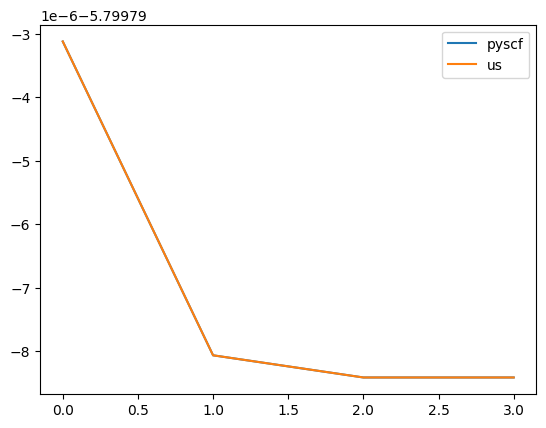

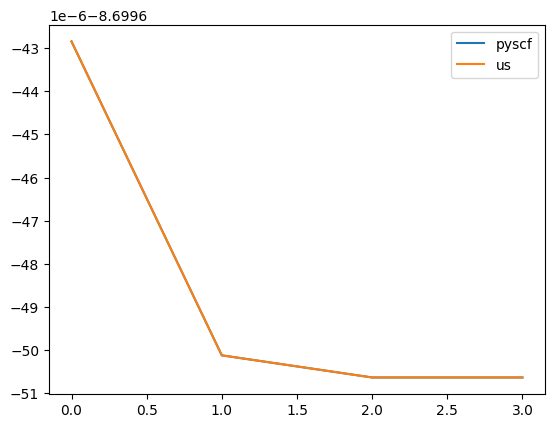

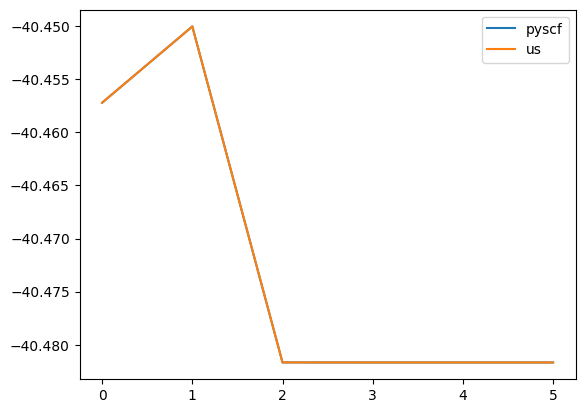

In [26]:
import textwrap
import numpy
from pyscf import lib
from pyscf.lib import logger
from pyscf import scf
from pyscf.scf import hf
from pyscf.scf import _vhf
from pyscf.scf import jk
from pyscf.dft import gen_grid
from pyscf.dft import numint
from pyscf import __config__
from pyscf import lib
from functools import reduce
import numpy
import scipy.linalg
import sys 
import tempfile
import h5py
from pyscf import gto
from pyscf import lib
from pyscf.lib import logger
from pyscf.scf import diis
from pyscf.scf import _vhf
from pyscf.scf import chkfile
from pyscf.data import nist

def xc_and_coulomb(ks, mol=None, dm=None, dm_last=0, vhf_last=0, hermi=1):
    '''Coulomb + XC functional
    .. note::
        This function will modify the input ks object.
    Args:
        ks : an instance of :class:`RKS`
            XC functional are controlled by ks.xc attribute.  Attribute
            ks.grids might be initialized.
        dm : ndarray or list of ndarrays
            A density matrix or a list of density matrices
    Kwargs:
        dm_last : ndarray or a list of ndarrays or 0
            The density matrix baseline.  If not 0, this function computes the
            increment of HF potential w.r.t. the reference HF potential matrix.
        vhf_last : ndarray or a list of ndarrays or 0
            The reference Vxc potential matrix.
        hermi : int
            Whether J, K matrix is hermitian
            | 0 : no hermitian or symmetric
            | 1 : hermitian
            | 2 : anti-hermitian
    Returns:
        matrix Veff = J + Vxc.  Veff can be a list matrices, if the input
        dm is a list of density matrices.
    '''
    #if dm is None: dm = ks.make_rdm1()
    #ks.initialize_grids(mol, dm) # <-- only needs to be called once, and I think mol.build() does it? 

    ni            = ks._numint # numerical integrator, depends on xc functional! 
    max_memory    = ks.max_memory - lib.current_memory()[0]
    n, exc, vxc   = ni.nr_rks(mol, ks.grids, ks.xc, dm, max_memory=max_memory)

    #enabling range-separated hybrids
    omega, alpha, hyb = ni.rsh_and_hybrid_coeff(ks.xc, spin=mol.spin)

    if (ks._eri is None and ks.direct_scf and getattr(vhf_last, 'vk', None) is not None):
        ddm = numpy.asarray(dm) - numpy.asarray(dm_last)
        vj, vk = ks.get_jk(mol, ddm, hermi)
        vk *= hyb
        if abs(omega) > 1e-10:  # For range separated Coulomb operator
            vklr = ks.get_k(mol, ddm, hermi, omega=omega)
            vklr *= (alpha - hyb)
            vk += vklr
        vj += vhf_last.vj
        vk += vhf_last.vk
    else:
        vj, vk = ks.get_jk(mol, dm, hermi)
        vk *= hyb
        if abs(omega) > 1e-10:
            vklr = ks.get_k(mol, dm, hermi, omega=omega)
            vklr *= (alpha - hyb)
            vk += vklr
    vxc += vj - vk * .5

    exc   -= numpy.einsum('ij,ji', dm, vk).real * .5 * .5
    ecoul  = numpy.einsum('ij,ji', dm, vj).real * .5

    vxc = lib.tag_array(vxc, ecoul=ecoul, exc=exc, vj=vj, vk=vk)
    return vxc


def _dft_common_init_(mf, xc='LDA,VWN'):
    mf.xc = xc
    mf.nlc = ''
    mf.grids = gen_grid.Grids(mf.mol)
    mf.grids.level = getattr(__config__, 'dft_rks_RKS_grids_level',
                             mf.grids.level)
    mf.nlcgrids = gen_grid.Grids(mf.mol)
    mf.nlcgrids.level = getattr(__config__, 'dft_rks_RKS_nlcgrids_level',
                                mf.nlcgrids.level)
    # Use rho to filter grids
    mf.small_rho_cutoff = getattr(__config__, 'dft_rks_RKS_small_rho_cutoff', 1e-7)
##################################################
# don't modify the following attributes, they are not input options
    mf._numint = numint.NumInt()
    mf._keys = mf._keys.union(['xc', 'nlc', 'omega', 'grids', 'nlcgrids',
                               'small_rho_cutoff'])


def core_hamiltonian(mol):
    '''Core Hamiltonian
    Examples:
    >>> from pyscf import gto, scf
    >>> mol = gto.M(atom='H 0 0 0; H 0 0 1.1')
    >>> scf.hf.get_hcore(mol)
    array([[-0.93767904, -0.59316327],
           [-0.59316327, -0.93767904]])
    '''
    h = mol.intor_symmetric('int1e_kin')

    if mol._pseudo:
        # Although mol._pseudo for GTH PP is only available in Cell, GTH PP
        # may exist if mol is converted from cell object.
        from pyscf.gto import pp_int
        h += pp_int.get_gth_pp(mol)
    else:
        h+= mol.intor_symmetric('int1e_nuc')

    if len(mol._ecpbas) > 0:
        h += mol.intor_symmetric('ECPscalar')
    return h


class KohnShamDFT(object): 
    __init__ = _dft_common_init_

class RKS(): # moved everything into one class! i.e. removed inheritance dependency 
    conv_tol = getattr(__config__, 'scf_hf_SCF_conv_tol', 1e-9)
    #conv_tol_grad = getattr(__config__, 'scf_hf_SCF_conv_tol_grad', None)
    max_cycle = getattr(__config__, 'scf_hf_SCF_max_cycle', 50)
    init_guess = getattr(__config__, 'scf_hf_SCF_init_guess', 'minao')

    # To avoid diis pollution form previous run, self.diis should not be
    # initialized as DIIS instance here
    DIIS = diis.SCF_DIIS
    diis = getattr(__config__, 'scf_hf_SCF_diis', True)
    diis_space = getattr(__config__, 'scf_hf_SCF_diis_space', 8)
    # need > 0 if initial DM is numpy.zeros array
    diis_start_cycle = getattr(__config__, 'scf_hf_SCF_diis_start_cycle', 1)
    diis_file = None
    # Give diis_space_rollback=True a trial if all other methods do not converge
    diis_space_rollback = False

    damp = getattr(__config__, 'scf_hf_SCF_damp', 0)
    level_shift = getattr(__config__, 'scf_hf_SCF_level_shift', 0)
    direct_scf = getattr(__config__, 'scf_hf_SCF_direct_scf', True)
    direct_scf_tol = getattr(__config__, 'scf_hf_SCF_direct_scf_tol', 1e-13)
    conv_check = getattr(__config__, 'scf_hf_SCF_conv_check', True)

    def __init__2(self, mol):
        if not mol._built:
            sys.stderr.write('Warning: %s must be initialized before calling SCF.\n'
                             'Initialize %s in %s\n' % (mol, mol, self))
            mol.build()
        self.mol = mol
        self.verbose = mol.verbose
        self.max_memory = mol.max_memory
        self.stdout = mol.stdout

        # If chkfile is muted, SCF intermediates will not be dumped anywhere.
        '''if MUTE_CHKFILE: # don't save to check file. 
            self.chkfile = None
        else:
            # the chkfile will be removed automatically, to save the chkfile, assign a
            # filename to self.chkfile
            self._chkfile = tempfile.NamedTemporaryFile(dir=lib.param.TMPDIR)
            self.chkfile = self._chkfile.name'''

        # output stuff; don't modify
        self.mo_energy = None
        self.mo_coeff = None
        self.mo_occ = None
        self.e_tot = 0
        self.converged = False
        self.callback = None
        self.scf_summary = {}

        self.opt = None
        self._eri = None # Note: self._eri requires large amount of memory

        keys = set(('conv_tol', 'conv_tol_grad', 'max_cycle', 'init_guess',
                    'DIIS', 'diis', 'diis_space', 'diis_start_cycle',
                    'diis_file', 'diis_space_rollback', 'damp', 'level_shift',
                    'direct_scf', 'direct_scf_tol', 'conv_check'))
        self._keys = set(self.__dict__.keys()).union(keys)

    def __init__(self, mol, xc='LDA,VWN'):
        self.__init__2(mol)
        KohnShamDFT.__init__(self, xc)


    def build(self, mol=None):
        if mol is None: mol = self.mol
        if self.verbose >= logger.WARN:
            self.check_sanity()
        # lazily initialize direct SCF
        self.opt = None
        return self

    def get_jk(self, mol=None, dm=None, hermi=1, with_j=True, with_k=True,
               omega=None):
        if mol is None: mol = self.mol
        if dm is None: dm = self.make_rdm1()
        cpu0 = (logger.process_clock(), logger.perf_counter())
        if self.direct_scf and self.opt is None:
            self.opt = self.init_direct_scf(mol)

        if with_j and with_k:
            vj, vk = hf.get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)
        else:
            if with_j:
                prescreen = 'CVHFnrs8_vj_prescreen'
            else:
                prescreen = 'CVHFnrs8_vk_prescreen'
            with lib.temporary_env(self.opt, prescreen=prescreen):
                vj, vk = get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)

        logger.timer(self, 'vj and vk', *cpu0)
        return vj, vk

    def get_j(self, mol=None, dm=None, hermi=1, omega=None):
        '''Compute J matrices for all input density matrices
        '''
        return self.get_jk(mol, dm, hermi, with_k=False, omega=omega)[0]

    def get_k(self, mol=None, dm=None, hermi=1, omega=None):
        '''Compute K matrices for all input density matrices
        '''
        return self.get_jk(mol, dm, hermi, with_j=False, omega=omega)[1]

    def init_direct_scf(self, mol=None):
        if mol is None: mol = self.mol
        # Integrals < direct_scf_tol may be set to 0 in int2e.
        # Higher accuracy is required for Schwartz inequality prescreening.
        with mol.with_integral_screen(self.direct_scf_tol**2):
            opt = _vhf.VHFOpt(mol, 'int2e', 'CVHFnrs8_prescreen',
                              'CVHFsetnr_direct_scf',
                              'CVHFsetnr_direct_scf_dm')
            opt.direct_scf_tol = self.direct_scf_tol
        return opt

    def scf(self):
        returns = self.kernel(convergence_tolerance=self.conv_tol, callback=self.callback, conv_check=self.conv_check)
        self.converged, self.e_tot,  self.mo_energy, self.mo_coeff, self.mo_occ, energies =  returns 
        return self.e_tot, energies

    def kernel(self, convergence_tolerance=1e-10, callback=None, conv_check=True): # self = mf 
      mol       = self.mol
      e_tot     = -1  
      converged = False

      # init stuff 
      dm  = hf.init_guess_by_minao(mol)     # <-- a few hundred lines of code in hf.py  (4, 4)
      h1e = core_hamiltonian(mol)           # <--- gets fixed part of hamiltonian which doesn't change (4, 4)
      vhf = xc_and_coulomb(self, mol, dm)   # <--- Coulomb + XC functional (this is the part that changes)  (4, 4)
      s1e = hf.get_ovlp(mol)                # <-- overlap matrix;; is this electron by electonr? dont think so (4, 4)

      mf_diis           = self.DIIS(self, self.diis_file)
      mf_diis.space     = self.diis_space
      mf_diis.rollback  = self.diis_space_rollback

      energies = []

      from tqdm import tqdm 
      for cycle in tqdm(range(self.max_cycle)):
          dm_last             = dm        
          last_hf_e           = e_tot
          
          #fock                = h1e + vhf  # h1e is fixed part of hamiltonian and vhf is the part that changes? 
          #<--- uses a special kind of damping ;; makes a difference for "larger" molecules.
          # no differnce: He2, He3
          # difference;   CCCHH
          fock               = hf.get_fock(self, h1e, s1e, vhf, dm, cycle, mf_diis) 

          mo_energy, mo_coeff = scipy.linalg.eigh(fock, s1e) # solve eigenproblem 

          if cycle == 0: 
            e_idx   = numpy.argsort(mo_energy)
            mo_occ = numpy.zeros(mo_energy.shape)
            mo_occ[e_idx[:mol.nelectron//2]] = 2

          # Update density matrix based on the number of electrons (given by mo_occ). 
          mocc = mo_coeff[:,mo_occ>0]
          dm   = numpy.dot(mocc*mo_occ[mo_occ>0], mocc.conj().T)

          # This is the part that changes each iteration. 
          vhf  = xc_and_coulomb(self, mol, dm, dm_last, vhf) 

          # Compute energy. Currently only used to check for convergence. 
          e_tot =  numpy.einsum('ij,ji->', h1e, dm).real  + vhf.ecoul.real + vhf.exc.real  + mol.energy_nuc() 
          energies.append(e_tot)

          if abs(e_tot-last_hf_e) < convergence_tolerance:
              converged = True
              break

      return converged, e_tot, mo_energy, mo_coeff, mo_occ, energies


def jax_scf(str):
  basis_set ="6-31G*"
  #basis_set ="sto3g"
  xc_fun    ="b3lyp"

  # So PCQ uses eV and PySCF uses Hartree 
  eV_to_hartree    = 0.0367493
  hartree_to_eV    = 27.2114
  angstrom_to_bohr = 1.88973

  from pyscf.gto import mole  # <--- this file is 2000 lines of code
  mol = mole.Mole()
  mol.build(atom=str, unit="Bohr", basis=basis_set)

  import time 
  t0 = time.time()
  mol.verbose = 0 
  mf = RKS(mol) 
  mf.xc = xc_fun 
  energy, energies = mf.scf()
  t1 = time.time()

  lumo = np.argmin(mf.mo_occ)
  homo = lumo - 1
  hl_gap_hartree = np.abs(mf.mo_energy[homo] - mf.mo_energy[lumo])
  hlgap = hartree_to_eV*hl_gap_hartree
  return energy, hlgap , t1-t0 , energies
  #our_energy, our_hlgap, t_us, energies

#test_cases(our_fun=jax_scf, list=[0,1]) # speed test 
#test_cases(our_fun=jax_scf, list=[-1]) # speed test 
#test_cases(our_fun=jax_scf, list=[4]) # speed test 
#test_cases(our_fun=jax_scf, list=[0,1]) #  fast, He2 and He3
#test_cases(our_fun=jax_scf, list=[0,4,8]) # slow, but more coverage, He2, CH4, FH
test_cases(our_fun=jax_scf, verbose=True) # do all test cases, very slow. 

# Step 7: Ran all test cases

|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
CCBHHH

E=-102.531184 change=9.777068e-12 tolerance=1.000000e-10:  42%|████▏     | 21/50 [00:05<00:07,  3.79it/s]


	 -102.53118389028691 0.9911101135927345 6.635589122772217
[-102.36190198399095, -101.60551852398908, -102.48074615197515, -102.34047214015209, -102.49872316992449, -102.51968272195035, -102.5208231938874, -102.52357834545978, -102.52575878959897, -102.53088234556697, -102.53105810974915, -102.53116654476673, -102.53118032261506, -102.53118078037932, -102.53118111885414, -102.53118196707916, -102.53118363680011, -102.53118387093778, -102.53118388552329, -102.5311838900866, -102.53118389020545]
[-102.3619019840778, -101.60551852409714, -102.48074615205209, -102.3404721402236, -102.49872316979238, -102.51968272205144, -102.52082319394185, -102.52357834550821, -102.52575878963682, -102.5308823456206, -102.53105810981538, -102.5311665448383, -102.53118032268665, -102.53118078045057, -102.53118111892599, -102.53118196715008, -102.53118363687099, -102.53118387100938, -102.53118388559494, -102.5311838901583, -102.53118389027713, -102.53118389028691]

|          CCBHHH |  -102.531 0.991 |  -10

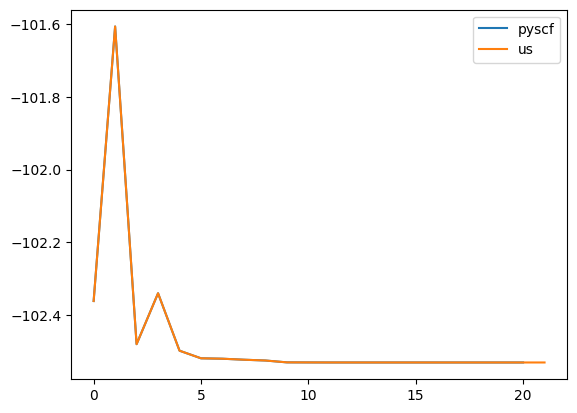

In [29]:
import textwrap
from tqdm import tqdm
import numpy
from pyscf import scf
from pyscf.scf import hf
from pyscf.scf import _vhf
from pyscf.scf import jk
from pyscf.dft import gen_grid
from pyscf.dft import numint
from pyscf import __config__
from pyscf import lib
from functools import reduce
import numpy
import scipy.linalg
import sys 
import tempfile
import h5py
from pyscf import gto
from pyscf.scf import diis
from pyscf.scf import _vhf
from pyscf.scf import chkfile
from pyscf.data import nist

def xc_and_coulomb(ks, mol=None, dm=None, dm_last=0, vhf_last=0, hermi=1):
    '''Coulomb + XC functional
    .. note::
        This function will modify the input ks object.
    Args:
        ks : an instance of :class:`RKS`
            XC functional are controlled by ks.xc attribute.  Attribute
            ks.grids might be initialized.
        dm : ndarray or list of ndarrays
            A density matrix or a list of density matrices
    Kwargs:
        dm_last : ndarray or a list of ndarrays or 0
            The density matrix baseline.  If not 0, this function computes the
            increment of HF potential w.r.t. the reference HF potential matrix.
        vhf_last : ndarray or a list of ndarrays or 0
            The reference Vxc potential matrix.
        hermi : int
            Whether J, K matrix is hermitian
            | 0 : no hermitian or symmetric
            | 1 : hermitian
            | 2 : anti-hermitian
    Returns:
        matrix Veff = J + Vxc.  Veff can be a list matrices, if the input
        dm is a list of density matrices.
    '''
    #if dm is None: dm = ks.make_rdm1()
    #ks.initialize_grids(mol, dm) # <-- only needs to be called once, and I think mol.build() does it? 

    ni            = ks._numint # numerical integrator, depends on xc functional! 
    max_memory    = ks.max_memory - lib.current_memory()[0]
    n, exc, vxc   = ni.nr_rks(mol, ks.grids, ks.xc, dm, max_memory=max_memory)

    #enabling range-separated hybrids
    omega, alpha, hyb = ni.rsh_and_hybrid_coeff(ks.xc, spin=mol.spin)

    if (ks._eri is None and ks.direct_scf and getattr(vhf_last, 'vk', None) is not None):
        ddm = numpy.asarray(dm) - numpy.asarray(dm_last)
        vj, vk = ks.get_jk(mol, ddm, hermi)
        vk *= hyb
        if abs(omega) > 1e-10:  # For range separated Coulomb operator
            vklr = ks.get_k(mol, ddm, hermi, omega=omega)
            vklr *= (alpha - hyb)
            vk += vklr
        vj += vhf_last.vj
        vk += vhf_last.vk
    else:
        vj, vk = ks.get_jk(mol, dm, hermi)
        vk *= hyb
        if abs(omega) > 1e-10:
            vklr = ks.get_k(mol, dm, hermi, omega=omega)
            vklr *= (alpha - hyb)
            vk += vklr
    vxc += vj - vk * .5

    exc   -= numpy.einsum('ij,ji', dm, vk).real * .5 * .5
    ecoul  = numpy.einsum('ij,ji', dm, vj).real * .5

    vxc = lib.tag_array(vxc, E_coulomb=ecoul, E_xc=exc, vj=vj, vk=vk)
    return vxc



class RKS(): # moved everything into one class! i.e. removed inheritance dependency 

    DIIS = diis.SCF_DIIS # Direct inversion in the iterative subspace DIIS. 

    diis = getattr(__config__, 'scf_hf_SCF_diis', True)
    diis_space = getattr(__config__, 'scf_hf_SCF_diis_space', 8)
    # need > 0 if initial DM is numpy.zeros array
    diis_start_cycle = getattr(__config__, 'scf_hf_SCF_diis_start_cycle', 1)
    diis_file = None
    # Give diis_space_rollback=True a trial if all other methods do not converge
    diis_space_rollback = False

    damp            = getattr(__config__, 'scf_hf_SCF_damp', 0)
    level_shift     = getattr(__config__, 'scf_hf_SCF_level_shift', 0)
    direct_scf      = getattr(__config__, 'scf_hf_SCF_direct_scf', True)
    direct_scf_tol  = getattr(__config__, 'scf_hf_SCF_direct_scf_tol', 1e-13)

    def __init__(self, mol, xc='LDA,VWN'):

        self.mol = mol
        self.verbose = mol.verbose
        self.max_memory = mol.max_memory
        self.stdout = mol.stdout

        self.opt = None
        self._eri = None # Note: self._eri requires large amount of memory
        
        self.xc = xc
        self.nlc = ''
        self.grids = gen_grid.Grids(self.mol)
        self.grids.level = getattr(__config__, 'dft_rks_RKS_grids_level',
                                self.grids.level)
        self.nlcgrids = gen_grid.Grids(self.mol)
        self.nlcgrids.level = getattr(__config__, 'dft_rks_RKS_nlcgrids_level',
                                    self.nlcgrids.level)
        # Use rho to filter grids
        self.small_rho_cutoff = getattr(__config__, 'dft_rks_RKS_small_rho_cutoff', 1e-7)
        self._numint = numint.NumInt()
        self.max_cycle = 50


    def get_jk(self, mol=None, dm=None, hermi=1, with_j=True, with_k=True,
               omega=None):
        if mol is None: mol = self.mol
        if dm is None: dm = self.make_rdm1()
        #cpu0 = (logger.process_clock(), logger.perf_counter())
        if self.direct_scf and self.opt is None:
            self.opt = self.init_direct_scf(mol)

        if with_j and with_k:
            vj, vk = hf.get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)
        else:
            if with_j:
                prescreen = 'CVHFnrs8_vj_prescreen'
            else:
                prescreen = 'CVHFnrs8_vk_prescreen'
            with lib.temporary_env(self.opt, prescreen=prescreen):
                vj, vk = get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)

        #logger.timer(self, 'vj and vk', *cpu0)
        return vj, vk

    def get_j(self, mol=None, dm=None, hermi=1, omega=None):
        '''Compute J matrices for all input density matrices
        '''
        return self.get_jk(mol, dm, hermi, with_k=False, omega=omega)[0]

    def get_k(self, mol=None, dm=None, hermi=1, omega=None):
        '''Compute K matrices for all input density matrices '''
        return self.get_jk(mol, dm, hermi, with_j=False, omega=omega)[1]

    def init_direct_scf(self, mol=None):
        # Integrals < direct_scf_tol may be set to 0 in int2e.
        # Higher accuracy is required for Schwartz inequality prescreening.
        with mol.with_integral_screen(self.direct_scf_tol**2):
            opt = _vhf.VHFOpt(mol, 'int2e', 'CVHFnrs8_prescreen',
                              'CVHFsetnr_direct_scf',
                              'CVHFsetnr_direct_scf_dm')
            opt.direct_scf_tol = self.direct_scf_tol
        return opt

    def kernel(self, convergence_tolerance=1e-10): 
      mol       = self.mol
      e_tot     = -1  
      converged = False

      # Init Stuff 
      dm              = hf.init_guess_by_minao(mol)     # <-- a few hundred lines of code in hf.py  (4, 4)
      h1e             = mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc') # <--- gets fixed part of hamiltonian which doesn't change (4, 4)
      vhf             = xc_and_coulomb(self, mol, dm)   # <--- Coulomb + XC functional (this is the part that changes)  (4, 4)
      s1e             = hf.get_ovlp(mol)                # <-- overlap matrix;; is this electron by electonr? dont think so (4, 4) ;; we add it to the generalized eigensolver? 
      nuclear_energy  = mol.energy_nuc()
      n_electrons     = mol.nelectron

      mf_diis           = self.DIIS(self, self.diis_file)
      mf_diis.space     = self.diis_space
      mf_diis.rollback  = self.diis_space_rollback

      pbar = tqdm(range(self.max_cycle))

      energies = []

      for cycle in pbar:
          dm_last             = dm        
          last_hf_e           = e_tot
          
          fock = h1e + vhf
          if cycle >= self.diis_start_cycle:
            fock = mf_diis.update(s1e, dm, fock, self, h1e, vhf)

          # it relies on a generalized eigenproblem  A@v=lambda B@v 
          # however, we may just multiply by inverse instead. 
          # we may think of this as implicitly multiplying by inverse of s1e, e.g., solving inv(s1e)@fock @ x = lambda x and then s1e@x. 
          # there's a way to turn this into a normal eigenvalue problem, so we just call np.linalg.eigh
          mo_energy, mo_coeff = scipy.linalg.eigh(fock, s1e) 

          if cycle == 0: 
            e_idx   = numpy.argsort(mo_energy)
            mo_occ = numpy.zeros(mo_energy.shape)
            mo_occ[e_idx[:n_electrons//2]] = 2 # is this always true?

          # Update density matrix based on the number of electrons (given by mo_occ). 
          mocc = mo_coeff[:,mo_occ>0]
          dm   = mocc*mo_occ[mo_occ>0]@ mocc.conj().T 

          # This is the part that changes each iteration. 
          #vhf  = xc_and_coulomb(self, mol, dm, dm_last, vhf)  # only dpeendency on mol inside for loop. 
          if True: 
            vhf_last      = vhf 

            #print(self.grids)
            n, E_xc, V_xc   = self._numint.nr_rks(mol, self.grids, self.xc, dm)

            omega, alpha, hyb = self._numint.rsh_and_hybrid_coeff(self.xc, spin=mol.spin)

            ddm     = numpy.asarray(dm) - numpy.asarray(dm_last)
            vj, vk = self.get_jk(mol, ddm, hermi=True)
            vk    *= hyb
            vj    += vhf_last.vj
            vk    += vhf_last.vk

            V_xc += vj - vk * .5

            E_xc      = E_xc - numpy.einsum('ij,ji', dm, vk).real * .5 * .5
            E_coulomb = numpy.einsum('ij,ji', dm, vj).real * .5

            V_xc = lib.tag_array(V_xc, E_coulomb=E_coulomb, E_xc=E_xc, vj=vj, vk=vk)
            vhf = V_xc

          # Compute energy. Currently only used to check for convergence. 
          e_tot =  numpy.einsum('ij,ji->', h1e, dm).real  + E_coulomb.real + E_xc.real  + nuclear_energy

          pbar.set_description("E=%4f change=%4e tolerance=%4e"%(e_tot, abs(e_tot-last_hf_e), convergence_tolerance))

          energies.append(e_tot)
          if abs(e_tot-last_hf_e) < convergence_tolerance:
              converged = True
              break

      self.converged, self.e_tot,  self.mo_energy, self.mo_coeff, self.mo_occ =  converged, e_tot, mo_energy, mo_coeff, mo_occ
      return self.e_tot , energies


def jax_scf(str):
  basis_set ="6-31G*"
  xc_fun    ="b3lyp"

  # So PCQ uses eV and PySCF uses Hartree 
  eV_to_hartree    = 0.0367493
  hartree_to_eV    = 27.2114
  angstrom_to_bohr = 1.88973

  from pyscf.gto import mole  # <--- this file is 2000 lines of code
  mol = mole.Mole()
  mol.build(atom=str, unit="Bohr", basis=basis_set)

  mol.verbose = 0 
  mf = RKS(mol) 
  mf.xc = xc_fun 
  t0 = time.time()
  energy, energies = mf.kernel()
  t_us = time.time()-t0

  lumo = np.argmin(mf.mo_occ)
  homo = lumo - 1
  hl_gap_hartree = np.abs(mf.mo_energy[homo] - mf.mo_energy[lumo])
  hlgap = hartree_to_eV*hl_gap_hartree
  return energy, hlgap , t_us, energies

#test_cases(our_fun=jax_scf, list=[0, -1], verbose=True) # speed test 

test_cases(our_fun=jax_scf, list=[51], verbose=True) # speed test 
#test_cases(our_fun=jax_scf, list=[4]) # speed test 
#test_cases(our_fun=jax_scf, list=[0,1]) #  fast, He2 and He3
#test_cases(our_fun=jax_scf, list=[0,4,8]) # slow, but more coverage, He2, CH4, FH
#test_cases(our_fun=jax_scf) # do all test cases, very slow. 
#|          CCBHHH |  -102.531 0.991 |  -102.476 0.367 |     0.055 0.624 |        0.991112 |         30.836456s |         36.083012s |


# Step 8 # changing generalized eigh to L_inv

|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
HeHe	 -5.799798410857478 47.01424791215063 0.26771116256713867
[-5.799793123445309, -5.7997980619195095, -5.799798410811428, -5.7997984108116345]
[-5.79979312349262, -5.799798409615176, -5.799798410852878, -5.799798410857478]

|            HeHe |   -5.800 47.014 |   -5.800 47.014 |     0.000 0.000 |       47.014227 |          1.044863s |          0.267711s |
HeHeHe	 -8.69965064203647 46.37454254950352 0.3515191078186035
[-8.699642840257763, -8.69965012808619, -8.69965064198248, -8.69965064198302]
[-8.69964284031358, -8.699650638780916, -8.699650642029574, -8.69965064203647]

|          HeHeHe |   -8.700 46.375 |   -8.700 46.375 |     0.000 0.000 |       46.374526 |          1.605871s |          0.351519s |
CHHHH	 -40.481668355204114 13.791238822498343 1.1217350959777832
[-40.45720389282365, -40.45002546733479, -40.48166365215325, -40.48166834854976, -40.48

KeyboardInterrupt: 

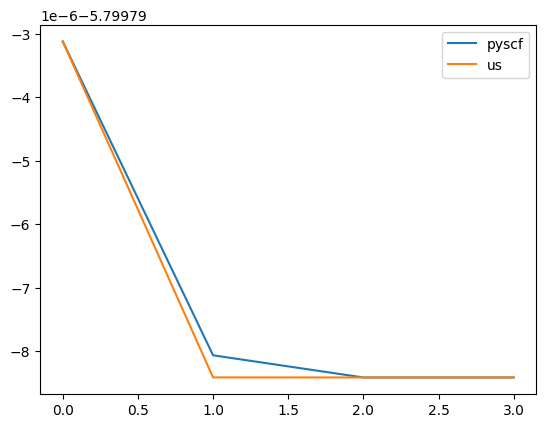

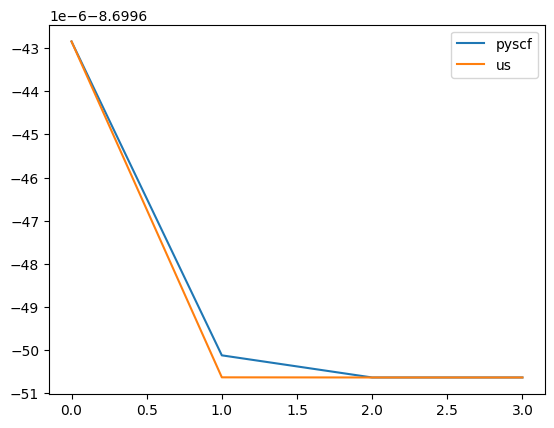

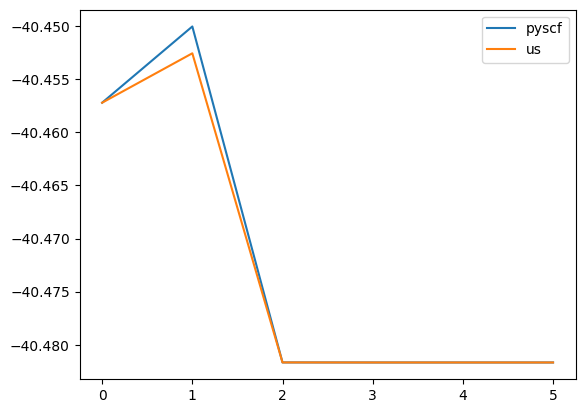

In [31]:
import textwrap
from tqdm import tqdm
import numpy
from pyscf import scf
from pyscf.scf import hf
from pyscf.scf import _vhf
from pyscf.scf import jk
from pyscf.dft import gen_grid
from pyscf.dft import numint
from pyscf import __config__
from pyscf import lib
from functools import reduce
import numpy
import scipy.linalg
import sys 
import tempfile
import h5py
from pyscf import gto
from pyscf.scf import diis
from pyscf.scf import _vhf
from pyscf.scf import chkfile
from pyscf.data import nist

def xc_and_coulomb(ks, mol=None, dm=None, dm_last=0, vhf_last=0, hermi=1):
    '''Coulomb + XC functional
    .. note::
        This function will modify the input ks object.
    Args:
        ks : an instance of :class:`RKS`
            XC functional are controlled by ks.xc attribute.  Attribute
            ks.grids might be initialized.
        dm : ndarray or list of ndarrays
            A density matrix or a list of density matrices
    Kwargs:
        dm_last : ndarray or a list of ndarrays or 0
            The density matrix baseline.  If not 0, this function computes the
            increment of HF potential w.r.t. the reference HF potential matrix.
        vhf_last : ndarray or a list of ndarrays or 0
            The reference Vxc potential matrix.
        hermi : int
            Whether J, K matrix is hermitian
            | 0 : no hermitian or symmetric
            | 1 : hermitian
            | 2 : anti-hermitian
    Returns:
        matrix Veff = J + Vxc.  Veff can be a list matrices, if the input
        dm is a list of density matrices.
    '''
    #if dm is None: dm = ks.make_rdm1()
    #ks.initialize_grids(mol, dm) # <-- only needs to be called once, and I think mol.build() does it? 

    ni            = ks._numint # numerical integrator, depends on xc functional! 
    max_memory    = ks.max_memory - lib.current_memory()[0]
    n, exc, vxc   = ni.nr_rks(mol, ks.grids, ks.xc, dm, max_memory=max_memory)

    #enabling range-separated hybrids
    omega, alpha, hyb = ni.rsh_and_hybrid_coeff(ks.xc, spin=mol.spin)

    if (ks._eri is None and ks.direct_scf and getattr(vhf_last, 'vk', None) is not None):
        ddm = numpy.asarray(dm) - numpy.asarray(dm_last)
        vj, vk = ks.get_jk(mol, ddm, hermi)
        vk *= hyb
        if abs(omega) > 1e-10:  # For range separated Coulomb operator
            vklr = ks.get_k(mol, ddm, hermi, omega=omega)
            vklr *= (alpha - hyb)
            vk += vklr
        vj += vhf_last.vj
        vk += vhf_last.vk
    else:
        vj, vk = ks.get_jk(mol, dm, hermi)
        vk *= hyb
        if abs(omega) > 1e-10:
            vklr = ks.get_k(mol, dm, hermi, omega=omega)
            vklr *= (alpha - hyb)
            vk += vklr
    vxc += vj - vk * .5

    exc   -= numpy.einsum('ij,ji', dm, vk).real * .5 * .5
    ecoul  = numpy.einsum('ij,ji', dm, vj).real * .5

    vxc = lib.tag_array(vxc, E_coulomb=ecoul, E_xc=exc, vj=vj, vk=vk)
    return vxc

#from pyscf.scf.diis import *

def get_err_vec(s, d, f):
    '''error vector = SDF - FDS'''
    if isinstance(f, numpy.ndarray) and f.ndim == 2:
        sdf = reduce(numpy.dot, (s,d,f))
        errvec = sdf.T.conj() - sdf

    elif isinstance(f, numpy.ndarray) and f.ndim == 3 and s.ndim == 3:
        errvec = []
        for i in range(f.shape[0]):
            sdf = reduce(numpy.dot, (s[i], d[i], f[i]))
            errvec.append((sdf.T.conj() - sdf))
        errvec = numpy.vstack(errvec)

    elif f.ndim == s.ndim+1 and f.shape[0] == 2:  # for UHF
        nao = s.shape[-1]
        s = lib.asarray((s,s)).reshape(-1,nao,nao)
        return get_err_vec(s, d.reshape(s.shape), f.reshape(s.shape))
    else:
        raise RuntimeError('Unknown SCF DIIS type')
    return errvec


from pyscf.lib import misc

class CDIIS(lib.diis.DIIS):
    def __init__(self, mf=None, filename=None):
        lib.diis.DIIS.__init__(self, mf, filename)
        self.rollback = False
        self.space = 8

    def update(self, s, d, f, *args, **kwargs):
        errvec = get_err_vec(s, d, f)
        xnew = lib.diis.DIIS.update(self, f, xerr=errvec)
        if self.rollback > 0 and len(self._bookkeep) == self.space:
            self._bookkeep = self._bookkeep[-self.rollback:]
        return xnew

    def get_num_vec(self):
        if self.rollback:
            return self._head
        else:
            return len(self._bookkeep)

BLOCK_SIZE  = getattr(__config__, 'lib_diis_block_size', 20000000)
def update(self, x, xerr):
    self.push_err_vec(xerr)
    self.push_vec(x)

    nd = self.get_num_vec()

    dt = numpy.array(self.get_err_vec(self._head-1), copy=False)
    if self._H is None:
        self._H = numpy.zeros((self.space+1,self.space+1), dt.dtype)
        self._H[0,1:] = self._H[1:,0] = 1

    for i in range(nd):
        tmp = 0
        dti = self.get_err_vec(i)
        for p0, p1 in misc.prange(0, dt.size, BLOCK_SIZE):
            tmp += numpy.dot(dt[p0:p1].conj(), dti[p0:p1])
        self._H[self._head,i+1] = tmp
        self._H[i+1,self._head] = tmp.conjugate()
    dt = None

    xnew = self.extrapolate(nd)

    return xnew.reshape(x.shape)

from pyscf.dft.numint import _rks_gga_wv0, _scale_ao, _dot_ao_ao

def nr_rks(ni, mol, grids, xc_code, dms, relativity=0, hermi=1, max_memory=2000, verbose=None): # this one supports all xcs 
    '''Calculate RKS XC functional and potential matrix on given meshgrids
    for a set of density matrices
    Args:
        ni : an instance of :class:`NumInt`
        mol : an instance of :class:`Mole`
        grids : an instance of :class:`Grids`
            grids.coords and grids.weights are needed for coordinates and weights of meshgrids.
        xc_code : str
            XC functional description.
            See :func:`parse_xc` of pyscf/dft/libxc.py for more details.
        dms : 2D array or a list of 2D arrays
            Density matrix or multiple density matrices
    Kwargs:
        hermi : int
            Input density matrices symmetric or not. It also indicates whether
            the potential matrices in return are symmetric or not.
        max_memory : int or float
            The maximum size of cache to use (in MB).
    Returns:
        nelec, excsum, vmat.
        nelec is the number of electrons generated by numerical integration.
        excsum is the XC functional value.  vmat is the XC potential matrix in
        2D array of shape (nao,nao) where nao is the number of AO functions.
    Examples:
    >>> from pyscf import gto, dft
    >>> mol = gto.M(atom='H 0 0 0; H 0 0 1.1')
    >>> grids = dft.gen_grid.Grids(mol)
    >>> grids.coords = numpy.random.random((100,3))  # 100 random points
    >>> grids.weights = numpy.random.random(100)
    >>> nao = mol.nao_nr()
    >>> dm = numpy.random.random((nao,nao))
    >>> ni = dft.numint.NumInt()
    >>> nelec, exc, vxc = ni.nr_rks(mol, grids, 'lda,vwn', dm)
    '''
    xctype = ni._xc_type(xc_code)
    make_rho, nset, nao = ni._gen_rho_evaluator(mol, dms, hermi)

    shls_slice = (0, mol.nbas)
    ao_loc = mol.ao_loc_nr()

    nelec = numpy.zeros(nset)
    excsum = numpy.zeros(nset)
    if isinstance(dms, numpy.ndarray):
        vmat = numpy.zeros((nset,nao,nao), dtype=dms.dtype)
    else:
        vmat = numpy.zeros((nset,nao,nao), dtype=numpy.result_type(*dms))

    def block_loop(ao_deriv):
        for ao, mask, weight, coords \
                in ni.block_loop(mol, grids, nao, ao_deriv, max_memory=max_memory):
            for i in range(nset):
                rho = make_rho(i, ao, mask, xctype)
                exc, vxc = ni.eval_xc(xc_code, rho, spin=0,
                                      relativity=relativity, deriv=1,
                                      verbose=verbose)[:2]
                if xctype == 'LDA':
                    den = rho * weight
                else:
                    den = rho[0] * weight
                nelec[i] += den.sum()
                excsum[i] += numpy.dot(den, exc)
                yield i, rho, ao, mask, weight, vxc

    aow = None
    if xctype == 'LDA':
        ao_deriv = 0
        for i, rho, ao, mask, weight, vxc in block_loop(ao_deriv):
            vrho = vxc[0]
            # *.5 because vmat + vmat.T
            #:aow = numpy.einsum('pi,p->pi', ao, .5*weight*vrho, out=aow)
            aow = _scale_ao(ao, .5*weight*vrho, out=aow)
            vmat[i] += _dot_ao_ao(mol, ao, aow, mask, shls_slice, ao_loc)

    elif xctype == 'GGA':
        ao_deriv = 1
        for i, rho, ao, mask, weight, vxc in block_loop(ao_deriv):
            wv = _rks_gga_wv0(rho, vxc, weight)
            #:aow = numpy.einsum('npi,np->pi', ao, wv, out=aow)
            aow = _scale_ao(ao, wv, out=aow)
            vmat[i] += _dot_ao_ao(mol, ao[0], aow, mask, shls_slice, ao_loc)

    elif xctype == 'NLC':
        nlc_pars = ni.nlc_coeff(xc_code)
        ao_deriv = 1
        vvrho=numpy.empty([nset,4,0])
        vvweight=numpy.empty([nset,0])
        vvcoords=numpy.empty([nset,0,3])
        for ao, mask, weight, coords \
                in ni.block_loop(mol, grids, nao, ao_deriv, max_memory=max_memory):
            rhotmp = numpy.empty([0,4,weight.size])
            weighttmp = numpy.empty([0,weight.size])
            coordstmp = numpy.empty([0,weight.size,3])
            for idm in range(nset):
                rho = make_rho(idm, ao, mask, 'GGA')
                rho = numpy.expand_dims(rho,axis=0)
                rhotmp = numpy.concatenate((rhotmp,rho),axis=0)
                weighttmp = numpy.concatenate((weighttmp,numpy.expand_dims(weight,axis=0)),axis=0)
                coordstmp = numpy.concatenate((coordstmp,numpy.expand_dims(coords,axis=0)),axis=0)
                rho = None
            vvrho=numpy.concatenate((vvrho,rhotmp),axis=2)
            vvweight=numpy.concatenate((vvweight,weighttmp),axis=1)
            vvcoords=numpy.concatenate((vvcoords,coordstmp),axis=1)
            rhotmp = weighttmp = coordstmp = None
        for ao, mask, weight, coords \
                in ni.block_loop(mol, grids, nao, ao_deriv, max_memory=max_memory):
            aow = numpy.ndarray(ao[0].shape, order='F', buffer=aow)
            for i in range(nset):
                rho = make_rho(i, ao, mask, 'GGA')
                exc, vxc = _vv10nlc(rho, coords, vvrho[i], vvweight[i], vvcoords[i], nlc_pars)
                den = rho[0] * weight
                nelec[i] += den.sum()
                excsum[i] += numpy.dot(den, exc)
                wv = _rks_gga_wv0(rho, vxc, weight)
                #:aow = numpy.einsum('npi,np->pi', ao, wv, out=aow)
                aow = _scale_ao(ao, wv, out=aow)
                vmat[i] += _dot_ao_ao(mol, ao[0], aow, mask, shls_slice, ao_loc)
        vvrho = vvweight = vvcoords = None

    elif xctype == 'MGGA':
        if (any(x in xc_code.upper() for x in ('CC06', 'CS', 'BR89', 'MK00'))):
            raise NotImplementedError('laplacian in meta-GGA method')
        ao_deriv = 2 if MGGA_DENSITY_LAPL else 1
        for i, rho, ao, mask, weight, vxc in block_loop(ao_deriv):
            wv = _rks_mgga_wv0(rho, vxc, weight)
            #:aow = numpy.einsum('npi,np->pi', ao[:4], wv, out=aow)
            aow = _scale_ao(ao[:4], wv[:4], out=aow)
            vmat[i] += _dot_ao_ao(mol, ao[0], aow, mask, shls_slice, ao_loc)
            vmat[i] += _tau_dot(mol, ao, ao, wv[5], mask, shls_slice, ao_loc)

    elif xctype == 'HF':
        pass
    else:
        raise NotImplementedError(f'numint.nr_uks for functional {xc_code}')

    for i in range(nset):
        vmat[i] = vmat[i] + vmat[i].conj().T
    if nset == 1:
        nelec = nelec[0]
        excsum = excsum[0]
        vmat = vmat[0]
    return nelec, excsum, vmat

def nr_rks_only_GGA(ni, mol, grids, xc_code, dms, relativity=0, hermi=1, max_memory=2000, verbose=None): # this one supports all xcs 
    xctype = ni._xc_type(xc_code)
    make_rho, nset, nao = ni._gen_rho_evaluator(mol, dms, hermi)

    shls_slice = (0, mol.nbas)
    ao_loc = mol.ao_loc_nr()

    nelec = numpy.zeros(nset)
    excsum = numpy.zeros(nset)
    if isinstance(dms, numpy.ndarray):
        vmat = numpy.zeros((nset,nao,nao), dtype=dms.dtype)
    else:
        vmat = numpy.zeros((nset,nao,nao), dtype=numpy.result_type(*dms))

    def block_loop(ao_deriv):
        for ao, mask, weight, coords \
                in ni.block_loop(mol, grids, nao, ao_deriv, max_memory=max_memory):
            for i in range(nset):
                rho = make_rho(i, ao, mask, xctype)
                exc, vxc = ni.eval_xc(xc_code, rho, spin=0,
                                      relativity=relativity, deriv=1,
                                      verbose=verbose)[:2]
                if xctype == 'LDA':
                    den = rho * weight
                else:
                    den = rho[0] * weight
                nelec[i] += den.sum()
                excsum[i] += numpy.dot(den, exc)
                yield i, rho, ao, mask, weight, vxc

    aow = None

    ao_deriv = 1
    for i, rho, ao, mask, weight, vxc in block_loop(ao_deriv):
        wv = _rks_gga_wv0(rho, vxc, weight)
        aow = _scale_ao(ao, wv, out=aow)
        vmat[i] += _dot_ao_ao(mol, ao[0], aow, mask, shls_slice, ao_loc)

    for i in range(nset):
        vmat[i] = vmat[i] + vmat[i].conj().T
    if nset == 1:
        nelec = nelec[0]
        excsum = excsum[0]
        vmat = vmat[0]
    return nelec, excsum, vmat

class RKS(): # moved everything into one class! i.e. removed inheritance dependency 

    DIIS = CDIIS #diis.SCF_DIIS # Direct inversion in the iterative subspace DIIS. 

    diis = getattr(__config__, 'scf_hf_SCF_diis', True)
    diis_space = getattr(__config__, 'scf_hf_SCF_diis_space', 8)
    # need > 0 if initial DM is numpy.zeros array
    diis_start_cycle = getattr(__config__, 'scf_hf_SCF_diis_start_cycle', 1)
    diis_file = None
    # Give diis_space_rollback=True a trial if all other methods do not converge
    diis_space_rollback = False

    damp            = getattr(__config__, 'scf_hf_SCF_damp', 0)
    level_shift     = getattr(__config__, 'scf_hf_SCF_level_shift', 0)
    direct_scf      = getattr(__config__, 'scf_hf_SCF_direct_scf', True)
    direct_scf_tol  = getattr(__config__, 'scf_hf_SCF_direct_scf_tol', 1e-13)

    def __init__(self, mol, xc='LDA,VWN'):

        self.mol = mol
        self.verbose = mol.verbose
        self.max_memory = mol.max_memory
        self.stdout = mol.stdout

        self.opt = None
        self._eri = None # Note: self._eri requires large amount of memory
        
        self.xc = xc
        self.nlc = ''
        self.grids = gen_grid.Grids(self.mol)
        self.grids.level = getattr(__config__, 'dft_rks_RKS_grids_level',
                                self.grids.level)
        self.nlcgrids = gen_grid.Grids(self.mol)
        self.nlcgrids.level = getattr(__config__, 'dft_rks_RKS_nlcgrids_level',
                                    self.nlcgrids.level)
        # Use rho to filter grids
        self.small_rho_cutoff = getattr(__config__, 'dft_rks_RKS_small_rho_cutoff', 1e-7)
        self._numint = numint.NumInt()
        self.max_cycle = 50


    def get_jk(self, mol=None, dm=None, hermi=1, with_j=True, with_k=True,
               omega=None):
        if mol is None: mol = self.mol
        if dm is None: dm = self.make_rdm1()
        cpu0 = (logger.process_clock(), logger.perf_counter())
        if self.direct_scf and self.opt is None:
            self.opt = self.init_direct_scf(mol)

        if with_j and with_k:
            vj, vk = hf.get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)
        else:
            if with_j:
                prescreen = 'CVHFnrs8_vj_prescreen'
            else:
                prescreen = 'CVHFnrs8_vk_prescreen'
            with lib.temporary_env(self.opt, prescreen=prescreen):
                vj, vk = get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)

        logger.timer(self, 'vj and vk', *cpu0)
        return vj, vk

    def get_j(self, mol=None, dm=None, hermi=1, omega=None):
        '''Compute J matrices for all input density matrices
        '''
        return self.get_jk(mol, dm, hermi, with_k=False, omega=omega)[0]

    def get_k(self, mol=None, dm=None, hermi=1, omega=None):
        '''Compute K matrices for all input density matrices '''
        return self.get_jk(mol, dm, hermi, with_j=False, omega=omega)[1]

    def init_direct_scf(self, mol=None):
        # Integrals < direct_scf_tol may be set to 0 in int2e.
        # Higher accuracy is required for Schwartz inequality prescreening.
        with mol.with_integral_screen(self.direct_scf_tol**2):
            opt = _vhf.VHFOpt(mol, 'int2e', 'CVHFnrs8_prescreen',
                              'CVHFsetnr_direct_scf',
                              'CVHFsetnr_direct_scf_dm')
            opt.direct_scf_tol = self.direct_scf_tol
        return opt

    def kernel(self, convergence_tolerance=1e-10): 
      mol       = self.mol
      e_tot     = -1  
      converged = False

      # Init Stuff 
      dm              = hf.init_guess_by_minao(mol)         # <-- a few hundred lines of code in hf.py  (4, 4)
      V_xc            = xc_and_coulomb(self, mol, dm)       # <--- Coulomb + XC functional (this is the part that changes)  (4, 4)
      h1e             = mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc') # <--- gets fixed part of hamiltonian which doesn't change (4, 4)
      
      # Initial code solve generalized eigen problem scipy.linalg.eigh( A, B )
      # We turn this into normal eig problem scipy.linalg.eigh(L_inv@B@Linv.T) where LL.T = B is cholesky(B)
      s1e   = mol.intor_symmetric('int1e_ovlp')   # <-- overlap matrix;; is this electron by electonr? dont think so (4, 4) ;; we add it to the generalized eigensolver? 
      L     = np.linalg.cholesky(s1e)
      L_inv = np.linalg.inv(L)

      nuclear_energy  = mol.energy_nuc()
      n_electrons     = mol.nelectron

      mf_diis           = self.DIIS(self)
      mf_diis.space     = self.diis_space
      mf_diis.rollback  = self.diis_space_rollback

      #e_idx   = numpy.argsort(mo_energy)
      e_idx                           = np.arange(V_xc.shape[0])
      mo_occ                          = numpy.zeros(V_xc.shape[0])
      mo_occ[e_idx[:n_electrons//2]]  = 2 
      mo_occ_nnz                      = mo_occ[mo_occ>0] 

      #pbar = tqdm(range(self.max_cycle))

      # four pain points
      # mf_diis.update
      # eigh(a, b) -> eigh(b_inv, a)

      energies = []

      #for cycle in pbar:
      for cycle in range(self.max_cycle):
          dm_last           = dm        
          last_hf_e         = e_tot

          hamiltonian       = h1e + V_xc

          # improve using DIIS --> https://en.wikipedia.org/wiki/DIIS 
          sdf               = s1e @ dm @ hamiltonian
          errvec            = sdf.T.conj() - sdf
          hamiltonian       = update(mf_diis, hamiltonian, xerr=errvec)  

          # Solve generalized eigenproblem using normal eigh solver using this trick: https://www.jstor.org/stable/2949370
          eigvals, eigvects = np.linalg.eigh(L_inv @ hamiltonian @ L_inv.T)  
          eigvects          = L_inv.T @ eigvects 

          # Reconstruct density matrix using eigenvectors. 
          dm                = (eigvects[:, mo_occ>0] * mo_occ_nnz) @ eigvects[:, mo_occ>0].T 

          # This is the part that changes each iteration. 
          # It computes both coulomb stuff and XC. 
          if True: 
            vhf_last      = V_xc 

            #n, E_xc, V_xc     = self._numint.nr_rks(mol, self.grids, self.xc, dm) 
            #n, E_xc, V_xc     = nr_rks(self._numint, mol, self.grids, self.xc, dm) 
            n, E_xc, V_xc     = nr_rks_only_GGA(self._numint, mol, self.grids, self.xc, dm) 
            omega, alpha, hyb = self._numint.rsh_and_hybrid_coeff(self.xc, spin=mol.spin)

            vj, vk = self.get_jk(mol, dm - dm_last, hermi=True)
            vk    *= hyb
            vj    += vhf_last.vj
            vk    += vhf_last.vk

            V_xc += vj - vk * .5

            E_xc      = E_xc - numpy.einsum('ij,ji', dm, vk) * .5 * .5
            E_coulomb = numpy.einsum('ij,ji', dm, vj) * .5

            V_xc = lib.tag_array(V_xc, E_coulomb=E_coulomb, E_xc=E_xc, vj=vj, vk=vk)

          # Compute energy. Currently only used to check for convergence. 
          e_tot =  numpy.einsum('ij,ji->', h1e, dm) + E_coulomb + E_xc + nuclear_energy

          #pbar.set_description("E=%4f change=%4e tolerance=%4e"%(e_tot, abs(e_tot-last_hf_e), convergence_tolerance))
          energies.append(e_tot)

          if abs(e_tot-last_hf_e) < convergence_tolerance:
              converged = True
              break

      self.converged, self.e_tot,  self.mo_energy, self.mo_coeff, self.mo_occ =  converged, e_tot, eigvals, eigvects, mo_occ
      return self.e_tot , energies


def jax_scf(str):
  basis_set ="6-31G*"
  xc_fun    ="b3lyp"

  # So PCQ uses eV and PySCF uses Hartree 
  eV_to_hartree    = 0.0367493
  hartree_to_eV    = 27.2114
  angstrom_to_bohr = 1.88973


  import time
  from pyscf.gto import mole  # <--- this file is 2000 lines of code
  mol = mole.Mole()
  mol.build(atom=str, unit="Bohr", basis=basis_set)

  mol.verbose = 0 
  mf = RKS(mol) 
  mf.xc = xc_fun 
  t0 = time.time()
  energy, energies = mf.kernel()
  t1 = time.time()

  lumo = np.argmin(mf.mo_occ)
  homo = lumo - 1
  hl_gap_hartree = np.abs(mf.mo_energy[homo] - mf.mo_energy[lumo])
  hlgap = hartree_to_eV*hl_gap_hartree
  return energy, hlgap , t1-t0, energies

#test_cases(our_fun=jax_scf, list=[0, -1]) # speed test 
test_cases(our_fun=jax_scf, verbose=True) # speed test 


|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
CCBHHH	 -102.53118389025536 0.9911033581058842 5.903385400772095
[-102.36190198399095, -101.60551852398908, -102.48074615197515, -102.34047214015209, -102.49872316992449, -102.51968272195035, -102.5208231938874, -102.52357834545978, -102.52575878959897, -102.53088234556697, -102.53105810974915, -102.53116654476673, -102.53118032261506, -102.53118078037932, -102.53118111885414, -102.53118196707916, -102.53118363680011, -102.53118387093778, -102.53118388552329, -102.5311838900866, -102.53118389020545]
[-102.36190198407795, -101.66240576065857, -102.48002347676444, -102.34366014958516, -102.49765848346121, -102.52241788875466, -102.52201288595063, -102.52457697806142, -102.52636474607391, -102.53063523012793, -102.53095543294907, -102.53116603191665, -102.53118026875893, -102.53118149182279, -102.5311817190493, -102.53118204993129, -102.53118318477169, -102.5

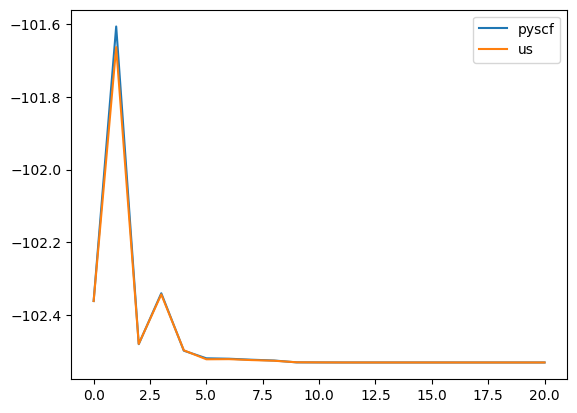

In [32]:
test_cases(our_fun=jax_scf, list=[51], verbose=True) # speed test 

In [ ]:
np.random.seed(42)

a = np.random.normal(0, 1, (4, 4))
a = a @ a.T
l = np.random.normal(0, 1, (4, 4))
b = l @ l.T

b_inv = np.linalg.inv(b)

vals, vects = scipy.linalg.eigh(a, b)
print(vals)
print(np.around(vects, 2))

L = np.linalg.cholesky(b)
assert np.allclose(L @ L.T, b)

vals, vects_ = scipy.linalg.eigh(a, l @ l.T)
assert np.allclose(vects, vects_)


l_inv = np.linalg.inv(l)

#vals, vects_ = scipy.linalg.eigh(l_inv @ a, l.T)
#assert np.allclose(vects, l @ vects_)


#vals, vects_ = scipy.linalg.eigh(np.linalg.inv(L) @ a, L.T)
#assert np.allclose(vects, L @ vects_, atol=10**(-5))

# a @ v = l * b @ v   =>
# a @ v = l * L @ L.T @ v 
# inv(L) @ a @ v = l * L.T @ v =>
# inv(L) @ a inv(L.T) @ L.T @ v = l * L.T @ v =>
# inv(L) @ a inv(L.T) @ z = l * z => where z = L.T @ v  => v = L.T.inv @ z
# so we may intead solve the above prolem 

vals2, vects2 = np.linalg.eigh( l_inv @ a @ l_inv.T )

print(vals2)
print(np.around(l_inv.T @ vects2, 2))

# now z = L.T @ v 

#https://www.jstor.org/stable/2949370





[4.83667839e-02 4.39166183e-01 1.18183761e+00 9.74664646e+01]
[[ 0.23  0.23  0.3  -2.07]
 [ 0.12 -0.7   0.01 -1.36]
 [ 0.54 -0.48 -0.21  3.28]
 [ 0.11 -0.2  -0.26 -3.21]]
[4.83667839e-02 4.39166183e-01 1.18183761e+00 9.74664646e+01]
[[ 0.23 -0.23 -0.3   2.07]
 [ 0.12  0.7  -0.01  1.36]
 [ 0.54  0.48  0.21 -3.28]
 [ 0.11  0.2   0.26  3.21]]


# Step 9: Refactor all the DIIS algorithm into a single place (instead of 10 different functions). Didn't simplify code, just refactor

|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
HeHe---0---
1 1 8
[-3.71696798e-01 -7.33848524e-01 -1.37735424e-04 -3.48606913e-03
 -7.33848524e-01]
4.799793123492619
---1---
2 2 8
[-3.67274563e-01 -7.31602576e-01  1.19258385e-04 -3.19713248e-03
 -7.31602576e-01]
5.2861225547928825e-06
---2---
3 3 8
[-3.67059214e-01 -7.31476722e-01  1.90855766e-04 -3.11711121e-03
 -7.31476722e-01]
1.2377032732047155e-09
---3---
4 4 8
[-3.67063061e-01 -7.31478827e-01  1.89992531e-04 -3.11794737e-03
 -7.31478827e-01]
4.602540570886049e-12
	 -5.79979841085748 47.014247912150616 0.3910048007965088
[-5.799793123445306, -5.799798061919506, -5.79979841081143, -5.7997984108116345]
[-5.799793123492619, -5.799798409615174, -5.799798410852877, -5.79979841085748]

|            HeHe |   -5.800 47.014 |   -5.800 47.014 |     0.000 0.000 |       47.014227 |          1.049626s |          0.391005s |
HeHeHe---0---
1 1 8
[-3.71906866e-01

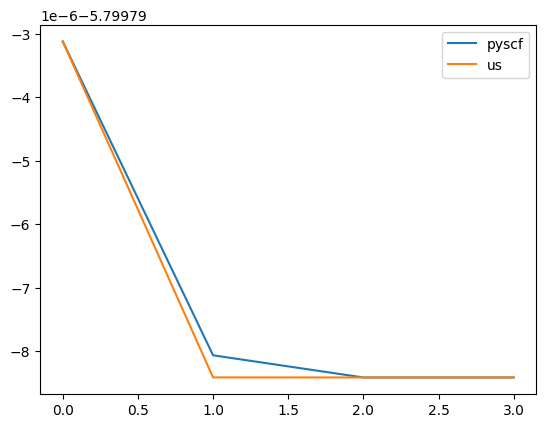

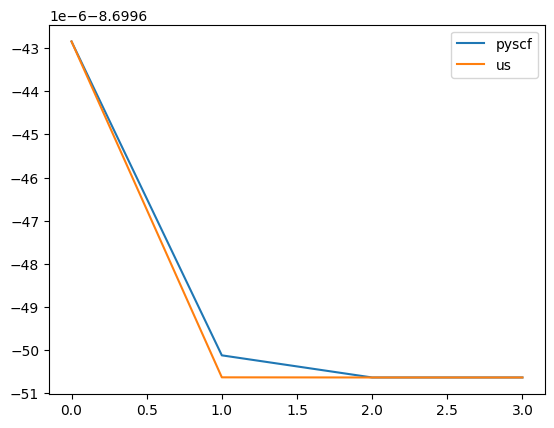

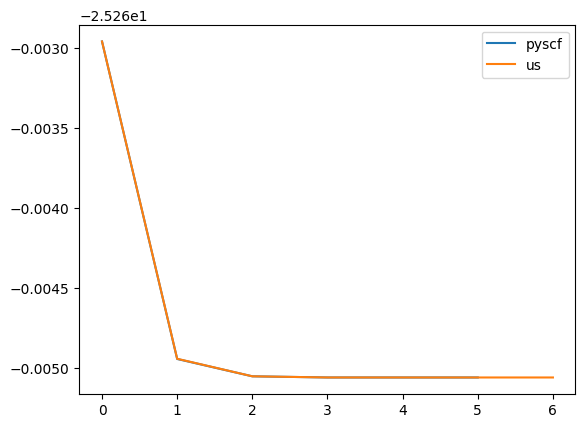

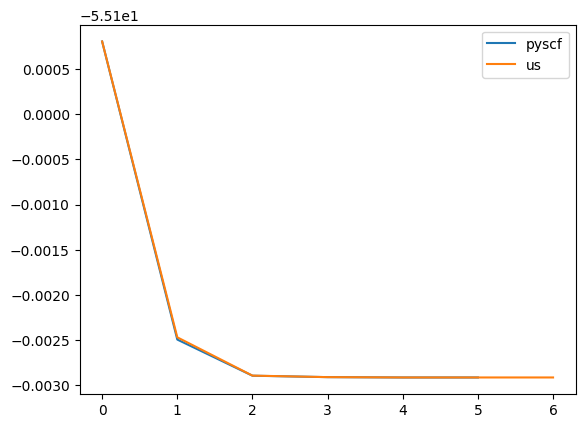

In [33]:
import textwrap
from tqdm import tqdm
import numpy
from pyscf import scf
from pyscf.scf import hf
from pyscf.scf import _vhf
from pyscf.scf import jk
from pyscf.dft import gen_grid
from pyscf.dft import numint
from pyscf import __config__
from pyscf import lib
from functools import reduce
import numpy
import scipy.linalg
import sys 
import tempfile
import h5py
from pyscf import gto
from pyscf.scf import diis
from pyscf.scf import _vhf
from pyscf.scf import chkfile
from pyscf.data import nist

def xc_and_coulomb(ks, mol=None, dm=None, dm_last=0, vhf_last=0, hermi=1):
    '''Coulomb + XC functional
    .. note::
        This function will modify the input ks object.
    Args:
        ks : an instance of :class:`RKS`
            XC functional are controlled by ks.xc attribute.  Attribute
            ks.grids might be initialized.
        dm : ndarray or list of ndarrays
            A density matrix or a list of density matrices
    Kwargs:
        dm_last : ndarray or a list of ndarrays or 0
            The density matrix baseline.  If not 0, this function computes the
            increment of HF potential w.r.t. the reference HF potential matrix.
        vhf_last : ndarray or a list of ndarrays or 0
            The reference Vxc potential matrix.
        hermi : int
            Whether J, K matrix is hermitian
            | 0 : no hermitian or symmetric
            | 1 : hermitian
            | 2 : anti-hermitian
    Returns:
        matrix Veff = J + Vxc.  Veff can be a list matrices, if the input
        dm is a list of density matrices.
    '''
    #if dm is None: dm = ks.make_rdm1()
    #ks.initialize_grids(mol, dm) # <-- only needs to be called once, and I think mol.build() does it? 

    ni            = ks._numint # numerical integrator, depends on xc functional! 
    max_memory    = ks.max_memory - lib.current_memory()[0]
    n, exc, vxc   = ni.nr_rks(mol, ks.grids, ks.xc, dm, max_memory=max_memory)

    #enabling range-separated hybrids
    omega, alpha, hyb = ni.rsh_and_hybrid_coeff(ks.xc, spin=mol.spin)

    if (ks._eri is None and ks.direct_scf and getattr(vhf_last, 'vk', None) is not None):
        ddm = numpy.asarray(dm) - numpy.asarray(dm_last)
        vj, vk = ks.get_jk(mol, ddm, hermi)
        vk *= hyb
        if abs(omega) > 1e-10:  # For range separated Coulomb operator
            vklr = ks.get_k(mol, ddm, hermi, omega=omega)
            vklr *= (alpha - hyb)
            vk += vklr
        vj += vhf_last.vj
        vk += vhf_last.vk
    else:
        vj, vk = ks.get_jk(mol, dm, hermi)
        vk *= hyb
        if abs(omega) > 1e-10:
            vklr = ks.get_k(mol, dm, hermi, omega=omega)
            vklr *= (alpha - hyb)
            vk += vklr
    vxc += vj - vk * .5

    exc   -= numpy.einsum('ij,ji', dm, vk).real * .5 * .5
    ecoul  = numpy.einsum('ij,ji', dm, vj).real * .5

    vxc = lib.tag_array(vxc, E_coulomb=ecoul, E_xc=exc, vj=vj, vk=vk)
    return vxc

#from pyscf.scf.diis import *

def get_err_vec(s, d, f):
    '''error vector = SDF - FDS'''
    if isinstance(f, numpy.ndarray) and f.ndim == 2:
        sdf = reduce(numpy.dot, (s,d,f))
        errvec = sdf.T.conj() - sdf

    elif isinstance(f, numpy.ndarray) and f.ndim == 3 and s.ndim == 3:
        errvec = []
        for i in range(f.shape[0]):
            sdf = reduce(numpy.dot, (s[i], d[i], f[i]))
            errvec.append((sdf.T.conj() - sdf))
        errvec = numpy.vstack(errvec)

    elif f.ndim == s.ndim+1 and f.shape[0] == 2:  # for UHF
        nao = s.shape[-1]
        s = lib.asarray((s,s)).reshape(-1,nao,nao)
        return get_err_vec(s, d.reshape(s.shape), f.reshape(s.shape))
    else:
        raise RuntimeError('Unknown SCF DIIS type')
    return errvec


from pyscf.lib import misc

class CDIIS(lib.diis.DIIS):
    def __init__(self, mf=None, filename=None):
        lib.diis.DIIS.__init__(self, mf, filename)
        self.rollback = False
        self.space = 8

    def update(self, s, d, f, *args, **kwargs):
        errvec = get_err_vec(s, d, f)
        xnew = lib.diis.DIIS.update(self, f, xerr=errvec)
        if self.rollback > 0 and len(self._bookkeep) == self.space:
            self._bookkeep = self._bookkeep[-self.rollback:]
        return xnew

    def get_num_vec(self):
        if self.rollback:
            return self._head
        else:
            return len(self._bookkeep)

def push_err_vec(self, xerr):
    self._err_vec_touched = True
    if self._head >= self.space:
        self._head = 0
    key = 'e%d' % self._head
    self._store(key, xerr.ravel())

def push_vec(self, x):
    x = x.ravel()

    while len(self._bookkeep) >= self.space:
        self._bookkeep.pop(0)

    if self._err_vec_touched:
        self._bookkeep.append(self._head)
        key = 'x%d' % (self._head)
        self._store(key, x)
        self._head += 1

    elif self._xprev is None:
        # If push_err_vec is not called in advance, the error vector is generated
        # as the diff of the current vec and previous returned vec (._xprev)
        # So store the first trial vec as the previous returned vec
        self._xprev = x
        self._store('xprev', x)
        if 'xprev' not in self._buffer:  # not incore
            self._xprev = self._diisfile['xprev']

    else:
        if self._head >= self.space:
            self._head = 0
        self._bookkeep.append(self._head)
        ekey = 'e%d'%self._head
        xkey = 'x%d'%self._head
        self._store(xkey, x)
        if x.size < INCORE_SIZE or self.incore:
            self._store(ekey, x - numpy.asarray(self._xprev))
        else:  # not call _store to reduce memory footprint
            if ekey not in self._diisfile:
                self._diisfile.create_dataset(ekey, (x.size,), x.dtype)
            edat = self._diisfile[ekey]
            for p0, p1 in misc.prange(0, x.size, BLOCK_SIZE):
                edat[p0:p1] = x[p0:p1] - self._xprev[p0:p1]
            self._diisfile.flush()
        self._head += 1

def get_err_vec(self, idx):
    if self._buffer:
        return self._buffer['e%d'%idx]
    else:
        return self._diisfile['e%d'%idx]

def get_vec(self, idx):
    if self._buffer:
        return self._buffer['x%d'%idx]
    else:
        return self._diisfile['x%d'%idx]

def get_num_vec(self):
    return len(self._bookkeep)

BLOCK_SIZE  = getattr(__config__, 'lib_diis_block_size', 20000000)
def update(self, x, xerr):
    push_err_vec(self, xerr)   # <--- refactor 
    push_vec(self, x)          # <--- refactor 

    nd = get_num_vec(self)   # <---refactor 
    # self.get_err_vec 

    dt = numpy.array(get_err_vec(self, self._head-1), copy=False) # <--- refactor 
    if self._H is None:
        self._H = numpy.zeros((self.space+1,self.space+1), dt.dtype)
        self._H[0,1:] = self._H[1:,0] = 1

    for i in range(nd):
        tmp = 0
        dti = get_err_vec(self, i)
        for p0, p1 in misc.prange(0, dt.size, BLOCK_SIZE):
            tmp += numpy.dot(dt[p0:p1].conj(), dti[p0:p1])
        self._H[self._head,i+1] = tmp
        self._H[i+1,self._head] = tmp.conjugate()
    dt = None

    xnew = extrapolate(self, nd) # <--- refactor 

    return xnew.reshape(x.shape)

from pyscf.dft.numint import _rks_gga_wv0, _scale_ao, _dot_ao_ao

def nr_rks(ni, mol, grids, xc_code, dms, relativity=0, hermi=1, max_memory=2000, verbose=None): # this one supports all xcs 
    '''Calculate RKS XC functional and potential matrix on given meshgrids
    for a set of density matrices
    Args:
        ni : an instance of :class:`NumInt`
        mol : an instance of :class:`Mole`
        grids : an instance of :class:`Grids`
            grids.coords and grids.weights are needed for coordinates and weights of meshgrids.
        xc_code : str
            XC functional description.
            See :func:`parse_xc` of pyscf/dft/libxc.py for more details.
        dms : 2D array or a list of 2D arrays
            Density matrix or multiple density matrices
    Kwargs:
        hermi : int
            Input density matrices symmetric or not. It also indicates whether
            the potential matrices in return are symmetric or not.
        max_memory : int or float
            The maximum size of cache to use (in MB).
    Returns:
        nelec, excsum, vmat.
        nelec is the number of electrons generated by numerical integration.
        excsum is the XC functional value.  vmat is the XC potential matrix in
        2D array of shape (nao,nao) where nao is the number of AO functions.
    Examples:
    >>> from pyscf import gto, dft
    >>> mol = gto.M(atom='H 0 0 0; H 0 0 1.1')
    >>> grids = dft.gen_grid.Grids(mol)
    >>> grids.coords = numpy.random.random((100,3))  # 100 random points
    >>> grids.weights = numpy.random.random(100)
    >>> nao = mol.nao_nr()
    >>> dm = numpy.random.random((nao,nao))
    >>> ni = dft.numint.NumInt()
    >>> nelec, exc, vxc = ni.nr_rks(mol, grids, 'lda,vwn', dm)
    '''
    xctype = ni._xc_type(xc_code)
    make_rho, nset, nao = ni._gen_rho_evaluator(mol, dms, hermi)

    shls_slice = (0, mol.nbas)
    ao_loc = mol.ao_loc_nr()

    nelec = numpy.zeros(nset)
    excsum = numpy.zeros(nset)
    if isinstance(dms, numpy.ndarray):
        vmat = numpy.zeros((nset,nao,nao), dtype=dms.dtype)
    else:
        vmat = numpy.zeros((nset,nao,nao), dtype=numpy.result_type(*dms))

    def block_loop(ao_deriv):
        for ao, mask, weight, coords \
                in ni.block_loop(mol, grids, nao, ao_deriv, max_memory=max_memory):
            for i in range(nset):
                rho = make_rho(i, ao, mask, xctype)
                exc, vxc = ni.eval_xc(xc_code, rho, spin=0,
                                      relativity=relativity, deriv=1,
                                      verbose=verbose)[:2]
                if xctype == 'LDA':
                    den = rho * weight
                else:
                    den = rho[0] * weight
                nelec[i] += den.sum()
                excsum[i] += numpy.dot(den, exc)
                yield i, rho, ao, mask, weight, vxc

    aow = None
    if xctype == 'LDA':
        ao_deriv = 0
        for i, rho, ao, mask, weight, vxc in block_loop(ao_deriv):
            vrho = vxc[0]
            # *.5 because vmat + vmat.T
            #:aow = numpy.einsum('pi,p->pi', ao, .5*weight*vrho, out=aow)
            aow = _scale_ao(ao, .5*weight*vrho, out=aow)
            vmat[i] += _dot_ao_ao(mol, ao, aow, mask, shls_slice, ao_loc)

    elif xctype == 'GGA':
        ao_deriv = 1
        for i, rho, ao, mask, weight, vxc in block_loop(ao_deriv):
            wv = _rks_gga_wv0(rho, vxc, weight)
            #:aow = numpy.einsum('npi,np->pi', ao, wv, out=aow)
            aow = _scale_ao(ao, wv, out=aow)
            vmat[i] += _dot_ao_ao(mol, ao[0], aow, mask, shls_slice, ao_loc)

    elif xctype == 'NLC':
        nlc_pars = ni.nlc_coeff(xc_code)
        ao_deriv = 1
        vvrho=numpy.empty([nset,4,0])
        vvweight=numpy.empty([nset,0])
        vvcoords=numpy.empty([nset,0,3])
        for ao, mask, weight, coords \
                in ni.block_loop(mol, grids, nao, ao_deriv, max_memory=max_memory):
            rhotmp = numpy.empty([0,4,weight.size])
            weighttmp = numpy.empty([0,weight.size])
            coordstmp = numpy.empty([0,weight.size,3])
            for idm in range(nset):
                rho = make_rho(idm, ao, mask, 'GGA')
                rho = numpy.expand_dims(rho,axis=0)
                rhotmp = numpy.concatenate((rhotmp,rho),axis=0)
                weighttmp = numpy.concatenate((weighttmp,numpy.expand_dims(weight,axis=0)),axis=0)
                coordstmp = numpy.concatenate((coordstmp,numpy.expand_dims(coords,axis=0)),axis=0)
                rho = None
            vvrho=numpy.concatenate((vvrho,rhotmp),axis=2)
            vvweight=numpy.concatenate((vvweight,weighttmp),axis=1)
            vvcoords=numpy.concatenate((vvcoords,coordstmp),axis=1)
            rhotmp = weighttmp = coordstmp = None
        for ao, mask, weight, coords \
                in ni.block_loop(mol, grids, nao, ao_deriv, max_memory=max_memory):
            aow = numpy.ndarray(ao[0].shape, order='F', buffer=aow)
            for i in range(nset):
                rho = make_rho(i, ao, mask, 'GGA')
                exc, vxc = _vv10nlc(rho, coords, vvrho[i], vvweight[i], vvcoords[i], nlc_pars)
                den = rho[0] * weight
                nelec[i] += den.sum()
                excsum[i] += numpy.dot(den, exc)
                wv = _rks_gga_wv0(rho, vxc, weight)
                #:aow = numpy.einsum('npi,np->pi', ao, wv, out=aow)
                aow = _scale_ao(ao, wv, out=aow)
                vmat[i] += _dot_ao_ao(mol, ao[0], aow, mask, shls_slice, ao_loc)
        vvrho = vvweight = vvcoords = None

    elif xctype == 'MGGA':
        if (any(x in xc_code.upper() for x in ('CC06', 'CS', 'BR89', 'MK00'))):
            raise NotImplementedError('laplacian in meta-GGA method')
        ao_deriv = 2 if MGGA_DENSITY_LAPL else 1
        for i, rho, ao, mask, weight, vxc in block_loop(ao_deriv):
            wv = _rks_mgga_wv0(rho, vxc, weight)
            #:aow = numpy.einsum('npi,np->pi', ao[:4], wv, out=aow)
            aow = _scale_ao(ao[:4], wv[:4], out=aow)
            vmat[i] += _dot_ao_ao(mol, ao[0], aow, mask, shls_slice, ao_loc)
            vmat[i] += _tau_dot(mol, ao, ao, wv[5], mask, shls_slice, ao_loc)

    elif xctype == 'HF':
        pass
    else:
        raise NotImplementedError(f'numint.nr_uks for functional {xc_code}')

    for i in range(nset):
        vmat[i] = vmat[i] + vmat[i].conj().T
    if nset == 1:
        nelec = nelec[0]
        excsum = excsum[0]
        vmat = vmat[0]
    return nelec, excsum, vmat

def extrapolate(self, nd=None):
  if nd is None:
      nd = self.get_num_vec()
  if nd == 0:
      raise RuntimeError('No vector found in DIIS object.')

  h = self._H[:nd+1,:nd+1]
  g = numpy.zeros(nd+1, h.dtype)
  g[0] = 1

  w, v = scipy.linalg.eigh(h)
  if numpy.any(abs(w)<1e-14):
      #logger.debug(self, 'Linear dependence found in DIIS error vectors.')
      idx = abs(w)>1e-14
      c = numpy.dot(v[:,idx]*(1./w[idx]), numpy.dot(v[:,idx].T.conj(), g))
  else:
      try:
          c = numpy.linalg.solve(h, g)
      except numpy.linalg.linalg.LinAlgError as e:
          logger.warn(self, ' diis singular, eigh(h) %s', w)
          raise e

  xnew = None
  for i, ci in enumerate(c[1:]):
      xi = self.get_vec(i)
      if xnew is None:
          xnew = numpy.zeros(xi.size, c.dtype)
      for p0, p1 in misc.prange(0, xi.size, BLOCK_SIZE):
          xnew[p0:p1] += xi[p0:p1] * ci
  return xnew

def nr_rks_only_GGA(ni, mol, grids, xc_code, dms, relativity=0, hermi=1, max_memory=2000, verbose=None): # this one supports all xcs 
    xctype = ni._xc_type(xc_code)
    make_rho, nset, nao = ni._gen_rho_evaluator(mol, dms, hermi)

    shls_slice = (0, mol.nbas)
    ao_loc = mol.ao_loc_nr()

    nelec = numpy.zeros(nset)
    excsum = numpy.zeros(nset)
    if isinstance(dms, numpy.ndarray):
        vmat = numpy.zeros((nset,nao,nao), dtype=dms.dtype)
    else:
        vmat = numpy.zeros((nset,nao,nao), dtype=numpy.result_type(*dms))

    def block_loop(ao_deriv):
        for ao, mask, weight, coords \
                in ni.block_loop(mol, grids, nao, ao_deriv, max_memory=max_memory):
            for i in range(nset):
                rho = make_rho(i, ao, mask, xctype)
                exc, vxc = ni.eval_xc(xc_code, rho, spin=0,
                                      relativity=relativity, deriv=1,
                                      verbose=verbose)[:2]
                if xctype == 'LDA':
                    den = rho * weight
                else:
                    den = rho[0] * weight
                nelec[i] += den.sum()
                excsum[i] += numpy.dot(den, exc)
                yield i, rho, ao, mask, weight, vxc

    aow = None

    ao_deriv = 1
    for i, rho, ao, mask, weight, vxc in block_loop(ao_deriv):
        wv = _rks_gga_wv0(rho, vxc, weight)
        aow = _scale_ao(ao, wv, out=aow)
        vmat[i] += _dot_ao_ao(mol, ao[0], aow, mask, shls_slice, ao_loc)

    for i in range(nset):
        vmat[i] = vmat[i] + vmat[i].conj().T
    if nset == 1:
        nelec = nelec[0]
        excsum = excsum[0]
        vmat = vmat[0]
    return nelec, excsum, vmat

class RKS(): # moved everything into one class! i.e. removed inheritance dependency 

    DIIS = CDIIS #diis.SCF_DIIS # Direct inversion in the iterative subspace DIIS. 

    diis = getattr(__config__, 'scf_hf_SCF_diis', True)
    diis_space = getattr(__config__, 'scf_hf_SCF_diis_space', 8)
    # need > 0 if initial DM is numpy.zeros array
    diis_start_cycle = getattr(__config__, 'scf_hf_SCF_diis_start_cycle', 1)
    diis_file = None
    # Give diis_space_rollback=True a trial if all other methods do not converge
    diis_space_rollback = False

    damp            = getattr(__config__, 'scf_hf_SCF_damp', 0)
    level_shift     = getattr(__config__, 'scf_hf_SCF_level_shift', 0)
    direct_scf      = getattr(__config__, 'scf_hf_SCF_direct_scf', True)
    direct_scf_tol  = getattr(__config__, 'scf_hf_SCF_direct_scf_tol', 1e-13)

    def __init__(self, mol, xc='LDA,VWN'):

        self.mol = mol
        self.verbose = mol.verbose
        self.max_memory = mol.max_memory
        self.stdout = mol.stdout

        self.opt = None
        self._eri = None # Note: self._eri requires large amount of memory
        
        self.xc = xc
        self.nlc = ''
        self.grids = gen_grid.Grids(self.mol)
        self.grids.level = getattr(__config__, 'dft_rks_RKS_grids_level',
                                self.grids.level)
        self.nlcgrids = gen_grid.Grids(self.mol)
        self.nlcgrids.level = getattr(__config__, 'dft_rks_RKS_nlcgrids_level',
                                    self.nlcgrids.level)
        # Use rho to filter grids
        self.small_rho_cutoff = getattr(__config__, 'dft_rks_RKS_small_rho_cutoff', 1e-7)
        self._numint = numint.NumInt()
        self.max_cycle = 50


    def get_jk(self, mol=None, dm=None, hermi=1, with_j=True, with_k=True,
               omega=None):
        if mol is None: mol = self.mol
        if dm is None: dm = self.make_rdm1()
        if self.direct_scf and self.opt is None:
            self.opt = self.init_direct_scf(mol)

        if with_j and with_k:
            vj, vk = hf.get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)
        else:
            if with_j:
                prescreen = 'CVHFnrs8_vj_prescreen'
            else:
                prescreen = 'CVHFnrs8_vk_prescreen'
            with lib.temporary_env(self.opt, prescreen=prescreen):
                vj, vk = get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)

        return vj, vk

    def get_j(self, mol=None, dm=None, hermi=1, omega=None):
        '''Compute J matrices for all input density matrices
        '''
        return self.get_jk(mol, dm, hermi, with_k=False, omega=omega)[0]

    def get_k(self, mol=None, dm=None, hermi=1, omega=None):
        '''Compute K matrices for all input density matrices '''
        return self.get_jk(mol, dm, hermi, with_j=False, omega=omega)[1]

    def init_direct_scf(self, mol=None):
        # Integrals < direct_scf_tol may be set to 0 in int2e.
        # Higher accuracy is required for Schwartz inequality prescreening.
        with mol.with_integral_screen(self.direct_scf_tol**2):
            opt = _vhf.VHFOpt(mol, 'int2e', 'CVHFnrs8_prescreen',
                              'CVHFsetnr_direct_scf',
                              'CVHFsetnr_direct_scf_dm')
            opt.direct_scf_tol = self.direct_scf_tol
        return opt

    def kernel(self, convergence_tolerance=1e-10): 
      mol       = self.mol
      e_tot     = -1  
      converged = False

      # Init Stuff 
      dm              = hf.init_guess_by_minao(mol)         # <-- a few hundred lines of code in hf.py  (4, 4)
      V_xc            = xc_and_coulomb(self, mol, dm)       # <--- Coulomb + XC functional (this is the part that changes)  (4, 4)
      h1e             = mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc') # <--- gets fixed part of hamiltonian which doesn't change (4, 4)
      
      # Initial code solve generalized eigen problem scipy.linalg.eigh( A, B )
      # We turn this into normal eig problem scipy.linalg.eigh(L_inv@B@Linv.T) where LL.T = B is cholesky(B)
      s1e   = mol.intor_symmetric('int1e_ovlp')             # <-- overlap matrix;; is this electron by electonr? dont think so (4, 4) ;; we add it to the generalized eigensolver? 
      L     = np.linalg.cholesky(s1e)
      L_inv = np.linalg.inv(L)

      nuclear_energy  = mol.energy_nuc()
      n_electrons     = mol.nelectron

      mf_diis           = self.DIIS(self)
      mf_diis.space     = self.diis_space
      mf_diis.rollback  = self.diis_space_rollback

      #e_idx   = numpy.argsort(mo_energy)
      e_idx                           = np.arange(V_xc.shape[0])
      mo_occ                          = numpy.zeros(V_xc.shape[0])
      mo_occ[e_idx[:n_electrons//2]]  = 2 
      mo_occ_nnz                      = mo_occ[mo_occ>0] 

      #pbar = tqdm(range(self.max_cycle))

      # four pain points
      # mf_diis.update
      # eigh(a, b) -> eigh(b_inv, a)

      # five things left to refactor
      energies = []

      #for cycle in pbar:
      for cycle in range(self.max_cycle):
          print("---%i---"%cycle)
          dm_last           = dm        
          last_hf_e         = e_tot

          hamiltonian       = h1e + V_xc

          # Improve using DIIS --> https://en.wikipedia.org/wiki/DIIS 
          # ============ DIIS =============== #
          sdf               = s1e @ dm @ hamiltonian
          errvec            = sdf.T.conj() - sdf
          #hamiltonian       = update(mf_diis, hamiltonian, xerr=errvec)   # <-----  DONE 

          #push_err_vec(mf_diis, errvec)           # <--- refactor  DONE
          mf_diis._err_vec_touched = True
          if mf_diis._head >= mf_diis.space:
              mf_diis._head = 0
          key = 'e%d'%mf_diis._head
          mf_diis._store(key, errvec.ravel())

          #push_vec(mf_diis, hamiltonian)            # <--- refactor  DONE 
          x = hamiltonian.ravel()

          while len(mf_diis._bookkeep) >= mf_diis.space:
              print("_--")
              print(mf_diis._bookkeep)
              mf_diis._bookkeep.pop(0)

          if mf_diis._err_vec_touched:
              mf_diis._bookkeep.append(mf_diis._head)
              key = 'x%d' % (mf_diis._head)
              mf_diis._store(key, x)
              mf_diis._head += 1

          elif mf_diis._xprev is None:
              # If push_err_vec is not called in advance, the error vector is generated
              # as the diff of the current vec and previous returned vec (._xprev)
              # So store the first trial vec as the previous returned vec
              mf_diis._xprev = x
              mf_diis._store('xprev', x)
              if 'xprev' not in mf_diis._buffer:  # not incore
                  mf_diis._xprev = mf_diis._diisfile['xprev']

          else:
              if mf_diis._head >= mf_diis.space:
                  mf_diis._head = 0
              mf_diis._bookkeep.append(mf_diis._head)
              ekey = 'e%d'%mf_diis._head
              xkey = 'x%d'%mf_diis._head
              mf_diis._store(xkey, x)
              INCORE_SIZE = getattr(__config__, 'lib_diis_incore_size', 10000000) 
              if x.size < INCORE_SIZE or mf_diis.incore:
                  mf_diis._store(ekey, x - numpy.asarray(mf_diis._xprev))
              else:  # not call _store to reduce memory footprint
                  if ekey not in mf_diis._diisfile:
                      mf_diis._diisfile.create_dataset(ekey, (x.size,), x.dtype)
                  edat = mf_diis._diisfile[ekey]
                  for p0, p1 in misc.prange(0, x.size, BLOCK_SIZE):
                      edat[p0:p1] = x[p0:p1] - mf_diis._xprev[p0:p1]
                  mf_diis._diisfile.flush()
              mf_diis._head += 1


          #nd = get_num_vec(mf_diis)   # <---refactor 
          nd = len(mf_diis._bookkeep) #get_num_vec(mf_diis)   # <---refactor  DONE 

          print(nd, mf_diis._head, mf_diis.space)
          # self.get_err_vec 

          #dt = numpy.array(get_err_vec(mf_diis, mf_diis._head-1), copy=False) # <--- refactor  DONE 
          if mf_diis._buffer: 
            dt = np.array(mf_diis._buffer['e%d'%(mf_diis._head-1)])
          else: 
            dt = np.array(mf_diis._diisfile['e%d'%(mf_diis._head-1)])

          
          if mf_diis._H is None:
              mf_diis._H = numpy.zeros((mf_diis.space+1,mf_diis.space+1), dt.dtype)
              mf_diis._H[0,1:] = mf_diis._H[1:,0] = 1

          for i in range(nd):
              tmp = 0
              #dti = get_err_vec(mf_diis, i) # <--- refactor  done 
              if mf_diis._buffer:   dti = np.array(mf_diis._buffer['e%d'%(i)])
              else:  dti = np.array(mf_diis._diisfile['e%d'%(i)])

              for p0, p1 in misc.prange(0, dt.size, BLOCK_SIZE):
                  tmp += numpy.dot(dt[p0:p1].conj(), dti[p0:p1])
              
              #print(mf_diis._h.shape, mf_diis._head, i+1, nd)

              mf_diis._H[mf_diis._head,i+1] = tmp
              mf_diis._H[i+1,mf_diis._head] = tmp.conjugate()
          dt = None

          #hamiltonian = extrapolate(mf_diis, nd).reshape(hamiltonian.shape) # <--- refactor  DONE 
          h = mf_diis._H[:nd+1,:nd+1]
          g = numpy.zeros(nd+1, h.dtype)
          g[0] = 1

          w, v = scipy.linalg.eigh(h)
          if numpy.any(abs(w)<1e-14):
              idx = abs(w)>1e-14
              c = numpy.dot(v[:,idx]*(1./w[idx]), numpy.dot(v[:,idx].T.conj(), g))
          else:
              c = numpy.linalg.solve(h, g)

          xnew = None
          for i, ci in enumerate(c[1:]):
              #xi = self.get_vec(i) # <--- refactor  DONE 
              if mf_diis._buffer: xi = mf_diis._buffer['x%d'%i]
              else:               xi = mf_diis._diisfile['x%d'%i]
              if xnew is None:
                  xnew = numpy.zeros(xi.size, c.dtype)
              for p0, p1 in misc.prange(0, xi.size, BLOCK_SIZE):
                  xnew[p0:p1] += xi[p0:p1] * ci
          hamiltonian = xnew.reshape(hamiltonian.shape)
          print(hamiltonian.reshape(-1)[:5])


          # Solve generalized eigenproblem using normal eigh solver using this trick: https://www.jstor.org/stable/2949370
          eigvals, eigvects = np.linalg.eigh(L_inv @ hamiltonian @ L_inv.T)  
          eigvects          = L_inv.T @ eigvects 

          # Reconstruct density matrix using eigenvectors. 
          dm                = (eigvects[:, mo_occ>0] * mo_occ_nnz) @ eigvects[:, mo_occ>0].T 

          # This is the part that changes each iteration. 
          # It computes both coulomb stuff and XC. 
          if True: 
            vhf_last      = V_xc 

            #n, E_xc, V_xc     = self._numint.nr_rks(mol, self.grids, self.xc, dm) 
            n, E_xc, V_xc     = nr_rks_only_GGA(self._numint, mol, self.grids, self.xc, dm)  # <----- 
            omega, alpha, hyb = self._numint.rsh_and_hybrid_coeff(self.xc, spin=mol.spin) # <----- 

            vj, vk = self.get_jk(mol, dm - dm_last, hermi=True) # <----- 
            vk    *= hyb
            vj    += vhf_last.vj
            vk    += vhf_last.vk

            V_xc += vj - vk * .5

            #E_xc      = E_xc - numpy.einsum('ij,ji', dm, vk) * .5 * .5
            E_xc      = E_xc - np.sum(dm* vk.T) * .5 * .5
            #E_coulomb = numpy.einsum('ij,ji', dm, vj) * .5
            E_coulomb = np.sum(dm*vj.T) * .5

            V_xc = lib.tag_array(V_xc, E_coulomb=E_coulomb, E_xc=E_xc, vj=vj, vk=vk) # <---- 

          # Compute energy. Currently only used to check for convergence. 
          #e_tot =  numpy.einsum('ij,ji->', h1e, dm) + E_coulomb + E_xc + nuclear_energy
          e_tot =  np.sum(h1e*dm.T) + E_coulomb + E_xc + nuclear_energy

          #pbar.set_description("E=%4f change=%4e tolerance=%4e"%(e_tot, abs(e_tot-last_hf_e), convergence_tolerance))
          print(abs(e_tot-last_hf_e))

          energies.append(e_tot)

          if abs(e_tot-last_hf_e) < convergence_tolerance:
              converged = True
              break

      self.converged, self.e_tot,  self.mo_energy, self.mo_coeff, self.mo_occ =  converged, e_tot, eigvals, eigvects, mo_occ
      return self.e_tot , energies


def jax_scf(str):
  basis_set ="6-31G*"
  xc_fun    ="b3lyp"

  # So PCQ uses eV and PySCF uses Hartree 
  eV_to_hartree    = 0.0367493
  hartree_to_eV    = 27.2114
  angstrom_to_bohr = 1.88973

  from pyscf.gto import mole  # <--- this file is 2000 lines of code
  mol = mole.Mole()
  mol.build(atom=str, unit="Bohr", basis=basis_set)

  mol.verbose = 0 
  mf  = RKS(mol) 
  mf.xc = xc_fun 
  t0 = time.time()
  energy, energies = mf.kernel()
  time_us = time.time() - t0 

  lumo = np.argmin(mf.mo_occ)
  homo = lumo - 1
  hl_gap_hartree = np.abs(mf.mo_energy[homo] - mf.mo_energy[lumo])
  hlgap = hartree_to_eV*hl_gap_hartree
  return energy, hlgap , time_us, energies

#test_cases(our_fun=jax_scf, list=[0, -1]) 
#test_cases(our_fun=jax_scf) 
#test_cases(our_fun=jax_scf, list=[12], verbose=True) 
#test_cases(our_fun=jax_scf, verbose=True)

#test_cases(our_fun=jax_scf, list=[51], verbose=True) 
test_cases(our_fun=jax_scf, list=[0,1,2,3], verbose=True) 


In [ ]:
mf_diis._err_vec_touched = True
if mf_diis._head >= mf_diis.space:
    mf_diis._head = 0
key = 'e%d'%mf_diis._head
mf_diis._store(key, errvec.ravel())

x = hamiltonian.ravel()

while len(mf_diis._bookkeep) >= mf_diis.space:
    print("_--")
    print(mf_diis._bookkeep)
    mf_diis._bookkeep.pop(0)

if mf_diis._err_vec_touched:
    mf_diis._bookkeep.append(mf_diis._head)
    key = 'x%d' % (mf_diis._head)
    mf_diis._store(key, x)
    mf_diis._head += 1

elif mf_diis._xprev is None:
    # If push_err_vec is not called in advance, the error vector is generated
    # as the diff of the current vec and previous returned vec (._xprev)
    # So store the first trial vec as the previous returned vec
    mf_diis._xprev = x
    mf_diis._store('xprev', x)
    if 'xprev' not in mf_diis._buffer:  # not incore
        mf_diis._xprev = mf_diis._diisfile['xprev']

else:
    if mf_diis._head >= mf_diis.space:
        mf_diis._head = 0
    mf_diis._bookkeep.append(mf_diis._head)
    ekey = 'e%d'%mf_diis._head
    xkey = 'x%d'%mf_diis._head
    mf_diis._store(xkey, x)
    INCORE_SIZE = getattr(__config__, 'lib_diis_incore_size', 10000000) 
    if x.size < INCORE_SIZE or mf_diis.incore:
        mf_diis._store(ekey, x - numpy.asarray(mf_diis._xprev))
    else:  # not call _store to reduce memory footprint
        if ekey not in mf_diis._diisfile:
            mf_diis._diisfile.create_dataset(ekey, (x.size,), x.dtype)
        edat = mf_diis._diisfile[ekey]
        for p0, p1 in misc.prange(0, x.size, BLOCK_SIZE):
            edat[p0:p1] = x[p0:p1] - mf_diis._xprev[p0:p1]
        mf_diis._diisfile.flush()
    mf_diis._head += 1


nd = len(mf_diis._bookkeep) 

if mf_diis._buffer: 
  dt = np.array(mf_diis._buffer['e%d'%(mf_diis._head-1)])
else: 
  dt = np.array(mf_diis._diisfile['e%d'%(mf_diis._head-1)])


if mf_diis._H is None:
    mf_diis._H = numpy.zeros((mf_diis.space+1,mf_diis.space+1), dt.dtype)
    mf_diis._H[0,1:] = mf_diis._H[1:,0] = 1

for i in range(nd):
    tmp = 0
    if mf_diis._buffer:   dti = np.array(mf_diis._buffer['e%d'%(i)])
    else:  dti = np.array(mf_diis._diisfile['e%d'%(i)])

    for p0, p1 in misc.prange(0, dt.size, BLOCK_SIZE):
        tmp += numpy.dot(dt[p0:p1].conj(), dti[p0:p1])
    
    mf_diis._H[mf_diis._head,i+1] = tmp
    mf_diis._H[i+1,mf_diis._head] = tmp.conjugate()
dt = None

h = mf_diis._H[:nd+1,:nd+1]
g = numpy.zeros(nd+1, h.dtype)
g[0] = 1

w, v = scipy.linalg.eigh(h)
if numpy.any(abs(w)<1e-14):
    idx = abs(w)>1e-14
    c = numpy.dot(v[:,idx]*(1./w[idx]), numpy.dot(v[:,idx].T.conj(), g))
else:
    c = numpy.linalg.solve(h, g)

xnew = None
for i, ci in enumerate(c[1:]):
    if mf_diis._buffer: xi = mf_diis._buffer['x%d'%i]
    else:               xi = mf_diis._diisfile['x%d'%i]
    if xnew is None:
        xnew = numpy.zeros(xi.size, c.dtype)
    for p0, p1 in misc.prange(0, xi.size, BLOCK_SIZE):
        xnew[p0:p1] += xi[p0:p1] * ci
hamiltonian = xnew.reshape(hamiltonian.shape)


# Step 10: Simplify DIIS algorithm  [ scf iterations agrees ]

|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
HeHe(8, 16) (8, 16)
---0---
4.799793123492618
---1---
5.286122557457418e-06
---2---
1.2377014968478761e-09
---3---
4.603428749305749e-12
	 -5.7997984108574805 47.01424791215058 0.2388625144958496
>pyscf
[-5.799793123445306, -5.7997980619195095, -5.7997984108114276, -5.799798410811632]
>us
[-5.799793123492618, -5.799798409615176, -5.799798410852877, -5.7997984108574805]

|            HeHe |   -5.800 47.014 |   -5.800 47.014 |     0.000 0.000 |       47.014227 |          1.119988s |          0.238863s |


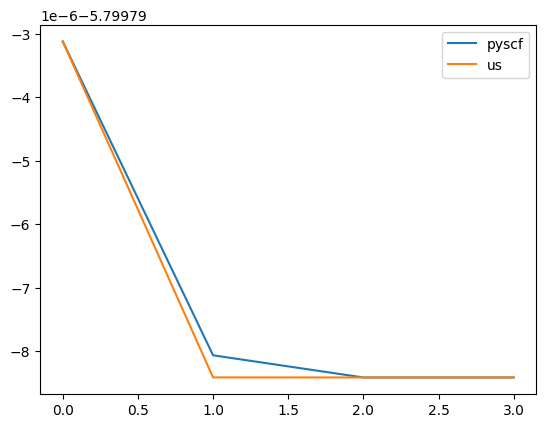

In [6]:

import textwrap
from tqdm import tqdm
import numpy
from pyscf import scf
from pyscf.scf import hf
from pyscf.scf import _vhf
from pyscf.scf import jk
from pyscf.dft import gen_grid
from pyscf.dft import numint
from pyscf import __config__
from pyscf import lib
from functools import reduce
import numpy
import scipy.linalg
import sys 
import tempfile
import h5py
from pyscf import gto
from pyscf.scf import diis
from pyscf.scf import _vhf
from pyscf.scf import chkfile
from pyscf.data import nist

def xc_and_coulomb(ks, mol=None, dm=None, dm_last=0, vhf_last=0, hermi=1):
    '''Coulomb + XC functional
    .. note::
        This function will modify the input ks object.
    Args:
        ks : an instance of :class:`RKS`
            XC functional are controlled by ks.xc attribute.  Attribute
            ks.grids might be initialized.
        dm : ndarray or list of ndarrays
            A density matrix or a list of density matrices
    Kwargs:
        dm_last : ndarray or a list of ndarrays or 0
            The density matrix baseline.  If not 0, this function computes the
            increment of HF potential w.r.t. the reference HF potential matrix.
        vhf_last : ndarray or a list of ndarrays or 0
            The reference Vxc potential matrix.
        hermi : int
            Whether J, K matrix is hermitian
            | 0 : no hermitian or symmetric
            | 1 : hermitian
            | 2 : anti-hermitian
    Returns:
        matrix Veff = J + Vxc.  Veff can be a list matrices, if the input
        dm is a list of density matrices.
    '''
    #if dm is None: dm = ks.make_rdm1()
    #ks.initialize_grids(mol, dm) # <-- only needs to be called once, and I think mol.build() does it? 

    ni            = ks._numint # numerical integrator, depends on xc functional! 
    max_memory    = ks.max_memory - lib.current_memory()[0]
    n, exc, vxc   = ni.nr_rks(mol, ks.grids, ks.xc, dm, max_memory=max_memory)

    #enabling range-separated hybrids
    omega, alpha, hyb = ni.rsh_and_hybrid_coeff(ks.xc, spin=mol.spin)

    if (ks._eri is None and ks.direct_scf and getattr(vhf_last, 'vk', None) is not None):
        ddm = numpy.asarray(dm) - numpy.asarray(dm_last)
        vj, vk = ks.get_jk(mol, ddm, hermi)
        vk *= hyb
        if abs(omega) > 1e-10:  # For range separated Coulomb operator
            vklr = ks.get_k(mol, ddm, hermi, omega=omega)
            vklr *= (alpha - hyb)
            vk += vklr
        vj += vhf_last.vj
        vk += vhf_last.vk
    else:
        vj, vk = ks.get_jk(mol, dm, hermi)
        vk *= hyb
        if abs(omega) > 1e-10:
            vklr = ks.get_k(mol, dm, hermi, omega=omega)
            vklr *= (alpha - hyb)
            vk += vklr
    vxc += vj - vk * .5

    exc   -= numpy.einsum('ij,ji', dm, vk).real * .5 * .5
    ecoul  = numpy.einsum('ij,ji', dm, vj).real * .5

    vxc = lib.tag_array(vxc, E_coulomb=ecoul, E_xc=exc, vj=vj, vk=vk)
    return vxc

#from pyscf.scf.diis import *

def get_err_vec(s, d, f):
    '''error vector = SDF - FDS'''
    if isinstance(f, numpy.ndarray) and f.ndim == 2:
        sdf = reduce(numpy.dot, (s,d,f))
        errvec = sdf.T.conj() - sdf

    elif isinstance(f, numpy.ndarray) and f.ndim == 3 and s.ndim == 3:
        errvec = []
        for i in range(f.shape[0]):
            sdf = reduce(numpy.dot, (s[i], d[i], f[i]))
            errvec.append((sdf.T.conj() - sdf))
        errvec = numpy.vstack(errvec)

    elif f.ndim == s.ndim+1 and f.shape[0] == 2:  # for UHF
        nao = s.shape[-1]
        s = lib.asarray((s,s)).reshape(-1,nao,nao)
        return get_err_vec(s, d.reshape(s.shape), f.reshape(s.shape))
    else:
        raise RuntimeError('Unknown SCF DIIS type')
    return errvec


from pyscf.lib import misc

class CDIIS(lib.diis.DIIS):
    def __init__(self, mf=None, filename=None):
        lib.diis.DIIS.__init__(self, mf, filename)
        self.rollback = False
        self.space = 8

    def update(self, s, d, f, *args, **kwargs):
        errvec = get_err_vec(s, d, f)
        xnew = lib.diis.DIIS.update(self, f, xerr=errvec)
        if self.rollback > 0 and len(self._bookkeep) == self.space:
            self._bookkeep = self._bookkeep[-self.rollback:]
        return xnew

    def get_num_vec(self):
        if self.rollback:
            return self._head
        else:
            return len(self._bookkeep)

def push_err_vec(self, xerr):
    self._err_vec_touched = True
    if self._head >= self.space:
        self._head = 0
    key = 'e%d' % self._head
    self._store(key, xerr.ravel())

def push_vec(self, x):
    x = x.ravel()

    while len(self._bookkeep) >= self.space:
        self._bookkeep.pop(0)

    if self._err_vec_touched:
        self._bookkeep.append(self._head)
        key = 'x%d' % (self._head)
        self._store(key, x)
        self._head += 1

    elif self._xprev is None:
        # If push_err_vec is not called in advance, the error vector is generated
        # as the diff of the current vec and previous returned vec (._xprev)
        # So store the first trial vec as the previous returned vec
        self._xprev = x
        self._store('xprev', x)
        if 'xprev' not in self._buffer:  # not incore
            self._xprev = self._diisfile['xprev']

    else:
        if self._head >= self.space:
            self._head = 0
        self._bookkeep.append(self._head)
        ekey = 'e%d'%self._head
        xkey = 'x%d'%self._head
        self._store(xkey, x)
        if x.size < INCORE_SIZE or self.incore:
            self._store(ekey, x - numpy.asarray(self._xprev))
        else:  # not call _store to reduce memory footprint
            if ekey not in self._diisfile:
                self._diisfile.create_dataset(ekey, (x.size,), x.dtype)
            edat = self._diisfile[ekey]
            for p0, p1 in misc.prange(0, x.size, BLOCK_SIZE):
                edat[p0:p1] = x[p0:p1] - self._xprev[p0:p1]
            self._diisfile.flush()
        self._head += 1

def get_err_vec(self, idx):
    if self._buffer:
        return self._buffer['e%d'%idx]
    else:
        return self._diisfile['e%d'%idx]

def get_vec(self, idx):
    if self._buffer:
        return self._buffer['x%d'%idx]
    else:
        return self._diisfile['x%d'%idx]

def get_num_vec(self):
    return len(self._bookkeep)

BLOCK_SIZE  = getattr(__config__, 'lib_diis_block_size', 20000000)
def update(self, x, xerr):
    push_err_vec(self, xerr)   # <--- refactor 
    push_vec(self, x)          # <--- refactor 

    nd = get_num_vec(self)   # <---refactor 
    # self.get_err_vec 

    dt = numpy.array(get_err_vec(self, self._head-1), copy=False) # <--- refactor 
    if self._H is None:
        self._H = numpy.zeros((self.space+1,self.space+1), dt.dtype)
        self._H[0,1:] = self._H[1:,0] = 1

    for i in range(nd):
        tmp = 0
        dti = get_err_vec(self, i)
        for p0, p1 in misc.prange(0, dt.size, BLOCK_SIZE):
            tmp += numpy.dot(dt[p0:p1].conj(), dti[p0:p1])
        self._H[self._head,i+1] = tmp
        self._H[i+1,self._head] = tmp.conjugate()
    dt = None

    xnew = extrapolate(self, nd) # <--- refactor 

    return xnew.reshape(x.shape)

from pyscf.dft.numint import _rks_gga_wv0, _scale_ao, _dot_ao_ao

def nr_rks(ni, mol, grids, xc_code, dms, relativity=0, hermi=1, max_memory=2000, verbose=None): # this one supports all xcs 
    '''Calculate RKS XC functional and potential matrix on given meshgrids
    for a set of density matrices
    Args:
        ni : an instance of :class:`NumInt`
        mol : an instance of :class:`Mole`
        grids : an instance of :class:`Grids`
            grids.coords and grids.weights are needed for coordinates and weights of meshgrids.
        xc_code : str
            XC functional description.
            See :func:`parse_xc` of pyscf/dft/libxc.py for more details.
        dms : 2D array or a list of 2D arrays
            Density matrix or multiple density matrices
    Kwargs:
        hermi : int
            Input density matrices symmetric or not. It also indicates whether
            the potential matrices in return are symmetric or not.
        max_memory : int or float
            The maximum size of cache to use (in MB).
    Returns:
        nelec, excsum, vmat.
        nelec is the number of electrons generated by numerical integration.
        excsum is the XC functional value.  vmat is the XC potential matrix in
        2D array of shape (nao,nao) where nao is the number of AO functions.
    Examples:
    >>> from pyscf import gto, dft
    >>> mol = gto.M(atom='H 0 0 0; H 0 0 1.1')
    >>> grids = dft.gen_grid.Grids(mol)
    >>> grids.coords = numpy.random.random((100,3))  # 100 random points
    >>> grids.weights = numpy.random.random(100)
    >>> nao = mol.nao_nr()
    >>> dm = numpy.random.random((nao,nao))
    >>> ni = dft.numint.NumInt()
    >>> nelec, exc, vxc = ni.nr_rks(mol, grids, 'lda,vwn', dm)
    '''
    xctype = ni._xc_type(xc_code)
    make_rho, nset, nao = ni._gen_rho_evaluator(mol, dms, hermi)

    shls_slice = (0, mol.nbas)
    ao_loc = mol.ao_loc_nr()

    nelec = numpy.zeros(nset)
    excsum = numpy.zeros(nset)
    if isinstance(dms, numpy.ndarray):
        vmat = numpy.zeros((nset,nao,nao), dtype=dms.dtype)
    else:
        vmat = numpy.zeros((nset,nao,nao), dtype=numpy.result_type(*dms))

    def block_loop(ao_deriv):
        for ao, mask, weight, coords \
                in ni.block_loop(mol, grids, nao, ao_deriv, max_memory=max_memory):
            for i in range(nset):
                rho = make_rho(i, ao, mask, xctype)
                exc, vxc = ni.eval_xc(xc_code, rho, spin=0,
                                      relativity=relativity, deriv=1,
                                      verbose=verbose)[:2]
                if xctype == 'LDA':
                    den = rho * weight
                else:
                    den = rho[0] * weight
                nelec[i] += den.sum()
                excsum[i] += numpy.dot(den, exc)
                yield i, rho, ao, mask, weight, vxc

    aow = None
    if xctype == 'LDA':
        ao_deriv = 0
        for i, rho, ao, mask, weight, vxc in block_loop(ao_deriv):
            vrho = vxc[0]
            # *.5 because vmat + vmat.T
            #:aow = numpy.einsum('pi,p->pi', ao, .5*weight*vrho, out=aow)
            aow = _scale_ao(ao, .5*weight*vrho, out=aow)
            vmat[i] += _dot_ao_ao(mol, ao, aow, mask, shls_slice, ao_loc)

    elif xctype == 'GGA':
        ao_deriv = 1
        for i, rho, ao, mask, weight, vxc in block_loop(ao_deriv):
            wv = _rks_gga_wv0(rho, vxc, weight)
            #:aow = numpy.einsum('npi,np->pi', ao, wv, out=aow)
            aow = _scale_ao(ao, wv, out=aow)
            vmat[i] += _dot_ao_ao(mol, ao[0], aow, mask, shls_slice, ao_loc)

    elif xctype == 'NLC':
        nlc_pars = ni.nlc_coeff(xc_code)
        ao_deriv = 1
        vvrho=numpy.empty([nset,4,0])
        vvweight=numpy.empty([nset,0])
        vvcoords=numpy.empty([nset,0,3])
        for ao, mask, weight, coords \
                in ni.block_loop(mol, grids, nao, ao_deriv, max_memory=max_memory):
            rhotmp = numpy.empty([0,4,weight.size])
            weighttmp = numpy.empty([0,weight.size])
            coordstmp = numpy.empty([0,weight.size,3])
            for idm in range(nset):
                rho = make_rho(idm, ao, mask, 'GGA')
                rho = numpy.expand_dims(rho,axis=0)
                rhotmp = numpy.concatenate((rhotmp,rho),axis=0)
                weighttmp = numpy.concatenate((weighttmp,numpy.expand_dims(weight,axis=0)),axis=0)
                coordstmp = numpy.concatenate((coordstmp,numpy.expand_dims(coords,axis=0)),axis=0)
                rho = None
            vvrho=numpy.concatenate((vvrho,rhotmp),axis=2)
            vvweight=numpy.concatenate((vvweight,weighttmp),axis=1)
            vvcoords=numpy.concatenate((vvcoords,coordstmp),axis=1)
            rhotmp = weighttmp = coordstmp = None
        for ao, mask, weight, coords \
                in ni.block_loop(mol, grids, nao, ao_deriv, max_memory=max_memory):
            aow = numpy.ndarray(ao[0].shape, order='F', buffer=aow)
            for i in range(nset):
                rho = make_rho(i, ao, mask, 'GGA')
                exc, vxc = _vv10nlc(rho, coords, vvrho[i], vvweight[i], vvcoords[i], nlc_pars)
                den = rho[0] * weight
                nelec[i] += den.sum()
                excsum[i] += numpy.dot(den, exc)
                wv = _rks_gga_wv0(rho, vxc, weight)
                #:aow = numpy.einsum('npi,np->pi', ao, wv, out=aow)
                aow = _scale_ao(ao, wv, out=aow)
                vmat[i] += _dot_ao_ao(mol, ao[0], aow, mask, shls_slice, ao_loc)
        vvrho = vvweight = vvcoords = None

    elif xctype == 'MGGA':
        if (any(x in xc_code.upper() for x in ('CC06', 'CS', 'BR89', 'MK00'))):
            raise NotImplementedError('laplacian in meta-GGA method')
        ao_deriv = 2 if MGGA_DENSITY_LAPL else 1
        for i, rho, ao, mask, weight, vxc in block_loop(ao_deriv):
            wv = _rks_mgga_wv0(rho, vxc, weight)
            #:aow = numpy.einsum('npi,np->pi', ao[:4], wv, out=aow)
            aow = _scale_ao(ao[:4], wv[:4], out=aow)
            vmat[i] += _dot_ao_ao(mol, ao[0], aow, mask, shls_slice, ao_loc)
            vmat[i] += _tau_dot(mol, ao, ao, wv[5], mask, shls_slice, ao_loc)

    elif xctype == 'HF':
        pass
    else:
        raise NotImplementedError(f'numint.nr_uks for functional {xc_code}')

    for i in range(nset):
        vmat[i] = vmat[i] + vmat[i].conj().T
    if nset == 1:
        nelec = nelec[0]
        excsum = excsum[0]
        vmat = vmat[0]
    return nelec, excsum, vmat

def extrapolate(self, nd=None):
  if nd is None:
      nd = self.get_num_vec()
  if nd == 0:
      raise RuntimeError('No vector found in DIIS object.')

  h = self._H[:nd+1,:nd+1]
  g = numpy.zeros(nd+1, h.dtype)
  g[0] = 1

  w, v = scipy.linalg.eigh(h)
  if numpy.any(abs(w)<1e-14):
      #logger.debug(self, 'Linear dependence found in DIIS error vectors.')
      idx = abs(w)>1e-14
      c = numpy.dot(v[:,idx]*(1./w[idx]), numpy.dot(v[:,idx].T.conj(), g))
  else:
      try:
          c = numpy.linalg.solve(h, g)
      except numpy.linalg.linalg.LinAlgError as e:
          logger.warn(self, ' diis singular, eigh(h) %s', w)
          raise e

  xnew = None
  for i, ci in enumerate(c[1:]):
      xi = self.get_vec(i)
      if xnew is None:
          xnew = numpy.zeros(xi.size, c.dtype)
      for p0, p1 in misc.prange(0, xi.size, BLOCK_SIZE):
          xnew[p0:p1] += xi[p0:p1] * ci
  return xnew

def nr_rks_only_GGA(ni, mol, grids, xc_code, dms, relativity=0, hermi=1, max_memory=2000, verbose=None): # this one supports all xcs 
    xctype = ni._xc_type(xc_code)
    make_rho, nset, nao = ni._gen_rho_evaluator(mol, dms, hermi)

    shls_slice = (0, mol.nbas)
    ao_loc = mol.ao_loc_nr()

    nelec = numpy.zeros(nset)
    excsum = numpy.zeros(nset)
    if isinstance(dms, numpy.ndarray):
        vmat = numpy.zeros((nset,nao,nao), dtype=dms.dtype)
    else:
        vmat = numpy.zeros((nset,nao,nao), dtype=numpy.result_type(*dms))

    def block_loop(ao_deriv):
        for ao, mask, weight, coords \
                in ni.block_loop(mol, grids, nao, ao_deriv, max_memory=max_memory):
            for i in range(nset):
                rho = make_rho(i, ao, mask, xctype)
                exc, vxc = ni.eval_xc(xc_code, rho, spin=0,
                                      relativity=relativity, deriv=1,
                                      verbose=verbose)[:2]
                if xctype == 'LDA':
                    den = rho * weight
                else:
                    den = rho[0] * weight
                nelec[i] += den.sum()
                excsum[i] += numpy.dot(den, exc)
                yield i, rho, ao, mask, weight, vxc

    aow = None

    ao_deriv = 1
    for i, rho, ao, mask, weight, vxc in block_loop(ao_deriv):
        wv = _rks_gga_wv0(rho, vxc, weight)
        aow = _scale_ao(ao, wv, out=aow)
        vmat[i] += _dot_ao_ao(mol, ao[0], aow, mask, shls_slice, ao_loc)

    for i in range(nset):
        vmat[i] = vmat[i] + vmat[i].conj().T
    if nset == 1:
        nelec = nelec[0]
        excsum = excsum[0]
        vmat = vmat[0]
    return nelec, excsum, vmat

class RKS(): # moved everything into one class! i.e. removed inheritance dependency 

    DIIS = CDIIS #diis.SCF_DIIS # Direct inversion in the iterative subspace DIIS. 

    diis = getattr(__config__, 'scf_hf_SCF_diis', True)
    diis_space = getattr(__config__, 'scf_hf_SCF_diis_space', 8)
    # need > 0 if initial DM is numpy.zeros array
    diis_start_cycle = getattr(__config__, 'scf_hf_SCF_diis_start_cycle', 1)
    diis_file = None
    # Give diis_space_rollback=True a trial if all other methods do not converge
    diis_space_rollback = False

    damp            = getattr(__config__, 'scf_hf_SCF_damp', 0)
    level_shift     = getattr(__config__, 'scf_hf_SCF_level_shift', 0)
    direct_scf      = getattr(__config__, 'scf_hf_SCF_direct_scf', True)
    direct_scf_tol  = getattr(__config__, 'scf_hf_SCF_direct_scf_tol', 1e-13)

    def __init__(self, mol, xc='LDA,VWN'):

        self.mol = mol
        self.verbose = mol.verbose
        self.max_memory = mol.max_memory
        self.stdout = mol.stdout

        self.opt = None
        self._eri = None # Note: self._eri requires large amount of memory
        
        self.xc = xc
        self.nlc = ''
        self.grids = gen_grid.Grids(self.mol)
        self.grids.level = getattr(__config__, 'dft_rks_RKS_grids_level',
                                self.grids.level)
        self.nlcgrids = gen_grid.Grids(self.mol)
        self.nlcgrids.level = getattr(__config__, 'dft_rks_RKS_nlcgrids_level',
                                    self.nlcgrids.level)
        # Use rho to filter grids
        self.small_rho_cutoff = getattr(__config__, 'dft_rks_RKS_small_rho_cutoff', 1e-7)
        self._numint = numint.NumInt()
        self.max_cycle = 50


    def get_jk(self, mol=None, dm=None, hermi=1, with_j=True, with_k=True,
               omega=None):
        if mol is None: mol = self.mol
        if dm is None: dm = self.make_rdm1()
        if self.direct_scf and self.opt is None:
            self.opt = self.init_direct_scf(mol)

        if with_j and with_k:
            vj, vk = hf.get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)
        else:
            if with_j:
                prescreen = 'CVHFnrs8_vj_prescreen'
            else:
                prescreen = 'CVHFnrs8_vk_prescreen'
            with lib.temporary_env(self.opt, prescreen=prescreen):
                vj, vk = get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)

        return vj, vk

    def get_j(self, mol=None, dm=None, hermi=1, omega=None):
        '''Compute J matrices for all input density matrices
        '''
        return self.get_jk(mol, dm, hermi, with_k=False, omega=omega)[0]

    def get_k(self, mol=None, dm=None, hermi=1, omega=None):
        '''Compute K matrices for all input density matrices '''
        return self.get_jk(mol, dm, hermi, with_j=False, omega=omega)[1]

    def init_direct_scf(self, mol=None):
        # Integrals < direct_scf_tol may be set to 0 in int2e.
        # Higher accuracy is required for Schwartz inequality prescreening.
        with mol.with_integral_screen(self.direct_scf_tol**2):
            opt = _vhf.VHFOpt(mol, 'int2e', 'CVHFnrs8_prescreen',
                              'CVHFsetnr_direct_scf',
                              'CVHFsetnr_direct_scf_dm')
            opt.direct_scf_tol = self.direct_scf_tol
        return opt

    def kernel(self, convergence_tolerance=1e-10): 
      mol       = self.mol
      e_tot     = -1  
      converged = False

      # Init Stuff 
      dm              = hf.init_guess_by_minao(mol)         # <-- a few hundred lines of code in hf.py  (4, 4)
      V_xc            = xc_and_coulomb(self, mol, dm)       # <--- Coulomb + XC functional (this is the part that changes)  (4, 4)
      h1e             = mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc') # <--- gets fixed part of hamiltonian which doesn't change (4, 4)
      
      # Initial code solve generalized eigen problem scipy.linalg.eigh( A, B )
      # We turn this into normal eig problem scipy.linalg.eigh(L_inv@B@Linv.T) where LL.T = B is cholesky(B)
      s1e   = mol.intor_symmetric('int1e_ovlp')             # <-- overlap matrix;; is this electron by electonr? dont think so (4, 4) ;; we add it to the generalized eigensolver? 
      L     = np.linalg.cholesky(s1e)
      L_inv = np.linalg.inv(L)

      nuclear_energy  = mol.energy_nuc()
      n_electrons     = mol.nelectron

      mf_diis           = self.DIIS(self)
      mf_diis.space     = self.diis_space # usually 8
      mf_diis.rollback  = self.diis_space_rollback # usually False 


      #e_idx   = numpy.argsort(mo_energy)
      e_idx                           = np.arange(V_xc.shape[0])
      mo_occ                          = numpy.zeros(V_xc.shape[0])
      mo_occ[e_idx[:n_electrons//2]]  = 2 
      mo_occ_nnz                      = mo_occ[mo_occ>0] 

      #pbar = tqdm(range(self.max_cycle))
      pbar = None 

      if pbar is None: pbar = range(self.max_cycle)

      # four pain points
      # mf_diis.update
      # eigh(a, b) -> eigh(b_inv, a)

      # five things left to refactor
      mf_diis.vs = []
      mf_diis.xs = []


      if mf_diis._H is None:
          mf_diis._H = np.zeros((mf_diis.space+1,mf_diis.space+1), np.float64)
          mf_diis._H[0,1:] = mf_diis._H[1:,0] = 1

      d, hamil_d = np.prod(h1e.shape), np.prod(h1e.shape)
      _V = np.zeros((mf_diis.space, d))
      _H = np.zeros((mf_diis.space, d))
      print(_V.shape, _H.shape)

      energies = []

      for cycle in pbar:
      #for cycle in range(self.max_cycle):
          print("---%i---"%cycle)
          dm_last           = dm        
          last_hf_e         = e_tot

          hamiltonian       = h1e + V_xc

          # Improve using DIIS --> https://en.wikipedia.org/wiki/DIIS 
          # ============ DIIS =============== #
          sdf               = s1e @ dm @ hamiltonian
          errvec            = sdf.T - sdf
          #hamiltonian       = update(mf_diis, hamiltonian, xerr=errvec)   # <-----  DONE 

          # A shit ton of the code deals with saving the dictionary[str("e%i"%num_iteration)] = err_vector
          # this is made even more complicated, as in some cases it stores this onto disk as a file. 
          # every time we load from disk the code does another np.array( . ) ...
          # they have their own weird store/load thing; this could just be the list. 
          # they use a dicitonary and, i'm not shitting, do dict["e%i"%num] and dict["x%i"%num] for num in range(0 ,8).
          # they then count the length by saving to another list and then doing len on that.  
          # Like: we can just have list1, list2, use append, and then len on either of them... 



          dt = errvec.reshape(-1)
          if mf_diis._head >= mf_diis.space:  
            mf_diis._head = 0
            mf_diis.vs[0] = dt 
            mf_diis.xs[0] = hamiltonian.reshape(-1) 
          else:
            mf_diis.vs.append( dt    )
            mf_diis.xs.append( hamiltonian.reshape(-1) )

            #mf_diis.vs.insert( mf_diis._head, errvec.reshape(-1)      )
            #mf_diis.xs.insert( mf_diis._head, hamiltonian.reshape(-1) )

          _V[mf_diis._head, :] = dt
          _H[mf_diis._head, :] = hamiltonian.reshape(-1)

          mf_diis._head += 1

          nd = len(mf_diis.vs) 
          if nd >= mf_diis.space: nd = mf_diis.space 

          #dt = mf_diis.vs[-1] # lol, this is wrong aswell. 

          # do all inner products between last vector and all the others. 
          # store as row/col in matrix. 
          # previous code did this with for loops. 

          #assert np.allclose( _V[:mf_diis._head], np.array(mf_diis.vs) )


          #tmps = np.array(mf_diis.vs).reshape(len(mf_diis.vs), 1, d) @ dt.reshape(1, d, 1)
          #tmps = _V[:mf_diis._head].reshape(len(mf_diis.vs), 1, d) @ dt.reshape(1, d, 1)
          tmps = _V[:nd].reshape(-1, 1, d) @ dt.reshape(1, d, 1)

          mf_diis._H[mf_diis._head, 1:nd+1] = tmps.reshape(-1)[:nd]
          mf_diis._H[1:nd+1, mf_diis._head] = tmps.reshape(-1)[:nd]

          '''for i in range(nd):
              tmp = 0
              #dti = get_err_vec(mf_diis, i) # <--- refactor  done 
              if mf_diis._buffer:   dti = np.array(mf_diis._buffer['e%d'%(i)])
              else:  dti = np.array(mf_diis._diisfile['e%d'%(i)])

              for p0, p1 in misc.prange(0, dt.size, block_size):
                  tmp += numpy.dot(dt[p0:p1].conj(), dti[p0:p1])
              
              mf_diis._h[mf_diis._head,i+1] = tmp
              mf_diis._h[i+1,mf_diis._head] = tmp.conjugate()'''
          

          # Compute h^-1 @ [1, 0, ..., 0]. 
          # Uses ?both? eigh and solve.
          h   = mf_diis._H[:nd+1,:nd+1]
          g   = np.zeros(nd+1)
          g[0] = 1

          # previous code did either eigh or np.linalg.solve to compute H^-1@[1, 0, ..., 0]. 
          w, v = scipy.linalg.eigh(h)
          idx = abs(w)>1e-14
          c   = (v[:,idx]/w[idx]) @ (v[:,idx].T @ g)
          #c = np.linalg.solve(h,g)


          d_ = c[1:].shape[0]

          #assert np.allclose( np.array(mf_diis.xs[:d_]), _H[:d_]) # when head > 8 this dies! becuase mf_diis.xs is wrong (similar for mf_diis.vs)
          #xnew = np.sum( np.array(mf_diis.xs[:d_]) * c[1:].reshape(d_, 1), axis=0) 
          xnew = np.sum( np.array(_H[:d_]) * c[1:].reshape(d_, 1), axis=0) 

          '''xnew = np.zeros(hamil_d, c.dtype)
          for i, ci in enumerate(c[1:]):
              xi = mf_diis.xs[i]
              for p0, p1 in misc.prange(0, xi.size, BLOCK_SIZE):
                  xnew[p0:p1] += xi[p0:p1] * ci'''
          hamiltonian = xnew.reshape(hamiltonian.shape)

          # Solve generalized eigenproblem using normal eigh solver using this trick: https://www.jstor.org/stable/2949370
          eigvals, eigvects = np.linalg.eigh(L_inv @ hamiltonian @ L_inv.T)  
          eigvects          = L_inv.T @ eigvects 

          # Reconstruct density matrix using eigenvectors. 
          dm                = (eigvects[:, mo_occ>0] * mo_occ_nnz) @ eigvects[:, mo_occ>0].T 

          # This is the part that changes each iteration. 
          # It computes both coulomb stuff and XC. 
          if True: 
            vhf_last      = V_xc 

            #n, E_xc, V_xc     = self._numint.nr_rks(mol, self.grids, self.xc, dm) 
            n, E_xc, V_xc     = nr_rks_only_GGA(self._numint, mol, self.grids, self.xc, dm)  # <----- 
            omega, alpha, hyb = self._numint.rsh_and_hybrid_coeff(self.xc, spin=mol.spin) # <----- 

            vj, vk = self.get_jk(mol, dm - dm_last, hermi=True) # <----- 
            vk    *= hyb
            vj    += vhf_last.vj
            vk    += vhf_last.vk

            V_xc += vj - vk * .5

            #E_xc      = E_xc - numpy.einsum('ij,ji', dm, vk) * .5 * .5
            E_xc      = E_xc - np.sum(dm* vk.T) * .5 * .5
            #E_coulomb = numpy.einsum('ij,ji', dm, vj) * .5
            E_coulomb = np.sum(dm*vj.T) * .5

            V_xc = lib.tag_array(V_xc, E_coulomb=E_coulomb, E_xc=E_xc, vj=vj, vk=vk) # <---- 

          # Compute energy. Currently only used to check for convergence. 
          #e_tot =  numpy.einsum('ij,ji->', h1e, dm) + E_coulomb + E_xc + nuclear_energy
          e_tot =  np.sum(h1e*dm.T) + E_coulomb + E_xc + nuclear_energy

          if type(pbar) != type(range(0,1)): pbar.set_description("E=%4f change=%4e tolerance=%4e"%(e_tot, abs(e_tot-last_hf_e), convergence_tolerance))

          print(abs(e_tot-last_hf_e))
          energies.append(e_tot)

          if abs(e_tot-last_hf_e) < convergence_tolerance:
              converged = True
              break

      self.converged, self.e_tot,  self.mo_energy, self.mo_coeff, self.mo_occ =  converged, e_tot, eigvals, eigvects, mo_occ
      return self.e_tot , energies


def jax_scf(str):
  basis_set ="6-31G*"
  xc_fun    ="b3lyp"

  # So PCQ uses eV and PySCF uses Hartree 
  eV_to_hartree    = 0.0367493
  hartree_to_eV    = 27.2114
  angstrom_to_bohr = 1.88973

  from pyscf.gto import mole  # <--- this file is 2000 lines of code

  t0 = time.time()
  mol = mole.Mole()

  #print("building molecule:")
  mol.build(atom=str, unit="Bohr", basis=basis_set)
  #print(time.time()-t0)

  mol.verbose = 0 
  mf = RKS(mol) 
  mf.xc = xc_fun 

  t0 = time.time()
  energy,energies = mf.kernel()
  t = time.time()-t0
  #print("Us", t)

  lumo = np.argmin(mf.mo_occ)
  homo = lumo - 1
  hl_gap_hartree = np.abs(mf.mo_energy[homo] - mf.mo_energy[lumo])
  hlgap = hartree_to_eV*hl_gap_hartree
  return energy, hlgap , t, energies

#test_cases(our_fun=jax_scf, list=[0, 1], verbose=True) 
#test_cases(our_fun=jax_scf, list=[0,1,5,6,12], verbose=True) 
#test_cases(our_fun=jax_scf, list=[12], verbose=True) 
#test_cases(our_fun=jax_scf, list=[10**3], verbose=True) 
#test_cases(our_fun=jax_scf, list=[12], verbose=True)

#test_cases(our_fun=jax_scf, list=[51], verbose=True) # speed test 
#test_cases(our_fun=jax_scf, list=[4,7], verbose=True) # speed test 
test_cases(our_fun=jax_scf, list=[0], verbose=True) # speed test 





# Step 11: Removing the for loop comments etc  [ scf iterations don't agree ]

|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
HeHe0 0
1 1
1 1
2 2
2 2
3 3
3 3
4 4
	 -5.79979841085748 47.01424791215058 0.26758384704589844
>pyscf
[-5.799793123445309, -5.799798061919508, -5.799798410811429, -5.799798410811633]
>us
[-5.799793123492621, -5.799798409615176, -5.799798410852877, -5.79979841085748]

|            HeHe |   -5.800 47.014 |   -5.800 47.014 |     0.000 0.000 |       47.014227 |          1.180584s |          0.267584s |


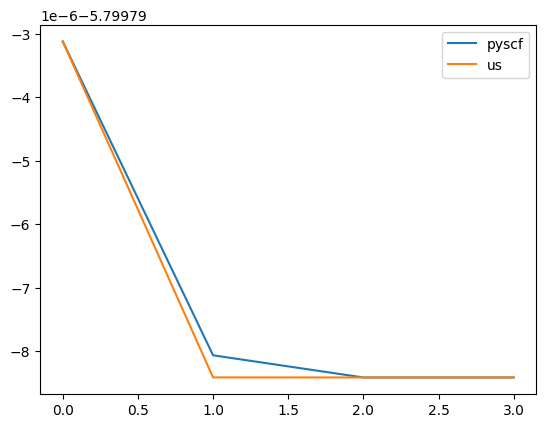

In [39]:

import textwrap
from tqdm import tqdm
import numpy
from pyscf import scf
from pyscf.scf import hf
from pyscf.scf import _vhf
from pyscf.scf import jk
from pyscf.dft import gen_grid
from pyscf.dft import numint
from pyscf import __config__
from pyscf import lib
from functools import reduce
import numpy
import scipy.linalg
import sys 
import tempfile
import h5py
from pyscf import gto
from pyscf.scf import diis
from pyscf.scf import _vhf
from pyscf.scf import chkfile
from pyscf.data import nist
#import jax.numpy as jnp 

def xc_and_coulomb(ks, mol=None, dm=None, dm_last=0, vhf_last=0, hermi=1):
    '''Coulomb + XC functional
    .. note::
        This function will modify the input ks object.
    Args:
        ks : an instance of :class:`RKS`
            XC functional are controlled by ks.xc attribute.  Attribute
            ks.grids might be initialized.
        dm : ndarray or list of ndarrays
            A density matrix or a list of density matrices
    Kwargs:
        dm_last : ndarray or a list of ndarrays or 0
            The density matrix baseline.  If not 0, this function computes the
            increment of HF potential w.r.t. the reference HF potential matrix.
        vhf_last : ndarray or a list of ndarrays or 0
            The reference Vxc potential matrix.
        hermi : int
            Whether J, K matrix is hermitian
            | 0 : no hermitian or symmetric
            | 1 : hermitian
            | 2 : anti-hermitian
    Returns:
        matrix Veff = J + Vxc.  Veff can be a list matrices, if the input
        dm is a list of density matrices.
    '''
    #if dm is None: dm = ks.make_rdm1()
    #ks.initialize_grids(mol, dm) # <-- only needs to be called once, and I think mol.build() does it? 

    ni            = ks._numint # numerical integrator, depends on xc functional! 
    max_memory    = ks.max_memory - lib.current_memory()[0]
    n, exc, vxc   = ni.nr_rks(mol, ks.grids, ks.xc, dm, max_memory=max_memory)

    #enabling range-separated hybrids
    omega, alpha, hyb = ni.rsh_and_hybrid_coeff(ks.xc, spin=mol.spin)

    if (ks._eri is None and ks.direct_scf and getattr(vhf_last, 'vk', None) is not None):
        ddm = numpy.asarray(dm) - numpy.asarray(dm_last)
        vj, vk = ks.get_jk(mol, ddm, hermi)
        vk *= hyb
        if abs(omega) > 1e-10:  # For range separated Coulomb operator
            vklr = ks.get_k(mol, ddm, hermi, omega=omega)
            vklr *= (alpha - hyb)
            vk += vklr
        vj += vhf_last.vj
        vk += vhf_last.vk
    else:
        vj, vk = ks.get_jk(mol, dm, hermi)
        vk *= hyb
        if abs(omega) > 1e-10:
            vklr = ks.get_k(mol, dm, hermi, omega=omega)
            vklr *= (alpha - hyb)
            vk += vklr
    vxc += vj - vk * .5

    exc   -= numpy.einsum('ij,ji', dm, vk).real * .5 * .5
    ecoul  = numpy.einsum('ij,ji', dm, vj).real * .5

    vxc = lib.tag_array(vxc, E_coulomb=ecoul, E_xc=exc, vj=vj, vk=vk)
    return vxc
    

from pyscf.lib import misc


from pyscf.dft.numint import _rks_gga_wv0, _scale_ao, _dot_ao_ao

def nr_rks(ni, mol, grids, xc_code, dms, relativity=0, hermi=1, max_memory=2000, verbose=None): # this one supports all xcs 
    '''Calculate RKS XC functional and potential matrix on given meshgrids
    for a set of density matrices
    Args:
        ni : an instance of :class:`NumInt`
        mol : an instance of :class:`Mole`
        grids : an instance of :class:`Grids`
            grids.coords and grids.weights are needed for coordinates and weights of meshgrids.
        xc_code : str
            XC functional description.
            See :func:`parse_xc` of pyscf/dft/libxc.py for more details.
        dms : 2D array or a list of 2D arrays
            Density matrix or multiple density matrices
    Kwargs:
        hermi : int
            Input density matrices symmetric or not. It also indicates whether
            the potential matrices in return are symmetric or not.
        max_memory : int or float
            The maximum size of cache to use (in MB).
    Returns:
        nelec, excsum, vmat.
        nelec is the number of electrons generated by numerical integration.
        excsum is the XC functional value.  vmat is the XC potential matrix in
        2D array of shape (nao,nao) where nao is the number of AO functions.
    Examples:
    >>> from pyscf import gto, dft
    >>> mol = gto.M(atom='H 0 0 0; H 0 0 1.1')
    >>> grids = dft.gen_grid.Grids(mol)
    >>> grids.coords = numpy.random.random((100,3))  # 100 random points
    >>> grids.weights = numpy.random.random(100)
    >>> nao = mol.nao_nr()
    >>> dm = numpy.random.random((nao,nao))
    >>> ni = dft.numint.NumInt()
    >>> nelec, exc, vxc = ni.nr_rks(mol, grids, 'lda,vwn', dm)
    '''
    xctype = ni._xc_type(xc_code)
    make_rho, nset, nao = ni._gen_rho_evaluator(mol, dms, hermi)

    shls_slice = (0, mol.nbas)
    ao_loc = mol.ao_loc_nr()

    nelec = numpy.zeros(nset)
    excsum = numpy.zeros(nset)
    if isinstance(dms, numpy.ndarray):
        vmat = numpy.zeros((nset,nao,nao), dtype=dms.dtype)
    else:
        vmat = numpy.zeros((nset,nao,nao), dtype=numpy.result_type(*dms))

    def block_loop(ao_deriv):
        for ao, mask, weight, coords \
                in ni.block_loop(mol, grids, nao, ao_deriv, max_memory=max_memory):
            for i in range(nset):
                rho = make_rho(i, ao, mask, xctype)
                exc, vxc = ni.eval_xc(xc_code, rho, spin=0,
                                      relativity=relativity, deriv=1,
                                      verbose=verbose)[:2]
                if xctype == 'LDA':
                    den = rho * weight
                else:
                    den = rho[0] * weight
                nelec[i] += den.sum()
                excsum[i] += numpy.dot(den, exc)
                yield i, rho, ao, mask, weight, vxc

    aow = None
    if xctype == 'LDA':
        ao_deriv = 0
        for i, rho, ao, mask, weight, vxc in block_loop(ao_deriv):
            vrho = vxc[0]
            # *.5 because vmat + vmat.T
            #:aow = numpy.einsum('pi,p->pi', ao, .5*weight*vrho, out=aow)
            aow = _scale_ao(ao, .5*weight*vrho, out=aow)
            vmat[i] += _dot_ao_ao(mol, ao, aow, mask, shls_slice, ao_loc)

    elif xctype == 'GGA':
        ao_deriv = 1
        for i, rho, ao, mask, weight, vxc in block_loop(ao_deriv):
            wv = _rks_gga_wv0(rho, vxc, weight)
            #:aow = numpy.einsum('npi,np->pi', ao, wv, out=aow)
            aow = _scale_ao(ao, wv, out=aow)
            vmat[i] += _dot_ao_ao(mol, ao[0], aow, mask, shls_slice, ao_loc)

    elif xctype == 'NLC':
        nlc_pars = ni.nlc_coeff(xc_code)
        ao_deriv = 1
        vvrho=numpy.empty([nset,4,0])
        vvweight=numpy.empty([nset,0])
        vvcoords=numpy.empty([nset,0,3])
        for ao, mask, weight, coords \
                in ni.block_loop(mol, grids, nao, ao_deriv, max_memory=max_memory):
            rhotmp = numpy.empty([0,4,weight.size])
            weighttmp = numpy.empty([0,weight.size])
            coordstmp = numpy.empty([0,weight.size,3])
            for idm in range(nset):
                rho = make_rho(idm, ao, mask, 'GGA')
                rho = numpy.expand_dims(rho,axis=0)
                rhotmp = numpy.concatenate((rhotmp,rho),axis=0)
                weighttmp = numpy.concatenate((weighttmp,numpy.expand_dims(weight,axis=0)),axis=0)
                coordstmp = numpy.concatenate((coordstmp,numpy.expand_dims(coords,axis=0)),axis=0)
                rho = None
            vvrho=numpy.concatenate((vvrho,rhotmp),axis=2)
            vvweight=numpy.concatenate((vvweight,weighttmp),axis=1)
            vvcoords=numpy.concatenate((vvcoords,coordstmp),axis=1)
            rhotmp = weighttmp = coordstmp = None
        for ao, mask, weight, coords \
                in ni.block_loop(mol, grids, nao, ao_deriv, max_memory=max_memory):
            aow = numpy.ndarray(ao[0].shape, order='F', buffer=aow)
            for i in range(nset):
                rho = make_rho(i, ao, mask, 'GGA')
                exc, vxc = _vv10nlc(rho, coords, vvrho[i], vvweight[i], vvcoords[i], nlc_pars)
                den = rho[0] * weight
                nelec[i] += den.sum()
                excsum[i] += numpy.dot(den, exc)
                wv = _rks_gga_wv0(rho, vxc, weight)
                #:aow = numpy.einsum('npi,np->pi', ao, wv, out=aow)
                aow = _scale_ao(ao, wv, out=aow)
                vmat[i] += _dot_ao_ao(mol, ao[0], aow, mask, shls_slice, ao_loc)
        vvrho = vvweight = vvcoords = None

    elif xctype == 'MGGA':
        if (any(x in xc_code.upper() for x in ('CC06', 'CS', 'BR89', 'MK00'))):
            raise NotImplementedError('laplacian in meta-GGA method')
        ao_deriv = 2 if MGGA_DENSITY_LAPL else 1
        for i, rho, ao, mask, weight, vxc in block_loop(ao_deriv):
            wv = _rks_mgga_wv0(rho, vxc, weight)
            #:aow = numpy.einsum('npi,np->pi', ao[:4], wv, out=aow)
            aow = _scale_ao(ao[:4], wv[:4], out=aow)
            vmat[i] += _dot_ao_ao(mol, ao[0], aow, mask, shls_slice, ao_loc)
            vmat[i] += _tau_dot(mol, ao, ao, wv[5], mask, shls_slice, ao_loc)

    elif xctype == 'HF':
        pass
    else:
        raise NotImplementedError(f'numint.nr_uks for functional {xc_code}')

    for i in range(nset):
        vmat[i] = vmat[i] + vmat[i].conj().T
    if nset == 1:
        nelec = nelec[0]
        excsum = excsum[0]
        vmat = vmat[0]
    return nelec, excsum, vmat

def _gen_rho_evaluator(self, mol, dms, hermi=0, with_lapl=True):
        if getattr(dms, 'mo_coeff', None) is not None:
            #TODO: test whether dm.mo_coeff matching dm
            mo_coeff = dms.mo_coeff
            mo_occ = dms.mo_occ
            if isinstance(dms, numpy.ndarray) and dms.ndim == 2:
                mo_coeff = [mo_coeff]
                mo_occ = [mo_occ]
            nao = mo_coeff[0].shape[0]
            ndms = len(mo_occ)
            def make_rho(idm, ao, non0tab, xctype):
                return self.eval_rho2(mol, ao, mo_coeff[idm], mo_occ[idm],
                                      non0tab, xctype, with_lapl)
        else:
            if isinstance(dms, numpy.ndarray) and dms.ndim == 2:
                dms = dms[numpy.newaxis]
            if hermi != 1 and dms[0].dtype == numpy.double:
                # (D + D.T)/2 because eval_rho computes 2*(|\nabla i> D_ij <j|) instead of
                # |\nabla i> D_ij <j| + |i> D_ij <\nabla j| for efficiency when dm is real
                dms = [(dm+dm.T)*.5 for dm in dms]
                hermi = 1
            nao = dms[0].shape[0]
            ndms = len(dms)
            def make_rho(idm, ao, non0tab, xctype):
                return self.eval_rho(mol, ao, dms[idm], non0tab, xctype,
                                     hermi, with_lapl)
        return make_rho, ndms, nao

def nr_rks_only_GGA(ni, mol, grids, xc_code, dms, relativity=0, hermi=1, max_memory=2000, verbose=None): # this one supports all xcs 
    xctype  = "GGA" 
    make_rho, nset, nao = _gen_rho_evaluator(ni, mol, dms, hermi)

    shls_slice = (0, mol.nbas)
    ao_loc = mol.ao_loc_nr()

    nelec = numpy.zeros(nset)
    excsum = numpy.zeros(nset)
    if isinstance(dms, numpy.ndarray):
        vmat = numpy.zeros((nset,nao,nao), dtype=dms.dtype)
    else:
        vmat = numpy.zeros((nset,nao,nao), dtype=numpy.result_type(*dms))

    def block_loop(ao_deriv):
        for ao, mask, weight, coords \
                in ni.block_loop(mol, grids, nao, ao_deriv, max_memory=max_memory):
            for i in range(nset):
                rho = make_rho(i, ao, mask, xctype)
                exc, vxc = ni.eval_xc(xc_code, rho, spin=0,
                                      relativity=relativity, deriv=1,
                                      verbose=verbose)[:2]
                if xctype == 'LDA':
                    den = rho * weight
                else:
                    den = rho[0] * weight
                nelec[i] += den.sum()
                excsum[i] += numpy.dot(den, exc)
                yield i, rho, ao, mask, weight, vxc

    aow = None

    ao_deriv = 1
    for i, rho, ao, mask, weight, vxc in block_loop(ao_deriv):
        wv = _rks_gga_wv0(rho, vxc, weight)
        aow = _scale_ao(ao, wv, out=aow)
        vmat[i] += _dot_ao_ao(mol, ao[0], aow, mask, shls_slice, ao_loc)

    for i in range(nset):
        vmat[i] = vmat[i] + vmat[i].conj().T
    if nset == 1:
        nelec = nelec[0]
        excsum = excsum[0]
        vmat = vmat[0]
    return nelec, excsum, vmat

class RKS(): # moved everything into one class! i.e. removed inheritance dependency 

    # old values from prev step 
    DIIS = CDIIS #diis.SCF_DIIS # Direct inversion in the iterative subspace DIIS. 
    diis = getattr(__config__, 'scf_hf_SCF_diis', True)
    diis_space = getattr(__config__, 'scf_hf_SCF_diis_space', 8)
    # need > 0 if initial DM is numpy.zeros array
    diis_start_cycle = getattr(__config__, 'scf_hf_SCF_diis_start_cycle', 1)
    diis_file = None
    # Give diis_space_rollback=True a trial if all other methods do not converge
    diis_space_rollback = False

    #diis       = getattr(__config__, 'scf_hf_SCF_diis', True)
    #diis_space = getattr(__config__, 'scf_hf_SCF_diis_space', 8)
    # need > 0 if initial DM is numpy.zeros array
    #diis_start_cycle = getattr(__config__, 'scf_hf_SCF_diis_start_cycle', 1)

    damp            = getattr(__config__, 'scf_hf_SCF_damp', 0)
    level_shift     = getattr(__config__, 'scf_hf_SCF_level_shift', 0)
    direct_scf      = getattr(__config__, 'scf_hf_SCF_direct_scf', True)
    direct_scf_tol  = getattr(__config__, 'scf_hf_SCF_direct_scf_tol', 1e-13)

    def __init__(self, mol, xc='LDA,VWN'):

        self.mol = mol
        self.verbose = mol.verbose
        self.max_memory = mol.max_memory
        self.stdout = mol.stdout

        self.opt = None
        self._eri = None # Note: self._eri requires large amount of memory
        
        self.xc = xc
        self.nlc = ''
        self.grids = gen_grid.Grids(self.mol)
        self.grids.level = getattr(__config__, 'dft_rks_RKS_grids_level',
                                self.grids.level)
        self.nlcgrids = gen_grid.Grids(self.mol)
        self.nlcgrids.level = getattr(__config__, 'dft_rks_RKS_nlcgrids_level',
                                    self.nlcgrids.level)
        # Use rho to filter grids
        self.small_rho_cutoff = getattr(__config__, 'dft_rks_RKS_small_rho_cutoff', 1e-7)
        self._numint = numint.NumInt()
        self.max_cycle = 50


    def get_jk(self, mol=None, dm=None, hermi=1, with_j=True, with_k=True,
               omega=None):
        if mol is None: mol = self.mol
        if dm is None: dm = self.make_rdm1()
        if self.direct_scf and self.opt is None:
            self.opt = self.init_direct_scf(mol)

        if with_j and with_k:
            vj, vk = hf.get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)
        else:
            if with_j:
                prescreen = 'CVHFnrs8_vj_prescreen'
            else:
                prescreen = 'CVHFnrs8_vk_prescreen'
            with lib.temporary_env(self.opt, prescreen=prescreen):
                vj, vk = get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)

        return vj, vk

    def get_j(self, mol=None, dm=None, hermi=1, omega=None):
        '''Compute J matrices for all input density matrices
        '''
        return self.get_jk(mol, dm, hermi, with_k=False, omega=omega)[0]

    def get_k(self, mol=None, dm=None, hermi=1, omega=None):
        '''Compute K matrices for all input density matrices '''
        return self.get_jk(mol, dm, hermi, with_j=False, omega=omega)[1]

    def init_direct_scf(self, mol=None):
        # Integrals < direct_scf_tol may be set to 0 in int2e.
        # Higher accuracy is required for Schwartz inequality prescreening.
        with mol.with_integral_screen(self.direct_scf_tol**2):
            opt = _vhf.VHFOpt(mol, 'int2e', 'CVHFnrs8_prescreen',
                              'CVHFsetnr_direct_scf',
                              'CVHFsetnr_direct_scf_dm')
            opt.direct_scf_tol = self.direct_scf_tol
        return opt

    def kernel(self, convergence_tolerance=1e-10): 
      mol       = self.mol
      e_tot     = -1  
      converged = False

      # Init Stuff 
      dm              = hf.init_guess_by_minao(mol)         # <-- a few hundred lines of code in hf.py  (4, 4)
      V_xc            = xc_and_coulomb(self, mol, dm)       # <--- Coulomb + XC functional (this is the part that changes)  (4, 4)
      h1e             = mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc') # <--- gets fixed part of hamiltonian which doesn't change (4, 4)
      
      # Initial code solve generalized eigen problem scipy.linalg.eigh( A, B )
      # We turn this into normal eig problem scipy.linalg.eigh(L_inv@B@Linv.T) where LL.T = B is cholesky(B)
      s1e   = mol.intor_symmetric('int1e_ovlp')             # <-- overlap matrix;; is this electron by electonr? dont think so (4, 4) ;; we add it to the generalized eigensolver? 
      L     = np.linalg.cholesky(s1e)
      L_inv = np.linalg.inv(L)

      nuclear_energy  = mol.energy_nuc()
      n_electrons     = mol.nelectron

      mf_diis_space     = self.diis_space # usually 8


      #e_idx   = numpy.argsort(mo_energy)
      e_idx                           = np.arange(V_xc.shape[0])
      mo_occ                          = numpy.zeros(V_xc.shape[0])
      mo_occ[e_idx[:n_electrons//2]]  = 2 
      mo_occ_nnz                      = mo_occ[mo_occ>0] 

      #pbar = tqdm(range(self.max_cycle))
      pbar = None 

      if pbar is None: pbar = range(self.max_cycle)

      # four pain points
      # mf_diis.update
      # eigh(a, b) -> eigh(b_inv, a)

      # five things left to refactor
      mf_diis_vs = []
      mf_diis_xs = []

      mf_diis_H = np.zeros((mf_diis_space+1,mf_diis_space+1), np.float64)
      mf_diis_H[0,1:] = mf_diis_H[1:,0] = 1
      mf_diis_head   = 0

      d, hamil_d = np.prod(h1e.shape), np.prod(h1e.shape)
      _V = np.zeros((mf_diis_space, d))
      _H = np.zeros((mf_diis_space, d))

      energies = []

      for cycle in pbar:
          dm_last           = dm        
          last_hf_e         = e_tot

          hamiltonian       = h1e + V_xc

          sdf               = s1e @ dm @ hamiltonian
          errvec            = sdf.T - sdf

          # ============ STRAT DIIS =============== #
          # See https://en.wikipedia.org/wiki/DIIS 
          # All numpy, can be jaxed! 
          jnp = np 
          errvec      = jnp.array(errvec)
          hamiltonian = jnp.array(hamiltonian)
          d           = errvec.shape[0]*errvec.shape[1]
          hamil_d     = hamiltonian.shape[0] * hamiltonian.shape[1]

          dt = errvec.reshape(-1)
          if mf_diis_head >= mf_diis_space:  mf_diis_head   = 0

          _V[mf_diis_head] = dt
          _H[mf_diis_head] = hamiltonian.reshape(-1)

          mf_diis_head += 1

          __mf_diis_head      = cycle % _V.shape[0]
          __nd                = min(cycle, _V.shape[0])


          nd = mf_diis_head # cycle  ;;; this was the bug, this had to be mf_diis_head and not cycle! 
          # does this mean DIIS algorithm has to restart ? that's quite weird 
          if nd >= mf_diis_space: nd = mf_diis_space 


          # Do all inner products between last vector and all the others. 
          # store as row/col in matrix. 
          # previous code did this with for loops. 
          #tmps = jnp.array(mf_diis_vs).reshape(len(mf_diis_vs), 1, d) @ dt.reshape(1, d, 1)
          print(__mf_diis_head, __nd)
          print(mf_diis_head, nd)
          tmps = _V[:nd].reshape(-1, 1, d) @ dt.reshape(1, d, 1)
          mf_diis_H[mf_diis_head, 1:nd+1] = tmps.reshape(-1)[:nd]
          mf_diis_H[1:nd+1, mf_diis_head] = tmps.reshape(-1)[:nd]
          
          # Compute H^-1@[1, 0, ..., 0] using eigh. 
          g = jnp.concatenate((jnp.ones(1), jnp.zeros(nd)))
          h   = mf_diis_H[:nd+1,:nd+1]
          w, v = scipy.linalg.eigh(h)
          idx  = abs(w)>1e-14
          c    = (v[:,idx]/w[idx]) @ (v[:,idx].T @ g)

          d_ = c[1:].shape[0]
          #xnew = jnp.sum( jnp.array(mf_diis_xs[:d_]) * c[1:].reshape(d_, 1), axis=0) 
          xnew = jnp.sum( _H[:d_] * c[1:].reshape(d_, 1), axis=0) 
          hamiltonian = xnew.reshape(hamiltonian.shape)
          hamiltonian = np.array(hamiltonian)
          # ============ END DIIS =============== #


          # Solve generalized eigenproblem using normal eigh solver using this trick: https://www.jstor.org/stable/2949370
          eigvals, eigvects = np.linalg.eigh(L_inv @ hamiltonian @ L_inv.T)  
          eigvects          = L_inv.T @ eigvects 

          # Reconstruct density matrix using eigenvectors. 
          dm                = (eigvects[:, mo_occ>0] * mo_occ_nnz) @ eigvects[:, mo_occ>0].T 

          # This is the part that changes each iteration. 
          # It computes both coulomb stuff and XC. 
          if True: 
            vhf_last      = V_xc 

            #n, E_xc, V_xc     = self._numint.nr_rks(mol, self.grids, self.xc, dm) 
            n, E_xc, V_xc     = nr_rks_only_GGA(self._numint, mol, self.grids, self.xc, dm)  # <----- 
            omega, alpha, hyb = self._numint.rsh_and_hybrid_coeff(self.xc, spin=mol.spin) # <----- 

            vj, vk = self.get_jk(mol, dm - dm_last, hermi=True) # <----- 
            vk    *= hyb
            vj    += vhf_last.vj
            vk    += vhf_last.vk

            V_xc += vj - vk * .5

            #E_xc      = E_xc - numpy.einsum('ij,ji', dm, vk) * .5 * .5
            E_xc      = E_xc - np.sum(dm* vk.T) * .5 * .5
            #E_coulomb = numpy.einsum('ij,ji', dm, vj) * .5
            E_coulomb = np.sum(dm*vj.T) * .5

            V_xc = lib.tag_array(V_xc, E_coulomb=E_coulomb, E_xc=E_xc, vj=vj, vk=vk) # <---- 

          # Compute energy. Currently only used to check for convergence. 
          #e_tot =  numpy.einsum('ij,ji->', h1e, dm) + E_coulomb + E_xc + nuclear_energy
          e_tot =  np.sum(h1e*dm.T) + E_coulomb + E_xc + nuclear_energy

          if type(pbar) != type(range(0,1)): pbar.set_description("E=%4f change=%4e tolerance=%4e"%(e_tot, abs(e_tot-last_hf_e), convergence_tolerance))

          energies.append(e_tot)

          if abs(e_tot-last_hf_e) < convergence_tolerance:
              converged = True
              break

      self.converged, self.e_tot,  self.mo_energy, self.mo_coeff, self.mo_occ =  converged, e_tot, eigvals, eigvects, mo_occ
      return self.e_tot ,energies

    def kernel2(self, convergence_tolerance=1e-10): 
      mol       = self.mol
      e_tot     = -1  
      converged = False

      # Init Stuff 
      dm              = hf.init_guess_by_minao(mol)         # <-- a few hundred lines of code in hf.py  (4, 4)
      V_xc            = xc_and_coulomb(self, mol, dm)       # <--- Coulomb + XC functional (this is the part that changes)  (4, 4)
      h1e             = mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc') # <--- gets fixed part of hamiltonian which doesn't change (4, 4)
      
      # Initial code solve generalized eigen problem scipy.linalg.eigh( A, B )
      # We turn this into normal eig problem scipy.linalg.eigh(L_inv@B@Linv.T) where LL.T = B is cholesky(B)
      s1e   = mol.intor_symmetric('int1e_ovlp')             # <-- overlap matrix;; is this electron by electonr? dont think so (4, 4) ;; we add it to the generalized eigensolver? 
      L     = np.linalg.cholesky(s1e)
      L_inv = np.linalg.inv(L)

      nuclear_energy  = mol.energy_nuc()
      n_electrons     = mol.nelectron

      mf_diis           = self.DIIS(self)
      mf_diis.space     = self.diis_space # usually 8
      mf_diis.rollback  = self.diis_space_rollback # usually False 


      #e_idx   = numpy.argsort(mo_energy)
      e_idx                           = np.arange(V_xc.shape[0])
      mo_occ                          = numpy.zeros(V_xc.shape[0])
      mo_occ[e_idx[:n_electrons//2]]  = 2 
      mo_occ_nnz                      = mo_occ[mo_occ>0] 

      #pbar = tqdm(range(self.max_cycle))
      pbar = None 

      if pbar is None: pbar = range(self.max_cycle)

      # four pain points
      # mf_diis.update
      # eigh(a, b) -> eigh(b_inv, a)

      # five things left to refactor
      mf_diis.vs = []
      mf_diis.xs = []


      if mf_diis._H is None:
          mf_diis._H = np.zeros((mf_diis.space+1,mf_diis.space+1), np.float64)
          mf_diis._H[0,1:] = mf_diis._H[1:,0] = 1

      d, hamil_d = np.prod(h1e.shape), np.prod(h1e.shape)
      _V = np.zeros((mf_diis.space, d))
      _H = np.zeros((mf_diis.space, d))
      print(_V.shape, _H.shape)

      energies = []

      for cycle in pbar:
          dm_last           = dm        
          last_hf_e         = e_tot
          hamiltonian       = h1e + V_xc
          sdf               = s1e @ dm @ hamiltonian
          errvec            = sdf.T - sdf

          dt = errvec.reshape(-1)
          if mf_diis._head >= mf_diis.space:  mf_diis._head = 0

          _V[mf_diis._head] = dt
          _H[mf_diis._head] = hamiltonian.reshape(-1)

          mf_diis._head += 1

          nd = mf_diis._head 
          if nd >= mf_diis.space: nd = mf_diis.space 

          tmps = _V[:nd].reshape(-1, 1, d) @ dt.reshape(1, d, 1)

          mf_diis._H[mf_diis._head, 1:nd+1] = tmps.reshape(-1)[:nd]
          mf_diis._H[1:nd+1, mf_diis._head] = tmps.reshape(-1)[:nd]
          

          # Compute h^-1 @ [1, 0, ..., 0]. 
          # Uses ?both? eigh and solve.
          h   = mf_diis._H[:nd+1,:nd+1]
          g   = np.zeros(nd+1)
          g[0] = 1

          # previous code did either eigh or np.linalg.solve to compute H^-1@[1, 0, ..., 0]. 
          w, v = scipy.linalg.eigh(h)
          idx = abs(w)>1e-14
          c   = (v[:,idx]/w[idx]) @ (v[:,idx].T @ g)
          #c = np.linalg.solve(h,g)


          d_ = c[1:].shape[0]

          #assert np.allclose( np.array(mf_diis.xs[:d_]), _H[:d_]) # when head > 8 this dies! becuase mf_diis.xs is wrong (similar for mf_diis.vs)
          #xnew = np.sum( np.array(mf_diis.xs[:d_]) * c[1:].reshape(d_, 1), axis=0) 
          xnew = np.sum( np.array(_H[:d_]) * c[1:].reshape(d_, 1), axis=0) 

          '''xnew = np.zeros(hamil_d, c.dtype)
          for i, ci in enumerate(c[1:]):
              xi = mf_diis.xs[i]
              for p0, p1 in misc.prange(0, xi.size, BLOCK_SIZE):
                  xnew[p0:p1] += xi[p0:p1] * ci'''
          hamiltonian = xnew.reshape(hamiltonian.shape)

          # Solve generalized eigenproblem using normal eigh solver using this trick: https://www.jstor.org/stable/2949370
          eigvals, eigvects = np.linalg.eigh(L_inv @ hamiltonian @ L_inv.T)  
          eigvects          = L_inv.T @ eigvects 

          # Reconstruct density matrix using eigenvectors. 
          dm                = (eigvects[:, mo_occ>0] * mo_occ_nnz) @ eigvects[:, mo_occ>0].T 

          # This is the part that changes each iteration. 
          # It computes both coulomb stuff and XC. 
          if True: 
            vhf_last      = V_xc 

            #n, E_xc, V_xc     = self._numint.nr_rks(mol, self.grids, self.xc, dm) 
            n, E_xc, V_xc     = nr_rks_only_GGA(self._numint, mol, self.grids, self.xc, dm)  # <----- 
            omega, alpha, hyb = self._numint.rsh_and_hybrid_coeff(self.xc, spin=mol.spin) # <----- 

            vj, vk = self.get_jk(mol, dm - dm_last, hermi=True) # <----- 
            vk    *= hyb
            vj    += vhf_last.vj
            vk    += vhf_last.vk

            V_xc += vj - vk * .5

            #E_xc      = E_xc - numpy.einsum('ij,ji', dm, vk) * .5 * .5
            E_xc      = E_xc - np.sum(dm* vk.T) * .5 * .5
            #E_coulomb = numpy.einsum('ij,ji', dm, vj) * .5
            E_coulomb = np.sum(dm*vj.T) * .5

            V_xc = lib.tag_array(V_xc, E_coulomb=E_coulomb, E_xc=E_xc, vj=vj, vk=vk) # <---- 

          # Compute energy. Currently only used to check for convergence. 
          #e_tot =  numpy.einsum('ij,ji->', h1e, dm) + E_coulomb + E_xc + nuclear_energy
          e_tot =  np.sum(h1e*dm.T) + E_coulomb + E_xc + nuclear_energy

          if type(pbar) != type(range(0,1)): pbar.set_description("E=%4f change=%4e tolerance=%4e"%(e_tot, abs(e_tot-last_hf_e), convergence_tolerance))

          print(abs(e_tot-last_hf_e))
          energies.append(e_tot)

          if abs(e_tot-last_hf_e) < convergence_tolerance:
              converged = True
              break

      self.converged, self.e_tot,  self.mo_energy, self.mo_coeff, self.mo_occ =  converged, e_tot, eigvals, eigvects, mo_occ
      return self.e_tot , energies


def jax_scf(str):
  basis_set ="6-31G*"
  xc_fun    ="b3lyp"

  # So PCQ uses eV and PySCF uses Hartree 
  eV_to_hartree    = 0.0367493
  hartree_to_eV    = 27.2114
  angstrom_to_bohr = 1.88973

  from pyscf.gto import mole  # <--- this file is 2000 lines of code

  t0 = time.time()
  mol = mole.Mole()

  #print("building molecule:")
  mol.build(atom=str, unit="Bohr", basis=basis_set)
  #print(time.time()-t0)

  mol.verbose = 0 
  mf = RKS(mol) 
  mf.xc = xc_fun 

  t0 = time.time()
  energy, energies = mf.kernel()
  #energy, energies = mf.kernel2() # copy of kernel from prev version which works? 
  t = time.time()-t0
  #print("Us", t)

  lumo = np.argmin(mf.mo_occ)
  homo = lumo - 1
  hl_gap_hartree = np.abs(mf.mo_energy[homo] - mf.mo_energy[lumo])
  hlgap = hartree_to_eV*hl_gap_hartree
  return energy, hlgap , t, energies

#(our_fun=jax_scf, list=[0, -1]) 
#test_cases(our_fun=jax_scf, list=[0,1,5,6,12], verbose=True) 
#test_cases(our_fun=jax_scf, list=[12], verbose=True) 
#test_cases(our_fun=jax_scf, list=[10**3], verbose=True) 
#test_cases(our_fun=jax_scf, list=[12], verbose=True)
#test_cases(our_fun=jax_scf, list=[0,1,12], verbose=True)


#test_cases(our_fun=jax_scf, list=[0,51], verbose=True)
#test_cases(our_fun=jax_scf, list=[0,4,7], verbose=True)
test_cases(our_fun=jax_scf, list=[0], verbose=True)



# There is a little bit of an difference. 
# Figure out what is causing this. 
# Some of the pop stuff maybe? I.e., I'm using maybe the first 8 instead of the last 8 vectors? 


# STEP 12: starting on numerical integration numint

|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
HeHe	 -5.799798410857481 47.01424791215059 0.25126099586486816
>pyscf
[-5.799793123445306, -5.799798061919506, -5.79979841081143, -5.799798410811634]
>us
[-5.799793123492619, -5.799798409615176, -5.799798410852875, -5.799798410857481]

|            HeHe |   -5.800 47.014 |   -5.800 47.014 |     0.000 0.000 |       47.014227 |          1.099560s |          0.251261s |
CHHHH	 -40.48166835520409 13.791238822497633 1.0804896354675293
>pyscf
[-40.45720389282365, -40.45002546733479, -40.48166365215325, -40.48166834854976, -40.4816683551466, -40.48166835515293]
>us
[-40.45720389287879, -40.4525506730822, -40.48166419761127, -40.481668349126245, -40.4816683552015, -40.48166835520409]

|           CHHHH |  -40.482 13.791 |  -40.482 13.791 |     0.000 0.000 |       13.791238 |          6.347717s |          1.080490s |
BeBe	 -29.315727973219722 2.9503798272716715 0.7

KeyboardInterrupt: 

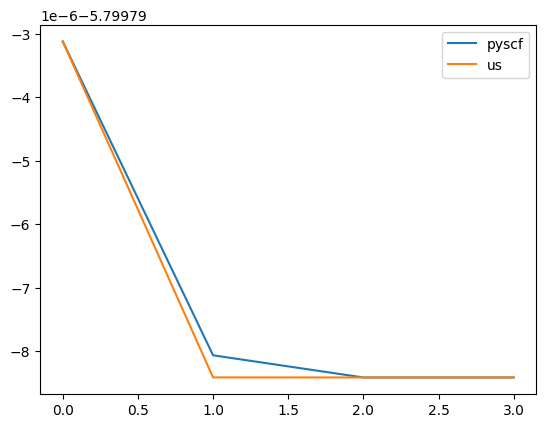

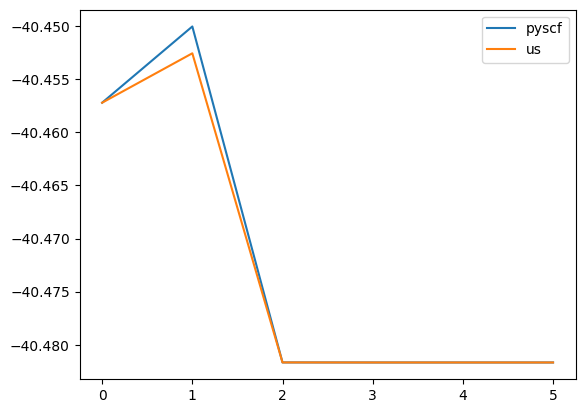

In [42]:

from pyscf.gto.moleintor import make_cintopt, make_loc, ascint3
import textwrap
from tqdm import tqdm
import numpy
from pyscf import scf
from pyscf.scf import hf
from pyscf.scf import _vhf
from pyscf.scf import jk
from pyscf.dft import gen_grid
from pyscf.dft import numint
from pyscf import __config__
from pyscf import lib
from functools import reduce
import numpy
import scipy.linalg
import sys 
import tempfile
import h5py
from pyscf import gto
from pyscf.scf import diis
from pyscf.scf import _vhf
from pyscf.scf import chkfile
from pyscf.data import nist
#import jax.numpy as jnp 

def xc_and_coulomb(ks, mol=None, dm=None, dm_last=0, vhf_last=0, hermi=1):
    '''Coulomb + XC functional
    .. note::
        This function will modify the input ks object.
    Args:
        ks : an instance of :class:`RKS`
            XC functional are controlled by ks.xc attribute.  Attribute
            ks.grids might be initialized.
        dm : ndarray or list of ndarrays
            A density matrix or a list of density matrices
    Kwargs:
        dm_last : ndarray or a list of ndarrays or 0
            The density matrix baseline.  If not 0, this function computes the
            increment of HF potential w.r.t. the reference HF potential matrix.
        vhf_last : ndarray or a list of ndarrays or 0
            The reference Vxc potential matrix.
        hermi : int
            Whether J, K matrix is hermitian
            | 0 : no hermitian or symmetric
            | 1 : hermitian
            | 2 : anti-hermitian
    Returns:
        matrix Veff = J + Vxc.  Veff can be a list matrices, if the input
        dm is a list of density matrices.
    '''
    #if dm is None: dm = ks.make_rdm1()
    #ks.initialize_grids(mol, dm) # <-- only needs to be called once, and I think mol.build() does it? 

    ni            = ks._numint # numerical integrator, depends on xc functional! 
    max_memory    = ks.max_memory - lib.current_memory()[0]
    n, exc, vxc   = ni.nr_rks(mol, ks.grids, ks.xc, dm, max_memory=max_memory)

    #enabling range-separated hybrids
    omega, alpha, hyb = ni.rsh_and_hybrid_coeff(ks.xc, spin=mol.spin)

    if (ks._eri is None and ks.direct_scf and getattr(vhf_last, 'vk', None) is not None):
        ddm = numpy.asarray(dm) - numpy.asarray(dm_last)
        vj, vk = ks.get_jk(mol, ddm, hermi)
        vk *= hyb
        if abs(omega) > 1e-10:  # For range separated Coulomb operator
            vklr = ks.get_k(mol, ddm, hermi, omega=omega)
            vklr *= (alpha - hyb)
            vk += vklr
        vj += vhf_last.vj
        vk += vhf_last.vk
    else:
        vj, vk = ks.get_jk(mol, dm, hermi)
        vk *= hyb
        if abs(omega) > 1e-10:
            vklr = ks.get_k(mol, dm, hermi, omega=omega)
            vklr *= (alpha - hyb)
            vk += vklr
    vxc += vj - vk * .5

    exc   -= numpy.einsum('ij,ji', dm, vk).real * .5 * .5
    ecoul  = numpy.einsum('ij,ji', dm, vj).real * .5

    vxc = lib.tag_array(vxc, E_coulomb=ecoul, E_xc=exc, vj=vj, vk=vk)
    return vxc
    

from pyscf.lib import misc


from pyscf.dft.numint import _rks_gga_wv0, _scale_ao, _dot_ao_ao

from pyscf.dft.gen_grid import make_mask, BLKSIZE

SWITCH_SIZE = getattr(__config__, 'dft_numint_SWITCH_SIZE', 800)
libdft = lib.load_library('libdft')
import ctypes

import _ctypes
libcvhf = lib.load_library('libcvhf')
def _fpointer(name):
    return ctypes.c_void_p(_ctypes.dlsym(libcvhf._handle, name))

def nr_rks_only_GGA(ni, mol, grids, xc_code, dms, relativity=0, hermi=1, max_memory=2000, verbose=None): # this one supports all xcs 
    xctype  = "GGA" 
    
    dms   = dms[numpy.newaxis]
    nao   = dms[0].shape[0] # this is just one?!
    ndms  = len(dms)

    def make_rho(idm, ao, non0tab, xctype):
        dm = dms[idm]

        ngrids, nao = ao[0].shape

        shls_slice = (0, mol.nbas)
        ao_loc = mol.ao_loc_nr()

        rho = numpy.empty((4,ngrids))
        c0 = np.dot(ao[0], dm) 
        rho[0] = numpy.einsum('pi,pi->p', c0, ao[0])
        for i in range(1, 4):
            rho[i] = numpy.einsum('pi,pi->p', c0, ao[i])
            
        rho[1:4] *= 2  
        return rho
        
    nset = ndms

    shls_slice = (0, mol.nbas)
    ao_loc = mol.ao_loc_nr()

    nelec   = numpy.zeros(nset)
    excsum = numpy.zeros(nset)
    vmat = numpy.zeros((nset,nao,nao), dtype=dms.dtype)

    def block_loop(ao_deriv):
        for ao, mask, weight, coords  in ni.block_loop(mol, grids, nao, ao_deriv, max_memory=max_memory):
            for i in range(nset):
                rho = make_rho(i, ao, mask, xctype)
                exc, vxc = ni.eval_xc(xc_code, rho, spin=0,
                                      relativity=relativity, deriv=1,
                                      verbose=verbose)[:2]
                den = rho[0] * weight
                nelec[i] += den.sum()
                excsum[i] += numpy.dot(den, exc)
                yield i, rho, ao, mask, weight, vxc

    aow = None

    ao_deriv = 1
    for i, rho, ao, mask, weight, vxc in block_loop(ao_deriv):
        wv = _rks_gga_wv0(rho, vxc, weight)
        aow = _scale_ao(ao, wv, out=aow)
        vmat[i] += _dot_ao_ao(mol, ao[0], aow, mask, shls_slice, ao_loc)

    for i in range(nset):
        vmat[i] = vmat[i] + vmat[i].conj().T

    if nset == 1:
        nelec = nelec[0]
        excsum = excsum[0]
        vmat = vmat[0]

    return nelec, excsum, vmat


# https://github.com/pyscf/pyscf/blob/16887846a6b30bde495ebf69905de2576f4a3f4a/pyscf/scf/_vhf.py#L303
# no clue what this does. 
def direct(dms, atm, bas, env, vhfopt=None, hermi=0, cart=False,
           with_j=True, with_k=True):

    # weird shape/dtype stuff 
    c_atm = numpy.asarray(atm, dtype=numpy.int32, order='C')
    c_bas = numpy.asarray(bas, dtype=numpy.int32, order='C')
    c_env = numpy.asarray(env, dtype=numpy.double, order='C')
    natm = ctypes.c_int(c_atm.shape[0])
    nbas = ctypes.c_int(c_bas.shape[0])

    dms       = numpy.asarray(dms, order='C', dtype=numpy.double)
    dms_shape = dms.shape
    nao       = dms_shape[-1]
    dms       = dms.reshape(-1,nao,nao)
    n_dm      = dms.shape[0]

    # is this compute? 
    vhfopt.set_dm(dms, atm, bas, env)
    cvhfopt = vhfopt._this
    cintopt = vhfopt._cintopt
    intor = vhfopt._intor

    cintor = _fpointer(intor)

    fdrv = getattr(libcvhf, 'CVHFnr_direct_drv')
    fdot = _fpointer('CVHFdot_nrs8')

    vj = vk = None
    dmsptr = []
    vjkptr = []
    fjk = []

    fvj = _fpointer('CVHFnrs8_ji_s2kl')
    vj = numpy.empty((n_dm,nao,nao))
    for i, dm in enumerate(dms):
        dmsptr.append(dm.ctypes.data_as(ctypes.c_void_p))
        vjkptr.append(vj[i].ctypes.data_as(ctypes.c_void_p))
        fjk.append(fvj)

    if hermi == 1:
        fvk = _fpointer('CVHFnrs8_li_s2kj')
    else:
        fvk = _fpointer('CVHFnrs8_li_s1kj')
    vk = numpy.empty((n_dm,nao,nao))
    for i, dm in enumerate(dms):
        dmsptr.append(dm.ctypes.data_as(ctypes.c_void_p))
        vjkptr.append(vk[i].ctypes.data_as(ctypes.c_void_p))
        fjk.append(fvk)

    shls_slice = (ctypes.c_int*8)(*([0, c_bas.shape[0]]*4))
    ao_loc = make_loc(bas, intor)
    n_ops = len(dmsptr)
    comp = 1
    fdrv(cintor, fdot, (ctypes.c_void_p*n_ops)(*fjk),
         (ctypes.c_void_p*n_ops)(*dmsptr), (ctypes.c_void_p*n_ops)(*vjkptr),
         ctypes.c_int(n_ops), ctypes.c_int(comp),
         shls_slice, ao_loc.ctypes.data_as(ctypes.c_void_p), cintopt, cvhfopt,
         c_atm.ctypes.data_as(ctypes.c_void_p), natm,
         c_bas.ctypes.data_as(ctypes.c_void_p), nbas,
         c_env.ctypes.data_as(ctypes.c_void_p))

    # vj must be symmetric
    for i in range(n_dm):
        lib.hermi_triu(vj[i], 1, inplace=True)
    vj = vj.reshape(dms_shape)
    if hermi != 0:
        for i in range(n_dm):
            lib.hermi_triu(vk[i], hermi, inplace=True)
    vk = vk.reshape(dms_shape)
    return vj, vk


def get_jk(mol, dm, hermi=1, vhfopt=None, with_j=True, with_k=True, omega=None):
    '''Compute J, K matrices for all input density matrices
    Args:
        mol : an instance of :class:`Mole`
        dm : ndarray or list of ndarrays
            A density matrix or a list of density matrices
    Kwargs:
        hermi : int
            Whether J, K matrix is hermitian
            | 0 : not hermitian and not symmetric
            | 1 : hermitian or symmetric
            | 2 : anti-hermitian
        vhfopt :
            A class which holds precomputed quantities to optimize the
            computation of J, K matrices
        with_j : boolean
            Whether to compute J matrices
        with_k : boolean
            Whether to compute K matrices
        omega : float
            Parameter of range-seperated Coulomb operator: erf( omega * r12 ) / r12.
            If specified, integration are evaluated based on the long-range
            part of the range-seperated Coulomb operator.
    Returns:
        Depending on the given dm, the function returns one J and one K matrix,
        or a list of J matrices and a list of K matrices, corresponding to the
        input density matrices.
    Examples:
    >>> from pyscf import gto, scf
    >>> from pyscf.scf import _vhf
    >>> mol = gto.M(atom='H 0 0 0; H 0 0 1.1')
    >>> dms = numpy.random.random((3,mol.nao_nr(),mol.nao_nr()))
    >>> j, k = scf.hf.get_jk(mol, dms, hermi=0)
    >>> print(j.shape)
    (3, 2, 2)
    '''
    # The vhfopt of standard Coulomb operator can be used here as an approximate
    # integral prescreening conditioner since long-range part Coulomb is always
    # smaller than standard Coulomb.  It's safe to filter LR integrals with the
    # integral estimation from standard Coulomb.
    #with mol.with_range_coulomb(omega): 
    vj, vk = direct(dm, mol._atm, mol._bas, mol._env, vhfopt, hermi, mol.cart, with_j, with_k) # ...

    vj = vj.reshape(dm.shape)
    vk = vk.reshape(dm.shape)
        
    return vj, vk

class RKS(): # moved everything into one class! i.e. removed inheritance dependency 

    diis       = getattr(__config__, 'scf_hf_SCF_diis', True)
    diis_space = getattr(__config__, 'scf_hf_SCF_diis_space', 8)
    # need > 0 if initial DM is numpy.zeros array
    diis_start_cycle = getattr(__config__, 'scf_hf_SCF_diis_start_cycle', 1)

    damp            = getattr(__config__, 'scf_hf_SCF_damp', 0)
    level_shift     = getattr(__config__, 'scf_hf_SCF_level_shift', 0)
    direct_scf      = getattr(__config__, 'scf_hf_SCF_direct_scf', True)
    direct_scf_tol  = getattr(__config__, 'scf_hf_SCF_direct_scf_tol', 1e-13)

    def __init__(self, mol, xc='LDA,VWN'):

        self.mol = mol
        self.verbose = mol.verbose
        self.max_memory = mol.max_memory
        self.stdout = mol.stdout

        self.opt = None
        self._eri = None # Note: self._eri requires large amount of memory
        
        self.xc = xc
        self.nlc = ''
        self.grids = gen_grid.Grids(self.mol)
        self.grids.level = getattr(__config__, 'dft_rks_RKS_grids_level',
                                self.grids.level)
        self.nlcgrids = gen_grid.Grids(self.mol)
        self.nlcgrids.level = getattr(__config__, 'dft_rks_RKS_nlcgrids_level',
                                    self.nlcgrids.level)
        # Use rho to filter grids
        self.small_rho_cutoff = getattr(__config__, 'dft_rks_RKS_small_rho_cutoff', 1e-7)
        self._numint = numint.NumInt()
        self.max_cycle = 50


    def get_jk(self, mol=None, dm=None, hermi=1, with_j=True, with_k=True, # called outside of main for loop. 
               omega=None):
        if mol is None: mol = self.mol
        # print("###") # called outside main loop! 

        if dm is None: dm = self.make_rdm1()
        if self.direct_scf and self.opt is None:
            self.opt = self.init_direct_scf(mol)

        if with_j and with_k:
            vj, vk = hf.get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)
        else:
            if with_j:
                prescreen = 'CVHFnrs8_vj_prescreen'
            else:
                prescreen = 'CVHFnrs8_vk_prescreen'
            with lib.temporary_env(self.opt, prescreen=prescreen):
                vj, vk = get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)

        return vj, vk


    def init_direct_scf(self, mol=None):
        # Integrals < direct_scf_tol may be set to 0 in int2e.
        # Higher accuracy is required for Schwartz inequality prescreening.
        with mol.with_integral_screen(self.direct_scf_tol**2):
            opt = _vhf.VHFOpt(mol, 'int2e', 'CVHFnrs8_prescreen',
                              'CVHFsetnr_direct_scf',
                              'CVHFsetnr_direct_scf_dm')
            opt.direct_scf_tol = self.direct_scf_tol
        return opt

    def kernel(self, convergence_tolerance=1e-10): 
      mol       = self.mol
      e_tot     = -1  
      converged = False

      # Init Stuff 
      dm              = hf.init_guess_by_minao(mol)         # <-- a few hundred lines of code in hf.py  (4, 4)
      V_xc            = xc_and_coulomb(self, mol, dm)       # <--- Coulomb + XC functional (this is the part that changes)  (4, 4)
      h1e             = mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc') # <--- gets fixed part of hamiltonian which doesn't change (4, 4)
      
      # Initial code solve generalized eigen problem scipy.linalg.eigh( A, B )
      # We turn this into normal eig problem scipy.linalg.eigh(L_inv@B@Linv.T) where LL.T = B is cholesky(B)
      s1e   = mol.intor_symmetric('int1e_ovlp')             # <-- overlap matrix;; is this electron by electonr? dont think so (4, 4) ;; we add it to the generalized eigensolver? 
      L     = np.linalg.cholesky(s1e)
      L_inv = np.linalg.inv(L)

      nuclear_energy  = mol.energy_nuc()
      n_electrons     = mol.nelectron

      mf_diis_space     = self.diis_space # usually 8


      #e_idx   = numpy.argsort(mo_energy)
      e_idx                           = np.arange(V_xc.shape[0])
      mo_occ                          = numpy.zeros(V_xc.shape[0])
      mo_occ[e_idx[:n_electrons//2]]  = 2 
      mo_occ_nnz                      = mo_occ[mo_occ>0] 

      #pbar = tqdm(range(self.max_cycle))
      pbar = None 


      if pbar is None: pbar = range(self.max_cycle)

      # four pain points
      # mf_diis.update
      # eigh(a, b) -> eigh(b_inv, a)

      # five things left to refactor
      mf_diis_vs = []
      mf_diis_xs = []

      mf_diis_H = np.zeros((mf_diis_space+1,mf_diis_space+1), np.float64)
      mf_diis_H[0,1:] = mf_diis_H[1:,0] = 1
      mf_diis_head   = 0

      d, hamil_d = np.prod(h1e.shape), np.prod(h1e.shape)
      _V = np.zeros((mf_diis_space, d))
      _H = np.zeros((mf_diis_space, d))

      energies = [ ]

      for cycle in pbar:
          dm_last           = dm        
          last_hf_e         = e_tot

          hamiltonian       = h1e + V_xc

          sdf               = s1e @ dm @ hamiltonian
          errvec            = sdf.T - sdf

          # ============ STRAT DIIS =============== #
          # See https://en.wikipedia.org/wiki/DIIS 
          # All numpy, can be jaxed! 
          jnp = np 
          errvec      = jnp.array(errvec)
          hamiltonian = jnp.array(hamiltonian)
          d           = errvec.shape[0]*errvec.shape[1]
          hamil_d     = hamiltonian.shape[0] * hamiltonian.shape[1]


          dt = errvec.reshape(-1)
          if mf_diis_head >= mf_diis_space: 
            mf_diis_head   = 0
            mf_diis_vs[0]   = errvec.reshape(-1) 
            mf_diis_xs[0]   = hamiltonian.reshape(-1) 
          else:
            mf_diis_vs.append( errvec.reshape(-1)      )
            mf_diis_xs.append( hamiltonian.reshape(-1) )

          _V[mf_diis_head] = dt
          _H[mf_diis_head] = hamiltonian.reshape(-1)

          mf_diis_head += 1

          nd = mf_diis_head # cycle
          if nd >= mf_diis_space: nd = mf_diis_space 

          #dt = mf_diis_vs[-1]

          # Do all inner products between last vector and all the others. 
          # store as row/col in matrix. 
          # previous code did this with for loops. 
          #tmps = jnp.array(mf_diis_vs).reshape(len(mf_diis_vs), 1, d) @ dt.reshape(1, d, 1)
          tmps = _V[:nd].reshape(-1, 1, d) @ dt.reshape(1, d, 1)
          mf_diis_H[mf_diis_head, 1:nd+1] = tmps.reshape(-1)[:nd]
          mf_diis_H[1:nd+1, mf_diis_head] = tmps.reshape(-1)[:nd]
          
          # Compute H^-1@[1, 0, ..., 0] using eigh. 
          g     = jnp.concatenate((jnp.ones(1), jnp.zeros(nd)))
          h     = mf_diis_H[:nd+1,:nd+1]
          w, v  = scipy.linalg.eigh(h)
          idx   = abs(w)>1e-14
          c     = (v[:,idx]/w[idx]) @ (v[:,idx].T @ g)

          d_    = c[1:].shape[0]
          #xnew  = jnp.sum( jnp.array(mf_diis_xs[:d_]) * c[1:].reshape(d_, 1), axis=0) 
          xnew  = jnp.sum( _H[:d_]* c[1:].reshape(d_, 1), axis=0) 

          hamiltonian = xnew.reshape(hamiltonian.shape)
          hamiltonian = np.array(hamiltonian)
          # ============ END DIIS =============== #


          # Solve generalized eigenproblem using normal eigh solver using this trick: https://www.jstor.org/stable/2949370
          eigvals, eigvects = np.linalg.eigh(L_inv @ hamiltonian @ L_inv.T)  
          eigvects          = L_inv.T @ eigvects 

          # Reconstruct density matrix using eigenvectors. 
          dm                = (eigvects[:, mo_occ>0] * mo_occ_nnz) @ eigvects[:, mo_occ>0].T 

          # This is the part that changes each iteration. 
          # It computes both coulomb stuff and XC. 
          if True: 
            vhf_last      = V_xc 

            #n, E_xc, V_xc     = self._numint.nr_rks(mol, self.grids, self.xc, dm) 
            n, E_xc, V_xc     = nr_rks_only_GGA(self._numint, mol, self.grids, self.xc, dm)  # <-----  refactored into a single function with numpy stuff 
            #omega, alpha, hyb = rsh_and_hybrid_coeff(self._numint, self.xc, spin=mol.spin) # <----- 
            from pyscf.dft import libxc
            #omega, alpha, beta = self._numint.libxc.rsh_coeff(self.xc) 
            omega, alpha, beta = libxc.rsh_coeff(self.xc) 

            if abs(omega) > 1e-10:  hyb = alpha + beta # omega is mostly 0. 
            else:                   hyb = libxc.hybrid_coeff(self.xc, mol.spin) 

            #vj, vk = self.get_jk(mol, dm - dm_last, hermi=True) # <----- 
            #get_jk(self, mol=None, dm=None, hermi=1, with_j=True, with_k=True, omega=None):
            with_j = True
            with_k = True
            hermi = 1

            if self.direct_scf and self.opt is None:
                self.opt = self.init_direct_scf(mol)

            vj, vk = get_jk(mol, dm-dm_last, hermi, self.opt, True, True, omega)

            
            vk    *= hyb
            vj    += vhf_last.vj
            vk    += vhf_last.vk

            V_xc += vj - vk * .5

            E_xc      = E_xc - np.sum(dm* vk.T) * .5 * .5
            E_coulomb = np.sum(dm*vj.T) * .5

            V_xc = lib.tag_array(V_xc, E_coulomb=E_coulomb, E_xc=E_xc, vj=vj, vk=vk) # <---- 

          # Compute energy. Currently only used to check for convergence. 
          #e_tot =  numpy.einsum('ij,ji->', h1e, dm) + E_coulomb + E_xc + nuclear_energy
          e_tot =  np.sum(h1e*dm.T) + E_coulomb + E_xc + nuclear_energy

          if type(pbar) != type(range(0,1)): pbar.set_description("E=%4f change=%4e tolerance=%4e"%(e_tot, abs(e_tot-last_hf_e), convergence_tolerance))
          energies.append(e_tot)


          if abs(e_tot-last_hf_e) < convergence_tolerance:
              converged = True
              break

      self.converged, self.e_tot,  self.mo_energy, self.mo_coeff, self.mo_occ =  converged, e_tot, eigvals, eigvects, mo_occ
      return self.e_tot , energies


def jax_scf(str):
  basis_set ="6-31G*"
  xc_fun    ="b3lyp"

  # So PCQ uses eV and PySCF uses Hartree 
  eV_to_hartree    = 0.0367493
  hartree_to_eV    = 27.2114
  angstrom_to_bohr = 1.88973

  from pyscf.gto import mole  # <--- this file is 2000 lines of code

  t0 = time.time()
  mol = mole.Mole()

  #print("building molecule:")
  mol.build(atom=str, unit="Bohr", basis=basis_set)
  #print(time.time()-t0)

  mol.verbose = 0 
  mf = RKS(mol) 
  mf.xc = xc_fun 

  t0 = time.time()
  energy, energies = mf.kernel()
  t = time.time()-t0
  #print("Us", t)

  lumo = np.argmin(mf.mo_occ)
  homo = lumo - 1
  hl_gap_hartree = np.abs(mf.mo_energy[homo] - mf.mo_energy[lumo])
  hlgap = hartree_to_eV*hl_gap_hartree
  return energy, hlgap, t, energies

#(our_fun=jax_scf, list=[0, -1]) 
#test_cases(our_fun=jax_scf, list=[0,1,5,6,12], verbose=True) 
#test_cases(our_fun=jax_scf, list=[12], verbose=True) 
#test_cases(our_fun=jax_scf, list=[10**3], verbose=True) 
#test_cases(our_fun=jax_scf, list=[12], verbose=True)
#test_cases(our_fun=jax_scf, list=[1,5,12], verbose=True)
#test_cases(our_fun=jax_scf, list=[1,51], verbose=True)
test_cases(our_fun=jax_scf, list=[0,4,7], verbose=True)


# There is a little bit of an difference. 
# Figure out what is causing this. 
# Some of the pop stuff maybe? I.e., I'm using maybe the first 8 instead of the last 8 vectors? 


# Step 13: more refactor, almost jax ready;; passes first 70 test cases. 

|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
HeHe	 -5.799798410857481 47.01424791215062 0.24931764602661133
>pyscf
[-5.799793123445306, -5.7997980619195095, -5.7997984108114276, -5.799798410811635]
>us
[-5.799793123492615, -5.799798409615176, -5.7997984108528735, -5.799798410857481]

|            HeHe |   -5.800 47.014 |   -5.800 47.014 |     0.000 0.000 |       47.014227 |          1.208340s |          0.249318s |
CHHHH	 -40.481668355204086 13.791238822507866 1.063805103302002
>pyscf
[-40.45720389282365, -40.45002546733479, -40.48166365215325, -40.48166834854976, -40.4816683551466, -40.48166835515293]
>us
[-40.45720389287879, -40.45255067308218, -40.4816641976113, -40.481668349126245, -40.48166835520153, -40.481668355204086]

|           CHHHH |  -40.482 13.791 |  -40.482 13.791 |     0.000 0.000 |       13.791238 |          6.537140s |          1.063805s |
BeBe	 -29.31572797321971 2.950379827273951

KeyboardInterrupt: 

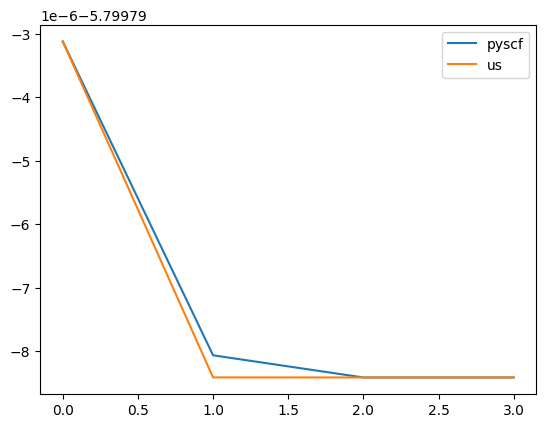

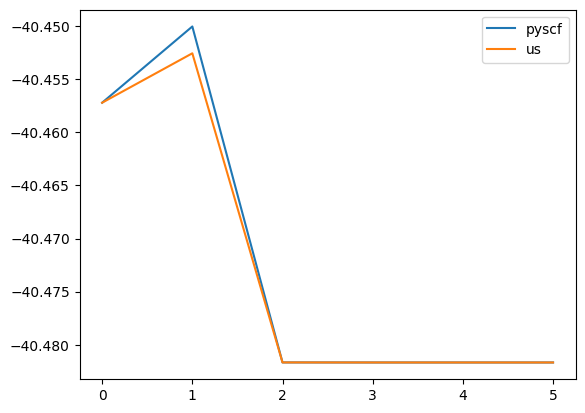

In [45]:
from pyscf.gto.moleintor import make_cintopt, make_loc, ascint3
import textwrap
from tqdm import tqdm
import numpy
from pyscf import scf
from pyscf.scf import hf
from pyscf.scf import _vhf
from pyscf.scf import jk
from pyscf.dft import gen_grid
from pyscf.dft import numint
from pyscf import __config__
from pyscf import lib
from functools import reduce
import numpy
import scipy.linalg
import sys 
import tempfile
import h5py
from pyscf import gto
from pyscf.scf import diis
from pyscf.scf import _vhf
from pyscf.scf import chkfile
from pyscf.data import nist
#import jax.numpy as jnp 

def xc_and_coulomb(ks, mol=None, dm=None, dm_last=0, vhf_last=0, hermi=1):
    '''Coulomb + XC functional
    .. note::
        This function will modify the input ks object.
    Args:
        ks : an instance of :class:`RKS`
            XC functional are controlled by ks.xc attribute.  Attribute
            ks.grids might be initialized.
        dm : ndarray or list of ndarrays
            A density matrix or a list of density matrices
    Kwargs:
        dm_last : ndarray or a list of ndarrays or 0
            The density matrix baseline.  If not 0, this function computes the
            increment of HF potential w.r.t. the reference HF potential matrix.
        vhf_last : ndarray or a list of ndarrays or 0
            The reference Vxc potential matrix.
        hermi : int
            Whether J, K matrix is hermitian
            | 0 : no hermitian or symmetric
            | 1 : hermitian
            | 2 : anti-hermitian
    Returns:
        matrix Veff = J + Vxc.  Veff can be a list matrices, if the input
        dm is a list of density matrices.
    '''
    #if dm is None: dm = ks.make_rdm1()
    #ks.initialize_grids(mol, dm) # <-- only needs to be called once, and I think mol.build() does it? 

    ni            = ks._numint # numerical integrator, depends on xc functional! 
    max_memory    = ks.max_memory - lib.current_memory()[0]
    n, exc, vxc   = ni.nr_rks(mol, ks.grids, ks.xc, dm, max_memory=max_memory)

    #enabling range-separated hybrids
    omega, alpha, hyb = ni.rsh_and_hybrid_coeff(ks.xc, spin=mol.spin)

    if (ks._eri is None and ks.direct_scf and getattr(vhf_last, 'vk', None) is not None):
        ddm = numpy.asarray(dm) - numpy.asarray(dm_last)
        vj, vk = ks.get_jk(mol, ddm, hermi)
        vk *= hyb
        if abs(omega) > 1e-10:  # For range separated Coulomb operator
            vklr = ks.get_k(mol, ddm, hermi, omega=omega)
            vklr *= (alpha - hyb)
            vk += vklr
        vj += vhf_last.vj
        vk += vhf_last.vk
    else:
        vj, vk = ks.get_jk(mol, dm, hermi)
        vk *= hyb
        if abs(omega) > 1e-10:
            vklr = ks.get_k(mol, dm, hermi, omega=omega)
            vklr *= (alpha - hyb)
            vk += vklr
    vxc += vj - vk * .5

    exc   -= numpy.einsum('ij,ji', dm, vk).real * .5 * .5
    ecoul  = numpy.einsum('ij,ji', dm, vj).real * .5

    vxc = lib.tag_array(vxc, E_coulomb=ecoul, E_xc=exc, vj=vj, vk=vk)
    return vxc
    

from pyscf.lib import misc


from pyscf.dft.numint import _rks_gga_wv0, _scale_ao, _dot_ao_ao

from pyscf.dft.gen_grid import make_mask, BLKSIZE

SWITCH_SIZE = getattr(__config__, 'dft_numint_SWITCH_SIZE', 800)
libdft = lib.load_library('libdft')
import ctypes

import _ctypes
libcvhf = lib.load_library('libcvhf')
def _fpointer(name):
    return ctypes.c_void_p(_ctypes.dlsym(libcvhf._handle, name))

def nr_rks_only_GGA(ni, mol, grids, xc_code, dms, relativity=0, hermi=1, max_memory=2000, verbose=None): # this one supports all xcs 
    xctype  = "GGA" 
    
    dms   = dms[numpy.newaxis]
    nao   = dms[0].shape[0] # this is just one?!
    ndms  = len(dms)

    def make_rho(idm, ao, non0tab, xctype):
        dm = dms[idm]

        ngrids, nao = ao[0].shape

        shls_slice = (0, mol.nbas)
        ao_loc = mol.ao_loc_nr()

        rho = numpy.empty((4,ngrids))
        c0 = np.dot(ao[0], dm) 
        rho[0] = numpy.einsum('pi,pi->p', c0, ao[0])
        for i in range(1, 4):
            rho[i] = numpy.einsum('pi,pi->p', c0, ao[i])
            
        rho[1:4] *= 2  
        return rho
        
    nset = ndms

    shls_slice = (0, mol.nbas)
    ao_loc = mol.ao_loc_nr()

    nelec   = numpy.zeros(nset)
    excsum = numpy.zeros(nset)
    vmat = numpy.zeros((nset,nao,nao), dtype=dms.dtype)

    def block_loop(ao_deriv):
        for ao, mask, weight, coords  in ni.block_loop(mol, grids, nao, ao_deriv, max_memory=max_memory):
            for i in range(nset):
                rho = make_rho(i, ao, mask, xctype)
                exc, vxc = ni.eval_xc(xc_code, rho, spin=0,
                                      relativity=relativity, deriv=1,
                                      verbose=verbose)[:2]
                den = rho[0] * weight
                nelec[i] += den.sum()
                excsum[i] += numpy.dot(den, exc)
                yield i, rho, ao, mask, weight, vxc

    aow = None

    ao_deriv = 1
    for i, rho, ao, mask, weight, vxc in block_loop(ao_deriv):
        wv = _rks_gga_wv0(rho, vxc, weight)
        aow = _scale_ao(ao, wv, out=aow)
        vmat[i] += _dot_ao_ao(mol, ao[0], aow, mask, shls_slice, ao_loc)

    for i in range(nset):
        vmat[i] = vmat[i] + vmat[i].conj().T

    if nset == 1:
        nelec = nelec[0]
        excsum = excsum[0]
        vmat = vmat[0]

    return nelec, excsum, vmat


# https://github.com/pyscf/pyscf/blob/16887846a6b30bde495ebf69905de2576f4a3f4a/pyscf/scf/_vhf.py#L303
# no clue what this does. 
def direct(dms, atm, bas, env, vhfopt=None, hermi=0, cart=False,
           with_j=True, with_k=True):

    # weird shape/dtype stuff 
    c_atm = numpy.asarray(atm, dtype=numpy.int32, order='C')
    c_bas = numpy.asarray(bas, dtype=numpy.int32, order='C')
    c_env = numpy.asarray(env, dtype=numpy.double, order='C')
    natm = ctypes.c_int(c_atm.shape[0])
    nbas = ctypes.c_int(c_bas.shape[0])

    dms       = numpy.asarray(dms, order='C', dtype=numpy.double)
    dms_shape = dms.shape
    nao       = dms_shape[-1]
    dms       = dms.reshape(-1,nao,nao)
    n_dm      = dms.shape[0]

    # is this compute? 
    vhfopt.set_dm(dms, atm, bas, env)
    cvhfopt = vhfopt._this
    cintopt = vhfopt._cintopt
    intor = vhfopt._intor

    cintor = _fpointer(intor)

    fdrv = getattr(libcvhf, 'CVHFnr_direct_drv')
    fdot = _fpointer('CVHFdot_nrs8')

    vj = vk = None
    dmsptr = []
    vjkptr = []
    fjk = []

    fvj = _fpointer('CVHFnrs8_ji_s2kl')
    vj = numpy.empty((n_dm,nao,nao))
    for i, dm in enumerate(dms):
        dmsptr.append(dm.ctypes.data_as(ctypes.c_void_p))
        vjkptr.append(vj[i].ctypes.data_as(ctypes.c_void_p))
        fjk.append(fvj)

    if hermi == 1:
        fvk = _fpointer('CVHFnrs8_li_s2kj')
    else:
        fvk = _fpointer('CVHFnrs8_li_s1kj')
    vk = numpy.empty((n_dm,nao,nao))
    for i, dm in enumerate(dms):
        dmsptr.append(dm.ctypes.data_as(ctypes.c_void_p))
        vjkptr.append(vk[i].ctypes.data_as(ctypes.c_void_p))
        fjk.append(fvk)

    shls_slice = (ctypes.c_int*8)(*([0, c_bas.shape[0]]*4))
    ao_loc = make_loc(bas, intor)
    n_ops = len(dmsptr)
    comp = 1
    fdrv(cintor, fdot, (ctypes.c_void_p*n_ops)(*fjk),
         (ctypes.c_void_p*n_ops)(*dmsptr), (ctypes.c_void_p*n_ops)(*vjkptr),
         ctypes.c_int(n_ops), ctypes.c_int(comp),
         shls_slice, ao_loc.ctypes.data_as(ctypes.c_void_p), cintopt, cvhfopt,
         c_atm.ctypes.data_as(ctypes.c_void_p), natm,
         c_bas.ctypes.data_as(ctypes.c_void_p), nbas,
         c_env.ctypes.data_as(ctypes.c_void_p))

    # vj must be symmetric
    for i in range(n_dm):
        lib.hermi_triu(vj[i], 1, inplace=True)
    vj = vj.reshape(dms_shape)
    if hermi != 0:
        for i in range(n_dm):
            lib.hermi_triu(vk[i], hermi, inplace=True)
    vk = vk.reshape(dms_shape)
    return vj, vk


def get_jk(mol, dm, hermi=1, vhfopt=None, with_j=True, with_k=True, omega=None):
    '''Compute J, K matrices for all input density matrices
    Args:
        mol : an instance of :class:`Mole`
        dm : ndarray or list of ndarrays
            A density matrix or a list of density matrices
    Kwargs:
        hermi : int
            Whether J, K matrix is hermitian
            | 0 : not hermitian and not symmetric
            | 1 : hermitian or symmetric
            | 2 : anti-hermitian
        vhfopt :
            A class which holds precomputed quantities to optimize the
            computation of J, K matrices
        with_j : boolean
            Whether to compute J matrices
        with_k : boolean
            Whether to compute K matrices
        omega : float
            Parameter of range-seperated Coulomb operator: erf( omega * r12 ) / r12.
            If specified, integration are evaluated based on the long-range
            part of the range-seperated Coulomb operator.
    Returns:
        Depending on the given dm, the function returns one J and one K matrix,
        or a list of J matrices and a list of K matrices, corresponding to the
        input density matrices.
    Examples:
    >>> from pyscf import gto, scf
    >>> from pyscf.scf import _vhf
    >>> mol = gto.M(atom='H 0 0 0; H 0 0 1.1')
    >>> dms = numpy.random.random((3,mol.nao_nr(),mol.nao_nr()))
    >>> j, k = scf.hf.get_jk(mol, dms, hermi=0)
    >>> print(j.shape)
    (3, 2, 2)
    '''
    # The vhfopt of standard Coulomb operator can be used here as an approximate
    # integral prescreening conditioner since long-range part Coulomb is always
    # smaller than standard Coulomb.  It's safe to filter LR integrals with the
    # integral estimation from standard Coulomb.
    #with mol.with_range_coulomb(omega): 
    vj, vk = direct(dm, mol._atm, mol._bas, mol._env, vhfopt, hermi, mol.cart, with_j, with_k) # ...

    vj = vj.reshape(dm.shape)
    vk = vk.reshape(dm.shape)
        
    return vj, vk

class RKS(): # moved everything into one class! i.e. removed inheritance dependency 

    diis       = getattr(__config__, 'scf_hf_SCF_diis', True)
    diis_space = getattr(__config__, 'scf_hf_SCF_diis_space', 8)
    # need > 0 if initial DM is numpy.zeros array
    diis_start_cycle = getattr(__config__, 'scf_hf_SCF_diis_start_cycle', 1)

    damp            = getattr(__config__, 'scf_hf_SCF_damp', 0)
    level_shift     = getattr(__config__, 'scf_hf_SCF_level_shift', 0)
    direct_scf      = getattr(__config__, 'scf_hf_SCF_direct_scf', True)
    direct_scf_tol  = getattr(__config__, 'scf_hf_SCF_direct_scf_tol', 1e-13)

    def __init__(self, mol, xc='LDA,VWN'):

        self.mol = mol
        self.verbose = mol.verbose
        self.max_memory = mol.max_memory
        self.stdout = mol.stdout

        self.opt = None
        self._eri = None # Note: self._eri requires large amount of memory
        
        self.xc = xc
        self.nlc = ''
        self.grids = gen_grid.Grids(self.mol)
        self.grids.level = getattr(__config__, 'dft_rks_RKS_grids_level',
                                self.grids.level)
        self.nlcgrids = gen_grid.Grids(self.mol)
        self.nlcgrids.level = getattr(__config__, 'dft_rks_RKS_nlcgrids_level',
                                    self.nlcgrids.level)
        # Use rho to filter grids
        self.small_rho_cutoff = getattr(__config__, 'dft_rks_RKS_small_rho_cutoff', 1e-7)
        self._numint = numint.NumInt()
        self.max_cycle = 50


    def get_jk(self, mol=None, dm=None, hermi=1, with_j=True, with_k=True, # called outside of main for loop. 
               omega=None):
        if mol is None: mol = self.mol
        # print("###") # called outside main loop! 

        if dm is None: dm = self.make_rdm1()
        if self.direct_scf and self.opt is None:
            self.opt = self.init_direct_scf(mol)

        if with_j and with_k:
            vj, vk = hf.get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)
        else:
            if with_j:
                prescreen = 'CVHFnrs8_vj_prescreen'
            else:
                prescreen = 'CVHFnrs8_vk_prescreen'
            with lib.temporary_env(self.opt, prescreen=prescreen):
                vj, vk = get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)

        return vj, vk


    def init_direct_scf(self, mol=None):
        # Integrals < direct_scf_tol may be set to 0 in int2e.
        # Higher accuracy is required for Schwartz inequality prescreening.
        with mol.with_integral_screen(self.direct_scf_tol**2):
            opt = _vhf.VHFOpt(mol, 'int2e', 'CVHFnrs8_prescreen',
                              'CVHFsetnr_direct_scf',
                              'CVHFsetnr_direct_scf_dm')
            opt.direct_scf_tol = self.direct_scf_tol
        return opt

    def kernel(self, convergence_tolerance=1e-10): 
      mol       = self.mol
      e_tot     = -1  
      converged = False

      # Init Stuff 
      dm              = hf.init_guess_by_minao(mol)         # <-- a few hundred lines of code in hf.py  (4, 4)
      V_xc            = xc_and_coulomb(self, mol, dm)       # <--- Coulomb + XC functional (this is the part that changes)  (4, 4)
      h1e             = mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc') # <--- gets fixed part of hamiltonian which doesn't change (4, 4)
      
      # Initial code solve generalized eigen problem scipy.linalg.eigh( A, B )
      # We turn this into normal eig problem scipy.linalg.eigh(L_inv@B@Linv.T) where LL.T = B is cholesky(B)
      s1e   = mol.intor_symmetric('int1e_ovlp')             # <-- overlap matrix;; is this electron by electonr? dont think so (4, 4) ;; we add it to the generalized eigensolver? 
      L     = np.linalg.cholesky(s1e)
      L_inv = np.linalg.inv(L)

      nuclear_energy  = mol.energy_nuc()
      n_electrons     = mol.nelectron

      mf_diis_space     = self.diis_space # usually 8


      #e_idx   = numpy.argsort(mo_energy)
      e_idx                           = np.arange(V_xc.shape[0])
      mo_occ                          = numpy.zeros(V_xc.shape[0])
      mo_occ[e_idx[:n_electrons//2]]  = 2 
      mo_occ_nnz                      = mo_occ[mo_occ>0] 

      #pbar = tqdm(range(self.max_cycle))
      pbar = None 


      if pbar is None: pbar = range(self.max_cycle)

      # four pain points
      # mf_diis.update
      # eigh(a, b) -> eigh(b_inv, a)

      # five things left to refactor
      mf_diis_vs = []
      mf_diis_xs = []

      mf_diis_H = np.zeros((mf_diis_space+1,mf_diis_space+1), np.float64)
      mf_diis_H[0,1:] = mf_diis_H[1:,0] = 1
      mf_diis_head   = 0

      d, hamil_d = np.prod(h1e.shape), np.prod(h1e.shape)
      _V = np.zeros((mf_diis_space, d))
      _H = np.zeros((mf_diis_space, d))
      energies = [ ]

      for cycle in pbar: # jax jit the inner part of this for loop and compare time!
          dm_last           = dm        
          last_hf_e         = e_tot

          hamiltonian       = h1e + V_xc

          sdf               = s1e @ dm @ hamiltonian
          errvec            = sdf.T - sdf

          # ============ STRAT DIIS =============== #
          # See https://en.wikipedia.org/wiki/DIIS 
          # All numpy, can be jaxed! 
          jnp = np 
          errvec      = jnp.array(errvec)
          hamiltonian = jnp.array(hamiltonian)
          d           = errvec.shape[0]*errvec.shape[1]
          hamil_d     = hamiltonian.shape[0] * hamiltonian.shape[1]

          dt = errvec.reshape(-1)

          if mf_diis_head >= mf_diis_space: 
            mf_diis_head   = 0
            mf_diis_vs[0]   = errvec.reshape(-1) 
            mf_diis_xs[0]   = hamiltonian.reshape(-1) 
          else:
            mf_diis_vs.append( errvec.reshape(-1)      )
            mf_diis_xs.append( hamiltonian.reshape(-1) )

          _V[mf_diis_head] = dt
          _H[mf_diis_head] = hamiltonian.reshape(-1)

          mf_diis_head += 1

          nd = mf_diis_head#cycle# len(mf_diis_vs) 
          if nd >= mf_diis_space: nd = mf_diis_space 

          #dt = mf_diis_vs[-1]

          # Do all inner products between last vector and all the others. 
          # store as row/col in matrix. 
          # previous code did this with for loops. 
          #tmps = jnp.array(mf_diis_vs).reshape(len(mf_diis_vs), 1, d) @ dt.reshape(1, d, 1)
          tmps = _V[:nd].reshape(-1, 1, d) @ dt.reshape(1, d, 1)
          mf_diis_H[mf_diis_head, 1:nd+1] = tmps.reshape(-1)[:nd]
          mf_diis_H[1:nd+1, mf_diis_head] = tmps.reshape(-1)[:nd]
          
          # Compute H^-1@[1, 0, ..., 0] using eigh. 
          g     = jnp.concatenate((jnp.ones(1), jnp.zeros(nd)))
          h     = mf_diis_H[:nd+1,:nd+1]
          w, v  = scipy.linalg.eigh(h)
          idx   = abs(w)>1e-14
          c     = (v[:,idx]/w[idx]) @ (v[:,idx].T @ g)

          d_    = c[1:].shape[0]
          #xnew  = jnp.sum( jnp.array(mf_diis_xs[:d_]) * c[1:].reshape(d_, 1), axis=0) 
          xnew  = jnp.sum( _H[:d_] * c[1:].reshape(d_, 1), axis=0) 

          hamiltonian = xnew.reshape(hamiltonian.shape)
          hamiltonian = np.array(hamiltonian)
          # ============ END DIIS =============== #


          # Solve generalized eigenproblem using normal eigh solver using this trick: https://www.jstor.org/stable/2949370
          eigvals, eigvects = np.linalg.eigh(L_inv @ hamiltonian @ L_inv.T)  
          eigvects          = L_inv.T @ eigvects 

          # Reconstruct density matrix using eigenvectors. 
          dm                = (eigvects[:, mo_occ>0] * mo_occ_nnz) @ eigvects[:, mo_occ>0].T 

          # This is the part that changes each iteration. 
          # It computes both coulomb stuff and XC. 
          if True: 
            vhf_last      = V_xc 

            #n, E_xc, V_xc     = self._numint.nr_rks(mol, self.grids, self.xc, dm) 
            n, E_xc, V_xc     = nr_rks_only_GGA(self._numint, mol, self.grids, self.xc, dm)  # <-----  refactored into a single function with numpy stuff 
            #omega, alpha, hyb = rsh_and_hybrid_coeff(self._numint, self.xc, spin=mol.spin) # <----- 
            #omega, alpha, beta = self._numint.libxc.rsh_coeff(self.xc) 
            from pyscf.dft import libxc
            omega, alpha, beta = libxc.rsh_coeff(self.xc) 

            if abs(omega) > 1e-10:  hyb = alpha + beta # omega is mostly 0. 
            else:                   hyb = libxc.hybrid_coeff(self.xc, mol.spin) 

            #vj, vk = self.get_jk(mol, dm - dm_last, hermi=True) # <----- 
            #get_jk(self, mol=None, dm=None, hermi=1, with_j=True, with_k=True, omega=None):
            with_j = True
            with_k = True
            hermi = 1

            if self.direct_scf and self.opt is None:
                self.opt = self.init_direct_scf(mol)

            vj, vk = get_jk(mol, dm-dm_last, hermi, self.opt, True, True, omega)
            
            vk    *= hyb
            vj    += vhf_last.vj
            vk    += vhf_last.vk

            V_xc += vj - vk * .5

            E_xc      = E_xc - np.sum(dm* vk.T) * .5 * .5
            E_coulomb = np.sum(dm*vj.T) * .5

            V_xc = lib.tag_array(V_xc, E_coulomb=E_coulomb, E_xc=E_xc, vj=vj, vk=vk) # <---- 

          # Compute energy. Currently only used to check for convergence. 
          #e_tot =  numpy.einsum('ij,ji->', h1e, dm) + E_coulomb + E_xc + nuclear_energy
          e_tot =  np.sum(h1e*dm.T) + E_coulomb + E_xc + nuclear_energy

          if type(pbar) != type(range(0,1)): pbar.set_description("E=%4f change=%4e tolerance=%4e"%(e_tot, abs(e_tot-last_hf_e), convergence_tolerance))

          energies.append(e_tot)

          if abs(e_tot-last_hf_e) < convergence_tolerance:
              converged = True
              break

      self.converged, self.e_tot,  self.mo_energy, self.mo_coeff, self.mo_occ =  converged, e_tot, eigvals, eigvects, mo_occ
      return self.e_tot , energies


def jax_scf(str):
  basis_set ="6-31G*"
  xc_fun    ="b3lyp"

  # So PCQ uses eV and PySCF uses Hartree 
  eV_to_hartree    = 0.0367493
  hartree_to_eV    = 27.2114
  angstrom_to_bohr = 1.88973

  from pyscf.gto import mole  # <--- this file is 2000 lines of code

  t0 = time.time()
  mol = mole.Mole()

  #print("building molecule:")
  mol.build(atom=str, unit="Bohr", basis=basis_set, spin=0)
  #print(time.time()-t0)

  mol.verbose = 0 
  mf = RKS(mol) 
  mf.xc = xc_fun 

  t0 = time.time()
  energy, energies = mf.kernel()
  t = time.time()-t0
  #print("Us", t)

  lumo = np.argmin(mf.mo_occ)
  homo = lumo - 1
  hl_gap_hartree = np.abs(mf.mo_energy[homo] - mf.mo_energy[lumo])
  hlgap = hartree_to_eV*hl_gap_hartree
  return energy, hlgap , t, energies

#(our_fun=jax_scf, list=[0, -1]) 
#test_cases(our_fun=jax_scf, list=[0,1,5,6,12], verbose=True) 
#test_cases(our_fun=jax_scf, list=[12], verbose=True) 
#test_cases(our_fun=jax_scf, list=[10**3], verbose=True) 
#test_cases(our_fun=jax_scf, list=[12], verbose=True)
#test_cases(our_fun=jax_scf, list=[1,5,12], verbose=True)
#test_cases(our_fun=jax_scf,  verbose=True)
#test_cases(our_fun=jax_scf,  list=[51], verbose=True)
#test_cases(our_fun=jax_scf,  verbose=True)

#test_cases(our_fun=jax_scf,  list=[72], verbose=True, spin=0)
test_cases(our_fun=jax_scf,  list=[0,4,7], verbose=True, spin=0)

# There is a little bit of an difference. 
# Figure out what is causing this. 
# Some of the pop stuff maybe? I.e., I'm using maybe the first 8 instead of the last 8 vectors? 


#|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
#NNN	 -163.55761493905166 2.1803273321133956 1661606786.9424162


In [ ]:
# before fixing mistake in the DIIS thing with which vs we used; very dumb indexing stuff. 
'''

|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
|            HeHe |   -5.800 47.014 |   -5.800 47.014 |     0.000 0.000 |       47.014227 |          8.648244s |          1.156512s |
|          HeHeHe |   -8.700 46.375 |   -8.700 46.375 |     0.000 0.000 |       46.374526 |          3.726107s |          1.430966s |
|           CHHHH |  -40.482 13.791 |  -40.482 13.791 |     0.000 0.000 |       13.791238 |         13.132909s |          5.170950s |
|            NHHH |   -56.510 9.031 |   -56.510 9.031 |     0.000 0.000 |        9.031433 |         14.864953s |          4.374274s |
|             OHH |   -76.370 9.664 |   -76.370 9.664 |     0.000 0.000 |        9.663530 |          3.907456s |          1.521023s |
|            BeBe |   -29.316 2.950 |   -29.316 2.950 |     0.000 0.000 |        2.950380 |          3.256210s |          1.293245s |
|              FH | -100.380 11.927 | -100.380 11.927 |     0.000 0.000 |       11.926626 |          2.598700s |          0.869146s |
|              BB |   -49.331 1.392 |   -49.331 1.392 |     0.000 0.000 |        1.391719 |          3.486710s |          1.640415s |
|           CBHHH |   -64.584 4.316 |   -64.584 4.316 |     0.000 0.000 |        4.316270 |          7.777903s |          3.499175s |
|             CNH |   -93.317 6.937 |   -93.317 6.937 |     0.000 0.000 |        6.936827 |          6.668241s |          2.484438s |
|              CO |  -113.255 9.514 |  -113.255 9.514 |     0.000 0.000 |        9.514093 |          4.387991s |          1.637958s |
|              NN | -109.469 10.956 | -109.469 10.956 |     0.000 0.000 |       10.955941 |          3.135062s |          1.400207s |
|             BOH |  -100.570 5.856 |  -100.570 5.856 |     0.000 0.000 |        5.855930 |          5.665437s |          2.528086s |
|          CCHHHH |   -78.528 7.762 |   -78.528 7.762 |     0.000 0.000 |        7.762187 |          9.631075s |          4.412052s |
|          CCHHHH |   -78.382 2.238 |   -78.382 2.238 |     0.000 0.000 |        2.237800 |          9.034898s |          4.882320s |
|         CBHHHHH |   -65.888 7.545 |   -65.888 7.545 |     0.000 0.000 |        7.545447 |          9.285303s |          4.915003s |
|           CNHHH |   -94.566 7.026 |   -94.566 7.026 |     0.000 0.000 |        7.026055 |          8.537408s |          3.853996s |
|           CNHHH |   -94.392 1.149 |   -94.392 1.149 |     0.000 0.000 |        1.148909 |         14.675802s |          4.010456s |
HLGAP NOT ALL CLOSE:  1.1489087573542915 1.1487209933027889
|           CNHHH |   -94.416 1.668 |   -94.416 1.667 |     0.000 0.002 |        1.668245 |         19.818224s |          3.875858s |
HLGAP NOT ALL CLOSE:  1.6682450939997249 1.6665348136082208
|            NNHH |  -110.575 5.121 |  -110.575 5.121 |     0.000 0.000 |        5.120505 |          6.409553s |          3.335006s |
|            NNHH |  -110.507 3.081 |  -110.507 3.081 |     0.000 0.000 |        3.081395 |          7.556499s |          3.427968s |
HLGAP NOT ALL CLOSE:  3.0813952568886975 3.0813182749708785
|           BOHHH |  -101.846 8.374 |  -101.846 8.374 |     0.000 0.000 |        8.373739 |          7.714493s |          4.153536s |
|        CCHHHHHH |  -79.764 12.100 |  -79.764 12.100 |     0.000 0.000 |       12.099644 |         12.853813s |          5.877259s |
|             NOH |  -130.334 2.634 |  -130.334 2.634 |     0.000 0.000 |        2.633641 |          5.686754s |          2.676372s |
|             NOH |  -130.405 3.748 |  -130.405 3.748 |     0.000 0.000 |        3.748121 |          5.669729s |          3.778989s |
|         CNHHHHH |   -95.786 8.537 |   -95.786 8.537 |     0.000 0.000 |        8.536951 |         10.291670s |          5.125296s |
|              OO |  -150.194 1.928 |  -150.194 1.928 |     0.000 0.000 |        1.928446 |          3.445745s |          1.380396s |
|          SiHHHH | -291.815 10.968 | -291.815 10.968 |     0.000 0.000 |       10.968165 |          6.426434s |          3.085057s |
|          COHHHH |  -115.646 9.270 |  -115.646 9.270 |     0.000 0.000 |        9.270090 |          8.877901s |          4.931097s |
|          COHHHH |  -115.646 9.276 |  -115.646 9.276 |     0.000 0.000 |        9.275525 |          9.623204s |          4.841827s |
|          NNHHHH |  -111.785 7.530 |  -111.785 7.530 |     0.000 0.000 |        7.529910 |          8.073824s |          4.254381s |
|          NNHHHH |  -111.785 7.544 |  -111.785 7.544 |     0.000 0.000 |        7.544157 |         10.506208s |          3.872722s |
|           NOHHH |  -131.635 9.147 |  -131.635 9.147 |     0.000 0.000 |        9.147203 |          7.644502s |          4.079151s |
|           NOHHH |  -131.635 9.148 |  -131.635 9.148 |     0.000 0.000 |        9.147684 |          7.686733s |          4.098671s |
|             SHH |  -399.314 7.646 |  -399.314 7.646 |     0.000 0.000 |        7.645573 |          4.627505s |          1.945266s |
|            PHHH |  -343.070 8.367 |  -343.070 8.367 |     0.000 0.000 |        8.366684 |          5.850267s |          2.389126s |
|            OOHH |  -151.461 7.269 |  -151.461 7.269 |     0.000 0.000 |        7.268959 |          7.061239s |          3.096621s |
|           CFHHH | -139.665 11.911 | -139.665 11.911 |     0.000 0.000 |       11.910937 |          7.748433s |          3.764197s |
|            FNHH |  -155.634 8.625 |  -155.634 8.625 |     0.000 0.000 |        8.624578 |          6.332021s |          3.247642s |
|            FNHH |  -155.634 8.644 |  -155.634 8.644 |     0.000 0.000 |        8.644439 |          6.371315s |          3.115090s |
|             ClH |  -460.723 9.285 |  -460.723 9.285 |     0.000 0.000 |        9.285449 |          3.638916s |          1.351151s |
|             FOH |  -175.452 7.236 |  -175.452 7.236 |     0.000 0.000 |        7.236418 |          6.653296s |          2.491437s |
|             FOH |  -175.452 7.215 |  -175.452 7.215 |     0.000 0.000 |        7.215245 |          5.030273s |          2.476949s |
|            CCBH |  -101.390 2.847 |  -101.390 2.847 |     0.000 0.000 |        2.847036 |          8.779498s |          4.701084s |
|           CBBHH |   -88.648 1.188 |   -88.648 1.188 |     0.000 0.000 |        1.188174 |         11.632784s |          5.633025s |
HLGAP NOT ALL CLOSE:  1.188174332688808 1.1881984169418656
|              FF |  -199.427 7.214 |  -199.427 7.214 |     0.000 0.000 |        7.213870 |          2.991563s |          1.374190s |
|           CCCHH |  -115.191 4.470 |  -115.191 4.470 |     0.000 0.000 |        4.470073 |         10.524400s |          5.816578s |
HLGAP NOT ALL CLOSE:  4.470073025234947 4.470012276259754
|          CCBHHH |  -102.629 2.629 |  -102.629 2.629 |     0.000 0.000 |        2.628895 |         12.067565s |          6.674954s |
HLGAP NOT ALL CLOSE:  2.628895281047362 2.6287775879133806
|          CCBHHH |  -102.531 0.991 |  -102.476 0.367 |     0.055 0.624 |        0.991112 |         24.890992s |         32.801660s |
ENERGY NOT ALL CLOSE:  -102.53118389019605 -102.47590398962933
HLGAP NOT ALL CLOSE:  0.9911117127725072 0.3671492273992896
|         CBBHHHH |   -89.947 1.132 |   -89.947 1.132 |     0.000 0.000 |        1.131764 |         12.370988s |          7.582662s |
|           CBNHH |  -118.656 2.482 |  -118.656 2.482 |     0.000 0.000 |        2.481551 |         10.419981s |          5.651610s |
HLGAP NOT ALL CLOSE:  2.481550701979845 2.4816241739167184
|           CBNHH |  -118.705 1.203 |  -118.705 1.146 |     0.000 0.057 |        1.203208 |         11.517459s |         27.235286s |
HLGAP NOT ALL CLOSE:  1.2032083665101905 1.1463430243974206
|          BBNHHH |  -106.046 2.051 |  -106.046 2.051 |     0.000 0.000 |        2.050533 |         10.990409s |          6.765028s |
|             CCO |  -151.114 4.065 |  -151.114 4.065 |     0.000 0.000 |        4.064776 |          6.548260s |          4.022185s |
|            BNNH |  -134.683 0.366 |  -134.683 0.464 |     0.000 0.099 |        0.365659 |         13.637281s |         22.739383s |
HLGAP NOT ALL CLOSE:  0.3656589519012481 0.46429056931946905
|         CCCHHHH |  -116.570 8.750 |  -116.570 8.750 |     0.000 0.000 |        8.750206 |         12.295995s |          7.451349s |

'''

after fixing mistake with vectors and hamiltonians list indexxing. made it into a fixed matrix instead. 

In [ ]:
|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
|            HeHe |   -5.800 47.014 |   -5.800 47.014 |     0.000 0.000 |       47.014227 |          3.946216s |          2.044458s |
|          HeHeHe |   -8.700 46.375 |   -8.700 46.375 |     0.000 0.000 |       46.374526 |         21.844535s |          2.183072s |
|           CHHHH |  -40.482 13.791 |  -40.482 13.791 |     0.000 0.000 |       13.791238 |          6.148042s |         11.191468s |
|            NHHH |   -56.510 9.031 |   -56.510 9.031 |     0.000 0.000 |        9.031433 |         13.060318s |          3.223684s |
|             OHH |   -76.370 9.664 |   -76.370 9.664 |     0.000 0.000 |        9.663530 |         16.004857s |          3.149574s |
|            BeBe |   -29.316 2.950 |   -29.316 2.950 |     0.000 0.000 |        2.950380 |         17.479669s |          7.447500s |
|              FH | -100.380 11.927 | -100.380 11.927 |     0.000 0.000 |       11.926626 |          2.587473s |          2.981072s |
|              BB |   -49.331 1.392 |   -49.331 1.392 |     0.000 0.000 |        1.391719 |          3.620085s |          2.929992s |
|           CBHHH |   -64.584 4.316 |   -64.584 4.316 |     0.000 0.000 |        4.316270 |          8.057517s |          7.074324s |
|             CNH |   -93.317 6.937 |   -93.317 6.937 |     0.000 0.000 |        6.936827 |          5.242675s |          4.363572s |
|              CO |  -113.255 9.514 |  -113.255 9.514 |     0.000 0.000 |        9.514093 |          3.951830s |          2.879045s |
|              NN | -109.469 10.956 | -109.469 10.956 |     0.000 0.000 |       10.955941 |          3.139610s |          2.767449s |
|             BOH |  -100.570 5.856 |  -100.570 5.856 |     0.000 0.000 |        5.855930 |          5.891143s |          4.472005s |
|          CCHHHH |   -78.528 7.762 |   -78.528 7.762 |     0.000 0.000 |        7.762187 |          9.126054s |          7.451558s |
|          CCHHHH |   -78.382 2.238 |   -78.382 2.238 |     0.000 0.000 |        2.237800 |          9.031962s |          9.186244s |
|         CBHHHHH |   -65.888 7.545 |   -65.888 7.545 |     0.000 0.000 |        7.545447 |          9.483610s |          9.514282s |
|           CNHHH |   -94.566 7.026 |   -94.566 7.026 |     0.000 0.000 |        7.026055 |          8.618021s |          7.381205s |
|           CNHHH |   -94.392 1.149 |   -94.392 1.149 |     0.000 0.000 |        1.148909 |         12.400326s |         10.056666s |
|           CNHHH |   -94.416 1.668 |   -94.416 1.668 |     0.000 0.000 |        1.668245 |         20.041689s |         13.684859s |
|            NNHH |  -110.575 5.121 |  -110.575 5.121 |     0.000 0.000 |        5.120505 |          6.375615s |          5.253380s |
|            NNHH |  -110.507 3.081 |  -110.507 3.081 |     0.000 0.000 |        3.081395 |          7.013957s |          6.579846s |
|           BOHHH |  -101.846 8.374 |  -101.846 8.374 |     0.000 0.000 |        8.373739 |          7.883361s |          7.052726s |
|        CCHHHHHH |  -79.764 12.100 |  -79.764 12.100 |     0.000 0.000 |       12.099644 |         11.714560s |         10.520506s |
|             NOH |  -130.334 2.634 |  -130.334 2.634 |     0.000 0.000 |        2.633641 |          5.786830s |          5.307134s |
|             NOH |  -130.405 3.748 |  -130.405 3.748 |     0.000 0.000 |        3.748121 |          5.631088s |          5.837390s |
|         CNHHHHH |   -95.786 8.537 |   -95.786 8.537 |     0.000 0.000 |        8.536951 |         10.489380s |          8.816302s |
|              OO |  -150.194 1.928 |  -150.194 1.928 |     0.000 0.000 |        1.928446 |          3.456538s |          2.994281s |
|          SiHHHH | -291.815 10.968 | -291.815 10.968 |     0.000 0.000 |       10.968165 |          6.431630s |          5.390022s |
|          COHHHH |  -115.646 9.270 |  -115.646 9.270 |     0.000 0.000 |        9.270090 |          9.144097s |          9.699952s |
|          COHHHH |  -115.646 9.276 |  -115.646 9.276 |     0.000 0.000 |        9.275525 |          9.171911s |          9.521091s |
|          NNHHHH |  -111.785 7.530 |  -111.785 7.530 |     0.000 0.000 |        7.529910 |          8.219748s |          8.452628s |
|          NNHHHH |  -111.785 7.544 |  -111.785 7.544 |     0.000 0.000 |        7.544157 |          8.983248s |          8.214878s |
|           NOHHH |  -131.635 9.147 |  -131.635 9.147 |     0.000 0.000 |        9.147203 |          7.793789s |          6.735430s |
|           NOHHH |  -131.635 9.148 |  -131.635 9.148 |     0.000 0.000 |        9.147684 |          7.734021s |          6.957144s |
|             SHH |  -399.314 7.646 |  -399.314 7.646 |     0.000 0.000 |        7.645573 |          4.856555s |          3.407166s |
|            PHHH |  -343.070 8.367 |  -343.070 8.367 |     0.000 0.000 |        8.366684 |          6.032709s |          4.419343s |
|            OOHH |  -151.461 7.269 |  -151.461 7.269 |     0.000 0.000 |        7.268959 |          7.162386s |          5.561119s |
|           CFHHH | -139.665 11.911 | -139.665 11.911 |     0.000 0.000 |       11.910937 |          8.018272s |          6.331187s |
|            FNHH |  -155.634 8.625 |  -155.634 8.625 |     0.000 0.000 |        8.624578 |          6.457279s |          6.135514s |
|            FNHH |  -155.634 8.644 |  -155.634 8.644 |     0.000 0.000 |        8.644439 |          6.433889s |          5.429241s |
|             ClH |  -460.723 9.285 |  -460.723 9.285 |     0.000 0.000 |        9.285449 |          3.661867s |          2.464068s |
|             FOH |  -175.452 7.236 |  -175.452 7.236 |     0.000 0.000 |        7.236418 |          5.237521s |          4.555957s |
|             FOH |  -175.452 7.215 |  -175.452 7.215 |     0.000 0.000 |        7.215245 |          5.191525s |          4.508778s |
|            CCBH |  -101.390 2.847 |  -101.390 2.847 |     0.000 0.000 |        2.847036 |          9.135454s |          8.788260s |
|           CBBHH |   -88.648 1.188 |   -88.648 1.188 |     0.000 0.000 |        1.188174 |         11.835745s |         11.187227s |
|              FF |  -199.427 7.214 |  -199.427 7.214 |     0.000 0.000 |        7.213870 |          3.083247s |          3.317594s |
|           CCCHH |  -115.191 4.470 |  -115.191 4.470 |     0.000 0.000 |        4.470073 |         10.783576s |         11.116367s |
|          CCBHHH |  -102.629 2.629 |  -102.629 2.629 |     0.000 0.000 |        2.628895 |         12.397007s |         12.937927s |
|          CCBHHH |  -102.531 0.991 |  -102.531 0.991 |     0.000 0.000 |        0.991112 |         25.599710s |         19.897634s |
|         CBBHHHH |   -89.947 1.132 |   -89.947 1.132 |     0.000 0.000 |        1.131764 |         12.798407s |         18.269226s |
|           CBNHH |  -118.656 2.482 |  -118.656 2.482 |     0.000 0.000 |        2.481551 |         10.954171s |         10.140811s |
|           CBNHH |  -118.705 1.203 |  -118.705 1.203 |     0.000 0.000 |        1.203208 |         11.792770s |         12.114649s |
|          BBNHHH |  -106.046 2.051 |  -106.046 2.051 |     0.000 0.000 |        2.050533 |         11.376890s |         13.275199s |
|             CCO |  -151.114 4.065 |  -151.114 4.065 |     0.000 0.000 |        4.064776 |          6.726305s |          7.498060s |
|            BNNH |  -134.683 0.366 |  -134.683 0.366 |     0.000 0.000 |        0.365659 |         13.852660s |         11.544541s |
|         CCCHHHH |  -116.570 8.750 |  -116.570 8.750 |     0.000 0.000 |        8.750206 |         12.564311s |         12.632108s |
|         CCCHHHH |  -116.570 8.749 |  -116.570 8.749 |     0.000 0.000 |        8.749132 |         12.534466s |         13.220490s |
|         CCCHHHH |  -116.491 4.792 |  -116.491 4.792 |     0.000 0.000 |        4.791748 |         13.745967s |         16.621652s |
|         CCCHHHH |  -116.575 7.707 |  -116.575 7.707 |     0.000 0.000 |        7.706821 |         12.499618s |         13.894289s |
|         CCCHHHH |  -116.449 2.734 |  -116.449 2.734 |     0.000 0.000 |        2.733987 |         12.684780s |         13.332968s |
|         CCCHHHH |  -116.491 4.799 |  -116.491 4.799 |     0.000 0.000 |        4.798765 |         13.805573s |         15.366319s |
|        CCBHHHHH |  -103.864 4.292 |  -103.864 4.292 |     0.000 0.000 |        4.292078 |         14.107213s |         16.643234s |
|          CCNHHH |  -132.671 9.854 |  -132.671 9.854 |     0.000 0.000 |        9.854005 |         12.051680s |         13.616117s |
|          CCNHHH |  -132.487 2.167 |  -132.487 2.167 |     0.000 0.000 |        2.167458 |         14.258151s |         15.677778s |
|          CCNHHH |  -132.627 6.337 |  -132.627 6.337 |     0.000 0.000 |        6.337105 |         12.134757s |         12.566872s |
|          CCNHHH |  -132.671 9.887 |  -132.671 9.887 |     0.000 0.000 |        9.886572 |         11.982649s |         12.934431s |
|          CCNHHH |  -132.449 2.173 |  -132.449 2.173 |     0.000 0.000 |        2.173308 |         10.994990s |         11.881457s |
|         CBNHHHH |  -119.881 3.972 |  -119.881 3.972 |     0.000 0.000 |        3.972240 |         13.860851s |         14.453627s |
|         CBNHHHH |  -119.955 4.660 |  -119.955 4.660 |     0.000 0.000 |        4.659908 |         13.946244s |         13.818783s |
NNN
---------------------------------------------------------------------------
RuntimeError                              Traceback (most recent call last)
<ipython-input-73-57c11088d9a7> in <module>
    567 #test_cases(our_fun=jax_scf,  verbose=True)
    568 #test_cases(our_fun=jax_scf,  list=[51], verbose=True)
--> 569 test_cases(our_fun=jax_scf,  verbose=True)
    570 
    571 

4 frames
/usr/local/lib/python3.7/dist-packages/pyscf/gto/mole.py in nelec(self)
   2158             raise RuntimeError('Electron number %d and spin %d are not consistent\n'
   2159                                'Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1' %
-> 2160                                (ne, self.spin))
   2161         return nalpha, nbeta
   2162     @nelec.setter

RuntimeError: Electron number 21 and spin 0 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1

# Step 14: 8/27/2022: prettified code. only 2 functions left they we can jax.jit the body 

|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
HeHe	 -5.799798410857481 47.014247912150644 0.23873257637023926
>pyscf
[-5.799793123445306, -5.799798061919511, -5.799798410811429, -5.799798410811634]
>us
[-5.799793123492622, -5.799798409615177, -5.799798410852875, -5.799798410857481]

|            HeHe |   -5.800 47.014 |   -5.800 47.014 |     0.000 0.000 |       47.014227 |          1.227351s |          0.238733s |


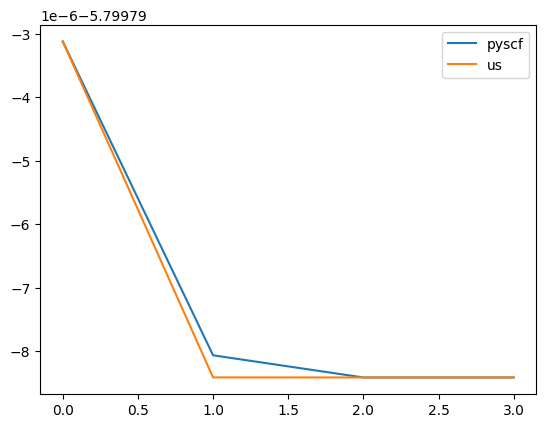

In [62]:
from pyscf.gto.moleintor import make_loc
from tqdm import tqdm
import numpy 
from pyscf import scf
from pyscf.scf import hf
from pyscf.scf import _vhf
from pyscf.scf import jk
from pyscf.dft import gen_grid
from pyscf.dft import numint
from pyscf import __config__
from pyscf import lib
from functools import reduce
import scipy.linalg
import sys 
import tempfile
import h5py
from pyscf import gto
from pyscf.scf import diis
from pyscf.scf import _vhf
from pyscf.scf import chkfile
from pyscf.data import nist
#import jax.numpy as jnp 

from pyscf.lib import misc
from pyscf.dft.numint import _rks_gga_wv0, _scale_ao, _dot_ao_ao
from pyscf.dft.gen_grid import make_mask, BLKSIZE
import ctypes
import _ctypes

SWITCH_SIZE = getattr(__config__, 'dft_numint_SWITCH_SIZE', 800)
libdft = lib.load_library('libdft')
libcvhf = lib.load_library('libcvhf')

def xc_and_coulomb(ks, mol=None, dm=None, dm_last=0, vhf_last=0, hermi=1):
    '''Coulomb + XC functional
    .. note::
        This function will modify the input ks object.
    Args:
        ks : an instance of :class:`RKS`
            XC functional are controlled by ks.xc attribute.  Attribute
            ks.grids might be initialized.
        dm : ndarray or list of ndarrays
            A density matrix or a list of density matrices
    Kwargs:
        dm_last : ndarray or a list of ndarrays or 0
            The density matrix baseline.  If not 0, this function computes the
            increment of HF potential w.r.t. the reference HF potential matrix.
        vhf_last : ndarray or a list of ndarrays or 0
            The reference Vxc potential matrix.
        hermi : int
            Whether J, K matrix is hermitian
            | 0 : no hermitian or symmetric
            | 1 : hermitian
            | 2 : anti-hermitian
    Returns:
        matrix Veff = J + Vxc.  Veff can be a list matrices, if the input
        dm is a list of density matrices.
    '''
    #if dm is None: dm = ks.make_rdm1()
    #ks.initialize_grids(mol, dm) # <-- only needs to be called once, and I think mol.build() does it? 

    ni            = ks._numint # numerical integrator, depends on xc functional! 
    max_memory    = ks.max_memory - lib.current_memory()[0]
    n, exc, vxc   = ni.nr_rks(mol, ks.grids, ks.xc, dm, max_memory=max_memory)

    #enabling range-separated hybrids
    omega, alpha, hyb = ni.rsh_and_hybrid_coeff(ks.xc, spin=mol.spin)

    if (ks._eri is None and ks.direct_scf and getattr(vhf_last, 'vk', None) is not None):
        ddm = numpy.asarray(dm) - numpy.asarray(dm_last)
        vj, vk = ks.get_jk(mol, ddm, hermi)
        vk *= hyb
        if abs(omega) > 1e-10:  # For range separated Coulomb operator
            vklr = ks.get_k(mol, ddm, hermi, omega=omega)
            vklr *= (alpha - hyb)
            vk += vklr
        vj += vhf_last.vj
        vk += vhf_last.vk
    else:
        vj, vk = ks.get_jk(mol, dm, hermi)
        vk *= hyb
        if abs(omega) > 1e-10:
            vklr = ks.get_k(mol, dm, hermi, omega=omega)
            vklr *= (alpha - hyb)
            vk += vklr
    vxc += vj - vk * .5

    exc   -= numpy.einsum('ij,ji', dm, vk).real * .5 * .5
    ecoul  = numpy.einsum('ij,ji', dm, vj).real * .5

    vxc = lib.tag_array(vxc, E_coulomb=ecoul, E_xc=exc, vj=vj, vk=vk)
    return vxc


def _fpointer(name):
    return ctypes.c_void_p(_ctypes.dlsym(libcvhf._handle, name))

def nr_rks_only_GGA(ni, mol, grids, xc_code, dms, relativity=0, hermi=1, max_memory=2000, verbose=None): # this one supports all xcs 
    xctype  = "GGA" 
    
    dms   = dms[numpy.newaxis]
    nao   = dms[0].shape[0] # this is just one?!
    ndms  = len(dms)

    def make_rho(idm, ao, non0tab, xctype):
        dm = dms[idm]

        ngrids, nao = ao[0].shape

        shls_slice = (0, mol.nbas)
        ao_loc = mol.ao_loc_nr()

        rho = numpy.empty((4,ngrids))
        c0 = np.dot(ao[0], dm) 
        rho[0] = numpy.einsum('pi,pi->p', c0, ao[0])
        for i in range(1, 4):
            rho[i] = numpy.einsum('pi,pi->p', c0, ao[i])
            
        rho[1:4] *= 2  
        return rho
        
    nset = ndms

    shls_slice = (0, mol.nbas)
    ao_loc = mol.ao_loc_nr()

    nelec   = numpy.zeros(nset)
    excsum = numpy.zeros(nset)
    vmat = numpy.zeros((nset,nao,nao), dtype=dms.dtype)

    def block_loop(ao_deriv):
        for ao, mask, weight, coords  in ni.block_loop(mol, grids, nao, ao_deriv, max_memory=max_memory):
            for i in range(nset):
                rho = make_rho(i, ao, mask, xctype)
                exc, vxc = ni.eval_xc(xc_code, rho, spin=0,
                                      relativity=relativity, deriv=1,
                                      verbose=verbose)[:2]
                den = rho[0] * weight
                nelec[i] += den.sum()
                excsum[i] += numpy.dot(den, exc)
                yield i, rho, ao, mask, weight, vxc

    aow = None

    ao_deriv = 1
    for i, rho, ao, mask, weight, vxc in block_loop(ao_deriv):
        wv = _rks_gga_wv0(rho, vxc, weight)
        aow = _scale_ao(ao, wv, out=aow)
        vmat[i] += _dot_ao_ao(mol, ao[0], aow, mask, shls_slice, ao_loc)

    for i in range(nset):
        vmat[i] = vmat[i] + vmat[i].conj().T

    if nset == 1:
        nelec = nelec[0]
        excsum = excsum[0]
        vmat = vmat[0]

    return nelec, excsum, vmat


# https://github.com/pyscf/pyscf/blob/16887846a6b30bde495ebf69905de2576f4a3f4a/pyscf/scf/_vhf.py#L303
# no clue what this does. 
#direct(dm-dm_last, mol._atm, mol._bas, mol._env, self.opt, 1, mol.cart, True, True) 
def direct(dms, atm, bas, env, vhfopt=None, hermi=0, cart=False, with_j=True, with_k=True):
  
    # i think this calls some fortran code or smth. 

    # weird shape/dtype stuff 
    c_atm = numpy.asarray(atm, dtype=numpy.int32, order='C')
    c_bas = numpy.asarray(bas, dtype=numpy.int32, order='C')
    c_env = numpy.asarray(env, dtype=numpy.double, order='C')
    natm = ctypes.c_int(c_atm.shape[0])
    nbas = ctypes.c_int(c_bas.shape[0])

    dms       = numpy.asarray(dms, order='C', dtype=numpy.double)
    dms_shape = dms.shape
    nao       = dms_shape[-1]
    dms       = dms.reshape(-1,nao,nao)
    n_dm      = dms.shape[0]

    # is this compute? 
    vhfopt.set_dm(dms, atm, bas, env)
    cvhfopt = vhfopt._this
    cintopt = vhfopt._cintopt
    intor = vhfopt._intor

    cintor = _fpointer(intor)

    fdrv = getattr(libcvhf, 'CVHFnr_direct_drv')
    fdot = _fpointer('CVHFdot_nrs8')

    vj = vk = None
    dmsptr = []
    vjkptr = []
    fjk = []

    fvj = _fpointer('CVHFnrs8_ji_s2kl')
    vj = numpy.empty((n_dm,nao,nao))
    for i, dm in enumerate(dms):
        dmsptr.append(dm.ctypes.data_as(ctypes.c_void_p))
        vjkptr.append(vj[i].ctypes.data_as(ctypes.c_void_p))
        fjk.append(fvj)

    if hermi == 1:
        fvk = _fpointer('CVHFnrs8_li_s2kj')
    else:
        fvk = _fpointer('CVHFnrs8_li_s1kj')
    vk = numpy.empty((n_dm,nao,nao))
    for i, dm in enumerate(dms):
        dmsptr.append(dm.ctypes.data_as(ctypes.c_void_p))
        vjkptr.append(vk[i].ctypes.data_as(ctypes.c_void_p))
        fjk.append(fvk)

    shls_slice = (ctypes.c_int*8)(*([0, c_bas.shape[0]]*4))
    ao_loc = make_loc(bas, intor)
    n_ops = len(dmsptr)
    comp = 1
    fdrv(cintor, fdot, (ctypes.c_void_p*n_ops)(*fjk),
         (ctypes.c_void_p*n_ops)(*dmsptr), (ctypes.c_void_p*n_ops)(*vjkptr),
         ctypes.c_int(n_ops), ctypes.c_int(comp),
         shls_slice, ao_loc.ctypes.data_as(ctypes.c_void_p), cintopt, cvhfopt,
         c_atm.ctypes.data_as(ctypes.c_void_p), natm,
         c_bas.ctypes.data_as(ctypes.c_void_p), nbas,
         c_env.ctypes.data_as(ctypes.c_void_p))

    # vj must be symmetric
    for i in range(n_dm):
        lib.hermi_triu(vj[i], 1, inplace=True)
    vj = vj.reshape(dms_shape)
    if hermi != 0:
        for i in range(n_dm):
            lib.hermi_triu(vk[i], hermi, inplace=True)
    vk = vk.reshape(dms_shape)
    return vj, vk


class RKS(): # moved everything into one class! i.e. removed inheritance dependency 

    diis       = getattr(__config__, 'scf_hf_SCF_diis', True)
    diis_space = getattr(__config__, 'scf_hf_SCF_diis_space', 8)
    # need > 0 if initial DM is numpy.zeros array
    diis_start_cycle = getattr(__config__, 'scf_hf_SCF_diis_start_cycle', 1)

    damp            = getattr(__config__, 'scf_hf_SCF_damp', 0)
    level_shift     = getattr(__config__, 'scf_hf_SCF_level_shift', 0)
    direct_scf      = getattr(__config__, 'scf_hf_SCF_direct_scf', True)
    direct_scf_tol  = getattr(__config__, 'scf_hf_SCF_direct_scf_tol', 1e-13)

    def __init__(self, mol, xc='LDA,VWN'):

        self.mol = mol
        self.verbose = mol.verbose
        self.max_memory = mol.max_memory
        self.stdout = mol.stdout

        self.opt = None
        self._eri = None # Note: self._eri requires large amount of memory
        
        self.xc = xc
        self.nlc = ''
        self.grids = gen_grid.Grids(self.mol)
        self.grids.level = getattr(__config__, 'dft_rks_RKS_grids_level',
                                self.grids.level)
        self.nlcgrids = gen_grid.Grids(self.mol)
        self.nlcgrids.level = getattr(__config__, 'dft_rks_RKS_nlcgrids_level',
                                    self.nlcgrids.level)
        # Use rho to filter grids
        self.small_rho_cutoff = getattr(__config__, 'dft_rks_RKS_small_rho_cutoff', 1e-7)
        self._numint = numint.NumInt()
        self.max_cycle = 50


    def get_jk(self, mol=None, dm=None, hermi=1, with_j=True, with_k=True, # called outside of main for loop. 
               omega=None):
        if mol is None: mol = self.mol
        # print("###") # called outside main loop! 

        if dm is None: dm = self.make_rdm1()
        if self.direct_scf and self.opt is None:
            self.opt = self.init_direct_scf(mol)

        if with_j and with_k:
            vj, vk = hf.get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)
        else:
            if with_j:
                prescreen = 'CVHFnrs8_vj_prescreen'
            else:
                prescreen = 'CVHFnrs8_vk_prescreen'
            with lib.temporary_env(self.opt, prescreen=prescreen):
                vj, vk = get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)

        return vj, vk


    def init_direct_scf(self, mol=None):
        # Integrals < direct_scf_tol may be set to 0 in int2e.
        # Higher accuracy is required for Schwartz inequality prescreening.
        with mol.with_integral_screen(self.direct_scf_tol**2):
            opt = _vhf.VHFOpt(mol, 'int2e', 'CVHFnrs8_prescreen',
                              'CVHFsetnr_direct_scf',
                              'CVHFsetnr_direct_scf_dm')
            opt.direct_scf_tol = self.direct_scf_tol
        return opt

    def kernel(self, convergence_tolerance=1e-10): 
      mol       = self.mol
      e_tot     = -1  
      converged = False

      # Init Stuff 
      dm              = hf.init_guess_by_minao(mol)         # <-- a few hundred lines of code in hf.py  (4, 4)
      V_xc            = xc_and_coulomb(self, mol, dm)       # <--- Coulomb + XC functional (this is the part that changes)  (4, 4)
      h1e             = mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc') # <--- gets fixed part of hamiltonian which doesn't change (4, 4)
      
      s1e   = mol.intor_symmetric('int1e_ovlp')             # <-- overlap matrix;; is this electron by electonr? dont think so (4, 4) ;; we add it to the generalized eigensolver? 
      L     = np.linalg.cholesky(s1e)
      L_inv = np.linalg.inv(L)

      nuclear_energy  = mol.energy_nuc()
      n_electrons     = mol.nelectron

      mf_diis_space                   = self.diis_space 
      e_idx                           = np.arange(V_xc.shape[0])
      mo_occ                          = numpy.zeros(V_xc.shape[0])
      mo_occ[e_idx[:n_electrons//2]]  = 2 
      mo_occ_nnz                      = mo_occ[mo_occ>0] 

      #pbar = tqdm(range(self.max_cycle))
      pbar = None 

      if pbar is None: pbar = range(self.max_cycle)

      mf_diis_H = np.zeros((mf_diis_space+1,mf_diis_space+1), np.float64)
      mf_diis_H[0,1:] = mf_diis_H[1:,0] = 1
      mf_diis_head   = 0

      d, hamil_d = np.prod(h1e.shape), np.prod(h1e.shape)
      _V = np.zeros((mf_diis_space, d))
      _H = np.zeros((mf_diis_space, d))

      # parameters used in last part of iteration. 
      # they are static floats and only depend on the type of dft, e.g., B3LYP has 0, 0, 0.2 
      # For B3LYP we always go to second entry. 
      from pyscf.dft import libxc
      omega, alpha, beta = libxc.rsh_coeff(self.xc) 
      if abs(omega) > 1e-10:  hyb = alpha + beta 
      else:                   hyb = libxc.hybrid_coeff(self.xc, mol.spin) 

      last_vj    = V_xc.vj
      last_vk    = V_xc.vk

      energies = []

      # Goal: Wrap the inner part in a function and jax jit that function. 
      for cycle in pbar: 
          dm_last           = dm        
          last_hf_e         = e_tot
          V_xc_last         = V_xc 

          hamiltonian       = h1e + V_xc
          sdf               = s1e @ dm @ hamiltonian
          errvec            = sdf.T - sdf

          # ============ STRAT DIIS =============== #
          # Initially 500 lines of code split over 5 files. 
          mf_diis_head      = cycle % _V.shape[0]
          nd                = min(cycle+1, _V.shape[0])

          _V[mf_diis_head]  = errvec.reshape(-1) 
          _H[mf_diis_head]  = hamiltonian.reshape(-1)

          tmps = _V[:nd].reshape(-1, 1, d) @ errvec.reshape(1, d, 1) 
          mf_diis_H[mf_diis_head+1, 1:nd+1] = tmps.reshape(-1)[:nd]
          mf_diis_H[1:nd+1, mf_diis_head+1] = tmps.reshape(-1)[:nd]
          
          # Compute H^-1@[1, 0, ..., 0] using eigh. 
          w, v        = scipy.linalg.eigh( mf_diis_H[:nd+1,:nd+1] )
          idx          = abs(w)>1e-14 # does this make it pinv? 
          c            = (v[:,idx]/w[idx]) @ (v[:,idx].T @  np.concatenate((np.ones(1), np.zeros(nd))) )
          hamiltonian  = np.sum( _H[:nd] * c[1:].reshape(nd, 1), axis=0).reshape(hamiltonian.shape)
          # ============ END DIIS =============== #

          # Solve generalized eigenproblem using normal eigh solver using this trick: https://www.jstor.org/stable/2949370
          eigvals, eigvects = np.linalg.eigh(L_inv @ hamiltonian @ L_inv.T)  
          eigvects          = L_inv.T @ eigvects 

          # Reconstruct density matrix using eigenvectors. 
          dm                = (eigvects[:, mo_occ>0] * mo_occ_nnz) @ eigvects[:, mo_occ>0].T 

          # Compute update to V_xc. 
          n, E_xc, V_xc     = nr_rks_only_GGA(self._numint, mol, self.grids, self.xc, dm)  
          vj, vk            = direct(dm-dm_last, mol._atm, mol._bas, mol._env, self.opt, 1, mol.cart, True, True) 
          
          vk      *= hyb
          vj      += last_vj 
          vk      += last_vk 

          V_xc    += vj - vk * .5

          last_vj  = vj
          last_vk  = vk

          # Below computes energy. 
          E_xc      = E_xc - np.sum(dm* vk.T) * .5 * .5
          E_coulomb = np.sum(dm*vj.T) * .5

          # Compute energy. Currently only used to check for convergence. 
          e_tot   =  np.sum(h1e*dm.T) + E_coulomb + E_xc + nuclear_energy

          if type(pbar) != type(range(0,1)): pbar.set_description("E=%4f change=%4e tolerance=%4e"%(e_tot, abs(e_tot-last_hf_e), convergence_tolerance))

          energies.append(e_tot)
          if abs(e_tot-last_hf_e) < convergence_tolerance:
              converged = True
              break

      self.converged, self.e_tot,  self.mo_energy, self.mo_coeff, self.mo_occ =  converged, e_tot, eigvals, eigvects, mo_occ
      return self.e_tot , energies

    def kernel2(self, convergence_tolerance=1e-10): 
      mol       = self.mol
      e_tot     = -1  
      converged = False

      # Init Stuff 
      dm              = hf.init_guess_by_minao(mol)         # <-- a few hundred lines of code in hf.py  (4, 4)
      V_xc            = xc_and_coulomb(self, mol, dm)       # <--- Coulomb + XC functional (this is the part that changes)  (4, 4)
      h1e             = mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc') # <--- gets fixed part of hamiltonian which doesn't change (4, 4)
      
      # Initial code solve generalized eigen problem scipy.linalg.eigh( A, B )
      # We turn this into normal eig problem scipy.linalg.eigh(L_inv@B@Linv.T) where LL.T = B is cholesky(B)
      s1e   = mol.intor_symmetric('int1e_ovlp')             # <-- overlap matrix;; is this electron by electonr? dont think so (4, 4) ;; we add it to the generalized eigensolver? 
      L     = np.linalg.cholesky(s1e)
      L_inv = np.linalg.inv(L)

      nuclear_energy  = mol.energy_nuc()
      n_electrons     = mol.nelectron

      mf_diis_space     = self.diis_space # usually 8


      #e_idx   = numpy.argsort(mo_energy)
      e_idx                           = np.arange(V_xc.shape[0])
      mo_occ                          = numpy.zeros(V_xc.shape[0])
      mo_occ[e_idx[:n_electrons//2]]  = 2 
      mo_occ_nnz                      = mo_occ[mo_occ>0] 

      #pbar = tqdm(range(self.max_cycle))
      pbar = None 


      if pbar is None: pbar = range(self.max_cycle)

      # four pain points
      # mf_diis.update
      # eigh(a, b) -> eigh(b_inv, a)

      # five things left to refactor
      mf_diis_vs = []
      mf_diis_xs = []

      mf_diis_H = np.zeros((mf_diis_space+1,mf_diis_space+1), np.float64)
      mf_diis_H[0,1:] = mf_diis_H[1:,0] = 1
      mf_diis_head   = 0

      d, hamil_d = np.prod(h1e.shape), np.prod(h1e.shape)
      _V = np.zeros((mf_diis_space, d))
      _H = np.zeros((mf_diis_space, d))
      energies = [ ]

      for cycle in pbar: # jax jit the inner part of this for loop and compare time!
          dm_last           = dm        
          last_hf_e         = e_tot

          hamiltonian       = h1e + V_xc

          sdf               = s1e @ dm @ hamiltonian
          errvec            = sdf.T - sdf

          # ============ STRAT DIIS =============== #
          # See https://en.wikipedia.org/wiki/DIIS 
          # All numpy, can be jaxed! 
          #if mf_diis_head >= mf_diis_space: mf_diis_head   = 0
          mf_diis_head = cycle % _V.shape[0]

          d           = errvec.shape[0]*errvec.shape[1]
          hamil_d     = hamiltonian.shape[0] * hamiltonian.shape[1]

          dt = errvec.reshape(-1)


          _V[mf_diis_head] = dt
          _H[mf_diis_head] = hamiltonian.reshape(-1)

          #mf_diis_head += 1

          nd = min(cycle+1, _V.shape[0]) #mf_diis_head+1
          if nd >= mf_diis_space: nd = mf_diis_space 

          tmps = _V[:nd].reshape(-1, 1, d) @ dt.reshape(1, d, 1)
          mf_diis_H[mf_diis_head+1, 1:nd+1] = tmps.reshape(-1)[:nd]
          mf_diis_H[1:nd+1, mf_diis_head+1] = tmps.reshape(-1)[:nd]
          
          # Compute H^-1@[1, 0, ..., 0] using eigh. 
          g     = np.concatenate((np.ones(1), np.zeros(nd)))
          h     = mf_diis_H[:nd+1,:nd+1]
          w, v  = scipy.linalg.eigh(h)
          idx   = abs(w)>1e-14
          c     = (v[:,idx]/w[idx]) @ (v[:,idx].T @ g)

          d_    = c[1:].shape[0]
          #xnew  = np.sum( np.array(mf_diis_xs[:d_]) * c[1:].reshape(d_, 1), axis=0) 
          xnew  = np.sum( _H[:d_] * c[1:].reshape(d_, 1), axis=0) 

          hamiltonian = xnew.reshape(hamiltonian.shape)
          hamiltonian = np.array(hamiltonian)
          # ============ END DIIS =============== #


          # Solve generalized eigenproblem using normal eigh solver using this trick: https://www.jstor.org/stable/2949370
          eigvals, eigvects = np.linalg.eigh(L_inv @ hamiltonian @ L_inv.T)  
          eigvects          = L_inv.T @ eigvects 

          # Reconstruct density matrix using eigenvectors. 
          dm                = (eigvects[:, mo_occ>0] * mo_occ_nnz) @ eigvects[:, mo_occ>0].T 

          # This is the part that changes each iteration. 
          # It computes both coulomb stuff and XC. 
          if True: 
            vhf_last      = V_xc 

            #n, E_xc, V_xc     = self._numint.nr_rks(mol, self.grids, self.xc, dm) 
            n, E_xc, V_xc     = nr_rks_only_GGA(self._numint, mol, self.grids, self.xc, dm)  # <-----  refactored into a single function with numpy stuff 
            #omega, alpha, hyb = rsh_and_hybrid_coeff(self._numint, self.xc, spin=mol.spin) # <----- 
            #omega, alpha, beta = self._numint.libxc.rsh_coeff(self.xc) 
            from pyscf.dft import libxc
            omega, alpha, beta = libxc.rsh_coeff(self.xc) 

            if abs(omega) > 1e-10:  hyb = alpha + beta # omega is mostly 0. 
            else:                   hyb = libxc.hybrid_coeff(self.xc, mol.spin) 

            #vj, vk = self.get_jk(mol, dm - dm_last, hermi=True) # <----- 
            #get_jk(self, mol=None, dm=None, hermi=1, with_j=True, with_k=True, omega=None):
            with_j = True
            with_k = True
            hermi = 1

            if self.direct_scf and self.opt is None:
                self.opt = self.init_direct_scf(mol)

            vj, vk = get_jk(mol, dm-dm_last, hermi, self.opt, True, True, omega)
            
            vk    *= hyb
            vj    += vhf_last.vj
            vk    += vhf_last.vk

            V_xc += vj - vk * .5

            E_xc      = E_xc - np.sum(dm* vk.T) * .5 * .5
            E_coulomb = np.sum(dm*vj.T) * .5

            V_xc = lib.tag_array(V_xc, E_coulomb=E_coulomb, E_xc=E_xc, vj=vj, vk=vk) # <---- 

          # Compute energy. Currently only used to check for convergence. 
          #e_tot =  numpy.einsum('ij,ji->', h1e, dm) + E_coulomb + E_xc + nuclear_energy
          e_tot =  np.sum(h1e*dm.T) + E_coulomb + E_xc + nuclear_energy

          if type(pbar) != type(range(0,1)): pbar.set_description("E=%4f change=%4e tolerance=%4e"%(e_tot, abs(e_tot-last_hf_e), convergence_tolerance))

          energies.append(e_tot)

          if abs(e_tot-last_hf_e) < convergence_tolerance:
              converged = True
              break

      self.converged, self.e_tot,  self.mo_energy, self.mo_coeff, self.mo_occ =  converged, e_tot, eigvals, eigvects, mo_occ
      return self.e_tot , energies


def jax_scf(str):
  basis_set ="6-31G*"
  xc_fun    ="b3lyp"

  # So PCQ uses eV and PySCF uses Hartree 
  eV_to_hartree    = 0.0367493
  hartree_to_eV    = 27.2114
  angstrom_to_bohr = 1.88973

  from pyscf.gto import mole  # <--- this file is 2000 lines of code

  t0 = time.time()
  mol = mole.Mole()

  #print("building molecule:")
  mol.build(atom=str, unit="Bohr", basis=basis_set)#, spin=1)
  #print(time.time()-t0)

  mol.verbose = 0 
  mf = RKS(mol) 
  mf.xc = xc_fun 

  t0 = time.time()
  energy, energies = mf.kernel()
  #energy, energies = mf.kernel2()
  t = time.time()-t0
  #print("Us", t)

  lumo = np.argmin(mf.mo_occ)
  homo = lumo - 1
  hl_gap_hartree = np.abs(mf.mo_energy[homo] - mf.mo_energy[lumo])
  hlgap = hartree_to_eV*hl_gap_hartree
  return energy, hlgap , t, energies # pyscf 

#test_cases(our_fun=jax_scf, list=[0, 2], verbose=True) 
test_cases(our_fun=jax_scf, list=[0], verbose=True) 


In [ ]:
test_cases(our_fun=jax_scf, verbose=True) 

|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
|            HeHe |   -5.800 47.014 |   -5.800 47.014 |     0.000 0.000 |       47.014227 |          1.016117s |          2.212538s |
|          HeHeHe |   -8.700 46.375 |   -8.700 46.375 |     0.000 0.000 |       46.374526 |          1.685972s |          1.198294s |
|           CHHHH |  -40.482 13.791 |  -40.482 13.791 |     0.000 0.000 |       13.791238 |          5.254546s |          3.653261s |
|            NHHH |   -56.510 9.031 |   -56.510 9.031 |     0.000 0.000 |        9.031433 |          5.216478s |          3.054441s |
|             OHH |   -76.370 9.664 |   -76.370 9.664 |     0.000 0.000 |        9.663530 |          3.916796s |          2.195920s |
|            BeBe |   -29.316 2.950 |   -29.316 2.950 |     0.000 0.000 |        2.950380 |          3.274508s |          3.097041s |
|              FH | -100.380 11.927 | -100.380 11.927 |     0.00

RuntimeError: ignored

# Step 15: One of the last two functions

In [ ]:

from pyscf.gto.moleintor import make_loc
from tqdm import tqdm
import numpy 
from pyscf import scf
from pyscf.scf import hf
from pyscf.scf import _vhf
from pyscf.scf import jk
from pyscf.dft import gen_grid
from pyscf.dft import numint
from pyscf import __config__
from pyscf import lib
from functools import reduce
import scipy.linalg
import sys 
import tempfile
import h5py
from pyscf import gto
from pyscf.scf import diis
from pyscf.scf import _vhf
from pyscf.scf import chkfile
from pyscf.data import nist
import jax.numpy as jnp 

from pyscf.lib import misc
#from pyscf.dft.numint import _rks_gga_wv0, _scale_ao, _dot_ao_ao
from pyscf.dft.gen_grid import make_mask, BLKSIZE
import ctypes
import _ctypes

SWITCH_SIZE = getattr(__config__, 'dft_numint_SWITCH_SIZE', 800)
libdft  = lib.load_library('libdft')
libcvhf = lib.load_library('libcvhf')

def xc_and_coulomb(ks, mol=None, dm=None, dm_last=0, vhf_last=0, hermi=1):
    '''Coulomb + XC functional
    .. note::
        This function will modify the input ks object.
    Args:
        ks : an instance of :class:`RKS`
            XC functional are controlled by ks.xc attribute.  Attribute
            ks.grids might be initialized.
        dm : ndarray or list of ndarrays
            A density matrix or a list of density matrices
    Kwargs:
        dm_last : ndarray or a list of ndarrays or 0
            The density matrix baseline.  If not 0, this function computes the
            increment of HF potential w.r.t. the reference HF potential matrix.
        vhf_last : ndarray or a list of ndarrays or 0
            The reference Vxc potential matrix.
        hermi : int
            Whether J, K matrix is hermitian
            | 0 : no hermitian or symmetric
            | 1 : hermitian
            | 2 : anti-hermitian
    Returns:
        matrix Veff = J + Vxc.  Veff can be a list matrices, if the input
        dm is a list of density matrices.
    '''
    #if dm is None: dm = ks.make_rdm1()
    #ks.initialize_grids(mol, dm) # <-- only needs to be called once, and I think mol.build() does it? 

    ni            = ks._numint # numerical integrator, depends on xc functional! 
    max_memory    = ks.max_memory - lib.current_memory()[0]
    n, exc, vxc   = ni.nr_rks(mol, ks.grids, ks.xc, dm, max_memory=max_memory)

    #enabling range-separated hybrids
    omega, alpha, hyb = ni.rsh_and_hybrid_coeff(ks.xc, spin=mol.spin)

    if (ks._eri is None and ks.direct_scf and getattr(vhf_last, 'vk', None) is not None):
        ddm = numpy.asarray(dm) - numpy.asarray(dm_last)
        vj, vk = ks.get_jk(mol, ddm, hermi)
        vk *= hyb
        if abs(omega) > 1e-10:  # For range separated Coulomb operator
            vklr = ks.get_k(mol, ddm, hermi, omega=omega)
            vklr *= (alpha - hyb)
            vk += vklr
        vj += vhf_last.vj
        vk += vhf_last.vk
    else:
        vj, vk = ks.get_jk(mol, dm, hermi)
        vk *= hyb
        if abs(omega) > 1e-10:
            vklr = ks.get_k(mol, dm, hermi, omega=omega)
            vklr *= (alpha - hyb)
            vk += vklr
    vxc += vj - vk * .5

    exc   -= numpy.einsum('ij,ji', dm, vk).real * .5 * .5
    ecoul  = numpy.einsum('ij,ji', dm, vj).real * .5

    vxc = lib.tag_array(vxc, E_coulomb=ecoul, E_xc=exc, vj=vj, vk=vk)
    return vxc

def _fpointer(name):
    return ctypes.c_void_p(_ctypes.dlsym(libcvhf._handle, name))

def _rks_gga_wv0(rho, vxc, weight):
    vrho, vgamma = vxc[:2]
    ngrid = vrho.size
    wv = numpy.empty((4,ngrid))
    wv[0]  = vrho * .5  # v+v.T should be applied in the caller
    wv[1:] = 2 * vgamma * rho[1:4]
    wv[:] *= weight
    return wv

def _scale_ao(ao, wv, out=None):
    #:aow = numpy.einsum('npi,np->pi', ao[:4], wv)
    if wv.ndim == 2:
        ao = ao.transpose(0,2,1)
    else:
        ngrids, nao = ao.shape
        ao = ao.T.reshape(1,nao,ngrids)
        wv = wv.reshape(1,ngrids)

    if not ao.flags.c_contiguous:
        return numpy.einsum('nip,np->pi', ao, wv)

    if ao.dtype == numpy.double:
        if wv.dtype == numpy.double:
            fn = libdft.VXC_dscale_ao
            dtype = numpy.double
        elif wv.dtype == numpy.complex128:
            fn = libdft.VXC_dzscale_ao
            dtype = numpy.complex128
        else:
            return numpy.einsum('nip,np->pi', ao, wv)
    elif ao.dtype == numpy.complex128:
        if wv.dtype == numpy.double:
            fn = libdft.VXC_zscale_ao
            dtype = numpy.complex128
        elif wv.dtype == numpy.complex128:
            fn = libdft.VXC_zzscale_ao
            dtype = numpy.complex128
        else:
            return numpy.einsum('nip,np->pi', ao, wv)
    else:
        return numpy.einsum('nip,np->pi', ao, wv)

    wv = numpy.asarray(wv, order='C')
    comp, nao, ngrids = ao.shape
    assert wv.shape[0] == comp
    aow = numpy.ndarray((nao,ngrids), dtype=dtype, buffer=out).T
    fn(aow.ctypes.data_as(ctypes.c_void_p),
       ao.ctypes.data_as(ctypes.c_void_p),
       wv.ctypes.data_as(ctypes.c_void_p),
       ctypes.c_int(comp), ctypes.c_int(nao),
       ctypes.c_int(ngrids))
    return aow


def _dot_ao_ao(mol, ao1, ao2, non0tab, shls_slice, ao_loc, hermi=0):
    '''return numpy.dot(ao1.T, ao2)'''
    ngrids, nao = ao1.shape
    if nao < SWITCH_SIZE:
        return lib.dot(ao1.T.conj(), ao2)

    if not ao1.flags.f_contiguous:
        ao1 = lib.transpose(ao1)
    if not ao2.flags.f_contiguous:
        ao2 = lib.transpose(ao2)
    if ao1.dtype == ao2.dtype == numpy.double:
        fn = libdft.VXCdot_ao_ao
    else:
        fn = libdft.VXCzdot_ao_ao
        ao1 = numpy.asarray(ao1, numpy.complex128)
        ao2 = numpy.asarray(ao2, numpy.complex128)

    if non0tab is None or shls_slice is None or ao_loc is None:
        pnon0tab = pshls_slice = pao_loc = lib.c_null_ptr()
    else:
        pnon0tab    = non0tab.ctypes.data_as(ctypes.c_void_p)
        pshls_slice = (ctypes.c_int*2)(*shls_slice)
        pao_loc     = ao_loc.ctypes.data_as(ctypes.c_void_p)

    vv = numpy.empty((nao,nao), dtype=ao1.dtype)
    fn(vv.ctypes.data_as(ctypes.c_void_p),
       ao1.ctypes.data_as(ctypes.c_void_p),
       ao2.ctypes.data_as(ctypes.c_void_p),
       ctypes.c_int(nao), ctypes.c_int(ngrids),
       ctypes.c_int(mol.nbas), ctypes.c_int(hermi),
       pnon0tab, pshls_slice, pao_loc)
    return vv


def nr_rks_only_GGA(ni, mol, grids, xc_code, dms, relativity=0, hermi=1, max_memory=2000, verbose=None): # this one supports all xcs 
    xctype  = "GGA" 
    
    dms     = dms[numpy.newaxis]
    nao     = dms[0].shape[0] # this is just one?!
    ndms    = len(dms)
    ao_loc  = mol.ao_loc_nr()

    def make_rho(idm, ao, non0tab, xctype):
        dm = dms[idm]

        ngrids, nao = ao[0].shape

        shls_slice = (0, mol.nbas)

        rho = numpy.empty((4,ngrids))
        c0 = np.dot(ao[0], dm) 
        rho[0] = numpy.einsum('pi,pi->p', c0, ao[0])
        for i in range(1, 4):
            rho[i] = numpy.einsum('pi,pi->p', c0, ao[i])
            
        rho[1:4] *= 2  
        return rho
        
    nset = ndms

    shls_slice = (0, mol.nbas)

    nelec   = numpy.zeros(nset)
    excsum  = numpy.zeros(nset)
    vmat    = numpy.zeros((nset,nao,nao), dtype=dms.dtype)

    aow = None

    ao_deriv = 1

    ao, mask, weight, coords = [a for a in ni.block_loop(mol, grids, nao, ao_deriv, max_memory=max_memory)][0]
    i = 0 
    rho       = make_rho(i, ao, mask, xctype)
    #exc, vxc  = ni.eval_xc(xc_code, rho, spin=0, relativity=relativity, deriv=1, verbose=verbose)[:2]
    from pyscf.dft import libxc # https://github.com/pyscf/pyscf/blob/16887846a6b30bde495ebf69905de2576f4a3f4a/pyscf/dft/libxc.py#L1333
    # calls python code which calls https://tddft.org/programs/libxc/ 
    # how can we get this in jax? 
    exc, vxc  = libxc.eval_xc(xc_code, rho, spin=0, relativity=relativity, deriv=1, omega=None, verbose=verbose)[:2] # this is gigantic...
    # can we find a python implementation for this? 
    # we want to do b3lyp 
    # we give the function XC_code=blyp, and tell it "here's " rho;; give us exc and vxc from that! 
    # todo: 
    # - look for python implementations of {eval_xc, B3LYP}
    # - 

    
    #eval_xc(xc_code, rho, spin=0, relativity=relativity, deriv=1, verbose=verbose)[:2]
    den       = rho[0] * weight
    nelec[i] += den.sum()
    excsum[i]+= numpy.dot(den, exc)

    wv        = _rks_gga_wv0(rho, vxc, weight)

    vrho, vgamma = vxc[:2]
    ngrid = vrho.size
    wv = numpy.empty((4,ngrid))
    wv[0]  = vrho * .5  # v+v.T should be applied in the caller
    wv[1:] = 2 * vgamma * rho[1:4]
    wv[:] *= weight



    aow       = _scale_ao(ao, wv, out=aow)
    
    
    vmat[i]  += _dot_ao_ao(mol, ao[0], aow, mask, shls_slice, ao_loc)

    vmat[i]   = vmat[i] + vmat[i].conj().T

    return nelec[0], excsum[0], vmat[0]


# https://github.com/pyscf/pyscf/blob/16887846a6b30bde495ebf69905de2576f4a3f4a/pyscf/scf/_vhf.py#L303
# no clue what this does. 
#direct(dm-dm_last, mol._atm, mol._bas, mol._env, self.opt, 1, mol.cart, True, True) 
def direct(dms, atm, bas, env, vhfopt=None, hermi=0, cart=False, with_j=True, with_k=True):

    # weird shape/dtype stuff 
    c_atm = numpy.asarray(atm, dtype=numpy.int32, order='C')
    c_bas = numpy.asarray(bas, dtype=numpy.int32, order='C')
    c_env = numpy.asarray(env, dtype=numpy.double, order='C')

    natm = ctypes.c_int(c_atm.shape[0])
    nbas = ctypes.c_int(c_bas.shape[0])

    dms       = numpy.asarray(dms, order='C', dtype=numpy.double)
    dms_shape = dms.shape
    nao       = dms_shape[-1]
    dms       = dms.reshape(-1,nao,nao)
    n_dm      = dms.shape[0]

    # is this compute? 
    vhfopt.set_dm(dms, atm, bas, env)
    cvhfopt = vhfopt._this
    cintopt = vhfopt._cintopt
    intor   = vhfopt._intor

    cintor  = _fpointer(intor)

    fdrv    = getattr(libcvhf, 'CVHFnr_direct_drv')
    fdot    = _fpointer('CVHFdot_nrs8')

    vj = vk = None
    dmsptr = []
    vjkptr = []
    fjk = []

    fvj = _fpointer('CVHFnrs8_ji_s2kl')
    vj = numpy.empty((n_dm,nao,nao))
    for i, dm in enumerate(dms):
        dmsptr.append(dm.ctypes.data_as(ctypes.c_void_p))
        vjkptr.append(vj[i].ctypes.data_as(ctypes.c_void_p))
        fjk.append(fvj)

    fvk = _fpointer('CVHFnrs8_li_s2kj')
    vk = numpy.empty((n_dm,nao,nao))
    for i, dm in enumerate(dms):
        dmsptr.append(dm.ctypes.data_as(ctypes.c_void_p))
        vjkptr.append(vk[i].ctypes.data_as(ctypes.c_void_p))
        fjk.append(fvk)

    shls_slice = (ctypes.c_int*8)(*([0, c_bas.shape[0]]*4))
    ao_loc = make_loc(bas, intor)
    n_ops = len(dmsptr)
    comp = 1
    fdrv(cintor, fdot, (ctypes.c_void_p*n_ops)(*fjk),
         (ctypes.c_void_p*n_ops)(*dmsptr), (ctypes.c_void_p*n_ops)(*vjkptr),
         ctypes.c_int(n_ops), ctypes.c_int(comp),
         shls_slice, ao_loc.ctypes.data_as(ctypes.c_void_p), cintopt, cvhfopt,
         c_atm.ctypes.data_as(ctypes.c_void_p), natm,
         c_bas.ctypes.data_as(ctypes.c_void_p), nbas,
         c_env.ctypes.data_as(ctypes.c_void_p))

    # vj must be symmetric
    for i in range(n_dm):
        lib.hermi_triu(vj[i], 1, inplace=True) # https://github.com/pyscf/pyscf/blob/16887846a6b30bde495ebf69905de2576f4a3f4a/pyscf/lib/numpy_helper.py#L421
    vj = vj.reshape(dms_shape)

    for i in range(n_dm):
        lib.hermi_triu(vk[i], hermi, inplace=True)
    vk = vk.reshape(dms_shape)
    
    return vj, vk


class RKS(): # moved everything into one class! i.e. removed inheritance dependency 

    diis       = getattr(__config__, 'scf_hf_SCF_diis', True)
    diis_space = getattr(__config__, 'scf_hf_SCF_diis_space', 8)
    # need > 0 if initial DM is numpy.zeros array
    diis_start_cycle = getattr(__config__, 'scf_hf_SCF_diis_start_cycle', 1)

    damp            = getattr(__config__, 'scf_hf_SCF_damp', 0)
    level_shift     = getattr(__config__, 'scf_hf_SCF_level_shift', 0)
    direct_scf      = getattr(__config__, 'scf_hf_SCF_direct_scf', True)
    direct_scf_tol  = getattr(__config__, 'scf_hf_SCF_direct_scf_tol', 1e-13)

    def __init__(self, mol, xc='LDA,VWN'):

        self.mol = mol
        self.verbose = mol.verbose
        self.max_memory = mol.max_memory
        self.stdout = mol.stdout

        self.opt = None
        self._eri = None # Note: self._eri requires large amount of memory
        
        self.xc = xc
        self.nlc = ''
        self.grids = gen_grid.Grids(self.mol)
        self.grids.level = getattr(__config__, 'dft_rks_RKS_grids_level',
                                self.grids.level)
        self.nlcgrids = gen_grid.Grids(self.mol)
        self.nlcgrids.level = getattr(__config__, 'dft_rks_RKS_nlcgrids_level',
                                    self.nlcgrids.level)
        # Use rho to filter grids
        self.small_rho_cutoff = getattr(__config__, 'dft_rks_RKS_small_rho_cutoff', 1e-7)
        self._numint = numint.NumInt()
        self.max_cycle = 50


    def get_jk(self, mol=None, dm=None, hermi=1, with_j=True, with_k=True, # called outside of main for loop. 
               omega=None):
        if mol is None: mol = self.mol
        # print("###") # called outside main loop! 

        if dm is None: dm = self.make_rdm1()
        if self.direct_scf and self.opt is None:
            self.opt = self.init_direct_scf(mol)

        if with_j and with_k:
            vj, vk = hf.get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)
        else:
            if with_j:
                prescreen = 'CVHFnrs8_vj_prescreen'
            else:
                prescreen = 'CVHFnrs8_vk_prescreen'
            with lib.temporary_env(self.opt, prescreen=prescreen):
                vj, vk = get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)

        return vj, vk


    def init_direct_scf(self, mol=None):
        # Integrals < direct_scf_tol may be set to 0 in int2e.
        # Higher accuracy is required for Schwartz inequality prescreening.
        with mol.with_integral_screen(self.direct_scf_tol**2):
            opt = _vhf.VHFOpt(mol, 'int2e', 'CVHFnrs8_prescreen',
                              'CVHFsetnr_direct_scf',
                              'CVHFsetnr_direct_scf_dm')
            opt.direct_scf_tol = self.direct_scf_tol
        return opt

    def kernel(self, convergence_tolerance=1e-10): 
      mol       = self.mol
      e_tot     = -1  
      converged = False

      # Init Stuff 
      dm              = hf.init_guess_by_minao(mol)         # <-- a few hundred lines of code in hf.py  (4, 4)
      V_xc            = xc_and_coulomb(self, mol, dm)       # <--- Coulomb + XC functional (this is the part that changes)  (4, 4)
      h1e             = mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc') # <--- gets fixed part of hamiltonian which doesn't change (4, 4)
      
      s1e   = mol.intor_symmetric('int1e_ovlp')             # <-- overlap matrix;; is this electron by electonr? dont think so (4, 4) ;; we add it to the generalized eigensolver? 
      L     = np.linalg.cholesky(s1e)
      L_inv = np.linalg.inv(L)

      nuclear_energy  = mol.energy_nuc()
      n_electrons     = mol.nelectron

      mf_diis_space                   = self.diis_space 
      e_idx                           = np.arange(V_xc.shape[0])
      mo_occ                          = numpy.zeros(V_xc.shape[0])
      mo_occ[e_idx[:n_electrons//2]]  = 2 
      mo_occ_nnz                      = mo_occ[mo_occ>0] 

      #pbar = tqdm(range(self.max_cycle))
      pbar = None 

      if pbar is None: pbar = range(self.max_cycle)

      mf_diis_H = np.zeros((mf_diis_space+1,mf_diis_space+1), np.float64)
      mf_diis_H[0,1:] = mf_diis_H[1:,0] = 1
      mf_diis_head   = 0

      d, hamil_d = np.prod(h1e.shape), np.prod(h1e.shape)
      _V = np.zeros((mf_diis_space, d))
      _H = np.zeros((mf_diis_space, d))

      # parameters used in last part of iteration. 
      # they are static floats and only depend on the type of dft, e.g., B3LYP has 0, 0, 0.2 
      # For B3LYP we always go to second entry. 
      from pyscf.dft import libxc
      omega, alpha, beta = libxc.rsh_coeff(self.xc) 
      if abs(omega) > 1e-10:  hyb = alpha + beta 
      else:                   hyb = libxc.hybrid_coeff(self.xc, mol.spin) 

      last_vj    = V_xc.vj
      last_vk    = V_xc.vk

      # Goal: Wrap the inner part in a function and jax jit that function. 
      for cycle in pbar: 
          dm_last           = dm        
          last_hf_e         = e_tot
          V_xc_last         = V_xc 

          hamiltonian       = h1e + V_xc
          sdf               = s1e @ dm @ hamiltonian
          errvec            = sdf.T - sdf

          # ============ STRAT DIIS =============== #
          # Initially 500 lines of code split over 5 files. 
          mf_diis_head      = cycle % _V.shape[0]
          nd                = min(cycle, _V.shape[0])

          _V[mf_diis_head]  = errvec.reshape(-1) 
          _H[mf_diis_head]  = hamiltonian.reshape(-1)

          tmps = _V[:nd].reshape(-1, 1, d) @ errvec.reshape(1, d, 1) 
          mf_diis_H[mf_diis_head+1, 1:nd+1] = tmps.reshape(-1)[:nd]
          mf_diis_H[1:nd+1, mf_diis_head+1] = tmps.reshape(-1)[:nd]
          
          # Compute H^-1@[1, 0, ..., 0] using eigh. 
          w, v        = scipy.linalg.eigh( mf_diis_H[:nd+1,:nd+1] )
          idx          = abs(w)>1e-14 # does this make it pinv? 
          c            = (v[:,idx]/w[idx]) @ (v[:,idx].T @  np.concatenate((np.ones(1), np.zeros(nd))) )
          hamiltonian  = np.sum( _H[:nd] * c[1:].reshape(nd, 1), axis=0).reshape(hamiltonian.shape)
          # ============ END DIIS =============== #

          # Solve generalized eigenproblem using normal eigh solver using this trick: https://www.jstor.org/stable/2949370
          eigvals, eigvects = np.linalg.eigh(L_inv @ hamiltonian @ L_inv.T)  
          eigvects          = L_inv.T @ eigvects 

          # Reconstruct density matrix using eigenvectors. 
          dm                = (eigvects[:, mo_occ>0] * mo_occ_nnz) @ eigvects[:, mo_occ>0].T 

          # Compute update to V_xc. 
          #https://github.com/pyscf/pyscf/blob/16887846a6b30bde495ebf69905de2576f4a3f4a/pyscf/dft/numint.py#L843
          # refactor until we have the single line that calls the fortran/C library. 
          n, E_xc, V_xc     = nr_rks_only_GGA(self._numint, mol, self.grids, self.xc, dm)  

          # https://github.com/pyscf/pyscf/blob/16887846a6b30bde495ebf69905de2576f4a3f4a/pyscf/scf/_vhf.py#L303
          # refactor until we have a single line that calls the fortran/C library. 
          vj, vk            = direct(dm-dm_last, mol._atm, mol._bas, mol._env, self.opt, 1, mol.cart, True, True) 
          
          vk      *= hyb
          vj      += last_vj 
          vk      += last_vk 

          V_xc    += vj - vk * .5

          last_vj  = vj
          last_vk  = vk

          # Below computes energy. 
          E_xc      = E_xc - np.sum(dm * vk.T) * .5 * .5
          E_coulomb = np.sum(dm * vj.T) * .5

          # Compute energy. Currently only used to check for convergence. 
          e_tot     =  np.sum(h1e * dm.T) + E_coulomb + E_xc + nuclear_energy

          if type(pbar) != type(range(0,1)): pbar.set_description("E=%4f change=%4e tolerance=%4e"%(e_tot, abs(e_tot-last_hf_e), convergence_tolerance))

          if abs(e_tot - last_hf_e) < convergence_tolerance:
              converged = True
              break

      self.converged, self.e_tot,  self.mo_energy, self.mo_coeff, self.mo_occ =  converged, e_tot, eigvals, eigvects, mo_occ
      return self.e_tot 


def jax_scf(str):
  basis_set ="6-31G*"
  xc_fun    ="b3lyp"

  # So PCQ uses eV and PySCF uses Hartree 
  eV_to_hartree    = 0.0367493
  hartree_to_eV    = 27.2114
  angstrom_to_bohr = 1.88973

  from pyscf.gto import mole  # <--- this file is 2000 lines of code

  t0 = time.time()
  mol = mole.Mole()

  #print("building molecule:")
  mol.build(atom=str, unit="Bohr", basis=basis_set)#, spin=1)
  #print(time.time()-t0)

  mol.verbose = 0 
  mf = RKS(mol) 
  mf.xc = xc_fun 

  t0 = time.time()
  energy = mf.kernel()
  t = time.time()-t0
  #print("Us", t)

  lumo            = np.argmin(mf.mo_occ)
  homo            = lumo - 1
  hl_gap_hartree  = np.abs(mf.mo_energy[homo] - mf.mo_energy[lumo])
  hlgap           = hartree_to_eV*hl_gap_hartree
  return energy, hlgap , t

#test_cases(our_fun=jax_scf, list=[0, 2], verbose=True) 
test_cases(our_fun=jax_scf, verbose=True) 


|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
|            HeHe |   -5.800 47.014 |   -5.800 47.014 |     0.000 0.000 |       47.014227 |          0.893118s |          0.898103s |
|          HeHeHe |   -8.700 46.375 |   -8.700 46.375 |     0.000 0.000 |       46.374526 |          1.668162s |          1.135657s |
CHHHH

KeyboardInterrupt: ignored

In [ ]:

|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
|            HeHe |   -5.800 47.014 |   -5.800 47.014 |     0.000 0.000 |       47.014227 |          4.268039s |          3.092057s |
|          HeHeHe |   -8.700 46.375 |   -8.700 46.375 |     0.000 0.000 |       46.374526 |          2.248372s |          1.177042s |
|           CHHHH |  -40.482 13.791 |  -40.482 13.791 |     0.000 0.000 |       13.791238 |          5.201900s |          3.895211s |
|            NHHH |   -56.510 9.031 |   -56.510 9.031 |     0.000 0.000 |        9.031433 |          4.803999s |          3.598359s |
|             OHH |   -76.370 9.664 |   -76.370 9.664 |     0.000 0.000 |        9.663530 |          3.804406s |          2.393631s |
|            BeBe |   -29.316 2.950 |   -29.316 2.950 |     0.000 0.000 |        2.950380 |          3.170298s |          3.474650s |
|              FH | -100.380 11.927 | -100.380 11.927 |     0.000 0.000 |       11.926626 |          3.489105s |          1.544219s |
|              BB |   -49.331 1.392 |   -49.331 1.392 |     0.000 0.000 |        1.391719 |          3.678700s |          3.109626s |
|           CBHHH |   -64.584 4.316 |   -64.584 4.316 |     0.000 0.000 |        4.316270 |          7.922043s |          7.278749s |
|             CNH |   -93.317 6.937 |   -93.317 6.937 |     0.000 0.000 |        6.936827 |          6.252786s |          4.520767s |
|              CO |  -113.255 9.514 |  -113.255 9.514 |     0.000 0.000 |        9.514093 |          9.117782s |          2.840684s |
|              NN | -109.469 10.956 | -109.469 10.956 |     0.000 0.000 |       10.955941 |          5.815899s |          3.179121s |
|             BOH |  -100.570 5.856 |  -100.570 5.856 |     0.000 0.000 |        5.855930 |          7.045463s |          4.064403s |
|          CCHHHH |   -78.528 7.762 |   -78.528 7.762 |     0.000 0.000 |        7.762187 |          9.046657s |          7.795663s |
|          CCHHHH |   -78.382 2.238 |   -78.382 2.238 |     0.000 0.000 |        2.237800 |          9.107734s |          9.404014s |
|         CBHHHHH |   -65.888 7.545 |   -65.888 7.545 |     0.000 0.000 |        7.545447 |          9.465701s |          9.916963s |
|           CNHHH |   -94.566 7.026 |   -94.566 7.026 |     0.000 0.000 |        7.026055 |          8.547658s |          7.754471s |
|           CNHHH |   -94.392 1.149 |   -94.392 1.149 |     0.000 0.000 |        1.148909 |         12.447404s |          9.949840s |
|           CNHHH |   -94.416 1.668 |   -94.416 1.668 |     0.000 0.000 |        1.668245 |         19.930634s |         13.584976s |
|            NNHH |  -110.575 5.121 |  -110.575 5.121 |     0.000 0.000 |        5.120505 |          8.929638s |          5.261672s |
|            NNHH |  -110.507 3.081 |  -110.507 3.081 |     0.000 0.000 |        3.081395 |          9.870780s |          6.709677s |
|           BOHHH |  -101.846 8.374 |  -101.846 8.374 |     0.000 0.000 |        8.373739 |          7.802200s |          7.055056s |
|        CCHHHHHH |  -79.764 12.100 |  -79.764 12.100 |     0.000 0.000 |       12.099644 |         11.952003s |         10.653555s |
|             NOH |  -130.334 2.634 |  -130.334 2.634 |     0.000 0.000 |        2.633641 |          5.658100s |          5.269306s |
|             NOH |  -130.405 3.748 |  -130.405 3.748 |     0.000 0.000 |        3.748121 |          5.605106s |          5.568270s |
|         CNHHHHH |   -95.786 8.537 |   -95.786 8.537 |     0.000 0.000 |        8.536951 |         10.511174s |          9.341208s |
|              OO |  -150.194 1.928 |  -150.194 1.928 |     0.000 0.000 |        1.928446 |          4.651362s |          2.874676s |
|          SiHHHH | -291.815 10.968 | -291.815 10.968 |     0.000 0.000 |       10.968165 |          6.386760s |          5.706671s |
|          COHHHH |  -115.646 9.270 |  -115.646 9.270 |     0.000 0.000 |        9.270090 |          9.113281s |         10.149632s |
|          COHHHH |  -115.646 9.276 |  -115.646 9.276 |     0.000 0.000 |        9.275525 |          9.092492s |         10.077014s |
|          NNHHHH |  -111.785 7.530 |  -111.785 7.530 |     0.000 0.000 |        7.529910 |          8.151474s |          8.731392s |
|          NNHHHH |  -111.785 7.544 |  -111.785 7.544 |     0.000 0.000 |        7.544157 |          9.057491s |          8.757526s |
|           NOHHH |  -131.635 9.147 |  -131.635 9.147 |     0.000 0.000 |        9.147203 |          7.813914s |          7.072818s |
|           NOHHH |  -131.635 9.148 |  -131.635 9.148 |     0.000 0.000 |        9.147684 |          7.756239s |          7.146338s |
|             SHH |  -399.314 7.646 |  -399.314 7.646 |     0.000 0.000 |        7.645573 |          4.728196s |          3.594977s |
|            PHHH |  -343.070 8.367 |  -343.070 8.367 |     0.000 0.000 |        8.366684 |          5.855015s |          4.688935s |
|            OOHH |  -151.461 7.269 |  -151.461 7.269 |     0.000 0.000 |        7.268959 |          7.033325s |          5.483818s |
|           CFHHH | -139.665 11.911 | -139.665 11.911 |     0.000 0.000 |       11.910937 |          7.719918s |          6.405555s |
|            FNHH |  -155.634 8.625 |  -155.634 8.625 |     0.000 0.000 |        8.624578 |          6.478521s |          6.183380s |
|            FNHH |  -155.634 8.644 |  -155.634 8.644 |     0.000 0.000 |        8.644439 |          6.351288s |          5.975108s |
|             ClH |  -460.723 9.285 |  -460.723 9.285 |     0.000 0.000 |        9.285449 |          3.591329s |          2.744334s |
|             FOH |  -175.452 7.236 |  -175.452 7.236 |     0.000 0.000 |        7.236418 |          5.164912s |          4.959709s |
|             FOH |  -175.452 7.215 |  -175.452 7.215 |     0.000 0.000 |        7.215245 |          5.120196s |          4.825498s |
|            CCBH |  -101.390 2.847 |  -101.390 2.847 |     0.000 0.000 |        2.847036 |          8.970683s |          9.186081s |
|           CBBHH |   -88.648 1.188 |   -88.648 1.188 |     0.000 0.000 |        1.188174 |         11.767371s |         11.908877s |
|              FF |  -199.427 7.214 |  -199.427 7.214 |     0.000 0.000 |        7.213870 |          4.164956s |          3.663895s |
|           CCCHH |  -115.191 4.470 |  -115.191 4.470 |     0.000 0.000 |        4.470073 |         10.471720s |         11.322342s |
|          CCBHHH |  -102.629 2.629 |  -102.629 2.629 |     0.000 0.000 |        2.628895 |         12.194002s |         13.157829s |
|          CCBHHH |  -102.531 0.991 |  -102.531 0.991 |     0.000 0.000 |        0.991112 |         25.309515s |         20.538643s |
|         CBBHHHH |   -89.947 1.132 |   -89.947 1.132 |     0.000 0.000 |        1.131764 |         12.707251s |         18.450535s |
|           CBNHH |  -118.656 2.482 |  -118.656 2.482 |     0.000 0.000 |        2.481551 |         10.601493s |         10.186599s |
|           CBNHH |  -118.705 1.203 |  -118.705 1.203 |     0.000 0.000 |        1.203208 |         11.672066s |         12.432709s |
|          BBNHHH |  -106.046 2.051 |  -106.046 2.051 |     0.000 0.000 |        2.050533 |         11.160304s |         15.136769s |
|             CCO |  -151.114 4.065 |  -151.114 4.065 |     0.000 0.000 |        4.064776 |          8.525331s |          7.549353s |
|            BNNH |  -134.683 0.366 |  -134.683 0.366 |     0.000 0.000 |        0.365659 |         32.965916s |         20.334413s |
|         CCCHHHH |  -116.570 8.750 |  -116.570 8.750 |     0.000 0.000 |        8.750206 |         12.452916s |         12.910419s |
|         CCCHHHH |  -116.570 8.749 |  -116.570 8.749 |     0.000 0.000 |        8.749132 |         12.475149s |         13.629127s |
|         CCCHHHH |  -116.491 4.792 |  -116.491 4.792 |     0.000 0.000 |        4.791748 |         13.685865s |         17.760674s |
|         CCCHHHH |  -116.575 7.707 |  -116.575 7.707 |     0.000 0.000 |        7.706821 |         12.531056s |         15.106313s |
|         CCCHHHH |  -116.449 2.734 |  -116.449 2.734 |     0.000 0.000 |        2.733987 |         12.566589s |         13.957398s |
|         CCCHHHH |  -116.491 4.799 |  -116.491 4.799 |     0.000 0.000 |        4.798765 |         13.644469s |         15.696437s |
|        CCBHHHHH |  -103.864 4.292 |  -103.864 4.292 |     0.000 0.000 |        4.292078 |         14.798134s |         16.824477s |
|          CCNHHH |  -132.671 9.854 |  -132.671 9.854 |     0.000 0.000 |        9.854005 |         12.049785s |         13.972971s |
|          CCNHHH |  -132.487 2.167 |  -132.487 2.167 |     0.000 0.000 |        2.167458 |         14.381626s |         15.760463s |
|          CCNHHH |  -132.627 6.337 |  -132.627 6.337 |     0.000 0.000 |        6.337105 |         12.659367s |         12.675303s |
|          CCNHHH |  -132.671 9.887 |  -132.671 9.887 |     0.000 0.000 |        9.886572 |         12.075623s |         13.305219s |
|          CCNHHH |  -132.449 2.173 |  -132.449 2.173 |     0.000 0.000 |        2.173308 |         11.085269s |         12.225527s |
|         CBNHHHH |  -119.881 3.972 |  -119.881 3.972 |     0.000 0.000 |        3.972240 |         13.971860s |         14.549775s |
|         CBNHHHH |  -119.955 4.660 |  -119.955 4.660 |     0.000 0.000 |        4.659908 |         13.834842s |         13.923585s |

In [ ]:
test_cases(our_fun=jax_scf, verbose=True) 


|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
|            HeHe |   -5.800 47.014 |   -5.800 47.014 |     0.000 0.000 |       47.014227 |          2.506276s |          1.381855s |
|          HeHeHe |   -8.700 46.375 |   -8.700 46.375 |     0.000 0.000 |       46.374526 |          1.694525s |          1.214754s |
|              BH |   -25.265 4.003 |   -25.265 4.003 |     0.000 0.000 |        4.003306 |          2.727274s |          1.362713s |
|              NH |   -55.103 1.883 |   -55.103 1.883 |     0.000 0.000 |        1.882847 |          2.575021s |          1.463248s |
HLGAP NOT ALL CLOSE:  1.882847148985945 1.8827813962714008
|           CHHHH |  -40.482 13.791 |  -40.482 13.791 |     0.000 0.000 |       13.791238 |          5.229115s |          3.710757s |
|            NHHH |   -56.510 9.031 |   -56.510 9.031 |     0.000 0.000 |        9.031433 |          4.738003s |          2.997647s |
|    

RuntimeError: ignored

# Step 16

|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
HeHe0 0
(4, 16304)
1 1
(4, 16304)
2 2
(4, 16304)
3 3
(4, 16304)
4 4
(4, 16304)
5 5
(4, 16304)
6 6
(4, 16304)
7 7
(4, 16304)
0 8
(4, 16304)
1 8
(4, 16304)
2 8
(4, 16304)
3 8
(4, 16304)
4 8
(4, 16304)
	 -5.799798410858916 47.01422651238635 0.4170958995819092
>pyscf
[-5.799793123445306, -5.799798061919506, -5.7997984108114276, -5.799798410811634]
>us
[-0.17877907165878282, -5.799793123492619, -5.694574083349186, -5.78216882622178, -5.635948272500369, -5.785954540271109, -5.785155105877523, -5.784825223195198, -5.799308642665991, -5.799798257486133, -5.799798406133802, -5.799798410858747, -5.799798410858916]

|            HeHe |   -5.800 47.014 |   -5.800 47.014 |     0.000 0.000 |       47.014227 |          1.192615s |          0.417096s |
CCBHHH0 0
(4, 71384)
1 1
(4, 71384)
2 2
(4, 71384)
3 3
(4, 71384)
4 4
(4, 71384)
5 5
(4, 71384)
6 6
(4, 71384)
7 7
(4, 71

KeyboardInterrupt: 

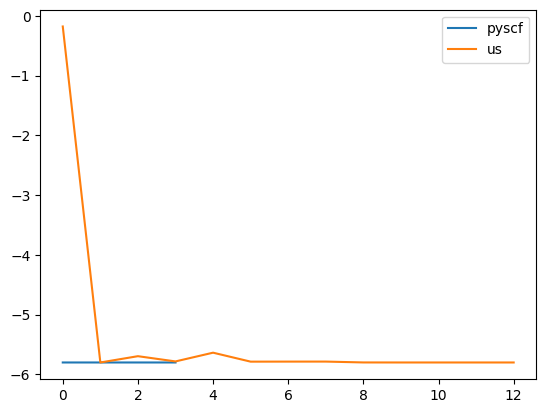

In [38]:

from pyscf.dft import libxc 
from pyscf.gto.moleintor import make_loc
from tqdm import tqdm
import numpy 
from pyscf import scf
from pyscf.scf import hf
from pyscf.scf import _vhf
from pyscf.scf import jk
from pyscf.dft import gen_grid
from pyscf.dft import numint
from pyscf import __config__
from pyscf import lib
from functools import reduce
import scipy.linalg
import sys 
import tempfile
import h5py
from pyscf import gto
from pyscf.scf import diis
from pyscf.scf import _vhf
from pyscf.scf import chkfile
from pyscf.data import nist
#import jax.numpy as jnp 

from pyscf.lib import misc
#from pyscf.dft.numint import _rks_gga_wv0, _scale_ao, _dot_ao_ao
from pyscf.dft.gen_grid import make_mask, BLKSIZE
import ctypes
import _ctypes

SWITCH_SIZE = getattr(__config__, 'dft_numint_SWITCH_SIZE', 800)
libdft  = lib.load_library('libdft')
libcvhf = lib.load_library('libcvhf') # https://github.com/pyscf/pyscf/blob/16887846a6b30bde495ebf69905de2576f4a3f4a/pyscf/lib/misc.py#L51

def xc_and_coulomb(ks, mol=None, dm=None, dm_last=0, vhf_last=0, hermi=1):
    '''Coulomb + XC functional
    .. note::
        This function will modify the input ks object.
    Args:
        ks : an instance of :class:`RKS`
            XC functional are controlled by ks.xc attribute.  Attribute
            ks.grids might be initialized.
        dm : ndarray or list of ndarrays
            A density matrix or a list of density matrices
    Kwargs:
        dm_last : ndarray or a list of ndarrays or 0
            The density matrix baseline.  If not 0, this function computes the
            increment of HF potential w.r.t. the reference HF potential matrix.
        vhf_last : ndarray or a list of ndarrays or 0
            The reference Vxc potential matrix.
        hermi : int
            Whether J, K matrix is hermitian
            | 0 : no hermitian or symmetric
            | 1 : hermitian
            | 2 : anti-hermitian
    Returns:
        matrix Veff = J + Vxc.  Veff can be a list matrices, if the input
        dm is a list of density matrices.
    '''
    #if dm is None: dm = ks.make_rdm1()
    #ks.initialize_grids(mol, dm) # <-- only needs to be called once, and I think mol.build() does it? 

    ni            = ks._numint # numerical integrator, depends on xc functional! 
    max_memory    = ks.max_memory - lib.current_memory()[0]
    n, exc, vxc   = ni.nr_rks(mol, ks.grids, ks.xc, dm, max_memory=max_memory)

    #enabling range-separated hybrids
    omega, alpha, hyb = ni.rsh_and_hybrid_coeff(ks.xc, spin=mol.spin)

    if (ks._eri is None and ks.direct_scf and getattr(vhf_last, 'vk', None) is not None):
        ddm = numpy.asarray(dm) - numpy.asarray(dm_last)
        vj, vk = ks.get_jk(mol, ddm, hermi)
        vk *= hyb
        if abs(omega) > 1e-10:  # For range separated Coulomb operator
            vklr = ks.get_k(mol, ddm, hermi, omega=omega)
            vklr *= (alpha - hyb)
            vk += vklr
        vj += vhf_last.vj
        vk += vhf_last.vk
    else:
        vj, vk = ks.get_jk(mol, dm, hermi)
        vk *= hyb
        if abs(omega) > 1e-10:
            vklr = ks.get_k(mol, dm, hermi, omega=omega)
            vklr *= (alpha - hyb)
            vk += vklr
    vxc += vj - vk * .5

    exc   -= numpy.einsum('ij,ji', dm, vk).real * .5 * .5
    ecoul  = numpy.einsum('ij,ji', dm, vj).real * .5

    vxc = lib.tag_array(vxc, E_coulomb=ecoul, E_xc=exc, vj=vj, vk=vk)
    return vxc

def _fpointer(name):
    return ctypes.c_void_p(_ctypes.dlsym(libcvhf._handle, name))

def _rks_gga_wv0(rho, vxc, weight):
    vrho, vgamma = vxc[:2]
    ngrid = vrho.size
    wv = numpy.empty((4,ngrid))
    wv[0]  = vrho * .5  # v+v.T should be applied in the caller
    wv[1:] = 2 * vgamma * rho[1:4]
    wv[:] *= weight
    return wv

def _scale_ao(ao, wv, out=None):
    #:aow = numpy.einsum('npi,np->pi', ao[:4], wv)
    if wv.ndim == 2:
        ao = ao.transpose(0,2,1)
    else:
        ngrids, nao = ao.shape
        ao = ao.T.reshape(1,nao,ngrids)
        wv = wv.reshape(1,ngrids)

    if not ao.flags.c_contiguous:
        return numpy.einsum('nip,np->pi', ao, wv)

    if ao.dtype == numpy.double:
        if wv.dtype == numpy.double:
            fn = libdft.VXC_dscale_ao
            dtype = numpy.double
        elif wv.dtype == numpy.complex128:
            fn = libdft.VXC_dzscale_ao
            dtype = numpy.complex128
        else:
            return numpy.einsum('nip,np->pi', ao, wv)
    elif ao.dtype == numpy.complex128:
        if wv.dtype == numpy.double:
            fn = libdft.VXC_zscale_ao
            dtype = numpy.complex128
        elif wv.dtype == numpy.complex128:
            fn = libdft.VXC_zzscale_ao
            dtype = numpy.complex128
        else:
            return numpy.einsum('nip,np->pi', ao, wv)
    else:
        return numpy.einsum('nip,np->pi', ao, wv)

    wv = numpy.asarray(wv, order='C')
    comp, nao, ngrids = ao.shape
    assert wv.shape[0] == comp
    aow = numpy.ndarray((nao,ngrids), dtype=dtype, buffer=out).T
    fn(aow.ctypes.data_as(ctypes.c_void_p),
       ao.ctypes.data_as(ctypes.c_void_p),
       wv.ctypes.data_as(ctypes.c_void_p),
       ctypes.c_int(comp), ctypes.c_int(nao),
       ctypes.c_int(ngrids))
    return aow


def _dot_ao_ao(mol, ao1, ao2, non0tab, shls_slice, ao_loc, hermi=0):
    '''return numpy.dot(ao1.T, ao2)'''
    ngrids, nao = ao1.shape
    if nao < SWITCH_SIZE:
        return lib.dot(ao1.T.conj(), ao2)

    if not ao1.flags.f_contiguous:
        ao1 = lib.transpose(ao1)
    if not ao2.flags.f_contiguous:
        ao2 = lib.transpose(ao2)
    if ao1.dtype == ao2.dtype == numpy.double:
        fn = libdft.VXCdot_ao_ao
    else:
        fn = libdft.VXCzdot_ao_ao
        ao1 = numpy.asarray(ao1, numpy.complex128)
        ao2 = numpy.asarray(ao2, numpy.complex128)

    if non0tab is None or shls_slice is None or ao_loc is None:
        pnon0tab = pshls_slice = pao_loc = lib.c_null_ptr()
    else:
        pnon0tab    = non0tab.ctypes.data_as(ctypes.c_void_p)
        pshls_slice = (ctypes.c_int*2)(*shls_slice)
        pao_loc     = ao_loc.ctypes.data_as(ctypes.c_void_p)

    vv = numpy.empty((nao,nao), dtype=ao1.dtype)
    fn(vv.ctypes.data_as(ctypes.c_void_p),
       ao1.ctypes.data_as(ctypes.c_void_p),
       ao2.ctypes.data_as(ctypes.c_void_p),
       ctypes.c_int(nao), ctypes.c_int(ngrids),
       ctypes.c_int(mol.nbas), ctypes.c_int(hermi),
       pnon0tab, pshls_slice, pao_loc)
    return vv


# https://github.com/pyscf/pyscf/blob/16887846a6b30bde495ebf69905de2576f4a3f4a/pyscf/scf/_vhf.py#L303
# no clue what this does. 
#direct(dm-dm_last, mol._atm, mol._bas, mol._env, self.opt, 1, mol.cart, True, True) 
def direct(dms, atm, bas, env, vhfopt=None, hermi=0, cart=False, with_j=True, with_k=True):

    natm = ctypes.c_int(atm.shape[0])
    nbas = ctypes.c_int(bas.shape[0])

    dms_shape = dms.shape
    nao       = dms_shape[-1]
    dms       = dms.reshape(-1,nao,nao)
    n_dm      = dms.shape[0]

    # is this compute? 
    vhfopt.set_dm(dms, atm, bas, env)
    cvhfopt = vhfopt._this
    cintopt = vhfopt._cintopt
    intor   = vhfopt._intor

    cintor  = _fpointer(intor)

    fdrv    = libcvhf.CVHFnr_direct_drv # get_ttr previously
    fdot    = _fpointer('CVHFdot_nrs8')

    vj = vk = None
    dmsptr = []
    vjkptr = []
    fjk = [_fpointer('CVHFnrs8_ji_s2kl'), _fpointer('CVHFnrs8_li_s2kj')]

    vj = numpy.empty((n_dm,nao,nao))
    i = 0 
    dm = dms[0]
    dmsptr.append(dm.ctypes.data_as(ctypes.c_void_p))
    vjkptr.append(vj[i].ctypes.data_as(ctypes.c_void_p))

    vk = numpy.empty((n_dm,nao,nao))
    dmsptr.append(dm.ctypes.data_as(ctypes.c_void_p))
    vjkptr.append(vk[i].ctypes.data_as(ctypes.c_void_p))

    shls_slice = (ctypes.c_int*8)(*([0, bas.shape[0]]*4))
    ao_loc = make_loc(bas, intor)
    n_ops = len(dmsptr)
    comp = 1
    fdrv(cintor, fdot, 
         #(ctypes.c_void_p*n_ops)(*fjk),
         (ctypes.c_void_p*n_ops)(_fpointer('CVHFnrs8_ji_s2kl'), _fpointer('CVHFnrs8_li_s2kj')),
         (ctypes.c_void_p*n_ops)(*dmsptr), (ctypes.c_void_p*n_ops)(*vjkptr),
         ctypes.c_int(n_ops), ctypes.c_int(comp),
         shls_slice, ao_loc.ctypes.data_as(ctypes.c_void_p), cintopt, cvhfopt,
         atm.ctypes.data_as(ctypes.c_void_p), natm,
         bas.ctypes.data_as(ctypes.c_void_p), nbas,
         env.ctypes.data_as(ctypes.c_void_p))

    # vj must be symmetric
    for i in range(n_dm):
        lib.hermi_triu(vj[i], 1, inplace=True) # https://github.com/pyscf/pyscf/blob/16887846a6b30bde495ebf69905de2576f4a3f4a/pyscf/lib/numpy_helper.py#L421
    vj = vj.reshape(dms_shape)

    for i in range(n_dm):
        lib.hermi_triu(vk[i], hermi, inplace=True)
    vk = vk.reshape(dms_shape)
    
    return vj, vk


class RKS(): # moved everything into one class! i.e. removed inheritance dependency 

    diis       = getattr(__config__, 'scf_hf_SCF_diis', True)
    diis_space = getattr(__config__, 'scf_hf_SCF_diis_space', 8)
    # need > 0 if initial DM is numpy.zeros array
    diis_start_cycle = getattr(__config__, 'scf_hf_SCF_diis_start_cycle', 1)

    damp            = getattr(__config__, 'scf_hf_SCF_damp', 0)
    level_shift     = getattr(__config__, 'scf_hf_SCF_level_shift', 0)
    direct_scf      = getattr(__config__, 'scf_hf_SCF_direct_scf', True)
    direct_scf_tol  = getattr(__config__, 'scf_hf_SCF_direct_scf_tol', 1e-13)

    def __init__(self, mol, xc='LDA,VWN'):

        self.mol = mol
        self.verbose = mol.verbose
        self.max_memory = mol.max_memory
        self.stdout = mol.stdout

        self.opt = None
        self._eri = None # Note: self._eri requires large amount of memory
        
        self.xc = xc
        self.nlc = ''
        self.grids = gen_grid.Grids(self.mol)
        self.grids.level = getattr(__config__, 'dft_rks_RKS_grids_level',
                                self.grids.level)
        self.nlcgrids = gen_grid.Grids(self.mol)
        self.nlcgrids.level = getattr(__config__, 'dft_rks_RKS_nlcgrids_level',
                                    self.nlcgrids.level)
        # Use rho to filter grids
        self.small_rho_cutoff = getattr(__config__, 'dft_rks_RKS_small_rho_cutoff', 1e-7)
        self._numint = numint.NumInt()
        self.max_cycle = 50


    def get_jk(self, mol=None, dm=None, hermi=1, with_j=True, with_k=True, # called outside of main for loop. 
               omega=None):
        if mol is None: mol = self.mol
        # print("###") # called outside main loop! 

        if dm is None: dm = self.make_rdm1()
        if self.direct_scf and self.opt is None:
            self.opt = self.init_direct_scf(mol)

        if with_j and with_k:
            vj, vk = hf.get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)
        else:
            if with_j:
                prescreen = 'CVHFnrs8_vj_prescreen'
            else:
                prescreen = 'CVHFnrs8_vk_prescreen'
            with lib.temporary_env(self.opt, prescreen=prescreen):
                vj, vk = get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)

        return vj, vk


    def init_direct_scf(self, mol=None):
        # Integrals < direct_scf_tol may be set to 0 in int2e.
        # Higher accuracy is required for Schwartz inequality prescreening.
        with mol.with_integral_screen(self.direct_scf_tol**2):
            opt = _vhf.VHFOpt(mol, 'int2e', 'CVHFnrs8_prescreen',
                              'CVHFsetnr_direct_scf',
                              'CVHFsetnr_direct_scf_dm')
            opt.direct_scf_tol = self.direct_scf_tol
        return opt

    def kernel(self, convergence_tolerance=1e-10): 
      mol       = self.mol
      e_tot     = -1  
      converged = False

      # Init Stuff 
      dm              = hf.init_guess_by_minao(mol)         # <-- a few hundred lines of code in hf.py  (4, 4)
      V_xc            = xc_and_coulomb(self, mol, dm)       # <--- Coulomb + XC functional (this is the part that changes)  (4, 4)
      h1e             = mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc') # <--- gets fixed part of hamiltonian which doesn't change (4, 4)
      
      s1e   = mol.intor_symmetric('int1e_ovlp')             # <-- overlap matrix;; is this electron by electonr? dont think so (4, 4) ;; we add it to the generalized eigensolver? 
      L     = np.linalg.cholesky(s1e)
      L_inv = np.linalg.inv(L)

      nuclear_energy  = mol.energy_nuc()
      n_electrons     = mol.nelectron

      mf_diis_space                   = self.diis_space 
      e_idx                           = np.arange(V_xc.shape[0])
      mo_occ                          = numpy.zeros(V_xc.shape[0])
      mo_occ[e_idx[:n_electrons//2]]  = 2 
      mo_occ_nnz                      = mo_occ[mo_occ>0] 

      #pbar = tqdm(range(self.max_cycle))
      pbar = None 

      if pbar is None: pbar = range(self.max_cycle)

      mf_diis_H = np.zeros((mf_diis_space+1,mf_diis_space+1), np.float64)
      mf_diis_H[0,1:] = mf_diis_H[1:,0] = 1
      mf_diis_head   = 0

      d, hamil_d = np.prod(h1e.shape), np.prod(h1e.shape)
      _V = np.zeros((mf_diis_space, d))
      _H = np.zeros((mf_diis_space, d))

      # parameters used in last part of iteration. 
      # they are static floats and only depend on the type of dft, e.g., B3LYP has 0, 0, 0.2 
      # For B3LYP we always go to second entry. 
      from pyscf.dft import libxc
      omega, alpha, beta = libxc.rsh_coeff(self.xc) 
      if abs(omega) > 1e-10:  hyb = alpha + beta 
      else:                   hyb = libxc.hybrid_coeff(self.xc, mol.spin) 

      last_vj    = V_xc.vj
      last_vk    = V_xc.vk
      energies = [ ]

      # Goal: Wrap the inner part in a function and jax jit that function. 
      for cycle in pbar: 
          dm_last           = dm        
          last_hf_e         = e_tot
          V_xc_last         = V_xc 

          hamiltonian       = h1e + V_xc
          sdf               = s1e @ dm @ hamiltonian
          errvec            = sdf.T - sdf

          # ============ STRAT DIIS =============== #
          # Initially 500 lines of code split over 5 files. 
          mf_diis_head      = cycle % _V.shape[0]
          nd                = min(cycle, _V.shape[0])
          print(mf_diis_head, nd)

          _V[mf_diis_head]  = errvec.reshape(-1) 
          _H[mf_diis_head]  = hamiltonian.reshape(-1)

          tmps = _V[:nd].reshape(-1, 1, d) @ errvec.reshape(1, d, 1) 
          mf_diis_H[mf_diis_head+1, 1:nd+1] = tmps.reshape(-1)[:nd]
          mf_diis_H[1:nd+1, mf_diis_head+1] = tmps.reshape(-1)[:nd]
          
          # Compute H^-1@[1, 0, ..., 0] using eigh. 
          w, v        = scipy.linalg.eigh( mf_diis_H[:nd+1,:nd+1] )
          idx          = abs(w)>1e-14 # does this make it pinv? 
          c            = (v[:,idx]/w[idx]) @ (v[:,idx].T @  np.concatenate((np.ones(1), np.zeros(nd))) )
          hamiltonian  = np.sum( _H[:nd] * c[1:].reshape(nd, 1), axis=0).reshape(hamiltonian.shape)
          # ============ END DIIS =============== #

          # Solve generalized eigenproblem using normal eigh solver using this trick: https://www.jstor.org/stable/2949370
          eigvals, eigvects = np.linalg.eigh(L_inv @ hamiltonian @ L_inv.T)  
          eigvects          = L_inv.T @ eigvects 

          # Reconstruct density matrix using eigenvectors. 
          dm                = (eigvects[:, mo_occ>0] * mo_occ_nnz) @ eigvects[:, mo_occ>0].T 

          # ===================================== #
          # Compute update to V_xc.  --> nr_rks_only_GGA <--
          mask = None 
          #ao = self._numint.eval_ao(mol, self.grids.coords, deriv=1)
          #                         mol, coords, deriv=0, shls_slice=None, non0tab=None, cutoff=None, out=None, verbose=None):
          deriv = 1 
          comp = (deriv+1)*(deriv+2)*(deriv+3)//6
          if self.mol.cart:   feval = 'GTOval_cart_deriv%d' % deriv
          else:               feval = 'GTOval_sph_deriv%d' % deriv
          ao = self.mol.eval_gto(feval, self.grids.coords, comp) # <-- this is where we do stuff dependent on the molecule! 
          
          rho     = numpy.empty((4, self.grids.size))
          c0      = np.dot(ao[0], dm) 
          rho[0]  = numpy.einsum('pi,pi->p', c0, ao[0])

          for j in range(1, 4):
              rho[j] = numpy.einsum('pi,pi->p', c0, ao[j])
              
          rho[1:4] *= 2  

          # The call below calls python code which calls https://tddft.org/programs/libxc/ 
          # For more details see https://github.com/pyscf/pyscf/blob/16887846a6b30bde495ebf69905de2576f4a3f4a/pyscf/dft/libxc.py#L1333
          print(rho.shape)
          exc, vxc  = libxc.eval_xc(self.xc, rho, spin=0, relativity=0, deriv=1, omega=None, verbose=True)[:2] 
          
          den       = rho[0] * self.grids.weights 
          excsum    = numpy.dot(den, exc)

          wv        = _rks_gga_wv0(rho, vxc, self.grids.weights)

          vrho, vgamma = vxc[:2]
          wv      = numpy.empty((4, self.grids.size))
          wv[0]   = vrho * .5  
          wv[1:]  = 2 * vgamma * rho[1:4]
          wv[:]   *= self.grids.weights 

          aow       = _scale_ao(ao, wv, out=None)
          
          vmat   = _dot_ao_ao(mol, ao[0], aow, mask, (0, mol.nbas), mol.ao_loc_nr())
          vmat   = vmat + vmat.conj().T

          E_xc, V_xc = excsum, vmat
          # ===================================== #
          

          # https://github.com/pyscf/pyscf/blob/16887846a6b30bde495ebf69905de2576f4a3f4a/pyscf/scf/_vhf.py#L303
          # refactor until we have a single line that calls the fortran/C library. 
          vj, vk            = direct(dm-dm_last, mol._atm, mol._bas, mol._env, self.opt, 1, mol.cart, True, True) 
          
          vk      *= hyb
          vj      += last_vj 
          vk      += last_vk 

          V_xc    += vj - vk * .5

          last_vj  = vj
          last_vk  = vk

          # Below computes energy. 
          E_xc      = E_xc - np.sum(dm * vk.T) * .5 * .5
          E_coulomb = np.sum(dm * vj.T) * .5

          # Compute energy. Currently only used to check for convergence. 
          e_tot     =  np.sum(h1e * dm.T) + E_coulomb + E_xc + nuclear_energy

          if type(pbar) != type(range(0,1)): pbar.set_description("E=%4f change=%4e tolerance=%4e"%(e_tot, abs(e_tot-last_hf_e), convergence_tolerance))
          energies.append(e_tot)

          if abs(e_tot - last_hf_e) < convergence_tolerance:
              converged = True
              break

      self.converged, self.e_tot,  self.mo_energy, self.mo_coeff, self.mo_occ =  converged, e_tot, eigvals, eigvects, mo_occ
      return self.e_tot , energies


def jax_scf(str):
  basis_set ="6-31G*"
  xc_fun    ="b3lyp"

  # So PCQ uses eV and PySCF uses Hartree 
  eV_to_hartree    = 0.0367493
  hartree_to_eV    = 27.2114
  angstrom_to_bohr = 1.88973

  from pyscf.gto import mole  # <--- this file is 2000 lines of code

  t0 = time.time()
  mol = mole.Mole()

  #print("building molecule:")
  mol.build(atom=str, unit="Bohr", basis=basis_set)#, spin=1)
  #print(time.time()-t0)

  mol.verbose = 0 
  mf = RKS(mol) 
  mf.xc = xc_fun 

  t0 = time.time()
  energy, energies = mf.kernel()
  t = time.time()-t0
  #print("Us", t)

  lumo            = np.argmin(mf.mo_occ)
  homo            = lumo - 1
  hl_gap_hartree  = np.abs(mf.mo_energy[homo] - mf.mo_energy[lumo])
  hlgap           = hartree_to_eV*hl_gap_hartree
  return energy, hlgap , t, energies

test_cases(our_fun=jax_scf, list=[0,50], verbose=True) 
#test_cases(our_fun=jax_scf, verbose=True) 

# -102.629 2.629 |  -102.629 2.629 


In [ ]:
test_cases(our_fun=jax_scf, verbose=True) 

|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
|            HeHe |   -5.800 47.014 |   -5.800 47.014 |     0.000 0.000 |       47.014227 |          3.546528s |          3.795391s |
|          HeHeHe |   -8.700 46.375 |   -8.700 46.375 |     0.000 0.000 |       46.374526 |          1.688932s |          1.864069s |
|           CHHHH |  -40.482 13.791 |  -40.482 13.791 |     0.000 0.000 |       13.791238 |          5.319011s |          3.848503s |
|            NHHH |   -56.510 9.031 |   -56.510 9.031 |     0.000 0.000 |        9.031433 |          4.887831s |          3.390976s |
|             OHH |   -76.370 9.664 |   -76.370 9.664 |     0.000 0.000 |        9.663530 |          4.043749s |          2.297397s |
|            BeBe |   -29.316 2.950 |   -29.316 2.950 |     0.000 0.000 |        2.950380 |          3.359961s |          3.393923s |
|              FH | -100.380 11.927 | -100.380 11.927 |     0.00

RuntimeError: ignored

# Step 17: 

In [ ]:
import pyscf 
import pyscf.dft
import math 
from tqdm import tqdm
import numpy 
import jax.numpy as jnp 
import ctypes
import _ctypes

libdft  = pyscf.lib.load_library('libdft')
libcvhf = pyscf.lib.load_library('libcvhf') 

def _eval_xc(hyb, fn_facs, rho, spin=0, relativity=0, deriv=1, verbose=None):
    # The call below calls python code which calls https://tddft.org/programs/libxc/ 
    # For more details see https://github.com/pyscf/pyscf/blob/16887846a6b30bde495ebf69905de2576f4a3f4a/pyscf/dft/libxc.py#L1333
    # Got a specific test case for this function in the following cell.
    # TODO: implement this function in jax bottoms up! 
    # the other library lives here: https://gitlab.com/libxc/libxc/-/tree/master/src (has a lot of b3lyp files!)

    # Alternatively, we can also try to fit a neural network to approximate b3lyp, lol. 
    # we can train it to both approximate b3lyp AND the gradients of b3lyp! 
    # we could even take a neural network, and have it learn to compute any XC functional! 

    if spin == 0:
        nspin = 1
        rho_u = rho_d = numpy.asarray(rho, order='C')
    else:
        nspin = 2
        rho_u = numpy.asarray(rho[0], order='C')
        rho_d = numpy.asarray(rho[1], order='C')

    if rho_u.ndim == 1:
        rho_u = rho_u.reshape(1,-1)
        rho_d = rho_d.reshape(1,-1)
    ngrids = rho_u.shape[1]

    fn_ids = [x[0] for x in fn_facs]
    facs   = [x[1] for x in fn_facs]
    
    if hyb[2] != 0:
        # Current implementation does not support different omegas for
        # different RSH functionals if there are multiple RSHs
        omega = [hyb[2]] * len(facs)
    else:
        omega = [0] * len(facs)
    fn_ids_set = set(fn_ids)

    n = len(fn_ids)
    if spin == 0:
        nvar = 2
        xctype = 'R-GGA'
    else:
        nvar = 5
        xctype = 'U-GGA'

    outlen = (math.factorial(nvar+deriv) // (math.factorial(nvar) * math.factorial(deriv)))
    outbuf = numpy.zeros((outlen,ngrids))

    density_threshold = 0
    _itrf = pyscf.lib.load_library('libxc_itrf')
    _itrf.LIBXC_eval_xc(ctypes.c_int(n),
                        (ctypes.c_int*n)(*fn_ids),
                        (ctypes.c_double*n)(*facs),
                        (ctypes.c_double*n)(*omega),
                        ctypes.c_int(nspin),
                        ctypes.c_int(deriv), ctypes.c_int(ngrids),
                        rho_u.ctypes.data_as(ctypes.c_void_p),
                        rho_d.ctypes.data_as(ctypes.c_void_p),
                        outbuf.ctypes.data_as(ctypes.c_void_p),
                        ctypes.c_double(density_threshold))

    exc = outbuf[0]
    if xctype == 'R-GGA':   vxc = [outbuf[1], outbuf[2]]
    elif xctype == 'U-GGA': vxc = [outbuf[1:3].T, outbuf[3:6].T]

    return exc, vxc

# https://github.com/pyscf/pyscf/blob/16887846a6b30bde495ebf69905de2576f4a3f4a/pyscf/scf/_vhf.py#L303
# This code computes J and K matrices. 
# Psi4 does this aswell, and notes in a paper that this could be done in pure numpy for 2d case! 
# If we can find that code we are golden! 
#1.https://github.com/pyscf/pyscf/blob/16887846a6b30bde495ebf69905de2576f4a3f4a/pyscf/scf/hf.py#L765
#2.https://github.com/pyscf/pyscf/blob/16887846a6b30bde495ebf69905de2576f4a3f4a/pyscf/scf/_vhf.py#L303
#3.https://github.com/pyscf/pyscf/blob/16887846a6b30bde495ebf69905de2576f4a3f4a/pyscf/scf/_vhf.py#L362
#4.https://github.com/pyscf/pyscf/blob/29934de05446f55b166f5eba7a3ec55061ea74d8/pyscf/lib/vhf/nr_direct.h#L74
#5.https://github.com/pyscf/pyscf/blob/29934de05446f55b166f5eba7a3ec55061ea74d8/pyscf/lib/vhf/nr_direct.c#L389
#http://forum.psicode.org/t/how-to-obtain-correct-hf-energy-from-matrices/799
#https://github.com/psi4/psi4/blob/master/psi4/src/psi4/libfock/jk.cc
#https://chemrxiv.org/engage/api-gateway/chemrxiv/assets/orp/resource/item/60c73d51ee301c453ec78548/original/psi4num-py-an-interactive-quantum-chemistry-programming-environment-for-reference-implementations-and-rapid-development.pdf
def direct(dms, atm, bas, env, vhfopt=None, hermi=0, cart=False, with_j=True, with_k=True):
    def _fpointer(name): return ctypes.c_void_p(_ctypes.dlsym(libcvhf._handle, name))
    natm = ctypes.c_int(atm.shape[0])
    nbas = ctypes.c_int(bas.shape[0])

    dms_shape = dms.shape
    nao       = dms_shape[-1]
    dms       = dms.reshape(-1,nao,nao)
    n_dm      = dms.shape[0]

    # is this compute? 
    vhfopt.set_dm(dms, atm, bas, env)
    cvhfopt = vhfopt._this
    cintopt = vhfopt._cintopt
    intor   = vhfopt._intor

    cintor  = _fpointer(intor)

    fdrv    = libcvhf.CVHFnr_direct_drv # get_ttr previously;; figure out what this library is. 
    fdot    = _fpointer('CVHFdot_nrs8')

    vj = vk = None
    dmsptr = []
    vjkptr = []
    fjk = [_fpointer('CVHFnrs8_ji_s2kl'), _fpointer('CVHFnrs8_li_s2kj')]

    vj = numpy.empty((n_dm,nao,nao))
    i = 0 
    dm = dms[0]
    dmsptr.append(dm.ctypes.data_as(ctypes.c_void_p))
    vjkptr.append(vj[i].ctypes.data_as(ctypes.c_void_p))

    vk = numpy.empty((n_dm,nao,nao))
    dmsptr.append(dm.ctypes.data_as(ctypes.c_void_p))
    vjkptr.append(vk[i].ctypes.data_as(ctypes.c_void_p))

    shls_slice = (ctypes.c_int*8)(*([0, bas.shape[0]]*4))
    ao_loc = pyscf.gto.moleintor.make_loc(bas, intor)

    n_ops = len(dmsptr)
    comp = 1
    fdrv(cintor, fdot, 
         #(ctypes.c_void_p*n_ops)(*fjk),
         (ctypes.c_void_p*n_ops)(_fpointer('CVHFnrs8_ji_s2kl'), _fpointer('CVHFnrs8_li_s2kj')),
         (ctypes.c_void_p*n_ops)(*dmsptr), (ctypes.c_void_p*n_ops)(*vjkptr),
         ctypes.c_int(n_ops), ctypes.c_int(comp),
         shls_slice, ao_loc.ctypes.data_as(ctypes.c_void_p), cintopt, cvhfopt,
         atm.ctypes.data_as(ctypes.c_void_p), natm,
         bas.ctypes.data_as(ctypes.c_void_p), nbas,
         env.ctypes.data_as(ctypes.c_void_p))

    # vj must be symmetric
    i = 0 
    vj[i] = np.tril(vj[i]) + np.tril(vj[i], k=-1).T
    vk[i] = np.tril(vk[i]) + np.tril(vk[i], k=-1).T
    return vj.reshape(dms_shape), vk.reshape(dms_shape)


class RKS(): 

    def __init__(self, mol, xc='LDA,VWN'):
        self.mol        = mol
        self.verbose    = mol.verbose

        self.max_memory     = mol.max_memory
        self._eri           = None 
        self.direct_scf     = True 
        self.direct_scf_tol = 1e-13

        self.opt = None
        
        self.xc = xc
        
        self.nlc = ''
        self.grids            = pyscf.dft.gen_grid.Grids(self.mol)
        self.grids.level      = getattr(pyscf.__config__, 'dft_rks_RKS_grids_level', self.grids.level)
        self.nlcgrids         = pyscf.dft.gen_grid.Grids(self.mol)
        self.nlcgrids.level   = getattr(pyscf.__config__, 'dft_rks_RKS_nlcgrids_level', self.nlcgrids.level)
        self.small_rho_cutoff = getattr(pyscf.__config__, 'dft_rks_RKS_small_rho_cutoff', 1e-7)
        self._numint          = pyscf.dft.numint.NumInt() # only used for initialization, not inside main loop! 
        self.max_cycle        = 50


    def get_jk(self, mol=None, dm=None, hermi=1, with_j=True, with_k=True,  omega=None):
        if mol is None: mol = self.mol
        if dm is None: dm = self.make_rdm1()
        if self.direct_scf and self.opt is None:
            self.opt = self.init_direct_scf(mol)

        if with_j and with_k:
            vj, vk = pyscf.scf.hf.get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)
        else:
            if with_j:
                prescreen = 'CVHFnrs8_vj_prescreen'
            else:
                prescreen = 'CVHFnrs8_vk_prescreen'
            with pyscf.lib.temporary_env(self.opt, prescreen=prescreen):
                vj, vk = get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)

        return vj, vk


    def init_direct_scf(self, mol=None):
        # Integrals < direct_scf_tol may be set to 0 in int2e.
        # Higher accuracy is required for Schwartz inequality prescreening.
        with mol.with_integral_screen(self.direct_scf_tol**2):
            opt = pyscf.scf._vhf.VHFOpt(mol, 'int2e', 'CVHFnrs8_prescreen',
                              'CVHFsetnr_direct_scf',
                              'CVHFsetnr_direct_scf_dm')
            opt.direct_scf_tol = self.direct_scf_tol
        return opt


    def kernel(self, convergence_tolerance=1e-10): 
      mol       = self.mol
      e_tot     = -1  
      converged = False

      # Initialize stuff on CPU using PySCF. 
      # For current proof of concept, we only want to jax jit the main loop. 
      dm    = pyscf.scf.hf.init_guess_by_minao(mol)         
      V_xc  = pyscf.dft.rks.get_veff(self, mol, dm)                               # Computes XC and Coulomb. 
      h1e   = mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc') # Fixed part of hamiltonian. 
      
      s1e   = mol.intor_symmetric('int1e_ovlp')                                   # "Overlap matrix", added to generalized eigensolver. 
      L     = np.linalg.cholesky(s1e)                                             # Used by mean to turn generalized eigenproblem into a normal eigenproblem. 
      L_inv = np.linalg.inv(L)                                                    # Same as above. 

      nuclear_energy  = mol.energy_nuc()
      n_electrons     = mol.nelectron

      mf_diis_space                   = 8                                         # Try increasing this to e.g. 64. Will probably converge faster and make each iteration only a little slower. 
      e_idx                           = np.arange(V_xc.shape[0])
      mo_occ                          = numpy.zeros(V_xc.shape[0])
      mo_occ[e_idx[:n_electrons//2]]  = 2 
      mo_occ_nnz                      = mo_occ[mo_occ>0] 

      #pbar = tqdm(range(self.max_cycle))
      pbar = None 

      if pbar is None: pbar = range(self.max_cycle)

      mf_diis_H = np.zeros((mf_diis_space+1,mf_diis_space+1), np.float64)
      mf_diis_H[0,1:] = mf_diis_H[1:,0] = 1
      mf_diis_head   = 0

      d, hamil_d = np.prod(h1e.shape), np.prod(h1e.shape)
      _V = np.zeros((mf_diis_space, d))
      _H = np.zeros((mf_diis_space, d))

      # Fixed values used in last part of main iteration. 
      # Depends only on xc type. For b3lyp the values are B3LYP has 0, 0, 0.2 
      omega, alpha, beta          = pyscf.dft.libxc.rsh_coeff(self.xc) 
      if abs(omega) > 1e-10:  hyb = alpha + beta 
      else:                   hyb = pyscf.dft.libxc.hybrid_coeff(self.xc, mol.spin) 

      last_vj    = V_xc.vj
      last_vk    = V_xc.vk

      # Is molecule in cartesian or spherical coordinates. 
      feval = 'GTOval_cart_deriv1' if self.mol.cart else 'GTOval_sph_deriv1' 
      ao    = self.mol.eval_gto( feval, self.grids.coords, (1+1)*(1+2)*(1+3)//6 ) # <-- molecule dependent stuff! this doesn't change, so we can just compute it once. NOtably, we don't have to jax it!!!!!!!!!

      # More fixed valeus used in last part of main iteration. 
      # Again, depends only on xc type. 
      _hyb, fn_facs = pyscf.dft.libxc.parse_xc("b3lyp") 


      # Save values here to emphasize they don't change each iteration. 
      mol_atm = mol._atm 
      mol_bas = mol._bas
      mol_env = mol._env 
      mol_cart = mol.cart 

      nao = mol.nao_nr()
      eri0 = mol.intor('int2e_sph').reshape((nao,)*4)


      # Goal: Wrap the inner part in a function and jax jit that function. 
      for cycle in pbar: 
          dm_last           = dm        
          last_hf_e         = e_tot
          V_xc_last         = V_xc 

          hamiltonian       = h1e + V_xc
          sdf               = s1e @ dm @ hamiltonian
          errvec            = sdf.T - sdf

          # ============ STRAT DIIS =============== #
          # Initially 500 lines of code split over 5 files. 
          mf_diis_head      = cycle % _V.shape[0]
          nd                = min(cycle, _V.shape[0])

          _V[mf_diis_head]  = errvec.reshape(-1) 
          _H[mf_diis_head]  = hamiltonian.reshape(-1)

          tmps = _V[:nd].reshape(-1, 1, d) @ errvec.reshape(1, d, 1) 
          mf_diis_H[mf_diis_head+1, 1:nd+1] = tmps.reshape(-1)[:nd]
          mf_diis_H[1:nd+1, mf_diis_head+1] = tmps.reshape(-1)[:nd]
          
          # Compute H^-1@[1, 0, ..., 0] using eigh. 
          w, v         = np.linalg.eigh( mf_diis_H[:nd+1,:nd+1] )
          idx          = abs(w)>1e-14 # does this make it pinv? 
          c            = (v[:,idx]/w[idx]) @ (v[:,idx].T @  np.concatenate((np.ones(1), np.zeros(nd))) )
          hamiltonian  = np.sum( _H[:nd] * c[1:].reshape(nd, 1), axis=0).reshape(hamiltonian.shape)
          # ============ END DIIS =============== #

          # Solve generalized eigenproblem using normal eigh solver using this trick: https://www.jstor.org/stable/2949370
          eigvals, eigvects = np.linalg.eigh(L_inv @ hamiltonian @ L_inv.T)  
          eigvects          = L_inv.T @ eigvects 

          # Reconstruct density matrix using eigenvectors. 
          dm                = (eigvects[:, mo_occ>0] * mo_occ_nnz) @ eigvects[:, mo_occ>0].T 

          # ================= numerical_integration ==================== #
          # Compute update to V_xc.  --> nr_rks_only_GGA <--
          # Used to be ~ 500 lines of code. 
          c0        = ao[0] @ dm
          rho       = np.sum( c0.reshape((1,) + c0.shape) * ao, axis=2)
          rho[1:4] *= 2  
          
          exc, vxc    = _eval_xc(_hyb, fn_facs, rho, spin=0, relativity=0, deriv=1, verbose=False)  # <--- jaxify this!
          
          den          = rho[0] * self.grids.weights                            # Is this the electron density? 
          excsum       = den @ exc 

          vrho, vgamma = vxc[:2]
          wv           = numpy.empty((4, self.grids.size))
          wv[0]        = vrho * .5  
          wv[1:]       = 2 * vgamma * rho[1:4]
          wv[:]       *= self.grids.weights 

          aow          = numpy.einsum('npi,np->pi', ao[:4], wv)
          
          vmat         = ao[0].T @ aow
          vmat         = vmat + vmat.T

          E_xc, V_xc   = excsum, vmat
          # =================== end numerical integration ================== #
          vj_initial, vk_initial = direct(dm-dm_last, mol_atm, mol_bas, mol_env, self.opt, 1, mol_cart, True, True)  # jaxify this! 
          vj = numpy.einsum('ijkl,ji->kl', eri0, dm-dm_last)
          vk = numpy.einsum('ijkl,jk->il', eri0, dm-dm_last)
          assert np.allclose(vj, vj_initial)
          assert np.allclose(vk, vk_initial)

          
          vk      *= hyb
          vj      += last_vj 
          vk      += last_vk 

          V_xc    += vj - vk * .5

          last_vj  = vj
          last_vk  = vk

          # Below computes energy. 
          E_xc      = E_xc - np.sum(dm * vk.T) * .5 * .5
          E_coulomb = np.sum(dm * vj.T) * .5

          # Compute energy. Currently only used to check for convergence. 
          e_tot     =  np.sum(h1e * dm.T) + E_coulomb + E_xc + nuclear_energy

          if type(pbar) != type(range(0,1)): pbar.set_description("E=%4f change=%4e tolerance=%4e"%(e_tot, abs(e_tot-last_hf_e), convergence_tolerance))

          if abs(e_tot - last_hf_e) < convergence_tolerance:
              converged = True
              break

      self.converged, self.e_tot,  self.mo_energy, self.mo_coeff, self.mo_occ =  converged, e_tot, eigvals, eigvects, mo_occ
      return self.e_tot 


def jax_scf(str):
  basis_set ="6-31G*"
  xc_fun    ="b3lyp"

  # So PCQ uses eV and PySCF uses Hartree 
  eV_to_hartree    = 0.0367493
  hartree_to_eV    = 27.2114
  angstrom_to_bohr = 1.88973


  t0 = time.time()
  mol = pyscf.gto.mole.Mole()

  #print("building molecule:")
  mol.build(atom=str, unit="Bohr", basis=basis_set)#, spin=1)
  #print(time.time()-t0)

  mol.verbose = 0 
  mf = RKS(mol) 
  mf.xc = xc_fun 

  t0 = time.time()
  energy = mf.kernel()
  t = time.time()-t0

  lumo            = np.argmin(mf.mo_occ)
  homo            = lumo - 1
  hl_gap_hartree  = np.abs(mf.mo_energy[homo] - mf.mo_energy[lumo])
  hlgap           = hartree_to_eV*hl_gap_hartree
  return energy, hlgap, t

#test_cases(our_fun=jax_scf, list=[0,50], verbose=True) 
test_cases(our_fun=jax_scf, list=[0,50], verbose=True) 
#test_cases(our_fun=jax_scf, verbose=True) 

# -102.629 2.629 |  -102.629 2.629 


|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
HeHe

AttributeError: ignored

In [ ]:
#!pip install psi4
!pip install PyOpenCAP 
!pip install adcc 
!conda install Psi4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 228 kB 5.3 MB/s 
  ERROR: Failed building wheel for adcc
  Running setup.py clean for adcc
Failed to build adcc
    Running setup.py install for adcc ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-4gbat2jw/adcc_240507f33de34c0f9056308678ae128c/setup.py'"'"'; __file__='"'"'/tmp/pip-install-4gbat2jw/adcc_240507f33de34c0f9056308678ae128c/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:26
🔁 Restarting kernel...


In [ ]:
import psi4
# Create a JK object in the current primary basis set
jk = psi4.core.JK.build(primary_basis)
# Add the occupied parts of the SCF orbital matrix
jk.add_C_left(C_occupied)
jk.add_C_right(C_occupied)
# Perform the computation and obtain the J and K matrices
jk.compute()
J = jk.J()
K = jk.K()

ModuleNotFoundError: ignored

In [ ]:
test_cases(our_fun=jax_scf, verbose=True) 

|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
|            HeHe |   -5.800 47.014 |   -5.800 47.014 |     0.000 0.000 |       47.014227 |          4.184792s |          1.969476s |
|          HeHeHe |   -8.700 46.375 |   -8.700 46.375 |     0.000 0.000 |       46.374526 |          2.181771s |          1.992941s |
|           CHHHH |  -40.482 13.791 |  -40.482 13.791 |     0.000 0.000 |       13.791238 |          5.418071s |          3.632935s |
|            NHHH |   -56.510 9.031 |   -56.510 9.031 |     0.000 0.000 |        9.031433 |          6.547545s |          3.925875s |
|             OHH |   -76.370 9.664 |   -76.370 9.664 |     0.000 0.000 |        9.663530 |          4.457906s |          2.047318s |
|            BeBe |   -29.316 2.950 |   -29.316 2.950 |     0.000 0.000 |        2.950380 |          3.863322s |          3.094656s |
|              FH | -100.380 11.927 | -100.380 11.927 |     0.00

RuntimeError: ignored

In [ ]:
from pyscf.scf.jk import get_jk

import numpy 

from pyscf import gto
#mol = gto.M(atom='H 0 -.5 0; H 0 .5 0', basis='cc-pvdz')
mol = gto.M(atom='H 0 -.5 0; H 0 .5 0', basis='6-31G*')
nao = mol.nao_nr()
print(nao) # number atomic orbitals? 

dm = numpy.random.random((nao,nao))
# Default, Coulomb matrix
vj = get_jk(mol, dm)
print(vj)

#https://github.com/pyscf/pyscf/blob/16887846a6b30bde495ebf69905de2576f4a3f4a/pyscf/scf/jk.py

print(dm.shape) # scripts=['ijkl,ji->kl'] default scripts value

# for density matrices in dms, bind each dm to a jk operator
# jkdescript: 'ij->s1kl', 'kl->s2ij', ...
# may just be a particular einsum? 
eri0 = mol.intor('int2e_sph').reshape((nao,)*4)
vj = get_jk(mol, dm, 'ijkl,ji->kl')
assert numpy.allclose(vj, numpy.einsum('ijkl,ji->kl', eri0, dm))

vk = get_jk(mol, dm, 'ijkl,jk->il', aosym='s8')
assert numpy.allclose(vk, numpy.einsum('ijkl,jk->il', eri0, dm))



# Coulomb matrix with 8-fold permutation symmetry for AO integrals
vj = get_jk(mol, dm, 'ijkl,ji->kl', aosym='s8') # is this just an einsum? the "script=ijkl,ji->kl" follows numpy.einsum convention! 
print(vj)


# Exchange matrix with 8-fold permutation symmetry for AO integrals
vk = get_jk(mol, dm, 'ijkl,jk->il', aosym='s8') # so the only difference on vk and vj are the contraction dimensions in the einsum! 
print(vk)



mol_atm = mol._atm 
mol_bas = mol._bas
mol_env = mol._env 
mol_cart = mol.cart

print(mol_atm)
print(mol_bas)
print(mol_env)
#print(mol_cart) # just true because we use (x,y,z) not spherical .


print(mol_atm.shape, mol_bas.shape, mol_env.shape)

4
[array([[2.97622656, 1.78827556, 0.85856531, 1.19179138],
       [1.78827556, 2.1766582 , 1.29938784, 1.784832  ],
       [0.85856531, 1.29938784, 3.48446827, 2.02805846],
       [1.19179138, 1.784832  , 2.02805846, 2.33869613]])]
(4, 4)
[[2.97622656 1.78827556 0.85856531 1.19179138]
 [1.78827556 2.1766582  1.29938784 1.784832  ]
 [0.85856531 1.29938784 3.48446827 2.02805846]
 [1.19179138 1.784832   2.02805846 2.33869613]]
[[1.80600464 1.61674263 1.63334896 1.56332286]
 [1.52930875 1.63086347 1.87472321 1.74018039]
 [1.42161379 1.78349482 2.7655632  2.19444056]
 [1.41407458 1.67721424 2.20528272 1.95993123]]
[[ 1 20  1 23  0  0]
 [ 1 24  1 27  0  0]]
[[ 0  0  3  1  0 28 31  0]
 [ 0  0  1  1  0 34 35  0]
 [ 1  0  3  1  0 28 31  0]
 [ 1  0  1  1  0 34 35  0]]
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.       

In [ ]:
a = np.load("dump.npz", allow_pickle=True)
print([a for a in a.keys()])

rho = a["rho"]
_exc = a["exc"]
_vxc = a["vxc"]

def test(exc, vxc):
  print(exc-_exc)
  print(vxc[0]-_vxc[0])
  assert np.allclose(exc, _exc)
  assert np.allclose(vxc[0], _vxc[0])


test(*libxc.eval_xc("b3lyp", rho, spin=0, relativity=0, deriv=1, omega=None, verbose=True)[:2])


hyb, fn_facs = libxc.parse_xc("b3lyp") # this doesn't change with iterations, can precompute this! 


test( * libxc._eval_xc(hyb, fn_facs, rho, spin=0, relativity=0, deriv=1, verbose=False)[:2] )



def _eval_xc(hyb, fn_facs, rho, spin=0, relativity=0, deriv=1, verbose=None):
    if spin == 0:
        nspin = 1
        rho_u = rho_d = numpy.asarray(rho, order='C')
    else:
        nspin = 2
        rho_u = numpy.asarray(rho[0], order='C')
        rho_d = numpy.asarray(rho[1], order='C')

    if rho_u.ndim == 1:
        rho_u = rho_u.reshape(1,-1)
        rho_d = rho_d.reshape(1,-1)
    ngrids = rho_u.shape[1]

    fn_ids = [x[0] for x in fn_facs]
    facs   = [x[1] for x in fn_facs]
    
    if hyb[2] != 0:
        # Current implementation does not support different omegas for
        # different RSH functionals if there are multiple RSHs
        omega = [hyb[2]] * len(facs)
    else:
        omega = [0] * len(facs)
    fn_ids_set = set(fn_ids)

    n = len(fn_ids)
    if spin == 0:
        nvar = 2
        xctype = 'R-GGA'
    else:
        nvar = 5
        xctype = 'U-GGA'

    import math 
    outlen = (math.factorial(nvar+deriv) // (math.factorial(nvar) * math.factorial(deriv)))
    outbuf = numpy.zeros((outlen,ngrids))

    density_threshold = 0
    _itrf = lib.load_library('libxc_itrf')
    _itrf.LIBXC_eval_xc(ctypes.c_int(n),
                        (ctypes.c_int*n)(*fn_ids),
                        (ctypes.c_double*n)(*facs),
                        (ctypes.c_double*n)(*omega),
                        ctypes.c_int(nspin),
                        ctypes.c_int(deriv), ctypes.c_int(ngrids),
                        rho_u.ctypes.data_as(ctypes.c_void_p),
                        rho_d.ctypes.data_as(ctypes.c_void_p),
                        outbuf.ctypes.data_as(ctypes.c_void_p),
                        ctypes.c_double(density_threshold))

    exc = outbuf[0]
    if xctype == 'R-GGA':   vxc = [outbuf[1], outbuf[2]]
    elif xctype == 'U-GGA': vxc = [outbuf[1:3].T, outbuf[3:6].T]

    return exc, vxc

test( * _eval_xc(hyb, fn_facs, rho, spin=0, relativity=0, deriv=1, verbose=False) )



['rho', 'exc', 'vxc']
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
R-GGA
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


In [ ]:
# todo: 
# 1. take xclib and make test case for b3lyp 
# 2. rewrite b3lyp as becke, HF, B, LSDA, LYP  using that string trick https://en.wikipedia.org/wiki/Hybrid_functional#B3LYP 
#     https://github.com/pyscf/pyscf/blob/16887846a6b30bde495ebf69905de2576f4a3f4a/pyscf/dft/libxc.py#L1369  
#     For example '0.5*b3lyp' is equivalent to 'HF*0.1 + .04*LDA + .36*B88, .405*LYP + .095*VWN'
#     make a test case like this, then we just need to implement HF, LDA, B88, LYP and VWN 
# 3. for each of those we can make test cases and implement them in numpy. we may even be able to find either of them implemented already 
#    notably, all of it will be implemented in C code somewhere. 

In [ ]:
For reference, the C code is called through the following files.


# Step 18

currently have jax and numpy variants.  in the end, we should have only one, and adding line `jax` should jaxify it! the only annoying things is indexing in jax which means we can't e.g. change `np` to `jnp`


### jax.jit

In [3]:
#jax.jit version 
import jax 
import pyscf 
import pyscf.dft
import math 
from tqdm import tqdm
import numpy 
import jax.numpy as jnp 
import ctypes
import _ctypes
from jax.config import config
#config.update('jax_enable_x64', True)
config.update('jax_enable_x64', False) # as long as the xcfun is float64 it float32 is fine! so juts have that be stable! 

libdft  = pyscf.lib.load_library('libdft')
libcvhf = pyscf.lib.load_library('libcvhf') 

def load_library(libname):
    from pyscf import __path__ as ext_modules
    for path in ext_modules:
        libpath = os.path.join(path, 'lib')
        if os.path.isdir(libpath):
            for files in os.listdir(libpath):
                if files.startswith(libname):
                    return numpy.ctypeslib.load_library(libname, libpath)

def _eval_xc(hyb, fn_facs, rho, spin=0, relativity=0, deriv=1, verbose=None):
    # The call below calls python code which calls https://tddft.org/programs/libxc/ 
    # For more details see https://github.com/pyscf/pyscf/blob/16887846a6b30bde495ebf69905de2576f4a3f4a/pyscf/dft/libxc.py#L1333
    # Got a specific test case for this function in the following cell.
    # TODO: implement this function in jax bottoms up! 
    # the other library lives here: https://gitlab.com/libxc/libxc/-/tree/master/src (has a lot of b3lyp files!)

    # Alternatively, we can also try to fit a neural network to approximate b3lyp, lol. 
    # we can train it to both approximate b3lyp AND the gradients of b3lyp! 
    # we could even take a neural network, and have it learn to compute any XC functional! 

    if spin == 0:
        nspin = 1
        rho_u = rho_d = numpy.asarray(rho, order='C')
    else:
        nspin = 2
        rho_u = numpy.asarray(rho[0], order='C')
        rho_d = numpy.asarray(rho[1], order='C')

    if rho_u.ndim == 1:
        rho_u = rho_u.reshape(1,-1)
        rho_d = rho_d.reshape(1,-1)
    ngrids = rho_u.shape[1]

    fn_ids = [x[0] for x in fn_facs]
    facs   = [x[1] for x in fn_facs]
    
    if hyb[2] != 0:
        # Current implementation does not support different omegas for
        # different RSH functionals if there are multiple RSHs
        omega = [hyb[2]] * len(facs)
    else:
        omega = [0] * len(facs)
    fn_ids_set = set(fn_ids)

    n = len(fn_ids)
    if spin == 0:
        nvar = 2
        xctype = 'R-GGA'
    else:
        nvar = 5
        xctype = 'U-GGA'

    outlen = (math.factorial(nvar+deriv) // (math.factorial(nvar) * math.factorial(deriv)))
    outbuf = numpy.zeros((outlen,ngrids))

    density_threshold = 0
    #_itrf = pyscf.lib.load_library('libxc_itrf')
    _itrf = load_library('libxc_itrf')
    _itrf.LIBXC_eval_xc(ctypes.c_int(n),
                        (ctypes.c_int*n)(*fn_ids),
                        (ctypes.c_double*n)(*facs),
                        (ctypes.c_double*n)(*omega),
                        ctypes.c_int(nspin),
                        ctypes.c_int(deriv), ctypes.c_int(ngrids),
                        rho_u.ctypes.data_as(ctypes.c_void_p),
                        rho_d.ctypes.data_as(ctypes.c_void_p),
                        outbuf.ctypes.data_as(ctypes.c_void_p),
                        ctypes.c_double(density_threshold))

    exc = outbuf[0]
    if xctype == 'R-GGA':   vxc = [outbuf[1], outbuf[2]]
    elif xctype == 'U-GGA': vxc = [outbuf[1:3].T, outbuf[3:6].T]

    return exc, vxc

class RKS(): 

    def __init__(self, mol, xc='LDA,VWN'):
        self.mol        = mol
        self.verbose    = mol.verbose

        self.max_memory     = mol.max_memory
        self._eri           = None 
        self.direct_scf     = True 
        self.direct_scf_tol = 1e-13

        self.opt = None
        
        self.xc = xc
        
        self.nlc = ''
        self.grids            = pyscf.dft.gen_grid.Grids(self.mol)
        self.grids.level      = getattr(pyscf.__config__, 'dft_rks_RKS_grids_level', self.grids.level)
        self.nlcgrids         = pyscf.dft.gen_grid.Grids(self.mol)
        self.nlcgrids.level   = getattr(pyscf.__config__, 'dft_rks_RKS_nlcgrids_level', self.nlcgrids.level)
        self.small_rho_cutoff = getattr(pyscf.__config__, 'dft_rks_RKS_small_rho_cutoff', 1e-7)
        self._numint          = pyscf.dft.numint.NumInt() # only used for initialization, not inside main loop! 
        self.max_cycle        = 50


    def get_jk(self, mol=None, dm=None, hermi=1, with_j=True, with_k=True,  omega=None):
        if mol is None: mol = self.mol
        if dm is None: dm = self.make_rdm1()
        if self.direct_scf and self.opt is None:
            self.opt = self.init_direct_scf(mol)

        if with_j and with_k:
            vj, vk = pyscf.scf.hf.get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)
        else:
            if with_j:
                prescreen = 'CVHFnrs8_vj_prescreen'
            else:
                prescreen = 'CVHFnrs8_vk_prescreen'
            with pyscf.lib.temporary_env(self.opt, prescreen=prescreen):
                vj, vk = get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)

        return vj, vk


    def init_direct_scf(self, mol=None):
        # Integrals < direct_scf_tol may be set to 0 in int2e.
        # Higher accuracy is required for Schwartz inequality prescreening.
        with mol.with_integral_screen(self.direct_scf_tol**2):
            opt = pyscf.scf._vhf.VHFOpt(mol, 'int2e', 'CVHFnrs8_prescreen',
                              'CVHFsetnr_direct_scf',
                              'CVHFsetnr_direct_scf_dm')
            opt.direct_scf_tol = self.direct_scf_tol
        return opt


    #def get_j(self, **kwargs): pyscf.dft.hf.

    def initialize_grids(self, a, b): pass 

    def kernel(self, convergence_tolerance=1e-10): 
      mol       = self.mol
      e_tot     = -1  
      converged = False

      # Initialize stuff on CPU using PySCF. 
      # For current proof of concept, we only want to jax jit the main loop. 
      dm    = pyscf.scf.hf.init_guess_by_minao(mol)         
      V_xc  = pyscf.dft.rks.get_veff(self, mol, dm)                               # Computes XC and Coulomb. 
      h1e   = mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc') # Fixed part of hamiltonian. 
      
      s1e   = mol.intor_symmetric('int1e_ovlp')                                   # "Overlap matrix", added to generalized eigensolver. 
      L     = np.linalg.cholesky(s1e)                                             # Used by mean to turn generalized eigenproblem into a normal eigenproblem. 
      L_inv = np.linalg.inv(L)                                                    # Same as above. 

      nuclear_energy  = mol.energy_nuc()
      n_electrons     = mol.nelectron

      mf_diis_space                   = 8                                         # Try increasing this to e.g. 64. Will probably converge faster and make each iteration only a little slower. 
      e_idx                           = np.arange(V_xc.shape[0])
      mo_occ                          = numpy.zeros(V_xc.shape[0])
      mo_occ[e_idx[:n_electrons//2]]  = 2 
      mo_occ_nnz                      = mo_occ[mo_occ>0] 

      #pbar = tqdm(range(self.max_cycle))
      pbar = None 

      if pbar is None: pbar = range(self.max_cycle)

      mf_diis_H = np.zeros((mf_diis_space+1,mf_diis_space+1), np.float64)
      mf_diis_H[0,1:] = mf_diis_H[1:,0] = 1
      mf_diis_head   = 0

      d, hamil_d = np.prod(h1e.shape), np.prod(h1e.shape)
      _V = jnp.zeros((mf_diis_space, d))
      _H = jnp.zeros((mf_diis_space, d))

      # Fixed values used in last part of main iteration. 
      # Depends only on xc type. For b3lyp the values are B3LYP has 0, 0, 0.2 
      omega, alpha, beta          = pyscf.dft.libxc.rsh_coeff(self.xc) 
      if abs(omega) > 1e-10:  hyb = alpha + beta 
      else:                   hyb = pyscf.dft.libxc.hybrid_coeff(self.xc, mol.spin) 

      last_vj    = V_xc.vj
      last_vk    = V_xc.vk

      # Is molecule in cartesian or spherical coordinates. 
      feval = 'GTOval_cart_deriv1' if self.mol.cart else 'GTOval_sph_deriv1' 
      ao    = self.mol.eval_gto( feval, self.grids.coords, (1+1)*(1+2)*(1+3)//6 ) # <-- molecule dependent stuff! this doesn't change, so we can just compute it once. NOtably, we don't have to jax it!!!!!!!!!

      # More fixed valeus used in last part of main iteration. 
      # Again, depends only on xc type. 
      _hyb, fn_facs = pyscf.dft.libxc.parse_xc(self.xc) 


      # Save values here to emphasize they don't change each iteration. 
      mol_atm = mol._atm 
      mol_bas = mol._bas
      mol_env = mol._env 
      mol_cart = mol.cart 

      nao = mol.nao_nr()
      eri0 = mol.intor('int2e_sph').reshape((nao,)*4)

      xc = self.xc
      grids = self.grids 

      def iteration(dm, V_xc, last_vj, last_vk, _V, _H, mf_diis_H, cycle):
          hamiltonian       = h1e + V_xc
          sdf               = s1e @ dm @ hamiltonian
          errvec            = sdf.T - sdf

          mf_diis_head      = cycle % _V.shape[0]
          nd                = min(cycle, _V.shape[0])

          # ============ STRAT DIIS =============== #
          # Initially 500 lines of code split over 5 files. 
          _V = jax.lax.dynamic_update_slice(_V, errvec.reshape(1, -1),      (mf_diis_head, 0))
          _H = jax.lax.dynamic_update_slice(_H, hamiltonian.reshape(1, -1), (mf_diis_head, 0))

          tmps = _V[:nd].reshape(-1, 1, d) @ errvec.reshape(1, d, 1) 
          tmps = jax.lax.dynamic_slice(tmps.reshape(-1), (0,), (nd,))

          mf_diis_H = jax.lax.dynamic_update_slice( mf_diis_H, tmps.reshape(1, -1), (mf_diis_head+1, 1) )
          mf_diis_H = jax.lax.dynamic_update_slice( mf_diis_H, tmps.reshape(-1, 1), (1, mf_diis_head+1) )
          
          # Compute H^-1@[1, 0, ..., 0] using eigh. 
          c     = jnp.linalg.pinv(mf_diis_H[:nd+1, :nd+1]) @ np.concatenate((np.ones(1), np.zeros(nd))) 

          hamiltonian  = jnp.sum( _H[:nd] * c[1:].reshape(nd, 1), axis=0).reshape(hamiltonian.shape)
          # ============ END DIIS =============== #

          # Solve generalized eigenproblem using normal eigh solver using this trick: https://www.jstor.org/stable/2949370
          eigvals, eigvects = jnp.linalg.eigh(L_inv @ hamiltonian @ L_inv.T)  
          eigvects          = L_inv.T @ eigvects 

          # Reconstruct density matrix using eigenvectors. 
          dm                = (eigvects[:, mo_occ>0] * mo_occ_nnz) @ eigvects[:, mo_occ>0].T 

          # ================= numerical_integration ==================== #
          # Compute update to V_xc.  --> nr_rks_only_GGA <--
          # Used to be ~ 500 lines of code. 
          c0        = ao[0] @ dm
          rho       = jnp.sum( c0.reshape((1,) + c0.shape) * ao, axis=2)
          rho       = jnp.concatenate([rho[:1], rho[1:4]*2])  #rho[1:4] *= 2  
          
          if xc ==  ".2 * HF ":# and False:
            exc = jnp.zeros(rho.shape[1])
            vxc = [jnp.zeros(rho.shape[1]), jnp.zeros(rho.shape[1])]
          else: 
            print(rho.shape)
            exc, vxc    = _eval_xc(_hyb, fn_facs, np.array(rho, dtype=np.float64), spin=0, relativity=0, deriv=1, verbose=False)  # <--- jaxify this!
          
          den          = rho[0] * grids.weights                            # Is this the electron density? 
          excsum       = den @ exc 

          vrho, vgamma = vxc[:2]
          #wv[0]       = vrho * .5  
          #wv[1:]      = 2 * vgamma * rho[1:4]
          wv           = jnp.concatenate([vrho.reshape(1, -1)*.5, 2*vgamma*rho[1:4]])
          wv          *= grids.weights 

          aow          = jnp.einsum('npi,np->pi', ao[:4], wv)
          
          vmat         = ao[0].T @ aow
          vmat         = vmat + vmat.T

          E_xc, V_xc   = excsum, vmat
          # =================== end numerical integration ================== #
          vj = jnp.einsum('ijkl,ji->kl', eri0, dm-dm_last)
          vk = jnp.einsum('ijkl,jk->il', eri0, dm-dm_last)
          
          vk      *= hyb
          vj      += last_vj 
          vk      += last_vk 

          V_xc    += vj - vk * .5

          last_vj  = vj
          last_vk  = vk

          # Below computes energy. 
          E_xc      = E_xc - jnp.sum(dm * vk.T) * .5 * .5
          E_coulomb = jnp.sum(dm * vj.T) * .5

          # Compute energy. Currently only used to check for convergence. 
          e_tot     =  jnp.sum(h1e * dm.T) + E_coulomb + E_xc + nuclear_energy

          return dm, e_tot, V_xc, last_vj, last_vk, eigvals, eigvects, _V, _H, mf_diis_H


      if self.xc != "b3lyp": iteration = jax.jit(iteration, static_argnums=(7))

      # Goal: Wrap the inner part in a function and jax jit that function. 
      for cycle in pbar: 
          dm_last           = dm        
          last_hf_e         = e_tot
          V_xc_last         = V_xc 

          dm, e_tot, V_xc, last_vj, last_vk, eigvals, eigvects, _V, _H, mf_diis_H = \
              iteration(dm, V_xc, last_vj, last_vk, _V, _H, mf_diis_H, cycle)

          if type(pbar) != type(range(0,1)): pbar.set_description("E=%4f change=%4e tolerance=%4e"%(e_tot, abs(e_tot-last_hf_e), convergence_tolerance))

          if abs(e_tot - last_hf_e) < convergence_tolerance:
              converged = True
              break

      #assert False 

      self.converged, self.e_tot,  self.mo_energy, self.mo_coeff, self.mo_occ =  converged, e_tot, eigvals, eigvects, mo_occ
      return self.e_tot 


def jax_scf(str):
  basis_set ="6-31G*"
  xc_fun    ="b3lyp"
  #xc_fun    =".2 * HF + .08 * LDA + .72 * B88, .810 * LYP + .19 * VWN"
  #xc_fun    =".2 * HF + .72 * B88, .810 * LYP + .19 * VWN"
  #xc_fun    = ".2 * HF + .08 * LDA + .72 * B88, .810 * LYP "
  #xc_fun    = ".2 * HF + .08 * LDA "
  #xc_fun    = ".2 * HF "
  #xc_fun    = "none"

  # So PCQ uses eV and PySCF uses Hartree 
  eV_to_hartree    = 0.0367493
  hartree_to_eV    = 27.2114
  angstrom_to_bohr = 1.88973


  t0 = time.time()
  mol = pyscf.gto.mole.Mole()

  #print("building molecule:")
  mol.build(atom=str, unit="Bohr", basis=basis_set)#, spin=1)
  #print(time.time()-t0)

  mol.verbose = 0 
  mf = RKS(mol) 
  mf.xc = xc_fun 

  t0 = time.time()
  energy = mf.kernel()
  t = time.time()-t0

  lumo            = np.argmin(mf.mo_occ)
  homo            = lumo - 1
  hl_gap_hartree  = np.abs(mf.mo_energy[homo] - mf.mo_energy[lumo])
  hlgap           = hartree_to_eV*hl_gap_hartree
  return energy, hlgap, t

#test_cases(our_fun=jax_scf, list=[0], verbose=True, xc="0.2*HF") 
#test_cases(our_fun=jax_scf, list=[0, 50], verbose=True) 
test_cases(our_fun=jax_scf, verbose=True) 

# -102.629 2.629 |  -102.629 2.629 


ImportError: libgcl.so: cannot open shared object file: No such file or directory

custom xc functionals, see the notebook [Jax B3LYP] for details. 

### numpy

0
float64


AssertionError: ignored

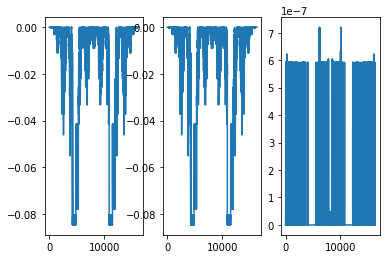

In [ ]:
# custom xcfuncs
!gdown 1GKZrEuTOmUTY2gtSmLn9swjYvNE1WWIs -q
!gdown 1u5y5XfbPNSelzAo-DP4Vg_xF_jEJlxtU -q # download rho for He2

from jax.config import config
config.update('jax_enable_x64', True)

# test custom xcfuncs 
import pickle
import jax.numpy as jnp 
import jax 
import pyscf.dft.libxc

import numpy as np
rhos = np.load("rhos_He2_v2.npz")["rhos"] # list of all rho's found during SCF/DFT, used for test cases. 
#rho = rhos[len(rhos)//2]
#for rho in rhos[1:]: 
for i, rho in enumerate(rhos[1:]): 
#rho = rhos[1]
  print(i)

  _hyb, fn_facs = pyscf.dft.libxc.parse_xc(".2 * HF + .08 * LDA + .72 * B88, .810 * LYP + .19 * VWN")

  exc, vxc      = pyscf.dft.libxc._eval_xc(_hyb, fn_facs, rho, spin=0, relativity=0, deriv=1, verbose=False)[:2]

  print(rho.dtype)

  exc1, vxc1      = pyscf.dft.libxc._eval_xc(_hyb, fn_facs[0:1], rho, spin=0, relativity=0, deriv=1, verbose=False)[:2]
  exc2, vxc2      = pyscf.dft.libxc._eval_xc(_hyb, fn_facs[1:2], rho, spin=0, relativity=0, deriv=1, verbose=False)[:2]
  exc3, vxc3      = pyscf.dft.libxc._eval_xc(_hyb, fn_facs[2:3], rho, spin=0, relativity=0, deriv=1, verbose=False)[:2]
  exc4, vxc4      = pyscf.dft.libxc._eval_xc(_hyb, fn_facs[3:4], rho, spin=0, relativity=0, deriv=1, verbose=False)[:2]

  p_lda, p_wvn, p_wvn_grad = pickle.load(open("xcfun.pkl", "rb"))
  def poly_lda(rho):        return -jnp.exp(jnp.polyval(p_lda, jnp.log(rho)))
  def poly_lda_grad(rho):   return poly_lda(rho)*4/3


  fig, ax = plt.subplots(1,3)
  ax[0].plot(exc1)
  ax[1].plot(poly_lda(rho[0]))
  ax[2].plot(exc1-poly_lda(rho[0]))

  assert np.allclose(exc1,     poly_lda(rho[0]))
  assert np.allclose(vxc1[:1], poly_lda_grad(rho[0]))
  #assert np.allclose(vxc1[1:], np.zeros(vxc1[1].shape))

  def poly_wvn(x):      return  -jnp.exp(jnp.polyval(p_wvn, jnp.log(x))) 
  def poly_wvn_grad(x): return  -jnp.exp(jnp.polyval(p_wvn_grad, jnp.log(x))) 

  assert np.allclose(exc4, poly_wvn(rho[0]))
  assert np.allclose(vxc4[0], poly_wvn_grad(rho[0]))
  #assert np.allclose(vxc4[1:], np.zeros(vxc1[1].shape))




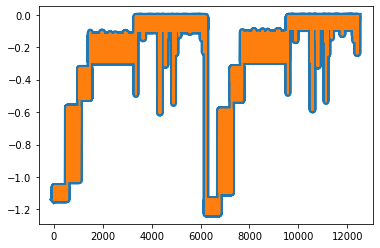

In [ ]:
import matplotlib.pyplot as plt 
plt.plot(vxc[0], lw=7)
if False: 
  plt.plot(vxc1[0])
  plt.plot(vxc2[0])
  plt.plot(vxc3[0])
  plt.plot(vxc4[0])
else:
  plt.plot(vxc1[0]+vxc2[0]+vxc3[0]+vxc4[0], lw=2)


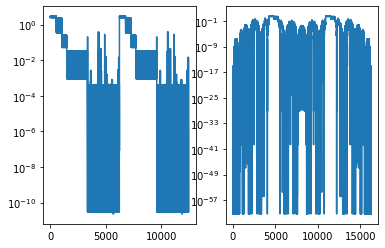

In [ ]:


rhos1 = np.load("rhos_He2.npz")["rhos"] # list of all rho's found during SCF/DFT, used for test cases. 
rhos2 = np.load("rhos_He2_v2.npz")["rhos"] # list of all rho's found during SCF/DFT, used for test cases. 

# why did it change like this? that is insane. 
# surpised that it generalized at all for this... 

rho1 = rhos1[-1]
rho2 = rhos2[-1]

fig, ax = plt.subplots(1,2)
ax[0].plot(rho1[0])
ax[1].plot(rho2[0])
ax[0].set_yscale("log")
ax[1].set_yscale("log")
#ax[2].imshow(rho1-rho2)



True
True
True


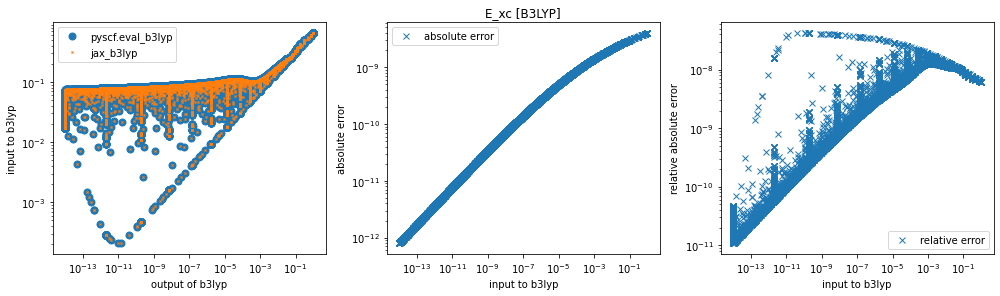

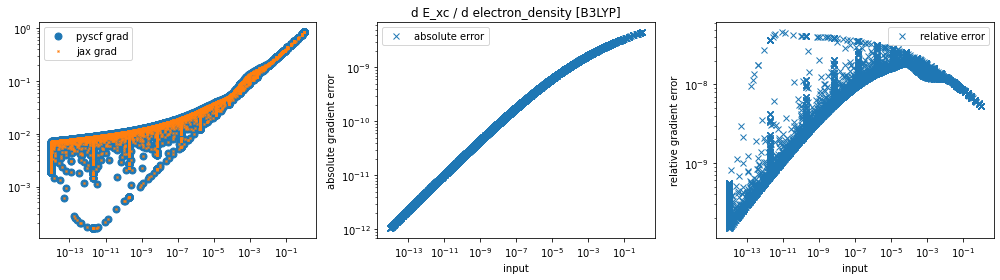

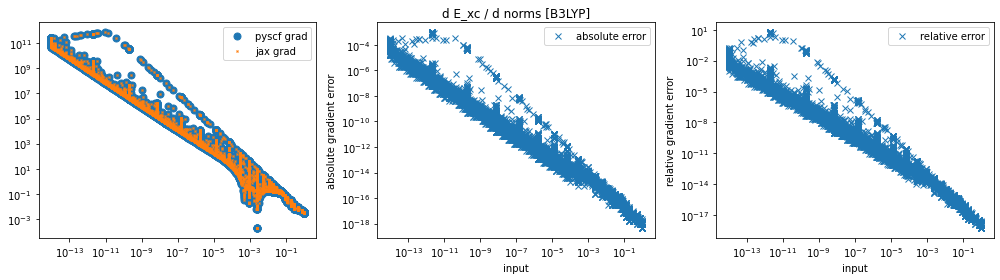

In [ ]:
#!gdown 1u5y5XfbPNSelzAo-DP4Vg_xF_jEJlxtU -q # download rho for He2

import matplotlib.pyplot as plt 
from jax.config import config
config.update('jax_enable_x64', True)

import numpy as np
#rhos = np.load("rhos_He2.npz")["rhos"] # list of different molecules. 
#rho = rhos[-1]
rho = np.load("rho0.npz")["rho"] # list of different molecules. 
#rho = np.clip(rho, 1e-10, 1)


def plot(rho, b, a, g, grad, vnorm=None, name=""): # b is pyscf a is us 

  fig, ax = plt.subplots(1, 3, figsize=(14, 4))
  ax[0].plot(rho[0], -b, 'o', label="pyscf.eval_b3lyp",  ms=7)
  ax[0].plot(rho[0], -a, 'x', label="jax_b3lyp", ms=2)

  ax[1].plot(rho[0], np.abs(a-b), 'x', label="absolute error")
  ax[1].set_yscale("log") 
  ax[1].set_xscale("log") 
  ax[1].set_xlabel("input to b3lyp") 
  ax[1].set_ylabel("absolute error") 
  ax[1].legend()

  ax[2].plot(rho[0], np.abs(a-b)/np.abs(b), 'x', label="relative error")
  ax[2].set_yscale("log") 
  ax[2].set_xscale("log") 
  ax[2].set_xlabel("input to b3lyp") 
  ax[2].set_ylabel("relative absolute error")
  ax[2].legend()

  ax[0].set_yscale("log")
  ax[0].set_xscale("log")
  ax[0].set_ylabel("input to b3lyp")
  ax[0].set_xlabel("output of b3lyp")
  ax[0].legend()

  plt.tight_layout()
  ax[1].set_title("E_xc [%s]" % name)

  fig, ax = plt.subplots(1,3, figsize=(14, 4))

  ax[0].plot(rho[0], -g[0], 'o',                label="pyscf grad", ms=7)
  #ax[0].plot(rho[0], -grad[:, 0]*rho[0]*4, 'x', label="jax grad",   ms=2) # no idea where the factor 4 comes from... 

  if grad.ndim == 2: grad = grad[:, 0]

  ax[0].plot(rho[0], -grad, 'x', label="jax grad",   ms=2) # no idea where the factor 4 comes from... 
  ax[0].legend()

  #ax[1].plot(rho[0], np.abs(g[0]-grad[:, 0]*rho[0]*4), 'x', label="absolute error") # lda fix 
  ax[1].plot(rho[0], np.abs(g[0]-grad), 'x', label="absolute error")
  ax[1].legend()
  ax[1].set_xlabel("input")
  ax[1].set_ylabel("absolute gradient error")
  ax[1].set_title("d E_xc / d electron_density [%s]" % name)

  #ax[2].plot(rho[0], np.abs(g[0]-grad[:, 0]*rho[0]*4)/np.abs(g[0]), 'x', label="relative error") # lda fix 
  ax[2].plot(rho[0], np.abs(g[0]-grad)/np.abs(g[0]), 'x', label="relative error")
  ax[2].legend()
  ax[2].set_xlabel("input")
  ax[2].set_ylabel("relative gradient error")


  ax[0].set_yscale("log")
  ax[0].set_xscale("log")

  ax[1].set_yscale("log")
  ax[1].set_xscale("log")

  ax[2].set_yscale("log")
  ax[2].set_xscale("log")
  plt.tight_layout()

  if vnorm is not None: 
    fig, ax = plt.subplots(1,3, figsize=(14, 4))

    ax[0].plot(rho[0], np.abs(g[1]), 'o',                label="pyscf grad", ms=7)
    ax[0].plot(rho[0], np.abs(vnorm), 'x', label="jax grad",   ms=2) 
    ax[0].legend()

    ax[1].plot(rho[0], np.abs(g[1]-vnorm), 'x', label="absolute error")
    ax[1].legend()
    ax[1].set_xlabel("input")
    ax[1].set_ylabel("absolute gradient error")

    ax[1].set_title("d E_xc / d norms [%s]" % name)

    ax[2].plot(rho[0], np.abs(g[1]-vnorm)/np.abs(g[0]), 'x', label="relative error")
    ax[2].legend()
    ax[2].set_xlabel("input")
    ax[2].set_ylabel("relative gradient error")

    ax[0].set_yscale("log")
    ax[0].set_xscale("log")

    ax[1].set_yscale("log")
    ax[1].set_xscale("log")

    ax[2].set_yscale("log")
    ax[2].set_xscale("log")
    plt.tight_layout()

import jax 
import jax.numpy as jnp 

def lda(rho): return -jnp.exp(1/3*jnp.log(rho) - 0.30305460484554375)

def lyp(rho0, norms):
  n = rho0
  gnn = norms
  
  a = 0.5 * n
  b = 0.5 * n
  gaa = 0.25 * gnn
  gab = gaa
  gbb = gaa

  A  = 0.04918
  B  = 0.132
  C  = 0.2533
  Dd = 0.349

  n = a + b
  gnn = gaa + 2.0 * gab + gbb

  CF = 0.3 * (3.0 * jnp.pi * jnp.pi) ** (2.0 / 3.0)
  icbrtn = n ** (-1.0 / 3.0)
  P = 1.0 / (1.0 + Dd * icbrtn)
  omega = jnp.exp(-C * icbrtn) * P * n ** (-11.0 / 3.0)
  delta = icbrtn * (C + Dd * P)
  n2 = n * n
  return -A * (
      4.0 * a * b * P / n
      + B
      * omega
      * (
          a
          * b
          * (
              2.0 ** (11.0 / 3.0) * CF * (a ** (8.0 / 3.0) + b ** (8.0 / 3.0))
              + (47.0 - 7.0 * delta) * gnn / 18.0
              - (2.5 - delta / 18.0) * (gaa + gbb)
              - (delta - 11.0) / 9.0 * (a * gaa + b * gbb) / n
          )
          - 2.0 / 3.0 * n2 * gnn
          + (2.0 / 3.0 * n2 - a * a) * gbb
          + (2.0 / 3.0 * n2 - b * b) * gaa
      )
  )  

def _b88_a_gaa(a, gaa):
    na43 = a ** (4.0 / 3.0)
    chi2 = gaa * a ** (-8.0 / 3.0)
    chi = jnp.sqrt(chi2)
    d = 0.0042
    b88 = -(d * na43 * chi2) / (1.0 + 6.0 * d * chi * jnp.arcsinh(chi))
    slaterx_a =  (-3.0 / 4.0) * (6.0 / jnp.pi) ** (1.0 / 3.0) * a ** (4.0 / 3.0)
    return slaterx_a + b88

def b88_n_gnn(n, gnn):
    a = 0.5 * n
    b = 0.5 * n
    gaa = 0.25 * gnn
    gbb = gaa
    return (_b88_a_gaa(a, gaa) + _b88_a_gaa(b, gbb))#/n

def b88(rho):
  rho0 = rho[0]
  norm = jnp.linalg.norm(rho[1:], axis=0)**2
  return b88_n_gnn(rho0, norm) 


def _vwn_f(s, p):
    return (
        0.5
        * p[1]
        * (
            2.0 * jnp.log(s)
            + (p[0] * p[2] / (p[0] * p[0] + p[0] * p[2] + p[3]) - 1.0) * jnp.log( s * s + p[2] * s + p[3])
            - ( 2.0 * (p[0] * p[2] / (p[0] * p[0] + p[0] * p[2] + p[3]) - 1) + 2.0)* jnp.log(  s - p[0]  )
            + (
                2.0
                * p[2]
                * (
                    1.0 / jnp.sqrt(4.0 * p[3] - p[2] * p[2])
                    - p[0]
                    / (
                        (p[0] * p[0] + p[0] * p[2] + p[3])
                        * jnp.sqrt(4.0 * p[3] - p[2] * p[2])
                        / (p[2] + 2.0 * p[0])
                    )
                )
            ) * jnp.arctan( jnp.sqrt(4.0 * p[3] - p[2] * p[2]) / (2.0 * s + p[2]))
        )
    )

@jax.jit
def vwn5_a_b(a, b):
    para = [-0.10498, 0.0621813817393097900698817274255, 3.72744, 12.9352]
    ferro = [-0.325, 0.0310906908696548950349408637127, 7.06042, 18.0578]
    inter = [-0.0047584, -1.0 / (3.0 * jnp.pi * jnp.pi), 1.13107, 13.0045]

    n = a + b

    r_s = (3.0 / (4.0 * jnp.pi * n)) ** (1.0 / 3.0)
    s = r_s ** 0.5

    zeta = (a - b) / n
    g = 1.92366105093154 * ( ((1.0 + zeta) ** (4/3) + (1.0 - zeta) ** (4/3))   - 2.0) 
    zeta4 = zeta ** 4.0
    dd = g * (
        (_vwn_f(s, ferro) - _vwn_f(s, para)) * zeta4
        + _vwn_f(s, inter) * (1.0 - zeta4) * (9.0 / 4.0 * (2.0 ** (1.0 / 3.0) - 1.0))
    )

    return n * (_vwn_f(s, para) + dd)

def vwn(rho):  return vwn5_a_b(0.5 * rho, 0.5 * rho) 

def b3lyp(rho): 
  rho0  = rho.T[:, 0]
  norms = np.linalg.norm(rho[1:], axis=0).T**2

  e_xc_lda, v_rho_lda               = jax.vmap(jax.value_and_grad(lambda x: lda(x)*0.08))(rho0)
  e_xc_vwn, v_rho_vwn               = jax.vmap(jax.value_and_grad(lambda x: vwn(x)*0.19))(rho0)
  e_xc_b88, (v_rho_b88, v_norm_b88) = jax.vmap(jax.value_and_grad(lambda rho0, norm: b88_n_gnn(rho0, norm)*0.72, (0,1)))(rho0, norms)
  e_xc_lyp, (v_rho_lyp, v_norm_lyp) = jax.vmap(jax.value_and_grad(lambda rho0, norm: lyp(rho0, norm)*0.810, (0,1)))(rho0, norms)

  e_xc = e_xc_lda + (e_xc_vwn + e_xc_b88 + e_xc_lyp) / rho[0]

  v_xc_rho = v_rho_lda*4*rho[0] + v_rho_vwn + v_rho_b88 + v_rho_lyp 
  v_xc_norms = v_norm_b88 + v_norm_lyp 

  return e_xc, v_xc_rho, v_xc_norms

rho = jax.lax.clamp(1e-14, rho, 1.)

e_xc, v_xc_rho, v_xc_norms = b3lyp(rho)

#print(e_xc[e_xc!=e_xc])
#print(v_xc_rho[v_xc_rho!=v_xc_rho])
#print(v_xc_norms[v_xc_norms!=v_xc_norms])



_hyb, fn_facs = pyscf.dft.libxc.parse_xc("b3lyp") # .2 * HF + .08 * LDA + .72 * B88, .810 * LYP + .19 * VW
e_xc_pyscf, v_xc_pyscf  = pyscf.dft.libxc._eval_xc(_hyb, fn_facs, rho, spin=0, relativity=0, deriv=1, verbose=False)[:2]


plot(rho, e_xc_pyscf, e_xc, v_xc_pyscf, v_xc_rho , vnorm=v_xc_norms, name="B3LYP")

print(np.allclose(e_xc_pyscf, e_xc))
print(np.allclose(v_xc_pyscf[0], v_xc_rho))
print(np.allclose(v_xc_pyscf[1], v_xc_norms))

In [ ]:
# numpy version 
import pyscf 
import pyscf.dft
import math 
from tqdm import tqdm
import numpy 
import jax.numpy as jnp 
import ctypes
import _ctypes



libdft  = pyscf.lib.load_library('libdft')
libcvhf = pyscf.lib.load_library('libcvhf') 

def load_library(libname):
    '''try:
        #_loaderpath = os.path.dirname(__file__)
        return numpy.ctypeslib.load_library(libname, _loaderpath)
    except OSError:'''
    from pyscf import __path__ as ext_modules
    for path in ext_modules:
        libpath = os.path.join(path, 'lib')
        if os.path.isdir(libpath):
            for files in os.listdir(libpath):
                if files.startswith(libname):
                    return numpy.ctypeslib.load_library(libname, libpath)

def _eval_xc_(hyb, fn_facs, rho, spin=0, relativity=0, deriv=1, verbose=None):

    if spin == 0:
        nspin = 1
        rho_u = rho_d = numpy.asarray(rho, order='C')
    else:
        nspin = 2
        rho_u = numpy.asarray(rho[0], order='C')
        rho_d = numpy.asarray(rho[1], order='C')

    if rho_u.ndim == 1:
        rho_u = rho_u.reshape(1,-1)
        rho_d = rho_d.reshape(1,-1)
    ngrids = rho_u.shape[1]

    fn_ids = [x[0] for x in fn_facs]
    facs   = [x[1] for x in fn_facs]
    
    if hyb[2] != 0:
        # Current implementation does not support different omegas for
        # different RSH functionals if there are multiple RSHs
        omega = [hyb[2]] * len(facs)
    else:
        omega = [0] * len(facs)
    fn_ids_set = set(fn_ids)

    n = len(fn_ids)
    if spin == 0:
        nvar = 2
        xctype = 'R-GGA'
    else:
        nvar = 5
        xctype = 'U-GGA'

    outlen = (math.factorial(nvar+deriv) // (math.factorial(nvar) * math.factorial(deriv)))
    outbuf = numpy.zeros((outlen,ngrids))

    density_threshold = 0
    #_itrf = pyscf.lib.load_library('libxc_itrf')
    _itrf = load_library('libxc_itrf')
    _itrf.LIBXC_eval_xc(ctypes.c_int(n),
                        (ctypes.c_int*n)(*fn_ids),
                        (ctypes.c_double*n)(*facs),
                        (ctypes.c_double*n)(*omega),
                        ctypes.c_int(nspin),
                        ctypes.c_int(deriv), ctypes.c_int(ngrids),
                        rho_u.ctypes.data_as(ctypes.c_void_p),
                        rho_d.ctypes.data_as(ctypes.c_void_p),
                        outbuf.ctypes.data_as(ctypes.c_void_p),
                        ctypes.c_double(density_threshold))

    exc = outbuf[0]
    if xctype == 'R-GGA':   vxc = [outbuf[1], outbuf[2]]
    elif xctype == 'U-GGA': vxc = [outbuf[1:3].T, outbuf[3:6].T]

    return exc, vxc

def _eval_xc(hyb, fn_facs, rho, spin=0, relativity=0, deriv=1, verbose=None):
    fn_ids = [x[0] for x in fn_facs]
    facs   = [x[1] for x in fn_facs]
    
    omega = [0] * len(facs)
    fn_ids_set = set(fn_ids)

    outbuf = np.zeros(( math.factorial(2+deriv) // (math.factorial(2) * math.factorial(deriv)) , rho.shape[1]))

    _itrf = load_library('libxc_itrf')
    _itrf.LIBXC_eval_xc(ctypes.c_int(len(fn_ids)),
                        (ctypes.c_int*len(fn_ids))(*fn_ids),
                        (ctypes.c_double*len(fn_ids))(*facs),
                        (ctypes.c_double*len(fn_ids))(*omega),
                        ctypes.c_int(1),
                        ctypes.c_int(deriv), ctypes.c_int(rho.shape[1]),
                        rho.ctypes.data_as(ctypes.c_void_p),
                        rho.ctypes.data_as(ctypes.c_void_p),
                        outbuf.ctypes.data_as(ctypes.c_void_p),
                        ctypes.c_double(0)) # density_threshold

    exc = outbuf[0]
    vxc = [outbuf[1], outbuf[2]]
    return exc, vxc

class RKS(): 

    def __init__(self, mol, xc='LDA,VWN'):
        self.mol        = mol
        self.verbose    = mol.verbose

        self.max_memory     = mol.max_memory
        self._eri           = None 
        self.direct_scf     = True 
        self.direct_scf_tol = 1e-13

        self.opt = None
        
        self.xc = xc
        
        self.nlc = ''
        self.grids            = pyscf.dft.gen_grid.Grids(self.mol)
        self.grids.level      = getattr(pyscf.__config__, 'dft_rks_RKS_grids_level', self.grids.level)
        self.nlcgrids         = pyscf.dft.gen_grid.Grids(self.mol)
        self.nlcgrids.level   = getattr(pyscf.__config__, 'dft_rks_RKS_nlcgrids_level', self.nlcgrids.level)
        self.small_rho_cutoff = getattr(pyscf.__config__, 'dft_rks_RKS_small_rho_cutoff', 1e-7)
        self._numint          = pyscf.dft.numint.NumInt() # only used for initialization, not inside main loop! 
        self.max_cycle        = 50


    def get_jk(self, mol=None, dm=None, hermi=1, with_j=True, with_k=True,  omega=None):
        if mol is None: mol = self.mol
        if dm is None: dm = self.make_rdm1()
        if self.direct_scf and self.opt is None:
            self.opt = self.init_direct_scf(mol)

        if with_j and with_k:
            vj, vk = pyscf.scf.hf.get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)
        else:
            if with_j:
                prescreen = 'CVHFnrs8_vj_prescreen'
            else:
                prescreen = 'CVHFnrs8_vk_prescreen'
            with pyscf.lib.temporary_env(self.opt, prescreen=prescreen):
                vj, vk = get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)

        return vj, vk


    def init_direct_scf(self, mol=None):
        # Integrals < direct_scf_tol may be set to 0 in int2e.
        # Higher accuracy is required for Schwartz inequality prescreening.
        with mol.with_integral_screen(self.direct_scf_tol**2):
            opt = pyscf.scf._vhf.VHFOpt(mol, 'int2e', 'CVHFnrs8_prescreen',
                              'CVHFsetnr_direct_scf',
                              'CVHFsetnr_direct_scf_dm')
            opt.direct_scf_tol = self.direct_scf_tol
        return opt

    def initialize_grids(self, mol=None, dm=None): pass # only needs to be called once, believe it's called in mol.build. (get_veff calls this, step 16 commented ks.initialize_grids out)

    def kernel(self, convergence_tolerance=1e-10): 
      mol       = self.mol
      e_tot     = -1  
      converged = False

      # Initialize stuff on CPU using PySCF. 
      # For current proof of concept, we only want to jax jit the main loop. 
      dm    = pyscf.scf.hf.init_guess_by_minao(mol)         
      V_xc  = pyscf.dft.rks.get_veff(self, mol, dm)                               # Computes XC and Coulomb. 
      h1e   = mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc') # Fixed part of hamiltonian. 
      
      s1e   = mol.intor_symmetric('int1e_ovlp')                                   # "Overlap matrix", added to generalized eigensolver. 
      L     = np.linalg.cholesky(s1e)                                             # Used by mean to turn generalized eigenproblem into a normal eigenproblem. 
      L_inv = np.linalg.inv(L)                                                    # Same as above. 

      nuclear_energy  = mol.energy_nuc()
      n_electrons     = mol.nelectron

      mf_diis_space                   = 8                                         # Try increasing this to e.g. 64. Will probably converge faster and make each iteration only a little slower. 
      e_idx                           = np.arange(V_xc.shape[0])
      mo_occ                          = numpy.zeros(V_xc.shape[0])
      mo_occ[e_idx[:n_electrons//2]]  = 2 
      mo_occ_nnz                      = mo_occ[mo_occ>0] 

      #pbar = tqdm(range(self.max_cycle))
      pbar = None 

      if pbar is None: pbar = range(self.max_cycle)

      mf_diis_H = np.zeros((mf_diis_space+1,mf_diis_space+1), np.float64)
      mf_diis_H[0,1:] = mf_diis_H[1:,0] = 1
      mf_diis_head   = 0

      d, hamil_d = np.prod(h1e.shape), np.prod(h1e.shape)
      _V = np.zeros((mf_diis_space, d))
      _H = np.zeros((mf_diis_space, d))

      # Fixed values used in last part of main iteration. 
      # Depends only on xc type. For b3lyp the values are B3LYP has 0, 0, 0.2 
      omega, alpha, beta          = pyscf.dft.libxc.rsh_coeff(self.xc) 
      if abs(omega) > 1e-10:  hyb = alpha + beta 
      else:                   hyb = pyscf.dft.libxc.hybrid_coeff(self.xc, mol.spin) 

      last_vj    = V_xc.vj
      last_vk    = V_xc.vk

      # Is molecule in cartesian or spherical coordinates. 
      feval = 'GTOval_cart_deriv1' if self.mol.cart else 'GTOval_sph_deriv1' 
      ao    = self.mol.eval_gto( feval, self.grids.coords, (1+1)*(1+2)*(1+3)//6 ) # <-- molecule dependent stuff! this doesn't change, so we can just compute it once. NOtably, we don't have to jax it!!!!!!!!!

      # More fixed valeus used in last part of main iteration. 
      # Again, depends only on xc type. 
      _hyb, fn_facs = pyscf.dft.libxc.parse_xc(self.xc)


      # Save values here to emphasize they don't change each iteration. 
      mol_atm = mol._atm 
      mol_bas = mol._bas
      mol_env = mol._env 
      mol_cart = mol.cart 

      nao = mol.nao_nr()
      eri0 = mol.intor('int2e_sph').reshape((nao,)*4)

      rhos = []

      # Goal: Wrap the inner part in a function and jax jit that function. 
      for cycle in pbar: 
          dm_last           = dm        
          last_hf_e         = e_tot
          V_xc_last         = V_xc 

          hamiltonian       = h1e + V_xc
          sdf               = s1e @ dm @ hamiltonian
          errvec            = sdf.T - sdf

          # ============ STRAT DIIS =============== #
          # Initially 500 lines of code split over 5 files. 
          mf_diis_head      = cycle % _V.shape[0]
          nd                = min(cycle, _V.shape[0])

          _V[mf_diis_head]  = errvec.reshape(-1) 
          _H[mf_diis_head]  = hamiltonian.reshape(-1)

          tmps = _V[:nd].reshape(-1, 1, d) @ errvec.reshape(1, d, 1) 
          mf_diis_H[mf_diis_head+1, 1:nd+1] = tmps.reshape(-1)[:nd]
          mf_diis_H[1:nd+1, mf_diis_head+1] = tmps.reshape(-1)[:nd]
          
          # Compute H^-1@[1, 0, ..., 0] using eigh. 
          # this is only 8x8 matrix, but we are essentially just solving for first col of inverse. 
          # this can probably be done directly. especially if we keep in mind mf_diis_H is updated only one row/col every iteration
          c            = np.linalg.pinv(mf_diis_H[:nd+1, :nd+1]) @ np.concatenate((np.ones(1), np.zeros(nd)))  
          hamiltonian  = np.sum( _H[:nd] * c[1:].reshape(nd, 1), axis=0).reshape(hamiltonian.shape)
          # ============ END DIIS =============== #

          # Solve generalized eigenproblem using normal eigh solver using this trick: https://www.jstor.org/stable/2949370
          eigvals, eigvects = np.linalg.eigh(L_inv @ hamiltonian @ L_inv.T)  
          eigvects          = L_inv.T @ eigvects 

          # Reconstruct density matrix using eigenvectors. 
          dm                = (eigvects[:, mo_occ>0] * mo_occ_nnz) @ eigvects[:, mo_occ>0].T 

          # ================= numerical_integration ==================== #
          # Compute update to V_xc.  --> nr_rks_only_GGA <--
          # Used to be ~ 500 lines of code. 
          c0        = ao[0] @ dm
          rho       = np.sum( c0.reshape((1,) + c0.shape) * ao, axis=2)
          rho[1:4] *= 2  
          
          #rhos.append(rho)
          #print(rho.shape, ao.shape, dm.shape, c0.shape)
          # this is always 4 big?  why is electron density 4 big? 
          #if cycle > 0: print("\t%4fs"%(time.time()-t2), end="") # 50ms compared to 250ms for entire iteration!  (lda is 6ms?)
          #t1 = time.time()
          rhos.append(rho)

          #exc, vxc    = _eval_xc(_hyb, fn_facs, rho, spin=0, relativity=0, deriv=1, verbose=False)  # <--- jaxify this!
          #rho = np.array(jax.lax.clamp(1e-100, rho, 100.))
          #rho = np.array(jnp.array(rho))
          rho[0] = np.clip(rho[0], 1e-14, 1e12) # don't clip the norms part, they can be negative! 

          exc1, vxc1  = _eval_xc(_hyb, fn_facs[0:1], rho, spin=0, relativity=0, deriv=1, verbose=False) # LDA 
          exc2, vxc2  = _eval_xc(_hyb, fn_facs[1:2], rho, spin=0, relativity=0, deriv=1, verbose=False) 
          exc3, vxc3  = _eval_xc(_hyb, fn_facs[2:3], rho, spin=0, relativity=0, deriv=1, verbose=False) 
          exc4, vxc4  = _eval_xc(_hyb, fn_facs[3:4], rho, spin=0, relativity=0, deriv=1, verbose=False)

          # TODO
          # 1. redo saving rho (shape mistake last time). 
          # 2. redo regression, do regression on more points (maybe 100 million)
          # 3. do in the same notebook, and store stuff into gdrive?

          # exc is used to compute energy (and thus stopping criteria)
          # vxc is used in the main computation and is critical. 
          # as a result, wrong exc still allows us to get correct hlgap, as long as vxc is correct. 
          # we can still check result on hlgap, so we only need vxc to start with! 
          # if we have this, we can check result and jit jax compile everything! 


          exc    = exc1 + exc2 + exc3 + exc4

          vrho   = vxc1[0] + vxc2[0] + vxc3[0] + vxc4[0]
          vgamma = vxc1[1] + vxc2[1] + vxc3[1] + vxc4[1]

          exc, vrho, vgamma = b3lyp(rho)
          #exc, vrho, vgamma = b3lyp(rho)

          #np.savez("rho%i"%cycle, rho=rho)

          #print(np.allclose(exc, _exc, atol=10**(-6)), np.allclose(vrho, _vrho, atol=10**(-5)), np.allclose(vgamma, _vgamma, atol=10**(-5)))
          #fig, ax = plt.subplots(1,3)
          #ax[0]

          
          den          = rho[0] * self.grids.weights                            # Is this the electron density? 
          excsum       = den @ exc 

          #vrho, vgamma = vxc[:2]
          wv           = numpy.empty((4, self.grids.size))
          wv[0]        = vrho * .5  
          wv[1:]       = 2 * vgamma * rho[1:4]
          wv[:]       *= self.grids.weights 

          aow          = numpy.einsum('npi,np->pi', ao[:4], wv)
          
          vmat         = ao[0].T @ aow
          print(ao.shape)
          vmat         = vmat + vmat.T

          E_xc, V_xc   = excsum, vmat
          # =================== end numerical integration ================== #
          vj = numpy.einsum('ijkl,ji->kl', eri0, dm-dm_last)
          vk = numpy.einsum('ijkl,jk->il', eri0, dm-dm_last)
          
          vk      *= hyb
          vj      += last_vj 
          vk      += last_vk 

          V_xc    += vj - vk * .5

          last_vj  = vj
          last_vk  = vk

          # Below computes energy. 
          E_xc      = E_xc - np.sum(dm * vk.T) * .5 * .5
          E_coulomb = np.sum(dm * vj.T) * .5

          # Compute energy. Currently only used to check for convergence. 
          e_tot     =  np.sum(h1e * dm.T) + E_coulomb + E_xc + nuclear_energy

          if type(pbar) != type(range(0,1)): pbar.set_description("E=%4f change=%4e tolerance=%4e"%(e_tot, abs(e_tot-last_hf_e), convergence_tolerance))

          if abs(e_tot - last_hf_e) < convergence_tolerance:
              converged = True
              break

      np.savez("rhos_%s.npz"%mol.name, rhos=rhos)

      self.converged, self.e_tot,  self.mo_energy, self.mo_coeff, self.mo_occ =  converged, e_tot, eigvals, eigvects, mo_occ
      return self.e_tot 

count = 0 
def jax_scf(str):
  global count 
  basis_set = "6-31G*"
  xc_fun    = "b3lyp" 
  #xc_fun    ="0.2*HF+0.08*LDA" 
  #xc_fun    ="0.2*HF+.72 * B88, .810 * LYP " 
  #xc_fun    =".2 * HF + .08 * LDA + .72 * B88, .810 * LYP + .19 * VWN" 
  #xc_fun    =".2 * HF + .72 * B88, .810 * LYP " 

  #xc_fun    =".2 * HF + .08 * LDA + .72 * B88, .810 * LYP " 
  #xc_fun    ="HF + LDA " 

  # So PCQ uses eV and PySCF uses Hartree 
  eV_to_hartree    = 0.0367493
  hartree_to_eV    = 27.2114
  angstrom_to_bohr = 1.88973


  t0 = time.time()
  mol = pyscf.gto.mole.Mole()


  #print("building molecule:")
  mol.build(atom=str, unit="Bohr", basis=basis_set)#, spin=1)
  mol.name = count
  count += 1 
  #print(time.time()-t0)

  mol.verbose = 0 
  mf = RKS(mol) 
  mf.xc = xc_fun 

  t0 = time.time()
  energy = mf.kernel()
  t = time.time()-t0

  lumo            = np.argmin(mf.mo_occ)
  homo            = lumo - 1
  hl_gap_hartree  = np.abs(mf.mo_energy[homo] - mf.mo_energy[lumo])
  hlgap           = hartree_to_eV*hl_gap_hartree
  return energy, hlgap, t

#test_cases(our_fun=jax_scf, list=[0], verbose=True) 
test_cases(our_fun=jax_scf, list=[4], verbose=True) 
#test_cases(our_fun=jax_scf, list=[70], verbose=True) 
#test_cases(our_fun=jax_scf, list=[0,50], verbose=True) 
#test_cases(our_fun=jax_scf, verbose=True) 

# -102.629 2.629 |  -102.629 2.629 


|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
CHHHHFalse
(4, 54000, 22)
(4, 54000, 22)
(4, 54000, 22)
(4, 54000, 22)
(4, 54000, 22)
(4, 54000, 22)
(4, 54000, 22)
(4, 54000, 22)
(4, 54000, 22)
(4, 54000, 22)
(4, 54000, 22)
(4, 54000, 22)
(4, 54000, 22)
	 -40.4816683370559 13.791234914322104 7.833460569381714

KeyboardInterrupt: ignored


where ${\displaystyle a=0.20}{\displaystyle a=0.20}, {\displaystyle b=0.72}{\displaystyle b=0.72}$, and ${\displaystyle c=0.81}{\displaystyle c=0.81}. {\displaystyle E_{\text{x}}^{\text{B}}}{\displaystyle E_{\text{x}}^{\text{B}}}$ is a generalized gradient approximation: the Becke 88 exchange functional[6] and the correlation functional of Lee, Yang and Parr[7] for B3LYP, and ${\displaystyle E_{\text{c}}^{\text{LSDA}}}{\displaystyle E_{\text{c}}^{\text{LSDA}}}$ is the VWN local spin density approximation to the correlation functional.[8]

In [ ]:
# sort molecules by how many basis functions they'll need! 
# then we can circumvent recompiling, and call the same compiled code! 
test_cases(our_fun=jax_scf, verbose=True) 

|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
|            HeHe |   -5.800 47.014 |   -5.800 47.014 |     0.000 0.000 |       47.014227 |          0.918437s |          0.589378s |
|          HeHeHe |   -8.700 46.375 |   -8.700 46.375 |     0.000 0.000 |       46.374526 |          1.642534s |          0.883862s |
|           CHHHH |  -40.482 13.791 |  -40.482 13.791 |     0.000 0.000 |       13.791238 |          5.160485s |          2.619080s |
|            NHHH |   -56.510 9.031 |   -56.510 9.031 |     0.000 0.000 |        9.031433 |          4.797185s |          2.384631s |
|             OHH |   -76.370 9.664 |   -76.370 9.664 |     0.000 0.000 |        9.663530 |          3.874891s |          1.821389s |
|            BeBe |   -29.316 2.950 |   -29.316 2.950 |     0.000 0.000 |        2.950380 |          3.186222s |          2.247792s |
|              FH | -100.380 11.927 | -100.380 11.927 |     0.00

RuntimeError: ignored

# Step 19: merge jax_b3lyp with code 

In [ ]:
import matplotlib.pyplot as plt 
from jax.config import config
config.update('jax_enable_x64', True)
import jax 
import jax.numpy as jnp 

def lda(rho): return -jnp.exp(1/3*jnp.log(rho) - 0.30305460484554375)

def lyp(rho0, norms):
  n = rho0
  gnn = norms
  
  a = 0.5 * n
  b = 0.5 * n
  gaa = 0.25 * gnn
  gab = gaa
  gbb = gaa

  A  = 0.04918
  B  = 0.132
  C  = 0.2533
  Dd = 0.349

  n = a + b
  gnn = gaa + 2.0 * gab + gbb

  CF = 0.3 * (3.0 * jnp.pi * jnp.pi) ** (2.0 / 3.0)
  icbrtn = n ** (-1.0 / 3.0)
  P = 1.0 / (1.0 + Dd * icbrtn)
  omega = jnp.exp(-C * icbrtn) * P * n ** (-11.0 / 3.0)
  delta = icbrtn * (C + Dd * P)
  n2 = n * n
  return -A * (
      4.0 * a * b * P / n
      + B
      * omega
      * (
          a
          * b
          * (
              2.0 ** (11.0 / 3.0) * CF * (a ** (8.0 / 3.0) + b ** (8.0 / 3.0))
              + (47.0 - 7.0 * delta) * gnn / 18.0
              - (2.5 - delta / 18.0) * (gaa + gbb)
              - (delta - 11.0) / 9.0 * (a * gaa + b * gbb) / n
          )
          - 2.0 / 3.0 * n2 * gnn
          + (2.0 / 3.0 * n2 - a * a) * gbb
          + (2.0 / 3.0 * n2 - b * b) * gaa
      )
  )  

def _b88_a_gaa(a, gaa):
    na43 = a ** (4.0 / 3.0)
    chi2 = gaa * a ** (-8.0 / 3.0)
    chi = jnp.sqrt(chi2)
    d = 0.0042
    b88 = -(d * na43 * chi2) / (1.0 + 6.0 * d * chi * jnp.arcsinh(chi))
    slaterx_a =  (-3.0 / 4.0) * (6.0 / jnp.pi) ** (1.0 / 3.0) * a ** (4.0 / 3.0)
    return slaterx_a + b88

def b88_n_gnn(n, gnn):
    a = 0.5 * n
    b = 0.5 * n
    gaa = 0.25 * gnn
    gbb = gaa
    return (_b88_a_gaa(a, gaa) + _b88_a_gaa(b, gbb))#/n

def b88(rho):
  rho0 = rho[0]
  norm = jnp.linalg.norm(rho[1:], axis=0)**2
  return b88_n_gnn(rho0, norm) 


def _vwn_f(s, p):
    return (
        0.5
        * p[1]
        * (
            2.0 * jnp.log(s)
            + (p[0] * p[2] / (p[0] * p[0] + p[0] * p[2] + p[3]) - 1.0) * jnp.log( s * s + p[2] * s + p[3])
            - ( 2.0 * (p[0] * p[2] / (p[0] * p[0] + p[0] * p[2] + p[3]) - 1) + 2.0)* jnp.log(  s - p[0]  )
            + (
                2.0
                * p[2]
                * (
                    1.0 / jnp.sqrt(4.0 * p[3] - p[2] * p[2])
                    - p[0]
                    / (
                        (p[0] * p[0] + p[0] * p[2] + p[3])
                        * jnp.sqrt(4.0 * p[3] - p[2] * p[2])
                        / (p[2] + 2.0 * p[0])
                    )
                )
            ) * jnp.arctan( jnp.sqrt(4.0 * p[3] - p[2] * p[2]) / (2.0 * s + p[2]))
        )
    )

@jax.jit
def vwn5_a_b(a, b):
    para = [-0.10498, 0.0621813817393097900698817274255, 3.72744, 12.9352]
    ferro = [-0.325, 0.0310906908696548950349408637127, 7.06042, 18.0578]
    inter = [-0.0047584, -1.0 / (3.0 * jnp.pi * jnp.pi), 1.13107, 13.0045]

    n = a + b

    r_s = (3.0 / (4.0 * jnp.pi * n)) ** (1.0 / 3.0)
    s = r_s ** 0.5

    zeta = (a - b) / n
    g = 1.92366105093154 * ( ((1.0 + zeta) ** (4/3) + (1.0 - zeta) ** (4/3))   - 2.0) 
    zeta4 = zeta ** 4.0
    dd = g * (
        (_vwn_f(s, ferro) - _vwn_f(s, para)) * zeta4
        + _vwn_f(s, inter) * (1.0 - zeta4) * (9.0 / 4.0 * (2.0 ** (1.0 / 3.0) - 1.0))
    )

    return n * (_vwn_f(s, para) + dd)

def vwn(rho):  return vwn5_a_b(0.5 * rho, 0.5 * rho) 

def b3lyp(rho): 
  rho0  = rho.T[:, 0]
  norms = jnp.linalg.norm(rho[1:], axis=0).T**2+1e-20 # to circumvent zero division! 

  e_xc_lda, v_rho_lda               = jax.vmap(jax.value_and_grad(lambda x: lda(x)*0.08))(rho0)
  e_xc_vwn, v_rho_vwn               = jax.vmap(jax.value_and_grad(lambda x: vwn(x)*0.19))(rho0)
  e_xc_b88, (v_rho_b88, v_norm_b88) = jax.vmap(jax.value_and_grad(lambda rho0, norm: b88_n_gnn(rho0, norm)*0.72, (0,1)))(rho0, norms)
  e_xc_lyp, (v_rho_lyp, v_norm_lyp) = jax.vmap(jax.value_and_grad(lambda rho0, norm: lyp(rho0, norm)*0.810, (0,1)))(rho0, norms)

  e_xc = e_xc_lda + (e_xc_vwn + e_xc_b88 + e_xc_lyp) / rho[0]

  v_xc_rho = v_rho_lda*4*rho[0] + v_rho_vwn + v_rho_b88 + v_rho_lyp 
  v_xc_norms = v_norm_b88 + v_norm_lyp 

  return e_xc, v_xc_rho, v_xc_norms


b3lyp = jax.jit(b3lyp)


# numpy version 
import pyscf 
import pyscf.dft
import math 
from tqdm import tqdm
import numpy 
import jax.numpy as jnp 
import ctypes
import _ctypes



libdft  = pyscf.lib.load_library('libdft')
libcvhf = pyscf.lib.load_library('libcvhf') 

def load_library(libname):
    '''try:
        #_loaderpath = os.path.dirname(__file__)
        return numpy.ctypeslib.load_library(libname, _loaderpath)
    except OSError:'''
    from pyscf import __path__ as ext_modules
    for path in ext_modules:
        libpath = os.path.join(path, 'lib')
        if os.path.isdir(libpath):
            for files in os.listdir(libpath):
                if files.startswith(libname):
                    return numpy.ctypeslib.load_library(libname, libpath)

def _eval_xc_(hyb, fn_facs, rho, spin=0, relativity=0, deriv=1, verbose=None):

    if spin == 0:
        nspin = 1
        rho_u = rho_d = numpy.asarray(rho, order='C')
    else:
        nspin = 2
        rho_u = numpy.asarray(rho[0], order='C')
        rho_d = numpy.asarray(rho[1], order='C')

    if rho_u.ndim == 1:
        rho_u = rho_u.reshape(1,-1)
        rho_d = rho_d.reshape(1,-1)
    ngrids = rho_u.shape[1]

    fn_ids = [x[0] for x in fn_facs]
    facs   = [x[1] for x in fn_facs]
    
    if hyb[2] != 0:
        # Current implementation does not support different omegas for
        # different RSH functionals if there are multiple RSHs
        omega = [hyb[2]] * len(facs)
    else:
        omega = [0] * len(facs)
    fn_ids_set = set(fn_ids)

    n = len(fn_ids)
    if spin == 0:
        nvar = 2
        xctype = 'R-GGA'
    else:
        nvar = 5
        xctype = 'U-GGA'

    outlen = (math.factorial(nvar+deriv) // (math.factorial(nvar) * math.factorial(deriv)))
    outbuf = numpy.zeros((outlen,ngrids))

    density_threshold = 0
    #_itrf = pyscf.lib.load_library('libxc_itrf')
    _itrf = load_library('libxc_itrf')
    _itrf.LIBXC_eval_xc(ctypes.c_int(n),
                        (ctypes.c_int*n)(*fn_ids),
                        (ctypes.c_double*n)(*facs),
                        (ctypes.c_double*n)(*omega),
                        ctypes.c_int(nspin),
                        ctypes.c_int(deriv), ctypes.c_int(ngrids),
                        rho_u.ctypes.data_as(ctypes.c_void_p),
                        rho_d.ctypes.data_as(ctypes.c_void_p),
                        outbuf.ctypes.data_as(ctypes.c_void_p),
                        ctypes.c_double(density_threshold))

    exc = outbuf[0]
    if xctype == 'R-GGA':   vxc = [outbuf[1], outbuf[2]]
    elif xctype == 'U-GGA': vxc = [outbuf[1:3].T, outbuf[3:6].T]

    return exc, vxc

def _eval_xc(hyb, fn_facs, rho, spin=0, relativity=0, deriv=1, verbose=None):
    fn_ids = [x[0] for x in fn_facs]
    facs   = [x[1] for x in fn_facs]
    
    omega = [0] * len(facs)
    fn_ids_set = set(fn_ids)

    outbuf = np.zeros(( math.factorial(2+deriv) // (math.factorial(2) * math.factorial(deriv)) , rho.shape[1]))

    _itrf = load_library('libxc_itrf')
    _itrf.LIBXC_eval_xc(ctypes.c_int(len(fn_ids)),
                        (ctypes.c_int*len(fn_ids))(*fn_ids),
                        (ctypes.c_double*len(fn_ids))(*facs),
                        (ctypes.c_double*len(fn_ids))(*omega),
                        ctypes.c_int(1),
                        ctypes.c_int(deriv), ctypes.c_int(rho.shape[1]),
                        rho.ctypes.data_as(ctypes.c_void_p),
                        rho.ctypes.data_as(ctypes.c_void_p),
                        outbuf.ctypes.data_as(ctypes.c_void_p),
                        ctypes.c_double(0)) # density_threshold

    exc = outbuf[0]
    vxc = [outbuf[1], outbuf[2]]
    return exc, vxc

class RKS(): 

    def __init__(self, mol, xc='LDA,VWN'):
        self.mol        = mol
        self.verbose    = mol.verbose

        self.max_memory     = mol.max_memory
        self._eri           = None 
        self.direct_scf     = True 
        self.direct_scf_tol = 1e-13

        self.opt = None
        
        self.xc = xc
        
        self.nlc = ''
        self.grids            = pyscf.dft.gen_grid.Grids(self.mol)
        self.grids.level      = getattr(pyscf.__config__, 'dft_rks_RKS_grids_level', self.grids.level)
        self.nlcgrids         = pyscf.dft.gen_grid.Grids(self.mol)
        self.nlcgrids.level   = getattr(pyscf.__config__, 'dft_rks_RKS_nlcgrids_level', self.nlcgrids.level)
        self.small_rho_cutoff = getattr(pyscf.__config__, 'dft_rks_RKS_small_rho_cutoff', 1e-7)
        self._numint          = pyscf.dft.numint.NumInt() # only used for initialization, not inside main loop! 
        self.max_cycle        = 50


    def get_jk(self, mol=None, dm=None, hermi=1, with_j=True, with_k=True,  omega=None):
        if mol is None: mol = self.mol
        if dm is None: dm = self.make_rdm1()
        if self.direct_scf and self.opt is None:
            self.opt = self.init_direct_scf(mol)

        if with_j and with_k:
            vj, vk = pyscf.scf.hf.get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)
        else:
            if with_j:
                prescreen = 'CVHFnrs8_vj_prescreen'
            else:
                prescreen = 'CVHFnrs8_vk_prescreen'
            with pyscf.lib.temporary_env(self.opt, prescreen=prescreen):
                vj, vk = get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)

        return vj, vk


    def init_direct_scf(self, mol=None):
        # Integrals < direct_scf_tol may be set to 0 in int2e.
        # Higher accuracy is required for Schwartz inequality prescreening.
        with mol.with_integral_screen(self.direct_scf_tol**2):
            opt = pyscf.scf._vhf.VHFOpt(mol, 'int2e', 'CVHFnrs8_prescreen',
                              'CVHFsetnr_direct_scf',
                              'CVHFsetnr_direct_scf_dm')
            opt.direct_scf_tol = self.direct_scf_tol
        return opt

    def initialize_grids(self, mol=None, dm=None): pass # only needs to be called once, believe it's called in mol.build. (get_veff calls this, step 16 commented ks.initialize_grids out)

    def kernel(self, convergence_tolerance=1e-10): 
      mol       = self.mol
      e_tot     = -1  
      converged = False

      # Initialize stuff on CPU using PySCF. 
      # For current proof of concept, we only want to jax jit the main loop. 
      dm    = pyscf.scf.hf.init_guess_by_minao(mol)         
      V_xc  = pyscf.dft.rks.get_veff(self, mol, dm)                               # Computes XC and Coulomb. 
      h1e   = mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc') # Fixed part of hamiltonian. 
      
      s1e   = mol.intor_symmetric('int1e_ovlp')                                   # "Overlap matrix", added to generalized eigensolver. 
      L     = np.linalg.cholesky(s1e)                                             # Used by mean to turn generalized eigenproblem into a normal eigenproblem. 
      L_inv = np.linalg.inv(L)                                                    # Same as above. 

      nuclear_energy  = mol.energy_nuc()
      n_electrons     = mol.nelectron

      mf_diis_space                   = 8                                         # Try increasing this to e.g. 64. Will probably converge faster and make each iteration only a little slower. 
      e_idx                           = np.arange(V_xc.shape[0])
      mo_occ                          = numpy.zeros(V_xc.shape[0])
      mo_occ[e_idx[:n_electrons//2]]  = 2 
      mo_occ_nnz                      = mo_occ[mo_occ>0] 

      #pbar = tqdm(range(self.max_cycle))
      pbar = None 

      if pbar is None: pbar = range(self.max_cycle)

      mf_diis_H = np.zeros((mf_diis_space+1,mf_diis_space+1), np.float64)
      mf_diis_H[0,1:] = mf_diis_H[1:,0] = 1
      mf_diis_head   = 0

      d, hamil_d = np.prod(h1e.shape), np.prod(h1e.shape)
      _V = np.zeros((mf_diis_space, d))
      _H = np.zeros((mf_diis_space, d))

      # Fixed values used in last part of main iteration. 
      # Depends only on xc type. For b3lyp the values are B3LYP has 0, 0, 0.2 
      omega, alpha, beta          = pyscf.dft.libxc.rsh_coeff(self.xc) 
      if abs(omega) > 1e-10:  hyb = alpha + beta 
      else:                   hyb = pyscf.dft.libxc.hybrid_coeff(self.xc, mol.spin) 

      last_vj    = V_xc.vj
      last_vk    = V_xc.vk

      # Is molecule in cartesian or spherical coordinates. 
      feval = 'GTOval_cart_deriv1' if self.mol.cart else 'GTOval_sph_deriv1' 
      ao    = self.mol.eval_gto( feval, self.grids.coords, (1+1)*(1+2)*(1+3)//6 ) # <-- molecule dependent stuff! this doesn't change, so we can just compute it once. NOtably, we don't have to jax it!!!!!!!!!

      # More fixed valeus used in last part of main iteration. 
      # Again, depends only on xc type. 
      _hyb, fn_facs = pyscf.dft.libxc.parse_xc(self.xc)


      # Save values here to emphasize they don't change each iteration. 
      mol_atm = mol._atm 
      mol_bas = mol._bas
      mol_env = mol._env 
      mol_cart = mol.cart 

      nao = mol.nao_nr()
      eri0 = mol.intor('int2e_sph').reshape((nao,)*4)

      rhos = []

      # Goal: Wrap the inner part in a function and jax jit that function. 
      for cycle in pbar: 
          dm_last           = dm        
          last_hf_e         = e_tot
          V_xc_last         = V_xc 

          hamiltonian       = h1e + V_xc
          sdf               = s1e @ dm @ hamiltonian
          errvec            = sdf.T - sdf

          # ============ STRAT DIIS =============== #
          # Initially 500 lines of code split over 5 files. 
          mf_diis_head      = cycle % _V.shape[0]
          nd                = min(cycle, _V.shape[0])

          _V[mf_diis_head]  = errvec.reshape(-1) 
          _H[mf_diis_head]  = hamiltonian.reshape(-1)

          tmps = _V[:nd].reshape(-1, 1, d) @ errvec.reshape(1, d, 1) 
          mf_diis_H[mf_diis_head+1, 1:nd+1] = tmps.reshape(-1)[:nd]
          mf_diis_H[1:nd+1, mf_diis_head+1] = tmps.reshape(-1)[:nd]
          
          # Compute H^-1@[1, 0, ..., 0] using eigh. 
          # this is only 8x8 matrix, but we are essentially just solving for first col of inverse. 
          # this can probably be done directly. especially if we keep in mind mf_diis_H is updated only one row/col every iteration
          c            = np.linalg.pinv(mf_diis_H[:nd+1, :nd+1]) @ np.concatenate((np.ones(1), np.zeros(nd)))  
          hamiltonian  = np.sum( _H[:nd] * c[1:].reshape(nd, 1), axis=0).reshape(hamiltonian.shape)
          # ============ END DIIS =============== #

          # Solve generalized eigenproblem using normal eigh solver using this trick: https://www.jstor.org/stable/2949370
          eigvals, eigvects = np.linalg.eigh(L_inv @ hamiltonian @ L_inv.T)  
          eigvects          = L_inv.T @ eigvects 

          # Reconstruct density matrix using eigenvectors. 
          dm                = (eigvects[:, mo_occ>0] * mo_occ_nnz) @ eigvects[:, mo_occ>0].T 

          # ================= numerical_integration ==================== #
          # Compute update to V_xc.  --> nr_rks_only_GGA <--
          # Used to be ~ 500 lines of code. 
          c0        = ao[0] @ dm
          rho       = np.sum( c0.reshape((1,) + c0.shape) * ao, axis=2)
          rho[1:4] *= 2  
          
          #rhos.append(rho)
          #print(rho.shape, ao.shape, dm.shape, c0.shape)
          # this is always 4 big?  why is electron density 4 big? 
          #if cycle > 0: print("\t%4fs"%(time.time()-t2), end="") # 50ms compared to 250ms for entire iteration!  (lda is 6ms?)
          #t1 = time.time()

          #exc, vxc    = _eval_xc(_hyb, fn_facs, rho, spin=0, relativity=0, deriv=1, verbose=False)  # <--- jaxify this!
          #rho = np.array(jax.lax.clamp(1e-100, rho, 100.))
          #rho = np.array(jnp.array(rho))
          rho[0] = np.clip(rho[0], 1e-14, 1e12) # don't clip the norms part, they can be negative! 
          '''np.savez("rho.npz", rho=rho)
          #norms =  np.linalg.norm(rho[1:], axis=0)**2
          #print(norms.min(), norms.max())

          exc1, vxc1  = _eval_xc(_hyb, fn_facs[0:1], rho, spin=0, relativity=0, deriv=1, verbose=False) # LDA 
          exc2, vxc2  = _eval_xc(_hyb, fn_facs[1:2], rho, spin=0, relativity=0, deriv=1, verbose=False) 
          exc3, vxc3  = _eval_xc(_hyb, fn_facs[2:3], rho, spin=0, relativity=0, deriv=1, verbose=False) 
          exc4, vxc4  = _eval_xc(_hyb, fn_facs[3:4], rho, spin=0, relativity=0, deriv=1, verbose=False)


          exc    = exc1 + exc2 + exc3 + exc4

          vrho   = vxc1[0] + vxc2[0] + vxc3[0] + vxc4[0]
          vgamma = vxc1[1] + vxc2[1] + vxc3[1] + vxc4[1]'''


          exc, vrho, vgamma = b3lyp(rho)
          
          den          = rho[0] * self.grids.weights                            # Is this the electron density? 
          excsum       = den @ exc 

          #vrho, vgamma = vxc[:2]
          wv           = numpy.empty((4, self.grids.size))
          wv[0]        = vrho * .5  
          wv[1:]       = 2 * vgamma * rho[1:4]
          wv[:]       *= self.grids.weights 

          aow          = numpy.einsum('npi,np->pi', ao[:4], wv)
          
          vmat         = ao[0].T @ aow
          vmat         = vmat + vmat.T

          E_xc, V_xc   = excsum, vmat
          # =================== end numerical integration ================== #
          vj = numpy.einsum('ijkl,ji->kl', eri0, dm-dm_last)
          vk = numpy.einsum('ijkl,jk->il', eri0, dm-dm_last)
          
          vk      *= hyb
          vj      += last_vj 
          vk      += last_vk 

          V_xc    += vj - vk * .5

          last_vj  = vj
          last_vk  = vk

          # Below computes energy. 
          E_xc      = E_xc - np.sum(dm * vk.T) * .5 * .5
          E_coulomb = np.sum(dm * vj.T) * .5

          # Compute energy. Currently only used to check for convergence. 
          e_tot     =  np.sum(h1e * dm.T) + E_coulomb + E_xc + nuclear_energy

          if type(pbar) != type(range(0,1)): pbar.set_description("E=%4f change=%4e tolerance=%4e"%(e_tot, abs(e_tot-last_hf_e), convergence_tolerance))

          if abs(e_tot - last_hf_e) < convergence_tolerance:
              converged = True
              break


      self.converged, self.e_tot,  self.mo_energy, self.mo_coeff, self.mo_occ =  converged, e_tot, eigvals, eigvects, mo_occ
      return self.e_tot 

def jax_scf(str):
  basis_set = "6-31G*"
  xc_fun    = "b3lyp" 

  # So PCQ uses eV and PySCF uses Hartree 
  eV_to_hartree    = 0.0367493
  hartree_to_eV    = 27.2114
  angstrom_to_bohr = 1.88973

  t0 = time.time()
  mol = pyscf.gto.mole.Mole()

  mol.build(atom=str, unit="Bohr", basis=basis_set)

  mol.verbose = 0 
  mf = RKS(mol) 
  mf.xc = xc_fun 

  t0 = time.time()
  energy = mf.kernel()
  t = time.time()-t0

  lumo            = np.argmin(mf.mo_occ)
  homo            = lumo - 1
  hl_gap_hartree  = np.abs(mf.mo_energy[homo] - mf.mo_energy[lumo])
  hlgap           = hartree_to_eV*hl_gap_hartree
  return energy, hlgap, t

#test_cases(our_fun=jax_scf, list=[2], verbose=True) 
#test_cases(our_fun=jax_scf, list=[70], verbose=True) 
#test_cases(our_fun=jax_scf, list=[51], verbose=True) 
test_cases(our_fun=jax_scf, list=[51], verbose=True) 
#test_cases(our_fun=jax_scf, verbose=True) 

# -102.629 2.629 |  -102.629 2.629 


|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
|          CCBHHH |  -102.531 0.991 |  -102.531 0.991 |     0.000 0.000 |        0.991112 |         42.543499s |         10.113806s |


In [25]:
!cat ../source.sh

source /nethome/alexm/poplar_sdk-ubuntu_20_04-3.1.0+1205-58b501c780/enable


In [26]:
!source /nethome/alexm/poplar_sdk-ubuntu_20_04-3.1.0+1205-58b501c780/enable

In [28]:
import jax 

ImportError: libgcl.so: cannot open shared object file: No such file or directory

In [ ]:
|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
|            HeHe |   -5.800 47.014 |   -5.800 47.014 |     0.000 0.000 |       47.014227 |          1.681786s |          4.057950s |
|          HeHeHe |   -8.700 46.375 |   -8.700 46.375 |     0.000 0.000 |       46.374526 |          3.051499s |          1.990790s |
|           CHHHH |  -40.482 13.791 |  -40.482 13.791 |     0.000 0.000 |       13.791238 |          9.293479s |          3.411103s |
|            NHHH |   -56.510 9.031 |   -56.510 9.031 |     0.000 0.000 |        9.031433 |          9.148088s |          3.404319s |
|             OHH |   -76.370 9.664 |   -76.370 9.664 |     0.000 0.000 |        9.663530 |          6.842983s |          2.954215s |
|            BeBe |   -29.316 2.950 |   -29.316 2.950 |     0.000 0.000 |        2.950380 |          6.044152s |          3.029913s |
|              FH | -100.380 11.927 | -100.380 11.927 |     0.000 0.000 |       11.926626 |          4.889089s |          2.569332s |
|              BB |   -49.331 1.392 |   -49.331 1.392 |     0.000 0.000 |        1.391720 |          6.745446s |          3.010049s |
|           CBHHH |   -64.584 4.316 |   -64.584 4.316 |     0.000 0.000 |        4.316270 |         14.546904s |          5.021421s |
|             CNH |   -93.317 6.937 |   -93.317 6.937 |     0.000 0.000 |        6.936827 |          9.617545s |          3.781973s |
|              CO |  -113.255 9.514 |  -113.255 9.514 |     0.000 0.000 |        9.514093 |          8.662970s |          3.021700s |
|              NN | -109.469 10.956 | -109.469 10.956 |     0.000 0.000 |       10.955941 |          5.530433s |          2.988241s |
|             BOH |  -100.570 5.856 |  -100.570 5.856 |     0.000 0.000 |        5.855930 |         12.138984s |          3.655280s |
|          CCHHHH |   -78.528 7.762 |   -78.528 7.762 |     0.000 0.000 |        7.762187 |         18.623494s |          5.239067s |
|          CCHHHH |   -78.382 2.238 |   -78.382 2.238 |     0.000 0.000 |        2.237800 |         17.658082s |          3.965853s |
|         CBHHHHH |   -65.888 7.545 |   -65.888 7.545 |     0.000 0.000 |        7.545447 |         18.529548s |          6.350274s |
|           CNHHH |   -94.566 7.026 |   -94.566 7.026 |     0.000 0.000 |        7.026055 |         17.416888s |          4.894955s |
|           CNHHH |   -94.392 1.149 |   -94.392 1.149 |     0.000 0.000 |        1.148909 |         26.349430s |          4.017093s |
|           CNHHH |   -94.416 1.668 |   -94.416 1.668 |     0.000 0.000 |        1.668245 |         40.830487s |          4.714420s |
|            NNHH |  -110.575 5.121 |  -110.575 5.121 |     0.000 0.000 |        5.120505 |         11.576699s |          4.240338s |
|            NNHH |  -110.507 3.081 |  -110.507 3.081 |     0.000 0.000 |        3.081395 |         12.382895s |          2.737976s |
|           BOHHH |  -101.846 8.374 |  -101.846 8.374 |     0.000 0.000 |        8.373739 |         13.730224s |          4.802058s |
|        CCHHHHHH |  -79.764 12.100 |  -79.764 12.100 |     0.000 0.000 |       12.099644 |         22.906656s |          6.649569s |
|             NOH |  -130.334 2.634 |  -130.334 2.634 |     0.000 0.000 |        2.633641 |         10.641190s |          3.939071s |
|             NOH |  -130.405 3.748 |  -130.405 3.748 |     0.000 0.000 |        3.748121 |         10.538716s |          2.309083s |
|         CNHHHHH |   -95.786 8.537 |   -95.786 8.537 |     0.000 0.000 |        8.536951 |         18.069010s |          6.326825s |
|              OO |  -150.194 1.928 |  -150.194 1.928 |     0.000 0.000 |        1.928442 |         11.640855s |          3.111157s |
|          SiHHHH | -291.815 10.968 | -291.815 10.968 |     0.000 0.000 |       10.968165 |         32.767021s |          4.363903s |
|          COHHHH |  -115.646 9.270 |  -115.646 9.270 |     0.000 0.000 |        9.270090 |         43.334029s |          8.925732s |
|          COHHHH |  -115.646 9.276 |  -115.646 9.276 |     0.000 0.000 |        9.275525 |         45.904828s |          4.034085s |
|          NNHHHH |  -111.785 7.530 |  -111.785 7.530 |     0.000 0.000 |        7.529910 |         41.550860s |          5.629670s |
|          NNHHHH |  -111.785 7.544 |  -111.785 7.544 |     0.000 0.000 |        7.544157 |         44.506863s |          3.830579s |
|           NOHHH |  -131.635 9.147 |  -131.635 9.147 |     0.000 0.000 |        9.147203 |         38.216080s |          7.152325s |
|           NOHHH |  -131.635 9.148 |  -131.635 9.148 |     0.000 0.000 |        9.147684 |         13.762139s |          3.043617s |
|             SHH |  -399.314 7.646 |  -399.314 7.646 |     0.000 0.000 |        7.645573 |         26.759300s |          5.367314s |
|            PHHH |  -343.070 8.367 |  -343.070 8.367 |     0.000 0.000 |        8.366684 |         27.404214s |          5.939893s |
|            OOHH |  -151.461 7.269 |  -151.461 7.269 |     0.000 0.000 |        7.268959 |         33.200291s |          6.525083s |
|           CFHHH | -139.665 11.911 | -139.665 11.911 |     0.000 0.000 |       11.910937 |         42.951631s |          4.740962s |
|            FNHH |  -155.634 8.625 |  -155.634 8.625 |     0.000 0.000 |        8.624578 |         36.895260s |          6.329834s |
|            FNHH |  -155.634 8.644 |  -155.634 8.644 |     0.000 0.000 |        8.644439 |         28.723793s |          4.540437s |
|             ClH |  -460.723 9.285 |  -460.723 9.285 |     0.000 0.000 |        9.285449 |         17.556009s |          3.691608s |
|             FOH |  -175.452 7.236 |  -175.452 7.236 |     0.000 0.000 |        7.236418 |         12.447395s |          5.529708s |
|             FOH |  -175.452 7.215 |  -175.452 7.215 |     0.000 0.000 |        7.215245 |         12.523039s |          2.632740s |
|            CCBH |  -101.390 2.847 |  -101.390 2.847 |     0.000 0.000 |        2.847036 |         21.390401s |          7.556151s |
|           CBBHH |   -88.648 1.188 |   -88.648 1.188 |     0.000 0.000 |        1.188174 |         24.747710s |          6.488957s |
|              FF |  -199.427 7.214 |  -199.427 7.214 |     0.000 0.000 |        7.213870 |          7.200439s |          3.441423s |
|           CCCHH |  -115.191 4.470 |  -115.191 4.470 |     0.000 0.000 |        4.470073 |         21.137017s |          6.302235s |
|          CCBHHH |  -102.629 2.629 |  -102.629 2.629 |     0.000 0.000 |        2.628895 |         23.631697s |          7.402649s |
|          CCBHHH |  -102.531 0.991 |  -102.508 0.109 |     0.023 0.882 |        0.991112 |         52.505730s |          8.177103s |
ENERGY NOT ALL CLOSE:  -102.5311838901959 -102.50803511795948
HLGAP NOT ALL CLOSE:  0.9911117127725767 0.10935296602731495
|         CBBHHHH |   -89.947 1.132 |   -89.947 1.132 |     0.000 0.000 |        1.131764 |         24.140975s |          8.984432s |
|           CBNHH |  -118.656 2.482 |  -118.656 2.482 |     0.000 0.000 |        2.481551 |         20.152741s |          6.362587s |
|           CBNHH |  -118.705 1.203 |  -118.705 1.203 |     0.000 0.000 |        1.203208 |         22.980693s |          5.234200s |
|          BBNHHH |  -106.046 2.051 |  -106.046 2.051 |     0.000 0.000 |        2.050533 |         19.823815s |          6.407217s |
|             CCO |  -151.114 4.065 |  -151.114 4.065 |     0.000 0.000 |        4.064776 |         10.927656s |          4.502535s |
|            BNNH |  -134.683 0.366 |  -134.683 0.366 |     0.000 0.000 |        0.365659 |         22.772979s |          5.722403s |
|         CCCHHHH |  -116.570 8.750 |  -116.570 8.750 |     0.000 0.000 |        8.750206 |         19.793625s |          7.852153s |
|         CCCHHHH |  -116.570 8.749 |  -116.570 8.749 |     0.000 0.000 |        8.749132 |         22.378603s |          6.297074s |
|         CCCHHHH |  -116.491 4.792 |  -116.491 4.792 |     0.000 0.000 |        4.791748 |         23.790291s |          6.125138s |
|         CCCHHHH |  -116.575 7.707 |  -116.575 7.707 |     0.000 0.000 |        7.706821 |         22.248741s |          6.092853s |
|         CCCHHHH |  -116.449 2.734 |  -116.449 2.734 |     0.000 0.000 |        2.733987 |         23.013687s |          5.939899s |
|         CCCHHHH |  -116.491 4.799 |  -116.491 4.799 |     0.000 0.000 |        4.798765 |         22.158561s |          6.353365s |
|        CCBHHHHH |  -103.864 4.292 |  -103.864 4.292 |     0.000 0.000 |        4.292078 |         24.909367s |          8.816892s |
|          CCNHHH |  -132.671 9.854 |  -132.671 9.854 |     0.000 0.000 |        9.854005 |         20.776529s |          6.820743s |
|          CCNHHH |  -132.487 2.167 |  -132.487 2.167 |     0.000 0.000 |        2.167458 |         24.822290s |          6.034302s |
|          CCNHHH |  -132.627 6.337 |  -132.627 6.337 |     0.000 0.000 |        6.337105 |         20.994304s |          5.108886s |
|          CCNHHH |  -132.671 9.887 |  -132.671 9.887 |     0.000 0.000 |        9.886572 |         21.378358s |          5.080773s |
|          CCNHHH |  -132.449 2.173 |  -132.449 2.173 |     0.000 0.000 |        2.173308 |         20.730100s |          4.751812s |
|         CBNHHHH |  -119.881 3.972 |  -119.881 3.972 |     0.000 0.000 |        3.972240 |         24.085887s |          7.896934s |
|         CBNHHHH |  -119.955 4.660 |  -119.955 4.660 |     0.000 0.000 |        4.659908 |         23.061822s |          6.129138s |

In [ ]:
test_cases(our_fun=jax_scf, verbose=True) 

|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
|            HeHe |   -5.800 47.014 |   -5.800 47.014 |     0.000 0.000 |       47.014227 |          1.766221s |          5.938493s |
|          HeHeHe |   -8.700 46.375 |   -8.700 46.375 |     0.000 0.000 |       46.374526 |          3.171811s |          2.140296s |
|           CHHHH |  -40.482 13.791 |  -40.482 13.791 |     0.000 0.000 |       13.791238 |         17.282153s |          3.609139s |
|            NHHH |   -56.510 9.031 |   -56.510 9.031 |     0.000 0.000 |        9.031433 |         11.951667s |          3.617551s |
|             OHH |   -76.370 9.664 |   -76.370 9.664 |     0.000 0.000 |        9.663530 |          7.163305s |          2.956518s |
BeBe

KeyboardInterrupt: ignored

True
False
False


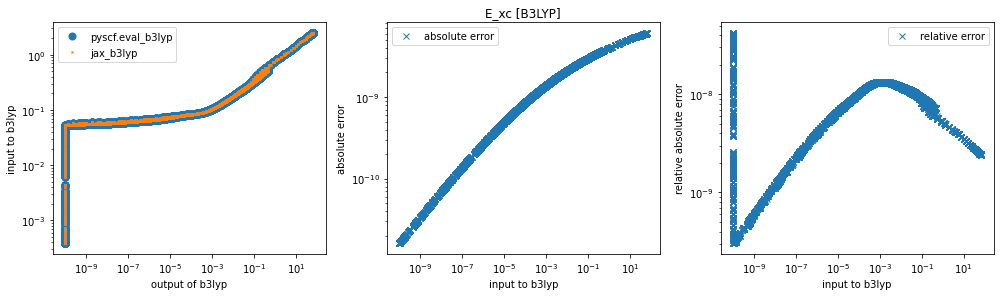

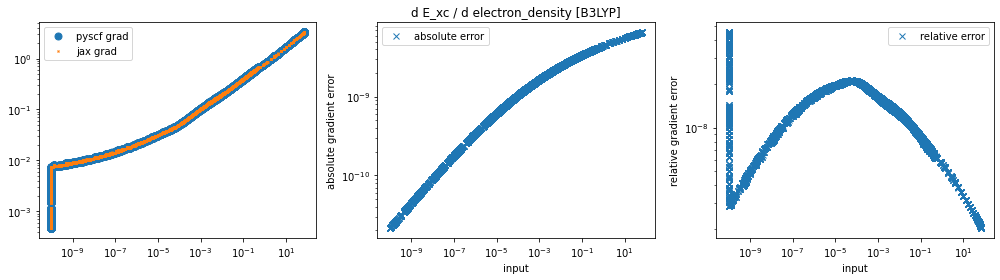

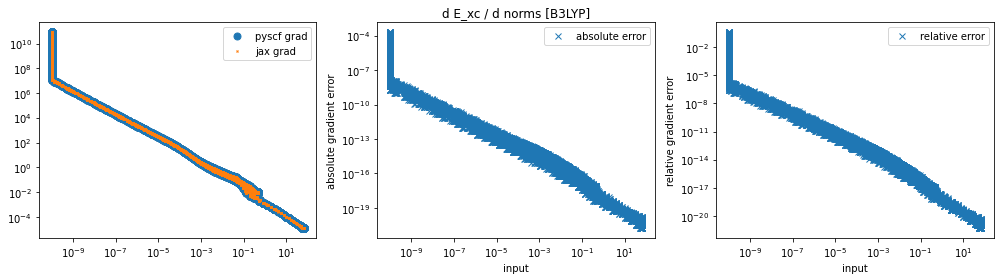

In [ ]:
import matplotlib.pyplot as plt 
from jax.config import config
config.update('jax_enable_x64', True)

import numpy as np

def plot(rho, b, a, g, grad, vnorm=None, name=""): # b is pyscf a is us 

  fig, ax = plt.subplots(1, 3, figsize=(14, 4))
  ax[0].plot(rho[0], -b, 'o', label="pyscf.eval_b3lyp",  ms=7)
  ax[0].plot(rho[0], -a, 'x', label="jax_b3lyp", ms=2)

  ax[1].plot(rho[0], np.abs(a-b), 'x', label="absolute error")
  ax[1].set_yscale("log") 
  ax[1].set_xscale("log") 
  ax[1].set_xlabel("input to b3lyp") 
  ax[1].set_ylabel("absolute error") 
  ax[1].legend()

  ax[2].plot(rho[0], np.abs(a-b)/np.abs(b), 'x', label="relative error")
  ax[2].set_yscale("log") 
  ax[2].set_xscale("log") 
  ax[2].set_xlabel("input to b3lyp") 
  ax[2].set_ylabel("relative absolute error")
  ax[2].legend()

  ax[0].set_yscale("log")
  ax[0].set_xscale("log")
  ax[0].set_ylabel("input to b3lyp")
  ax[0].set_xlabel("output of b3lyp")
  ax[0].legend()

  plt.tight_layout()
  ax[1].set_title("E_xc [%s]" % name)

  fig, ax = plt.subplots(1,3, figsize=(14, 4))

  ax[0].plot(rho[0], -g[0], 'o',                label="pyscf grad", ms=7)
  #ax[0].plot(rho[0], -grad[:, 0]*rho[0]*4, 'x', label="jax grad",   ms=2) # no idea where the factor 4 comes from... 

  if grad.ndim == 2: grad = grad[:, 0]

  ax[0].plot(rho[0], -grad, 'x', label="jax grad",   ms=2) # no idea where the factor 4 comes from... 
  ax[0].legend()

  #ax[1].plot(rho[0], np.abs(g[0]-grad[:, 0]*rho[0]*4), 'x', label="absolute error") # lda fix 
  ax[1].plot(rho[0], np.abs(g[0]-grad), 'x', label="absolute error")
  ax[1].legend()
  ax[1].set_xlabel("input")
  ax[1].set_ylabel("absolute gradient error")
  ax[1].set_title("d E_xc / d electron_density [%s]" % name)

  #ax[2].plot(rho[0], np.abs(g[0]-grad[:, 0]*rho[0]*4)/np.abs(g[0]), 'x', label="relative error") # lda fix 
  ax[2].plot(rho[0], np.abs(g[0]-grad)/np.abs(g[0]), 'x', label="relative error")
  ax[2].legend()
  ax[2].set_xlabel("input")
  ax[2].set_ylabel("relative gradient error")


  ax[0].set_yscale("log")
  ax[0].set_xscale("log")

  ax[1].set_yscale("log")
  ax[1].set_xscale("log")

  ax[2].set_yscale("log")
  ax[2].set_xscale("log")
  plt.tight_layout()

  if vnorm is not None: 
    fig, ax = plt.subplots(1,3, figsize=(14, 4))

    ax[0].plot(rho[0], np.abs(g[1]), 'o',                label="pyscf grad", ms=7)
    ax[0].plot(rho[0], np.abs(vnorm), 'x', label="jax grad",   ms=2) 
    ax[0].legend()

    ax[1].plot(rho[0], np.abs(g[1]-vnorm), 'x', label="absolute error")
    ax[1].legend()
    ax[1].set_xlabel("input")
    ax[1].set_ylabel("absolute gradient error")

    ax[1].set_title("d E_xc / d norms [%s]" % name)

    ax[2].plot(rho[0], np.abs(g[1]-vnorm)/np.abs(g[0]), 'x', label="relative error")
    ax[2].legend()
    ax[2].set_xlabel("input")
    ax[2].set_ylabel("relative gradient error")

    ax[0].set_yscale("log")
    ax[0].set_xscale("log")

    ax[1].set_yscale("log")
    ax[1].set_xscale("log")

    ax[2].set_yscale("log")
    ax[2].set_xscale("log")
    plt.tight_layout()

import jax 
import jax.numpy as jnp 

def lda(rho): return -jnp.exp(1/3*jnp.log(rho) - 0.30305460484554375)

def lyp(rho0, norms):
  n = rho0
  gnn = norms
  
  a = 0.5 * n
  b = 0.5 * n
  gaa = 0.25 * gnn
  gab = gaa
  gbb = gaa

  A  = 0.04918
  B  = 0.132
  C  = 0.2533
  Dd = 0.349

  n = a + b
  gnn = gaa + 2.0 * gab + gbb

  CF = 0.3 * (3.0 * jnp.pi * jnp.pi) ** (2.0 / 3.0)
  icbrtn = n ** (-1.0 / 3.0)
  P = 1.0 / (1.0 + Dd * icbrtn)
  omega = jnp.exp(-C * icbrtn) * P * n ** (-11.0 / 3.0)
  delta = icbrtn * (C + Dd * P)
  n2 = n * n
  return -A * (
      4.0 * a * b * P / n
      + B
      * omega
      * (
          a
          * b
          * (
              2.0 ** (11.0 / 3.0) * CF * (a ** (8.0 / 3.0) + b ** (8.0 / 3.0))
              + (47.0 - 7.0 * delta) * gnn / 18.0
              - (2.5 - delta / 18.0) * (gaa + gbb)
              - (delta - 11.0) / 9.0 * (a * gaa + b * gbb) / n
          )
          - 2.0 / 3.0 * n2 * gnn
          + (2.0 / 3.0 * n2 - a * a) * gbb
          + (2.0 / 3.0 * n2 - b * b) * gaa
      )
  )  

def _b88_a_gaa(a, gaa):
    na43 = a ** (4.0 / 3.0)
    chi2 = gaa * a ** (-8.0 / 3.0)
    chi = jnp.sqrt(chi2)
    d = 0.0042
    b88 = -(d * na43 * chi2) / (1.0 + 6.0 * d * chi * jnp.arcsinh(chi))
    slaterx_a =  (-3.0 / 4.0) * (6.0 / jnp.pi) ** (1.0 / 3.0) * a ** (4.0 / 3.0)
    return slaterx_a + b88

def b88_n_gnn(n, gnn):
    a = 0.5 * n
    b = 0.5 * n
    gaa = 0.25 * gnn
    gbb = gaa
    return (_b88_a_gaa(a, gaa) + _b88_a_gaa(b, gbb))#/n

def b88(rho):
  rho0 = rho[0]
  norm = jnp.linalg.norm(rho[1:], axis=0)**2
  return b88_n_gnn(rho0, norm) 


def _vwn_f(s, p):
    return (
        0.5
        * p[1]
        * (
            2.0 * jnp.log(s)
            + (p[0] * p[2] / (p[0] * p[0] + p[0] * p[2] + p[3]) - 1.0) * jnp.log( s * s + p[2] * s + p[3])
            - ( 2.0 * (p[0] * p[2] / (p[0] * p[0] + p[0] * p[2] + p[3]) - 1) + 2.0)* jnp.log(  s - p[0]  )
            + (
                2.0
                * p[2]
                * (
                    1.0 / jnp.sqrt(4.0 * p[3] - p[2] * p[2])
                    - p[0]
                    / (
                        (p[0] * p[0] + p[0] * p[2] + p[3])
                        * jnp.sqrt(4.0 * p[3] - p[2] * p[2])
                        / (p[2] + 2.0 * p[0])
                    )
                )
            ) * jnp.arctan( jnp.sqrt(4.0 * p[3] - p[2] * p[2]) / (2.0 * s + p[2]))
        )
    )

@jax.jit
def vwn5_a_b(a, b):
    para = [-0.10498, 0.0621813817393097900698817274255, 3.72744, 12.9352]
    ferro = [-0.325, 0.0310906908696548950349408637127, 7.06042, 18.0578]
    inter = [-0.0047584, -1.0 / (3.0 * jnp.pi * jnp.pi), 1.13107, 13.0045]

    n = a + b

    r_s = (3.0 / (4.0 * jnp.pi * n)) ** (1.0 / 3.0)
    s = r_s ** 0.5

    zeta = (a - b) / n
    g = 1.92366105093154 * ( ((1.0 + zeta) ** (4/3) + (1.0 - zeta) ** (4/3))   - 2.0) 
    zeta4 = zeta ** 4.0
    dd = g * (
        (_vwn_f(s, ferro) - _vwn_f(s, para)) * zeta4
        + _vwn_f(s, inter) * (1.0 - zeta4) * (9.0 / 4.0 * (2.0 ** (1.0 / 3.0) - 1.0))
    )

    return n * (_vwn_f(s, para) + dd)

def vwn(rho):  return vwn5_a_b(0.5 * rho, 0.5 * rho) 

def b3lyp(rho): 
  rho0  = rho.T[:, 0]
  norms = np.linalg.norm(rho[1:], axis=0).T**2

  e_xc_lda, v_rho_lda               = jax.vmap(jax.value_and_grad(lambda x: lda(x)*0.08))(rho0)
  e_xc_vwn, v_rho_vwn               = jax.vmap(jax.value_and_grad(lambda x: vwn(x)*0.19))(rho0)
  e_xc_b88, (v_rho_b88, v_norm_b88) = jax.vmap(jax.value_and_grad(lambda rho0, norm: b88_n_gnn(rho0, norm)*0.72, (0,1)))(rho0, norms)
  e_xc_lyp, (v_rho_lyp, v_norm_lyp) = jax.vmap(jax.value_and_grad(lambda rho0, norm: lyp(rho0, norm)*0.810, (0,1)))(rho0, norms)

  e_xc = e_xc_lda + (e_xc_vwn + e_xc_b88 + e_xc_lyp) / rho[0]

  v_xc_rho = v_rho_lda*4*rho[0] + v_rho_vwn + v_rho_b88 + v_rho_lyp 
  v_xc_norms = v_norm_b88 + v_norm_lyp 

  return e_xc, v_xc_rho, v_xc_norms


rho = np.load("rho.npz")["rho"] 

rho[0] = jax.lax.clamp(1e-10, rho[0], 1e14)

e_xc, v_xc_rho, v_xc_norms = b3lyp(rho)

_hyb, fn_facs = pyscf.dft.libxc.parse_xc("b3lyp") # .2 * HF + .08 * LDA + .72 * B88, .810 * LYP + .19 * VW
e_xc_pyscf, v_xc_pyscf  = pyscf.dft.libxc._eval_xc(_hyb, fn_facs, rho, spin=0, relativity=0, deriv=1, verbose=False)[:2]


plot(rho, e_xc_pyscf, e_xc, v_xc_pyscf, v_xc_rho , vnorm=v_xc_norms, name="B3LYP")

print(np.allclose(e_xc_pyscf, e_xc))
print(np.allclose(v_xc_pyscf[0], v_xc_rho))
print(np.allclose(v_xc_pyscf[1], v_xc_norms))

# Step 20: refactor to jax

In [ ]:
import matplotlib.pyplot as plt 
from jax.config import config
config.update('jax_enable_x64', True)
import jax 
import jax.numpy as jnp 
import pyscf 
import pyscf.dft
import math 
from tqdm import tqdm
import numpy 
import jax.numpy as jnp 
import ctypes
import _ctypes

def lda(rho): return -jnp.exp(1/3*jnp.log(rho) - 0.30305460484554375)

def lyp(rho0, norms):
  n = rho0
  gnn = norms
  
  a = 0.5 * n
  b = 0.5 * n
  gaa = 0.25 * gnn
  gab = gaa
  gbb = gaa

  A  = 0.04918
  B  = 0.132
  C  = 0.2533
  Dd = 0.349

  n = a + b
  gnn = gaa + 2.0 * gab + gbb

  CF = 0.3 * (3.0 * jnp.pi * jnp.pi) ** (2.0 / 3.0)
  icbrtn = n ** (-1.0 / 3.0)
  P = 1.0 / (1.0 + Dd * icbrtn)
  omega = jnp.exp(-C * icbrtn) * P * n ** (-11.0 / 3.0)
  delta = icbrtn * (C + Dd * P)
  n2 = n * n
  return -A * (
      4.0 * a * b * P / n
      + B
      * omega
      * (
          a
          * b
          * (
              2.0 ** (11.0 / 3.0) * CF * (a ** (8.0 / 3.0) + b ** (8.0 / 3.0))
              + (47.0 - 7.0 * delta) * gnn / 18.0
              - (2.5 - delta / 18.0) * (gaa + gbb)
              - (delta - 11.0) / 9.0 * (a * gaa + b * gbb) / n
          )
          - 2.0 / 3.0 * n2 * gnn
          + (2.0 / 3.0 * n2 - a * a) * gbb
          + (2.0 / 3.0 * n2 - b * b) * gaa
      )
  )  

def _b88_a_gaa(a, gaa):
    na43 = a ** (4.0 / 3.0)
    chi2 = gaa * a ** (-8.0 / 3.0)
    chi = jnp.sqrt(chi2)
    d = 0.0042
    b88 = -(d * na43 * chi2) / (1.0 + 6.0 * d * chi * jnp.arcsinh(chi))
    slaterx_a =  (-3.0 / 4.0) * (6.0 / jnp.pi) ** (1.0 / 3.0) * a ** (4.0 / 3.0)
    return slaterx_a + b88

def b88_n_gnn(n, gnn):
    a = 0.5 * n
    b = 0.5 * n
    gaa = 0.25 * gnn
    gbb = gaa
    return (_b88_a_gaa(a, gaa) + _b88_a_gaa(b, gbb))#/n

def b88(rho):
  rho0 = rho[0]
  norm = jnp.linalg.norm(rho[1:], axis=0)**2
  return b88_n_gnn(rho0, norm) 


def _vwn_f(s, p):
    return (
        0.5
        * p[1]
        * (
            2.0 * jnp.log(s)
            + (p[0] * p[2] / (p[0] * p[0] + p[0] * p[2] + p[3]) - 1.0) * jnp.log( s * s + p[2] * s + p[3])
            - ( 2.0 * (p[0] * p[2] / (p[0] * p[0] + p[0] * p[2] + p[3]) - 1) + 2.0)* jnp.log(  s - p[0]  )
            + (
                2.0
                * p[2]
                * (
                    1.0 / jnp.sqrt(4.0 * p[3] - p[2] * p[2])
                    - p[0]
                    / (
                        (p[0] * p[0] + p[0] * p[2] + p[3])
                        * jnp.sqrt(4.0 * p[3] - p[2] * p[2])
                        / (p[2] + 2.0 * p[0])
                    )
                )
            ) * jnp.arctan( jnp.sqrt(4.0 * p[3] - p[2] * p[2]) / (2.0 * s + p[2]))
        )
    )

@jax.jit
def vwn5_a_b(a, b):
    para = [-0.10498, 0.0621813817393097900698817274255, 3.72744, 12.9352]
    ferro = [-0.325, 0.0310906908696548950349408637127, 7.06042, 18.0578]
    inter = [-0.0047584, -1.0 / (3.0 * jnp.pi * jnp.pi), 1.13107, 13.0045]

    n = a + b

    r_s = (3.0 / (4.0 * jnp.pi * n)) ** (1.0 / 3.0)
    s = r_s ** 0.5

    zeta = (a - b) / n
    g = 1.92366105093154 * ( ((1.0 + zeta) ** (4/3) + (1.0 - zeta) ** (4/3))   - 2.0) 
    zeta4 = zeta ** 4.0
    dd = g * (
        (_vwn_f(s, ferro) - _vwn_f(s, para)) * zeta4
        + _vwn_f(s, inter) * (1.0 - zeta4) * (9.0 / 4.0 * (2.0 ** (1.0 / 3.0) - 1.0))
    )

    return n * (_vwn_f(s, para) + dd)

def vwn(rho):  return vwn5_a_b(0.5 * rho, 0.5 * rho) 

def b3lyp(rho): 
  rho0  = rho.T[:, 0]
  norms = jnp.linalg.norm(rho[1:], axis=0).T**2+1e-20 # to circumvent zero division! 

  e_xc_lda, v_rho_lda               = jax.vmap(jax.value_and_grad(lambda x: lda(x)*0.08))(rho0)
  e_xc_vwn, v_rho_vwn               = jax.vmap(jax.value_and_grad(lambda x: vwn(x)*0.19))(rho0)
  e_xc_b88, (v_rho_b88, v_norm_b88) = jax.vmap(jax.value_and_grad(lambda rho0, norm: b88_n_gnn(rho0, norm)*0.72, (0,1)))(rho0, norms)
  e_xc_lyp, (v_rho_lyp, v_norm_lyp) = jax.vmap(jax.value_and_grad(lambda rho0, norm: lyp(rho0, norm)*0.810, (0,1)))(rho0, norms)

  e_xc = e_xc_lda + (e_xc_vwn + e_xc_b88 + e_xc_lyp) / rho[0]

  v_xc_rho = v_rho_lda*4*rho[0] + v_rho_vwn + v_rho_b88 + v_rho_lyp 
  v_xc_norms = v_norm_b88 + v_norm_lyp 

  return e_xc, v_xc_rho, v_xc_norms

b3lyp = jax.jit(b3lyp)


class RKS(): 

    def __init__(self, mol, xc='LDA,VWN'):
        self.mol        = mol
        self.verbose    = mol.verbose

        self.max_memory     = mol.max_memory
        self._eri           = None 
        self.direct_scf     = True 
        self.direct_scf_tol = 1e-13

        self.opt = None
        
        self.xc = xc
        
        self.nlc = ''
        self.grids            = pyscf.dft.gen_grid.Grids(self.mol)
        self.grids.level      = getattr(pyscf.__config__, 'dft_rks_RKS_grids_level', self.grids.level)
        self.nlcgrids         = pyscf.dft.gen_grid.Grids(self.mol)
        self.nlcgrids.level   = getattr(pyscf.__config__, 'dft_rks_RKS_nlcgrids_level', self.nlcgrids.level)
        self.small_rho_cutoff = getattr(pyscf.__config__, 'dft_rks_RKS_small_rho_cutoff', 1e-7)
        self._numint          = pyscf.dft.numint.NumInt() # only used for initialization, not inside main loop! 
        self.max_cycle        = 50

        #self.density_functional_theory = jax.jit(self.density_functional_theory, static_argnums=(4,12,23,24))


    def get_jk(self, mol=None, dm=None, hermi=1, with_j=True, with_k=True,  omega=None):
        if mol is None: mol = self.mol
        if dm is None: dm = self.make_rdm1()
        if self.direct_scf and self.opt is None:
            self.opt = self.init_direct_scf(mol)

        if with_j and with_k:
            vj, vk = pyscf.scf.hf.get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)
        else:
            if with_j:
                prescreen = 'CVHFnrs8_vj_prescreen'
            else:
                prescreen = 'CVHFnrs8_vk_prescreen'
            with pyscf.lib.temporary_env(self.opt, prescreen=prescreen):
                vj, vk = get_jk(mol, dm, hermi, self.opt, with_j, with_k, omega)

        return vj, vk


    def init_direct_scf(self, mol=None):
        # Integrals < direct_scf_tol may be set to 0 in int2e.
        # Higher accuracy is required for Schwartz inequality prescreening.
        with mol.with_integral_screen(self.direct_scf_tol**2):
            opt = pyscf.scf._vhf.VHFOpt(mol, 'int2e', 'CVHFnrs8_prescreen',
                              'CVHFsetnr_direct_scf',
                              'CVHFsetnr_direct_scf_dm')
            opt.direct_scf_tol = self.direct_scf_tol
        return opt

    def initialize_grids(self, mol=None, dm=None): pass # only needs to be called once, believe it's called in mol.build. (get_veff calls this, step 16 commented ks.initialize_grids out)

    def kernel(self, convergence_tolerance=1e-10): 
      mol       = self.mol
      e_tot     = -1  
      converged = False

      # Initialize stuff on CPU using PySCF. 
      # For current proof of concept, we only want to jax jit the main loop. 
      dm    = pyscf.scf.hf.init_guess_by_minao(mol)         
      V_xc  = pyscf.dft.rks.get_veff(self, mol, dm)                               # Computes XC and Coulomb. 
      h1e   = mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc') # Fixed part of hamiltonian. 
      
      s1e   = mol.intor_symmetric('int1e_ovlp')                                   # "Overlap matrix", added to generalized eigensolver. 
      L     = np.linalg.cholesky(s1e)                                             # Used by mean to turn generalized eigenproblem into a normal eigenproblem. 
      L_inv = np.linalg.inv(L)                                                    # Same as above. 

      nuclear_energy  = mol.energy_nuc()
      n_electrons     = mol.nelectron

      mf_diis_space                   = 8                                         # Try increasing this to e.g. 64. Will probably converge faster and make each iteration only a little slower. 


      e_idx                           = np.arange(V_xc.shape[0])
      mo_occ                          = numpy.zeros(V_xc.shape[0])
      mo_occ[e_idx[:n_electrons//2]]  = 2 
      mo_occ_nnz                      = mo_occ[mo_occ>0] 
      n_electrons_half = n_electrons//2

      V_xc_d = V_xc.shape[0]

      #pbar = tqdm(range(self.max_cycle))
      pbar = None 

      if pbar is None: pbar = range(self.max_cycle)

      mf_diis_H = np.zeros((mf_diis_space+1,mf_diis_space+1), np.float64)
      mf_diis_H[0,1:] = mf_diis_H[1:,0] = 1
      mf_diis_head   = 0

      d, hamil_d = np.prod(h1e.shape), np.prod(h1e.shape)
      _V = np.zeros((mf_diis_space, d))
      _H = np.zeros((mf_diis_space, d))

      # Fixed values used in last part of main iteration. 
      # Depends only on xc type. For b3lyp the values are B3LYP has 0, 0, 0.2 
      omega, alpha, beta          = pyscf.dft.libxc.rsh_coeff(self.xc) 
      if abs(omega) > 1e-10:  hyb = alpha + beta 
      else:                   hyb = pyscf.dft.libxc.hybrid_coeff(self.xc, mol.spin) 

      last_vj    = V_xc.vj
      last_vk    = V_xc.vk

      # Is molecule in cartesian or spherical coordinates. 
      feval = 'GTOval_cart_deriv1' if self.mol.cart else 'GTOval_sph_deriv1' 
      ao    = self.mol.eval_gto( feval, self.grids.coords, (1+1)*(1+2)*(1+3)//6 ) # <-- molecule dependent stuff! this doesn't change, so we can just compute it once. NOtably, we don't have to jax it!!!!!!!!!

      # More fixed valeus used in last part of main iteration. 
      # Again, depends only on xc type. 
      _hyb, fn_facs = pyscf.dft.libxc.parse_xc(self.xc)


      # Save values here to emphasize they don't change each iteration. 
      mol_atm = mol._atm 
      mol_bas = mol._bas
      mol_env = mol._env 
      mol_cart = mol.cart 

      nao  = mol.nao_nr()
      eri0 = mol.intor('int2e_sph').reshape((nao,)*4)

      self.mo_occ = mo_occ

      self.converged, self.e_tot,  self.mo_energy, self.mo_coeff=   \
          self.density_functional_theory(dm, e_tot, V_xc, h1e, self.max_cycle//5, mol_atm, mol_bas, mol_env, mol_cart, _V, _H, s1e, 
                                         d, hamil_d, mf_diis_H, L_inv, ao, eri0, hyb, last_vj, last_vk, nuclear_energy, convergence_tolerance, V_xc_d, n_electrons_half)
      return self.e_tot 

    def density_functional_theory(self, dm, e_tot, V_xc, h1e, max_cycle, mol_atm, mol_bas, mol_env, mol_car, _V, _H, s1e, 
                                  d, hamil_d, mf_diis_H, L_inv, ao, eri0, hyb, last_vj, last_vk, nuclear_energy, convergence_tolerance, V_xc_d, n_electrons_half): 


      def iteration(V):
          dm, e_tot, V_xc, last_vj, last_vk, eigvals, eigvects, _V, _H, mf_diis_H = V #dm, V_xc, last_vj, last_vk, _V, _H, mf_diis_H, cycle = V
          dm_last           = dm        
          #last_hf_e         = e_tot
          V_xc_last         = V_xc 

          hamiltonian       = h1e + V_xc
          sdf               = s1e @ dm @ hamiltonian
          errvec            = sdf.T - sdf

          # ============ STRAT DIIS =============== #
          # Initially 500 lines of code split over 5 files. 
          mf_diis_head      = cycle % _V.shape[0]
          nd                = min(cycle, _V.shape[0])

          _V = jax.lax.dynamic_update_slice(_V, errvec.reshape(1, -1),      (mf_diis_head, 0))
          _H = jax.lax.dynamic_update_slice(_H, hamiltonian.reshape(1, -1), (mf_diis_head, 0))

          tmps = _V[:nd].reshape(-1, 1, d) @ errvec.reshape(1, d, 1) 
          tmps = jax.lax.dynamic_slice(tmps.reshape(-1), (0,), (nd,))

          mf_diis_H = jax.lax.dynamic_update_slice( mf_diis_H, tmps.reshape(1, -1), (mf_diis_head+1, 1) )
          mf_diis_H = jax.lax.dynamic_update_slice( mf_diis_H, tmps.reshape(-1, 1), (1, mf_diis_head+1) )

          # Compute H^-1@[1, 0, ..., 0] using eigh. 
          # this is only 8x8 matrix, but we are essentially just solving for first col of inverse. 
          # this can probably be done directly. especially if we keep in mind mf_diis_H is updated only one row/col every iteration
          c            = jnp.linalg.pinv(mf_diis_H[:nd+1, :nd+1]) @ jnp.concatenate((jnp.ones(1), jnp.zeros(nd)))  
          hamiltonian  = jnp.sum( _H[:nd] * c[1:].reshape(nd, 1), axis=0).reshape(hamiltonian.shape)
          # ============ END DIIS =============== #

          # Solve generalized eigenproblem using normal eigh solver using this trick: https://www.jstor.org/stable/2949370
          eigvals, eigvects = jnp.linalg.eigh(L_inv @ hamiltonian @ L_inv.T)  
          eigvects          = L_inv.T @ eigvects 

          # Reconstruct density matrix using eigenvectors. 
          #dm                = (eigvects[:, mo_occ>0] * mo_occ_nnz) @ eigvects[:, mo_occ>0].T 
          dm                = (eigvects[:, :n_electrons_half] * 2) @ eigvects[:, :n_electrons_half].T 

          # ================= numerical_integration ==================== #
          # Compute update to V_xc.  --> nr_rks_only_GGA <--
          # Used to be ~ 500 lines of code. 
          c0        = ao[0] @ dm
          rho       = jnp.sum( c0.reshape((1,) + c0.shape) * ao, axis=2)
          #rho = np.array(rho)
          #rho[1:4] *= 2  
          rho       = jnp.concatenate([jnp.clip(rho[:1], 1e-14, 1e12), rho[1:4]*2])  #rho[1:4] *= 2  #  # clip electron density values; TODO: our b3lyp can handle to 1e-20, PySCF stops at 1e-14. 
          
          #rho[0] = np.clip(rho[0], 1e-14, 1e12) 

          exc, vrho, vgamma = b3lyp(rho)
          
          den          = rho[0] * self.grids.weights                            
          excsum       = den @ exc 

          wv           = jnp.concatenate([vrho.reshape(1, -1)*.5, 2*vgamma*rho[1:4]], axis=0) * self.grids.weights 

          aow          = jnp.einsum('npi,np->pi', ao[:4], wv)
          
          vmat         = ao[0].T @ aow
          vmat         = vmat + vmat.T

          E_xc, V_xc   = excsum, vmat
          # =================== end numerical integration ================== #
          vj = jnp.einsum('ijkl,ji->kl', eri0, dm-dm_last)
          vk = jnp.einsum('ijkl,jk->il', eri0, dm-dm_last)
          
          vk      *= hyb
          vj      += last_vj 
          vk      += last_vk 

          V_xc    += vj - vk * .5

          last_vj  = vj
          last_vk  = vk

          # Below computes energy. 
          E_xc      = E_xc - jnp.sum(dm * vk.T) * .5 * .5
          E_coulomb = jnp.sum(dm * vj.T) * .5

          # Compute energy. Currently only used to check for convergence. 
          e_tot     =  jnp.sum(h1e * dm.T) + E_coulomb + E_xc + nuclear_energy

          #if abs(e_tot - last_hf_e) < convergence_tolerance:
          #    converged = True
          #    break
          return  dm, e_tot, V_xc, last_vj, last_vk, eigvals, eigvects, _V, _H, mf_diis_H


      eigvals = jnp.zeros(h1e.shape[0])
      eigvects = jnp.zeros(h1e.shape)

      #if no_jax0
      # the first 8 iterations are special in that the shape changes! 
      # this makes the jax.jit code not

      for cycle in range(max_cycle): 
         V =   dm, e_tot, V_xc, last_vj, last_vk, eigvals, eigvects, _V, _H, mf_diis_H
         dm, e_tot, V_xc, last_vj, last_vk, eigvals, eigvects, _V, _H, mf_diis_H = iteration(V)

      #V =   dm, e_tot, V_xc, last_vj, last_vk, eigvals, eigvects, _V, _H, mf_diis_H
      #dm, e_tot, V_xc, last_vj, last_vk, eigvals, eigvects, _V, _H, mf_diis_H = jax.lax.fori_loop(0, 10, iteration, V) 


      converged = True
      return converged, e_tot, eigvals, eigvects

def jax_scf(str):
  basis_set = "6-31G*"
  xc_fun    = "b3lyp" 

  # So PCQ uses eV and PySCF uses Hartree 
  eV_to_hartree    = 0.0367493
  hartree_to_eV    = 27.2114
  angstrom_to_bohr = 1.88973

  t0 = time.time()
  mol = pyscf.gto.mole.Mole()

  mol.build(atom=str, unit="Bohr", basis=basis_set)

  mol.verbose = 0 
  mf = RKS(mol) 
  mf.xc = xc_fun 

  for _ in range(3):
    t0 = time.time()
    energy = mf.kernel()
    t = time.time()-t0
    print(t)

  lumo            = np.argmin(mf.mo_occ)
  homo            = lumo - 1
  hl_gap_hartree  = np.abs(mf.mo_energy[homo] - mf.mo_energy[lumo])
  hlgap           = hartree_to_eV*hl_gap_hartree
  return energy, hlgap, t


print(jax.devices())
test_cases(our_fun=jax_scf, list=[1], verbose=True) 
#test_cases(our_fun=jax_scf, list=[70], verbose=True) 
#test_cases(our_fun=jax_scf, list=[51], verbose=True) 
#test_cases(our_fun=jax_scf, verbose=True) 

# -102.629 2.629 |  -102.629 2.629 

# jax use gpu


In [ ]:


test_cases(our_fun=jax_scf, verbose=True) 

|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
HeHe5.2724385261535645
0.551579475402832
0.5418965816497803
|            HeHe |   -5.800 47.014 |   -5.794 41.272 |     0.006 5.743 |       47.014227 |          2.112952s |          0.541897s |
ENERGY NOT ALL CLOSE:  -5.799798410811628 -5.793660948864345
HLGAP NOT ALL CLOSE:  47.0142265391559 41.27167715276252
HeHeHe2.581342935562134
4.687989234924316
0.7442967891693115
|          HeHeHe |   -8.700 46.375 |   -8.700 46.375 |     0.000 0.000 |       46.374526 |          3.170906s |          0.744297s |
CHHHH6.7188825607299805
1.7639834880828857


KeyboardInterrupt: ignored

In [ ]:
 hamiltonian       = h1e + V_xc
          sdf               = s1e @ dm @ hamiltonian
          errvec            = sdf.T - sdf

          mf_diis_head      = cycle % _V.shape[0]
          nd                = min(cycle, _V.shape[0])

          # ============ STRAT DIIS =============== #
          # Initially 500 lines of code split over 5 files. 
          _V = jax.lax.dynamic_update_slice(_V, errvec.reshape(1, -1),      (mf_diis_head, 0))
          _H = jax.lax.dynamic_update_slice(_H, hamiltonian.reshape(1, -1), (mf_diis_head, 0))

          tmps = _V[:nd].reshape(-1, 1, d) @ errvec.reshape(1, d, 1) 
          tmps = jax.lax.dynamic_slice(tmps.reshape(-1), (0,), (nd,))

          mf_diis_H = jax.lax.dynamic_update_slice( mf_diis_H, tmps.reshape(1, -1), (mf_diis_head+1, 1) )
          mf_diis_H = jax.lax.dynamic_update_slice( mf_diis_H, tmps.reshape(-1, 1), (1, mf_diis_head+1) )
          
          # Compute H^-1@[1, 0, ..., 0] using eigh. 
          c     = jnp.linalg.pinv(mf_diis_H[:nd+1, :nd+1]) @ np.concatenate((np.ones(1), np.zeros(nd))) 

          hamiltonian  = jnp.sum( _H[:nd] * c[1:].reshape(nd, 1), axis=0).reshape(hamiltonian.shape)
          # ============ END DIIS =============== #

          # Solve generalized eigenproblem using normal eigh solver using this trick: https://www.jstor.org/stable/2949370
          eigvals, eigvects = jnp.linalg.eigh(L_inv @ hamiltonian @ L_inv.T)  
          eigvects          = L_inv.T @ eigvects 

          # Reconstruct density matrix using eigenvectors. 
          dm                = (eigvects[:, mo_occ>0] * mo_occ_nnz) @ eigvects[:, mo_occ>0].T 

          # ================= numerical_integration ==================== #
          # Compute update to V_xc.  --> nr_rks_only_GGA <--
          # Used to be ~ 500 lines of code. 
          c0        = ao[0] @ dm
          rho       = jnp.sum( c0.reshape((1,) + c0.shape) * ao, axis=2)
          rho       = jnp.concatenate([rho[:1], rho[1:4]*2])  #rho[1:4] *= 2  
          
          if xc ==  ".2 * HF ":# and False:
            exc = jnp.zeros(rho.shape[1])
            vxc = [jnp.zeros(rho.shape[1]), jnp.zeros(rho.shape[1])]
          else: 
            print(rho.shape)
            exc, vxc    = _eval_xc(_hyb, fn_facs, np.array(rho, dtype=np.float64), spin=0, relativity=0, deriv=1, verbose=False)  # <--- jaxify this!
          
          den          = rho[0] * grids.weights                            # Is this the electron density? 
          excsum       = den @ exc 

          vrho, vgamma = vxc[:2]
          #wv[0]       = vrho * .5  
          #wv[1:]      = 2 * vgamma * rho[1:4]
          wv           = jnp.concatenate([vrho.reshape(1, -1)*.5, 2*vgamma*rho[1:4]])
          wv          *= grids.weights 

          aow          = jnp.einsum('npi,np->pi', ao[:4], wv)
          
          vmat         = ao[0].T @ aow
          vmat         = vmat + vmat.T

          E_xc, V_xc   = excsum, vmat
          # =================== end numerical integration ================== #
          vj = jnp.einsum('ijkl,ji->kl', eri0, dm-dm_last)
          vk = jnp.einsum('ijkl,jk->il', eri0, dm-dm_last)
          
          vk      *= hyb
          vj      += last_vj 
          vk      += last_vk 

          V_xc    += vj - vk * .5

          last_vj  = vj
          last_vk  = vk

          # Below computes energy. 
          E_xc      = E_xc - jnp.sum(dm * vk.T) * .5 * .5
          E_coulomb = jnp.sum(dm * vj.T) * .5

          # Compute energy. Currently only used to check for convergence. 
          e_tot     =  jnp.sum(h1e * dm.T) + E_coulomb + E_xc + nuclear_energy

          return dm, e_tot, V_xc, last_vj, last_vk, eigvals, eigvects, _V, _H, mf_diis_H

# Step 21: removing jax.fori_loop, trying to just make it as simple as possible (may be independent of basis sets, the next code may refacotr specifically for gaussians to allow backprop through molecule)

In [ ]:
from jax.config import config
config.update('jax_enable_x64', True)
import jax 
import jax.numpy as jnp 
import pyscf 
import pyscf.dft
import numpy as np 
import jax.numpy as jnp 

def lda(rho): return -jnp.exp(1/3*jnp.log(rho) - 0.30305460484554375)

def lyp(rho0, norms):
  n = rho0
  gnn = norms
  
  a = 0.5 * n
  b = 0.5 * n
  gaa = 0.25 * gnn
  gab = gaa
  gbb = gaa

  A  = 0.04918
  B  = 0.132
  C  = 0.2533
  Dd = 0.349

  n = a + b
  gnn = gaa + 2.0 * gab + gbb

  CF = 0.3 * (3.0 * jnp.pi * jnp.pi) ** (2.0 / 3.0)
  icbrtn = n ** (-1.0 / 3.0)
  P = 1.0 / (1.0 + Dd * icbrtn)
  omega = jnp.exp(-C * icbrtn) * P * n ** (-11.0 / 3.0)
  delta = icbrtn * (C + Dd * P)
  n2 = n * n
  return -A * (
      4.0 * a * b * P / n
      + B
      * omega
      * (
          a
          * b
          * (
              2.0 ** (11.0 / 3.0) * CF * (a ** (8.0 / 3.0) + b ** (8.0 / 3.0))
              + (47.0 - 7.0 * delta) * gnn / 18.0
              - (2.5 - delta / 18.0) * (gaa + gbb)
              - (delta - 11.0) / 9.0 * (a * gaa + b * gbb) / n
          )
          - 2.0 / 3.0 * n2 * gnn
          + (2.0 / 3.0 * n2 - a * a) * gbb
          + (2.0 / 3.0 * n2 - b * b) * gaa
      )
  )  

def _b88_a_gaa(a, gaa):
    na43 = a ** (4.0 / 3.0)
    chi2 = gaa * a ** (-8.0 / 3.0)
    chi = jnp.sqrt(chi2)
    d = 0.0042
    b88 = -(d * na43 * chi2) / (1.0 + 6.0 * d * chi * jnp.arcsinh(chi))
    slaterx_a =  (-3.0 / 4.0) * (6.0 / jnp.pi) ** (1.0 / 3.0) * a ** (4.0 / 3.0)
    return slaterx_a + b88

def b88_n_gnn(n, gnn):
    a = 0.5 * n
    b = 0.5 * n
    gaa = 0.25 * gnn
    gbb = gaa
    return (_b88_a_gaa(a, gaa) + _b88_a_gaa(b, gbb))#/n

def b88(rho):
  rho0 = rho[0]
  norm = jnp.linalg.norm(rho[1:], axis=0)**2
  return b88_n_gnn(rho0, norm) 


def _vwn_f(s, p):
    return (
        0.5
        * p[1]
        * (
            2.0 * jnp.log(s)
            + (p[0] * p[2] / (p[0] * p[0] + p[0] * p[2] + p[3]) - 1.0) * jnp.log( s * s + p[2] * s + p[3])
            - ( 2.0 * (p[0] * p[2] / (p[0] * p[0] + p[0] * p[2] + p[3]) - 1) + 2.0)* jnp.log(  s - p[0]  )
            + (
                2.0
                * p[2]
                * (
                    1.0 / jnp.sqrt(4.0 * p[3] - p[2] * p[2])
                    - p[0]
                    / (
                        (p[0] * p[0] + p[0] * p[2] + p[3])
                        * jnp.sqrt(4.0 * p[3] - p[2] * p[2])
                        / (p[2] + 2.0 * p[0])
                    )
                )
            ) * jnp.arctan( jnp.sqrt(4.0 * p[3] - p[2] * p[2]) / (2.0 * s + p[2]))
        )
    )

#@jax.jit
def vwn5_a_b(a, b):
    para = [-0.10498, 0.0621813817393097900698817274255, 3.72744, 12.9352]
    ferro = [-0.325, 0.0310906908696548950349408637127, 7.06042, 18.0578]
    inter = [-0.0047584, -1.0 / (3.0 * jnp.pi * jnp.pi), 1.13107, 13.0045]

    n = a + b

    r_s = (3.0 / (4.0 * jnp.pi * n)) ** (1.0 / 3.0)
    s = r_s ** 0.5

    zeta = (a - b) / n
    g = 1.92366105093154 * ( ((1.0 + zeta) ** (4/3) + (1.0 - zeta) ** (4/3))   - 2.0) 
    zeta4 = zeta ** 4.0
    dd = g * (
        (_vwn_f(s, ferro) - _vwn_f(s, para)) * zeta4
        + _vwn_f(s, inter) * (1.0 - zeta4) * (9.0 / 4.0 * (2.0 ** (1.0 / 3.0) - 1.0))
    )

    return n * (_vwn_f(s, para) + dd)

def vwn(rho):  return vwn5_a_b(0.5 * rho, 0.5 * rho) 

def b3lyp(rho): 
  rho0  = rho.T[:, 0]
  norms = jnp.linalg.norm(rho[1:], axis=0).T**2+1e-20 # to circumvent zero division! 

  e_xc_lda, v_rho_lda               = jax.vmap(jax.value_and_grad(lambda x: lda(x)*0.08))(rho0)
  e_xc_vwn, v_rho_vwn               = jax.vmap(jax.value_and_grad(lambda x: vwn(x)*0.19))(rho0)
  e_xc_b88, (v_rho_b88, v_norm_b88) = jax.vmap(jax.value_and_grad(lambda rho0, norm: b88_n_gnn(rho0, norm)*0.72, (0,1)))(rho0, norms)
  e_xc_lyp, (v_rho_lyp, v_norm_lyp) = jax.vmap(jax.value_and_grad(lambda rho0, norm: lyp(rho0, norm)*0.810, (0,1)))(rho0, norms)

  e_xc = e_xc_lda + (e_xc_vwn + e_xc_b88 + e_xc_lyp) / rho[0]

  v_xc_rho = v_rho_lda*4*rho[0] + v_rho_vwn + v_rho_b88 + v_rho_lyp 
  v_xc_norms = v_norm_b88 + v_norm_lyp 

  return e_xc, v_xc_rho, v_xc_norms

b3lyp = jax.jit(b3lyp)

#self.small_rho_cutoff = getattr(pyscf.__config__, 'dft_rks_RKS_small_rho_cutoff', 1e-7)

#https://pyscf.org/pyscf_api_docs/pyscf.grad.html#module-pyscf.grad.casci
# todo; refacor mol to numpy to we can autodiff through that wrt positions! 
# OBS: we only need to refactor the things that change wrt different atom positions! 
def density_functional_theory(mol, mf_diis_space=8, max_cycle=50, convergence_tolerance=1e-10): 
  grids            = pyscf.dft.gen_grid.Grids(mol)
  grids.level      = getattr(pyscf.__config__, 'dft_rks_RKS_grids_level', grids.level)
  grids.build()     #

  ao    = mol.eval_gto('GTOval_cart_deriv1' if mol.cart else 'GTOval_sph_deriv1', grids.coords, (1+1)*(1+2)*(1+3)//6 )
  dm    = pyscf.scf.hf.init_guess_by_minao(mol)         
  h1e   = mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc') 
  d     = np.prod(h1e.shape)
  s1e   = mol.intor_symmetric('int1e_ovlp')                                     
  eri0  = mol.intor('int2e_sph').reshape((mol.nao_nr(),)*4)
  L     = np.linalg.cholesky(s1e)                                               
  L_inv = np.linalg.inv(L)                                                      

  nuclear_energy    = mol.energy_nuc()
  n_electrons       = mol.nelectron
  n_electrons_half  = n_electrons//2

  mf_diis_H = np.zeros((mf_diis_space+1,mf_diis_space+1), np.float64)
  mf_diis_H[0,1:] = mf_diis_H[1:,0] = 1

  _V = jnp.zeros((mf_diis_space, d))
  _H = jnp.zeros((mf_diis_space, d))

  hyb = pyscf.dft.libxc.hybrid_coeff("b3lyp", mol.spin) 

  def xc(dm): # previously called nr_rks (numerical integration restricted kohn sham)
    c0        = ao[0] @ dm
    rho       = jnp.sum( c0.reshape((1,) + c0.shape) * ao, axis=2)
    rho       = jnp.concatenate([jnp.clip(rho[:1], 1e-14, 1e12), rho[1:4]*2])  
    
    exc, vrho, vgamma = b3lyp(rho)
    
    den          = rho[0] * grids.weights                            
    E_xc         = den @ exc 
    V_xc         = ao[0].T @ jnp.einsum('npi,np->pi', ao[:4], jnp.concatenate([vrho.reshape(1, -1)*.5, 2*vgamma*rho[1:4]], axis=0) * grids.weights )

    return E_xc, V_xc + V_xc.T

  def DIIS(hamiltonian, _V, _H, mf_diis_H): 
      # Update hamiltonian as linear combination of previous iterations 
      mf_diis_head      = cycle % _V.shape[0]
      nd                = min(cycle, _V.shape[0])

      _V = jax.lax.dynamic_update_slice(_V, errvec.reshape(1, -1),      (mf_diis_head, 0))
      _H = jax.lax.dynamic_update_slice(_H, hamiltonian.reshape(1, -1), (mf_diis_head, 0))

      tmps = _V[:nd].reshape(-1, 1, d) @ errvec.reshape(1, d, 1) 
      tmps = jax.lax.dynamic_slice(tmps.reshape(-1), (0,), (nd,))

      mf_diis_H = jax.lax.dynamic_update_slice( mf_diis_H, tmps.reshape(1, -1), (mf_diis_head+1, 1) )
      mf_diis_H = jax.lax.dynamic_update_slice( mf_diis_H, tmps.reshape(-1, 1), (1, mf_diis_head+1) )

      c            = jnp.linalg.pinv(mf_diis_H[:nd+1, :nd+1]) @ jnp.concatenate((jnp.ones(1), jnp.zeros(nd)))  
      hamiltonian  = jnp.sum( _H[:nd] * c[1:].reshape(nd, 1), axis=0).reshape(hamiltonian.shape)
      return hamiltonian, _V, _H, mf_diis_H

  mo_occ = np.ones(dm.shape[0])*2
  mo_occ[n_electrons_half:] = 0 

  vj, vk, dm_last, last_energy  = 0, 0 ,0, -1

  for cycle in range(max_cycle): 

      # ---- Step 1: Build Hamiltonian  ---- #
      E_xc, V_xc        = xc(dm) 
      vj, vk            = jnp.einsum('ijkl,ji->kl', eri0, dm-dm_last)+vj, jnp.einsum('ijkl,jk->il', eri0, dm-dm_last)*hyb + vk 
      V_xc             += vj - vk * .5
      E_xc             -= jnp.sum(dm * vk.T) * .5 * .5
      E_coulomb         = jnp.sum(dm * vj.T) * .5
      energy            = jnp.sum(h1e * dm.T) + E_coulomb + E_xc + nuclear_energy
      if abs(energy - last_energy) < convergence_tolerance: break 
      last_energy       = energy 
      dm_last           = dm        

      hamiltonian       = h1e + V_xc
      sdf               = s1e @ dm @ hamiltonian
      errvec            = sdf.T - sdf

      hamiltonian, _V, _H, mf_diis_H = DIIS(hamiltonian, _V, _H, mf_diis_H)

      # Step 2: Solve (generalized) eigenproblem for Hamiltonian. 
      eigvals, eigvects = jnp.linalg.eigh(L_inv @ hamiltonian @ L_inv.T)        
      eigvects          = L_inv.T @ eigvects 

      # Step 3: Use result from eigenproblem to build new electon density. 
      dm                = (eigvects[:, :n_electrons_half] * 2) @ eigvects[:, :n_electrons_half].T 

  return -1, energy, eigvals, eigvects , mo_occ


def jax_scf(str): # compare this one to step1? 
  basis_set = "6-31G*"
  xc_fun    = "b3lyp" 

  # So PCQ uses eV and PySCF uses Hartree 
  eV_to_hartree    = 0.0367493
  hartree_to_eV    = 27.2114
  angstrom_to_bohr = 1.88973

  t0 = time.time()
  mol = pyscf.gto.mole.Mole()

  mol.build(atom=str, unit="Bohr", basis=basis_set)

  mol.verbose = 0 

  t0 = time.time()
  converged, e_tot, mo_energy, mo_coeff, mo_occ = density_functional_theory(mol)
  t = time.time()- t0

  lumo            = np.argmin(mo_occ)
  homo            = lumo - 1
  hl_gap_hartree  = np.abs(mo_energy[homo] - mo_energy[lumo])
  hlgap           = hartree_to_eV*hl_gap_hartree
  return e_tot, hlgap, t


print(jax.devices())
#test_cases(our_fun=jax_scf, list=[21], verbose=True) 
#test_cases(our_fun=jax_scf, list=[70], verbose=True) 
#test_cases(our_fun=jax_scf, list=[51], verbose=True) 
test_cases(our_fun=jax_scf, verbose=True) 

# jax use gpu

[GpuDevice(id=0, process_index=0)]
|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
HeHe

things I might get wrong
- challenge this point. Is flops=read/writes really the reason eigendecomposition is slow on GPUs?
- float64; I use cholesky LL.T to turn generalized eig into normal eig; this could kill float32. 

In [ ]:
test_cases(our_fun=jax_scf, verbose=True) 


|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
|            HeHe |   -5.800 47.014 |   -5.800 47.014 |     0.000 0.000 |       47.014227 |          1.934250s |          0.321315s |
|          HeHeHe |   -8.700 46.375 |   -8.700 46.375 |     0.000 0.000 |       46.374526 |          3.092340s |          6.866970s |
|           CHHHH |  -40.482 13.791 |  -40.482 13.791 |     0.000 0.000 |       13.791238 |          9.530842s |          7.113347s |
|            NHHH |   -56.510 9.031 |   -56.510 9.031 |     0.000 0.000 |        9.031433 |          8.889677s |          6.924616s |
|             OHH |   -76.370 9.664 |   -76.370 9.664 |     0.000 0.000 |        9.663530 |          7.202873s |          6.897383s |
|            BeBe |   -29.316 2.950 |   -29.316 2.950 |     0.000 0.000 |        2.950380 |         14.428148s |          7.084217s |
|              FH | -100.380 11.927 | -100.380 11.927 |     0.00

KeyboardInterrupt: ignored

# Step 22: 

In [ ]:
from jax.config import config
config.update('jax_enable_x64', True)
import jax 
import jax.numpy as jnp 
import pyscf 
import pyscf.dft
import numpy as np 
import jax.numpy as jnp 
import numpy 


def lda(rho): return -jnp.exp(1/3*jnp.log(rho) - 0.30305460484554375)

def lyp(rho0, norms):
  n = rho0
  gnn = norms
  
  a = 0.5 * n
  b = 0.5 * n
  gaa = 0.25 * gnn
  gab = gaa
  gbb = gaa

  A  = 0.04918
  B  = 0.132
  C  = 0.2533
  Dd = 0.349

  n = a + b
  gnn = gaa + 2.0 * gab + gbb

  CF = 0.3 * (3.0 * jnp.pi * jnp.pi) ** (2.0 / 3.0)
  icbrtn = n ** (-1.0 / 3.0)
  P = 1.0 / (1.0 + Dd * icbrtn)
  omega = jnp.exp(-C * icbrtn) * P * n ** (-11.0 / 3.0)
  delta = icbrtn * (C + Dd * P)
  n2 = n * n
  return -A * (
      4.0 * a * b * P / n
      + B
      * omega
      * (
          a
          * b
          * (
              2.0 ** (11.0 / 3.0) * CF * (a ** (8.0 / 3.0) + b ** (8.0 / 3.0))
              + (47.0 - 7.0 * delta) * gnn / 18.0
              - (2.5 - delta / 18.0) * (gaa + gbb)
              - (delta - 11.0) / 9.0 * (a * gaa + b * gbb) / n
          )
          - 2.0 / 3.0 * n2 * gnn
          + (2.0 / 3.0 * n2 - a * a) * gbb
          + (2.0 / 3.0 * n2 - b * b) * gaa
      )
  )  

def _b88_a_gaa(a, gaa):
    na43 = a ** (4.0 / 3.0)
    chi2 = gaa * a ** (-8.0 / 3.0)
    chi = jnp.sqrt(chi2)
    d = 0.0042
    b88 = -(d * na43 * chi2) / (1.0 + 6.0 * d * chi * jnp.arcsinh(chi))
    slaterx_a =  (-3.0 / 4.0) * (6.0 / jnp.pi) ** (1.0 / 3.0) * a ** (4.0 / 3.0)
    return slaterx_a + b88

def b88_n_gnn(n, gnn):
    a = 0.5 * n
    b = 0.5 * n
    gaa = 0.25 * gnn
    gbb = gaa
    return (_b88_a_gaa(a, gaa) + _b88_a_gaa(b, gbb))#/n

def b88(rho):
  rho0 = rho[0]
  norm = jnp.linalg.norm(rho[1:], axis=0)**2
  return b88_n_gnn(rho0, norm) 


def _vwn_f(s, p):
    return (
        0.5
        * p[1]
        * (
            2.0 * jnp.log(s)
            + (p[0] * p[2] / (p[0] * p[0] + p[0] * p[2] + p[3]) - 1.0) * jnp.log( s * s + p[2] * s + p[3])
            - ( 2.0 * (p[0] * p[2] / (p[0] * p[0] + p[0] * p[2] + p[3]) - 1) + 2.0)* jnp.log(  s - p[0]  )
            + (
                2.0
                * p[2]
                * (
                    1.0 / jnp.sqrt(4.0 * p[3] - p[2] * p[2])
                    - p[0]
                    / (
                        (p[0] * p[0] + p[0] * p[2] + p[3])
                        * jnp.sqrt(4.0 * p[3] - p[2] * p[2])
                        / (p[2] + 2.0 * p[0])
                    )
                )
            ) * jnp.arctan( jnp.sqrt(4.0 * p[3] - p[2] * p[2]) / (2.0 * s + p[2]))
        )
    )

#@jax.jit
def vwn5_a_b(a, b):
    para = [-0.10498, 0.0621813817393097900698817274255, 3.72744, 12.9352]
    ferro = [-0.325, 0.0310906908696548950349408637127, 7.06042, 18.0578]
    inter = [-0.0047584, -1.0 / (3.0 * jnp.pi * jnp.pi), 1.13107, 13.0045]

    n = a + b

    r_s = (3.0 / (4.0 * jnp.pi * n)) ** (1.0 / 3.0)
    s = r_s ** 0.5

    zeta = (a - b) / n
    g = 1.92366105093154 * ( ((1.0 + zeta) ** (4/3) + (1.0 - zeta) ** (4/3))   - 2.0) 
    zeta4 = zeta ** 4.0
    dd = g * (
        (_vwn_f(s, ferro) - _vwn_f(s, para)) * zeta4
        + _vwn_f(s, inter) * (1.0 - zeta4) * (9.0 / 4.0 * (2.0 ** (1.0 / 3.0) - 1.0))
    )

    return n * (_vwn_f(s, para) + dd)

def vwn(rho):  return vwn5_a_b(0.5 * rho, 0.5 * rho) 

def b3lyp(rho): 
  rho0  = rho.T[:, 0]
  norms = jnp.linalg.norm(rho[1:], axis=0).T**2+1e-20 # to circumvent zero division! 

  e_xc_lda, v_rho_lda               = jax.vmap(jax.value_and_grad(lambda x: lda(x)*0.08))(rho0)
  e_xc_vwn, v_rho_vwn               = jax.vmap(jax.value_and_grad(lambda x: vwn(x)*0.19))(rho0)
  e_xc_b88, (v_rho_b88, v_norm_b88) = jax.vmap(jax.value_and_grad(lambda rho0, norm: b88_n_gnn(rho0, norm)*0.72, (0,1)))(rho0, norms)
  e_xc_lyp, (v_rho_lyp, v_norm_lyp) = jax.vmap(jax.value_and_grad(lambda rho0, norm: lyp(rho0, norm)*0.810, (0,1)))(rho0, norms)

  e_xc = e_xc_lda + (e_xc_vwn + e_xc_b88 + e_xc_lyp) / rho[0]

  v_xc_rho = v_rho_lda*4*rho[0] + v_rho_vwn + v_rho_b88 + v_rho_lyp 
  v_xc_norms = v_norm_b88 + v_norm_lyp 

  return e_xc, v_xc_rho, v_xc_norms

b3lyp = jax.jit(b3lyp)

#self.small_rho_cutoff = getattr(pyscf.__config__, 'dft_rks_RKS_small_rho_cutoff', 1e-7)

def init_guess_by_minao(mol):
    from pyscf.scf import atom_hf
    from pyscf.scf import addons

    def minao_basis(symb, nelec_ecp):
        occ = []
        basis_ano = []
        if gto.is_ghost_atom(symb):
            return occ, basis_ano

        stdsymb = gto.mole._std_symbol(symb)
        basis_add = gto.basis.load('ano', stdsymb)
# coreshl defines the core shells to be removed in the initial guess
        coreshl = gto.ecp.core_configuration(nelec_ecp)
        #coreshl = (0,0,0,0)  # it keeps all core electrons in the initial guess
        for l in range(4):
            ndocc, frac = atom_hf.frac_occ(stdsymb, l)
            assert ndocc >= coreshl[l]
            degen = l * 2 + 1
            occ_l = [2,]*(ndocc-coreshl[l]) + [frac,]
            occ.append(numpy.repeat(occ_l, degen))
            basis_ano.append([l] + [b[:1] + b[1+coreshl[l]:ndocc+2]
                                    for b in basis_add[l][1:]])
        occ = numpy.hstack(occ)

        if nelec_ecp > 0:
            if symb in mol._basis:
                input_basis = mol._basis[symb]
            elif stdsymb in mol._basis:
                input_basis = mol._basis[stdsymb]
            else:
                raise KeyError(symb)

            basis4ecp = [[] for i in range(4)]
            for bas in input_basis:
                l = bas[0]
                if l < 4:
                    basis4ecp[l].append(bas)

            occ4ecp = []
            for l in range(4):
                nbas_l = sum((len(bas[1]) - 1) for bas in basis4ecp[l])
                ndocc, frac = atom_hf.frac_occ(stdsymb, l)
                ndocc -= coreshl[l]
                assert ndocc <= nbas_l

                occ_l = numpy.zeros(nbas_l)
                occ_l[:ndocc] = 2
                if frac > 0:
                    occ_l[ndocc] = frac
                occ4ecp.append(numpy.repeat(occ_l, l * 2 + 1))

            occ4ecp = numpy.hstack(occ4ecp)
            basis4ecp = lib.flatten(basis4ecp)

            atm1 = gto.Mole()
            atm2 = gto.Mole()
            atom = [[symb, (0.,0.,0.)]]
            atm1._atm, atm1._bas, atm1._env = atm1.make_env(atom, {symb:basis4ecp}, [])
            atm2._atm, atm2._bas, atm2._env = atm2.make_env(atom, {symb:basis_ano}, [])
            atm1._built = True
            atm2._built = True
            s12 = gto.intor_cross('int1e_ovlp', atm1, atm2)
            if abs(numpy.linalg.det(s12[occ4ecp>0][:,occ>0])) > .1:
                occ, basis_ano = occ4ecp, basis4ecp
            else:
                logger.debug(mol, 'Density of valence part of ANO basis '
                             'will be used as initial guess for %s', symb)
        return occ, basis_ano

    # Issue 548
    if any(gto.charge(mol.atom_symbol(ia)) > 96 for ia in range(mol.natm)):
        logger.info(mol, 'MINAO initial guess is not available for super-heavy '
                    'elements. "atom" initial guess is used.')
        return init_guess_by_atom(mol)

    nelec_ecp_dic = dict([(mol.atom_symbol(ia), mol.atom_nelec_core(ia))
                          for ia in range(mol.natm)])

    basis = {}
    occdic = {}
    for symb, nelec_ecp in nelec_ecp_dic.items():
        #print(symb, nelec_ecp) # is this every different atom? 
        occ_add, basis_add = minao_basis(symb, nelec_ecp)
        occdic[symb] = occ_add
        basis[symb] = basis_add

    #print("---")

    occ = []
    new_atom = []
    for ia in range(mol.natm):
        #print(ia)
        symb = mol.atom_symbol(ia)
        if not gto.is_ghost_atom(symb):
            occ.append(occdic[symb])
            new_atom.append(mol._atom[ia])
    occ = numpy.hstack(occ)

    #print("---")

    pmol = gto.Mole()
    pmol._atm, pmol._bas, pmol._env = pmol.make_env(new_atom, basis, [])
    pmol._built = True
    dm = addons.project_dm_nr2nr(pmol, numpy.diag(occ), mol)
    return dm

#https://pyscf.org/pyscf_api_docs/pyscf.grad.html#module-pyscf.grad.casci
# todo; refacor mol to numpy to we can autodiff through that wrt positions! 
# OBS: we only need to refactor the things that change wrt different atom positions! 
# nuclear gradient; 
# extend test cases for gradient aswell! 
'''
>>> from pyscf import gto, scf, mcscf
>>> mol = gto.M(atom='N 0 0 0; N 0 0 1.1', verbose=0)
>>> mc_grad_scanner = mcscf.CASCI(scf.RHF(mol), 4, 4).nuc_grad_method().as_scanner()
>>> etot, grad = mc_grad_scanner(gto.M(atom='N 0 0 0; N 0 0 1.1'))
>>> etot, grad = mc_grad_scanner(gto.M(atom='N 0 0 0; N 0 0 1.5'))
'''
def density_functional_theory(mol, mf_diis_space=8, max_cycle=50, convergence_tolerance=1e-10): 
  ts = time.time()
  grids            = pyscf.dft.gen_grid.Grids(mol) # doesn't look like it dpeends on mol._atom position
  grids.level      = getattr(pyscf.__config__, 'dft_rks_RKS_grids_level', grids.level)
  grids.build()     #

  ao    = mol.eval_gto('GTOval_cart_deriv1' if mol.cart else 'GTOval_sph_deriv1',  # (4, d, 4)   He2 ahs d=16304
                          grids.coords, (1+1)*(1+2)*(1+3)//6 )      
  dm    = jnp.array(init_guess_by_minao(mol))                                              # (4, 4) 
  h1e   = jnp.array(mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc'))   # (4, 4)
  d     = np.prod(h1e.shape)                                                    # 16
  s1e   = jnp.array(mol.intor_symmetric('int1e_ovlp'))                                     # (4, 4)

  # this one takes a lot of time, 20 seconds to init! I wonder what that is!
  eri0  = jnp.array(mol.intor('int2e_sph').reshape((mol.nao_nr(),)*4))           # (4, 4, 4, 4) # takes 20% of time! (20s out of 100s for glucose)
  #print(eri0.shape)

  #print("start cholesky/inverse", time.time()-ts) # (192, 192, 192, 192)

  L     = jnp.linalg.cholesky(s1e)                                               # this is super small, 192x192 for glucose
  L_inv = jnp.linalg.inv(L)                                                      
  #print("init done ", time.time()-ts)


  nuclear_energy    = mol.energy_nuc()
  n_electrons       = mol.nelectron
  n_electrons_half  = n_electrons//2

  mf_diis_H = np.zeros((mf_diis_space+1,mf_diis_space+1), np.float64)
  mf_diis_H[0,1:] = mf_diis_H[1:,0] = 1
  mf_diis_H = jnp.array(mf_diis_H)

  _V = jnp.zeros((mf_diis_space, d))
  _H = jnp.zeros((mf_diis_space, d))

  hyb = pyscf.dft.libxc.hybrid_coeff("b3lyp", mol.spin) 

  def xc(dm): # previously called nr_rks (numerical integration restricted kohn sham)
    c0        = ao[0] @ dm
    rho       = jnp.sum( c0.reshape((1,) + c0.shape) * ao, axis=2)
    rho       = jnp.concatenate([jnp.clip(rho[:1], 1e-14, 1e12), rho[1:4]*2])  
    
    exc, vrho, vgamma = b3lyp(rho) # most time goes into b3lyp! 
    
    den          = rho[0] * grids.weights                            
    E_xc         = den @ exc 
    V_xc         = ao[0].T @ jnp.einsum('npi,np->pi', ao[:4], jnp.concatenate([vrho.reshape(1, -1)*.5, 2*vgamma*rho[1:4]], axis=0) * grids.weights )

    return E_xc, V_xc + V_xc.T

  
  def DIIS(hamiltonian, _V, _H, mf_diis_H): 
      # Update hamiltonian as linear combination of previous iterations 
      mf_diis_head      = cycle % _V.shape[0]
      nd                = min(cycle, _V.shape[0])

      _V = jax.lax.dynamic_update_slice(_V, errvec.reshape(1, -1),      (mf_diis_head, 0))
      _H = jax.lax.dynamic_update_slice(_H, hamiltonian.reshape(1, -1), (mf_diis_head, 0))

      tmps = _V[:nd].reshape(-1, 1, d) @ errvec.reshape(1, d, 1) 
      tmps = jax.lax.dynamic_slice(tmps.reshape(-1), (0,), (nd,))

      mf_diis_H = jax.lax.dynamic_update_slice( mf_diis_H, tmps.reshape(1, -1), (mf_diis_head+1, 1) )
      mf_diis_H = jax.lax.dynamic_update_slice( mf_diis_H, tmps.reshape(-1, 1), (1, mf_diis_head+1) )

      c            = jnp.linalg.pinv(mf_diis_H[:nd+1, :nd+1]) @ jnp.concatenate((jnp.ones(1), jnp.zeros(nd)))  
      hamiltonian  = jnp.sum( _H[:nd] * c[1:].reshape(nd, 1), axis=0).reshape(hamiltonian.shape)
      return hamiltonian, _V, _H, mf_diis_H

  vj, vk, dm_last, last_energy  = 0, 0 ,0, -1

  for cycle in range(max_cycle):  
      # ---- Step 1: Build Hamiltonian  ---- #
      E_xc, V_xc        = xc(dm) 
      vj, vk            = jnp.einsum('ijkl,ji->kl', eri0, dm-dm_last)+vj, jnp.einsum('ijkl,jk->il', eri0, dm-dm_last)*hyb + vk  
      V_xc             += vj - vk * .5
      E_xc             -= jnp.sum(dm * vk.T) * .5 * .5
      E_coulomb         = jnp.sum(dm * vj.T) * .5
      energy            = jnp.sum(h1e * dm.T) + E_coulomb + E_xc + nuclear_energy
      print(energy)
      if abs(energy - last_energy) < convergence_tolerance: break 
      last_energy       = energy 
      dm_last           = dm        

      hamiltonian       = h1e + V_xc
      sdf               = s1e @ dm @ hamiltonian
      errvec            = sdf.T - sdf

      hamiltonian, _V, _H, mf_diis_H = DIIS(hamiltonian, _V, _H, mf_diis_H)

      # Step 2: Solve (generalized) eigenproblem for Hamiltonian. 
      eigvals, eigvects = jnp.linalg.eigh(L_inv @ hamiltonian @ L_inv.T)        
      eigvects          = L_inv.T @ eigvects 

      # Step 3: Use result from eigenproblem to build new electon density. 
      dm                = (eigvects[:, :n_electrons_half] * 2) @ eigvects[:, :n_electrons_half].T 

  assert False 

  mo_occ = jnp.concatenate([jnp.ones(n_electrons_half)*2, jnp.zeros(dm.shape[0]-n_electrons_half)])
  return -1, energy, eigvals, eigvects , mo_occ


def jax_scf(str, basis_set="6-31G*"):
  #basis_set = "6-31G*"
  #basis_set = "ccpvdz"
  xc_fun    = "b3lyp" 

  # So PCQ uses eV and PySCF uses Hartree 
  eV_to_hartree    = 0.0367493
  hartree_to_eV    = 27.2114
  angstrom_to_bohr = 1.88973

  t0 = time.time()
  mol = pyscf.gto.mole.Mole()

  #https://github.com/pyscf/pyscf/blob/7ecf84e58e54503b5238a8009fae85ff8846c8f2/pyscf/gto/mole.py#L2406
  mol.build(atom=str, unit="Bohr", basis=basis_set)

  mol.verbose = 0 

  t0 = time.time()
  converged, e_tot, mo_energy, mo_coeff, mo_occ = density_functional_theory(mol)
  t = time.time()- t0

  lumo            = np.argmin(mo_occ)
  homo            = lumo - 1
  hl_gap_hartree  = np.abs(mo_energy[homo] - mo_energy[lumo])
  hlgap           = hartree_to_eV*hl_gap_hartree
  return e_tot, hlgap, t


print(jax.devices())
test_cases(our_fun=jax_scf, list=[21], verbose=True, basis_set="6-31G*")  
#test_cases(our_fun=jax_scf, verbose=True) 


# refactor the glucose test! 

if False: 

  C6H12O6 = pcq[pcq["atom_string"] == "CCCCCCOOOOOOHHHHHHHHHHHH"] 
  angstrom_to_bohr = 1.88973
  num = 0 
  atoms = C6H12O6["atom_string"].iloc[num]
  locs  = C6H12O6["atom_locations"].iloc[num]*angstrom_to_bohr
  a = get_atom_string(atoms, locs)
  atom_string, str = a

  recompute(atom_string=atom_string, str=str, our_fun=jax_scf, num=0, verbose=True) # should take ~ 2 min 

# jax use gp

[GpuDevice(id=0, process_index=0)]
|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
CNHHH-94.37847641215347
-94.40655526305483
-94.41142574141278
-94.41085485103385
-94.40932682493464
-94.40593567569414
-94.3989251893122
-94.3842054347177
-94.34397477323188
-94.26799173974717
-93.74199365635998
-91.14130009562741
-87.48818674550847
-82.77364565125183
-75.40777444781911
-80.13797718688511
-74.97685982069493
-80.12114195029743
-74.96772209704162
-80.09469700402236
-74.9855763033062
-80.09902938697618
-74.9685018335251
-80.11058040022543
-74.96659820171801
-80.097991410477
-74.97153737723102
-80.09441316681439
-74.97706530524853
-80.1150651912659
-74.97301483090088
-80.10112522374118
-74.96905031549932
-80.10002125323439
-74.97309606132436
-80.08885935399036
-74.98697165524759
-80.09863980986431
-74.9680516125772
-80.11629882364156
-74.96745212663996
-80.09305569118266
-74.98605079381625
-80.09843885683428


AssertionError: ignored

In [ ]:
test_cases(our_fun=jax_scf, verbose=True)  # rewrite all the mol stuff;; this may be tricky as some of it calls C code. 

# wants
# 1 run everything in jax => grad/jit to ipu


|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
|            HeHe |   -5.800 47.014 |   -5.800 47.014 |     0.000 0.000 |       47.014227 |          3.744314s |          0.347809s |
|          HeHeHe |   -8.700 46.375 |   -8.700 46.375 |     0.000 0.000 |       46.374526 |         12.441891s |          7.086356s |
|           CHHHH |  -40.482 13.791 |  -40.482 13.791 |     0.000 0.000 |       13.791238 |         27.934118s |          7.722488s |
|            NHHH |   -56.510 9.031 |   -56.510 9.031 |     0.000 0.000 |        9.031433 |          8.688799s |          7.257392s |
|             OHH |   -76.370 9.664 |   -76.370 9.664 |     0.000 0.000 |        9.663530 |          6.738477s |          7.027257s |
|            BeBe |   -29.316 2.950 |   -29.316 2.950 |     0.000 0.000 |        2.950380 |          5.529759s |          7.401263s |
|              FH | -100.380 11.927 | -100.380 11.927 |     0.00

RuntimeError: ignored

# Step 23: 

todo
- nuclear gradients 
- geometric optimization 
- float32
- test cases for nuclear gradients / geometric optimizations 
- test cases for different basis set / xc functionals (LDA, WVN, LYP, B88 and any linear combination of those) 
- easy comparison of glucose molecule 

clean everything, make a new notebook and start from scratch with test cases
also make stuff that loads the relevant pcq files faster. 

In [ ]:
from jax.config import config
import numpy as np 
import jax 
import jax.numpy as jnp 
import pyscf 
import pyscf.dft
import numpy as np 
import jax.numpy as jnp 
import numpy 
from functools import partial 

# --- B3LYP (numpy stuff) --- # 

def lda(rho): return -jnp.exp(1/3*jnp.log(rho) - 0.30305460484554375)

def lyp(rho0, norms):
  n = rho0
  gnn = norms
  
  a = 0.5 * n
  b = 0.5 * n
  gaa = 0.25 * gnn
  gab = gaa
  gbb = gaa

  A  = 0.04918
  B  = 0.132
  C  = 0.2533
  Dd = 0.349

  n = a + b
  gnn = gaa + 2.0 * gab + gbb

  CF = 0.3 * (3.0 * jnp.pi * jnp.pi) ** (2.0 / 3.0)
  icbrtn = n ** (-1.0 / 3.0)
  P = 1.0 / (1.0 + Dd * icbrtn)
  omega = jnp.exp(-C * icbrtn) * P * n ** (-11.0 / 3.0)
  delta = icbrtn * (C + Dd * P)
  n2 = n * n
  return -A * (
      4.0 * a * b * P / n
      + B
      * omega
      * (
          a
          * b
          * (
              2.0 ** (11.0 / 3.0) * CF * (a ** (8.0 / 3.0) + b ** (8.0 / 3.0))
              + (47.0 - 7.0 * delta) * gnn / 18.0
              - (2.5 - delta / 18.0) * (gaa + gbb)
              - (delta - 11.0) / 9.0 * (a * gaa + b * gbb) / n
          )
          - 2.0 / 3.0 * n2 * gnn
          + (2.0 / 3.0 * n2 - a * a) * gbb
          + (2.0 / 3.0 * n2 - b * b) * gaa
      )
  )  

def _b88_a_gaa(a, gaa):
    na43 = a ** (4.0 / 3.0)
    chi2 = gaa * a ** (-8.0 / 3.0)
    chi = jnp.sqrt(chi2)
    d = 0.0042
    b88 = -(d * na43 * chi2) / (1.0 + 6.0 * d * chi * jnp.arcsinh(chi))
    slaterx_a =  (-3.0 / 4.0) * (6.0 / jnp.pi) ** (1.0 / 3.0) * a ** (4.0 / 3.0)
    return slaterx_a + b88

def b88_n_gnn(n, gnn):
    a = 0.5 * n
    b = 0.5 * n
    gaa = 0.25 * gnn
    gbb = gaa
    return (_b88_a_gaa(a, gaa) + _b88_a_gaa(b, gbb))#/n

def b88(rho):
  rho0 = rho[0]
  norm = jnp.linalg.norm(rho[1:], axis=0)**2
  return b88_n_gnn(rho0, norm) 


def _vwn_f(s, p): 
    return (
        0.5
        * p[1]
        * (
            2.0 * jnp.log(s)
            + (p[0] * p[2] / (p[0] * p[0] + p[0] * p[2] + p[3]) - 1.0) * jnp.log( s * s + p[2] * s + p[3])
            - ( 2.0 * (p[0] * p[2] / (p[0] * p[0] + p[0] * p[2] + p[3]) - 1) + 2.0)* jnp.log(  s - p[0]  )
            + (
                2.0
                * p[2]
                * (
                    1.0 / jnp.sqrt(4.0 * p[3] - p[2] * p[2])
                    - p[0]
                    / (
                        (p[0] * p[0] + p[0] * p[2] + p[3])
                        * jnp.sqrt(4.0 * p[3] - p[2] * p[2])
                        / (p[2] + 2.0 * p[0])
                    )
                )
            ) * jnp.arctan( jnp.sqrt(4.0 * p[3] - p[2] * p[2]) / (2.0 * s + p[2]))
        )
    )

def vwn5_a_b(a, b):  # this is the most numerically unstable one!  and it calls log stuff! 
    para = [-0.10498, 0.0621813817393097900698817274255, 3.72744, 12.9352]
    ferro = [-0.325, 0.0310906908696548950349408637127, 7.06042, 18.0578]
    inter = [-0.0047584, -1.0 / (3.0 * jnp.pi * jnp.pi), 1.13107, 13.0045]

    n = a + b

    r_s = (3.0 / (4.0 * jnp.pi * n)) ** (1.0 / 3.0)
    s = r_s ** 0.5

    zeta = (a - b) / n
    g = 1.92366105093154 * ( ((1.0 + zeta) ** (4/3) + (1.0 - zeta) ** (4/3))   - 2.0) 
    zeta4 = zeta ** 4.0
    dd = g * (
        (_vwn_f(s, ferro) - _vwn_f(s, para)) * zeta4
        + _vwn_f(s, inter) * (1.0 - zeta4) * (9.0 / 4.0 * (2.0 ** (1.0 / 3.0) - 1.0))
    )

    return n * (_vwn_f(s, para) + dd)

def vwn(rho):  return vwn5_a_b(0.5 * rho, 0.5 * rho) 

@jax.jit
def b3lyp(rho): 
  rho0  = rho.T[:, 0]
  #norms = jnp.linalg.norm(rho[1:], axis=0).T**2+1e-20 # to circumvent zero division! 
  norms = jnp.linalg.norm(rho[1:], axis=0).T**2+EPSILON_B3LYP # to circumvent zero division! 

  e_xc_lda, v_rho_lda               = jax.vmap(jax.value_and_grad(lambda x: lda(x)*0.08))(rho0)
  e_xc_vwn, v_rho_vwn               = jax.vmap(jax.value_and_grad(lambda x: vwn(x)*0.19))(rho0)
  e_xc_b88, (v_rho_b88, v_norm_b88) = jax.vmap(jax.value_and_grad(lambda rho0, norm: b88_n_gnn(rho0, norm)*0.72, (0,1)))(rho0, norms)
  e_xc_lyp, (v_rho_lyp, v_norm_lyp) = jax.vmap(jax.value_and_grad(lambda rho0, norm: lyp(rho0, norm)*0.810, (0,1)))(rho0, norms)

  e_xc = e_xc_lda + (e_xc_vwn + e_xc_b88 + e_xc_lyp) / rho[0]

  v_xc_rho = v_rho_lda*4*rho[0] + v_rho_vwn + v_rho_b88 + v_rho_lyp 
  v_xc_norms = v_norm_b88 + v_norm_lyp 

  return e_xc, v_xc_rho, v_xc_norms


def init_guess_by_minao(mol):
    from pyscf.scf import atom_hf
    from pyscf.scf import addons

    def minao_basis(symb, nelec_ecp):
        occ = []
        basis_ano = []
        if gto.is_ghost_atom(symb):
            return occ, basis_ano

        stdsymb = gto.mole._std_symbol(symb)
        basis_add = gto.basis.load('ano', stdsymb)
# coreshl defines the core shells to be removed in the initial guess
        coreshl = gto.ecp.core_configuration(nelec_ecp)
        #coreshl = (0,0,0,0)  # it keeps all core electrons in the initial guess
        for l in range(4):
            ndocc, frac = atom_hf.frac_occ(stdsymb, l)
            assert ndocc >= coreshl[l]
            degen = l * 2 + 1
            occ_l = [2,]*(ndocc-coreshl[l]) + [frac,]
            occ.append(numpy.repeat(occ_l, degen))
            basis_ano.append([l] + [b[:1] + b[1+coreshl[l]:ndocc+2]
                                    for b in basis_add[l][1:]])
        occ = numpy.hstack(occ)

        if nelec_ecp > 0:
            if symb in mol._basis:
                input_basis = mol._basis[symb]
            elif stdsymb in mol._basis:
                input_basis = mol._basis[stdsymb]
            else:
                raise KeyError(symb)

            basis4ecp = [[] for i in range(4)]
            for bas in input_basis:
                l = bas[0]
                if l < 4:
                    basis4ecp[l].append(bas)

            occ4ecp = []
            for l in range(4):
                nbas_l = sum((len(bas[1]) - 1) for bas in basis4ecp[l])
                ndocc, frac = atom_hf.frac_occ(stdsymb, l)
                ndocc -= coreshl[l]
                assert ndocc <= nbas_l

                occ_l = numpy.zeros(nbas_l)
                occ_l[:ndocc] = 2
                if frac > 0:
                    occ_l[ndocc] = frac
                occ4ecp.append(numpy.repeat(occ_l, l * 2 + 1))

            occ4ecp = numpy.hstack(occ4ecp)
            basis4ecp = lib.flatten(basis4ecp)

            atm1 = gto.Mole()
            atm2 = gto.Mole()
            atom = [[symb, (0.,0.,0.)]]
            atm1._atm, atm1._bas, atm1._env = atm1.make_env(atom, {symb:basis4ecp}, [])
            atm2._atm, atm2._bas, atm2._env = atm2.make_env(atom, {symb:basis_ano}, [])
            atm1._built = True
            atm2._built = True
            s12 = gto.intor_cross('int1e_ovlp', atm1, atm2)
            if abs(numpy.linalg.det(s12[occ4ecp>0][:,occ>0])) > .1:
                occ, basis_ano = occ4ecp, basis4ecp
            else:
                logger.debug(mol, 'Density of valence part of ANO basis '
                             'will be used as initial guess for %s', symb)
        return occ, basis_ano

    # Issue 548
    if any(gto.charge(mol.atom_symbol(ia)) > 96 for ia in range(mol.natm)):
        logger.info(mol, 'MINAO initial guess is not available for super-heavy '
                    'elements. "atom" initial guess is used.')
        return init_guess_by_atom(mol)

    nelec_ecp_dic = dict([(mol.atom_symbol(ia), mol.atom_nelec_core(ia))
                          for ia in range(mol.natm)])

    basis = {}
    occdic = {}
    for symb, nelec_ecp in nelec_ecp_dic.items():
        #print(symb, nelec_ecp) # is this every different atom? 
        occ_add, basis_add = minao_basis(symb, nelec_ecp)
        occdic[symb] = occ_add
        basis[symb] = basis_add

    #print("---")

    occ = []
    new_atom = []
    for ia in range(mol.natm):
        #print(ia)
        symb = mol.atom_symbol(ia)
        if not gto.is_ghost_atom(symb):
            occ.append(occdic[symb])
            new_atom.append(mol._atom[ia])
    occ = numpy.hstack(occ)

    #print("---")

    pmol = gto.Mole()
    pmol._atm, pmol._bas, pmol._env = pmol.make_env(new_atom, basis, [])
    pmol._built = True
    dm = addons.project_dm_nr2nr(pmol, numpy.diag(occ), mol)
    return dm

# it all uses this library to do integrals: https://github.com/sunqm/libcint
def density_functional_theory(mol, mf_diis_space=8, max_cycle=50, convergence_tolerance=1e-10): 
  ts = time.time()
  grids            = pyscf.dft.gen_grid.Grids(mol) 
  grids.level      = getattr(pyscf.__config__, 'dft_rks_RKS_grids_level', grids.level) # 3
  grids.build()     #

  ao    = mol.eval_gto('GTOval_cart_deriv1' if mol.cart else 'GTOval_sph_deriv1',  # (4, d, 4)   He2 ahs d=16304
                          grids.coords, (1+1)*(1+2)*(1+3)//6 )      


  # look for a {cuda,numpy,jax,torch,...} version

  dm    = jnp.array(init_guess_by_minao(mol))                                              # (4, 4) 

  # https://github.com/sunqm/libcint/blob/6a474c714b2a1a3931dc408e71b6154a942902fa/src/cint1e.c#L396  # nuc
  h1e   = jnp.array(mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc'))                  # (4, 4)
  # https://github.com/sunqm/libcint/blob/6a474c714b2a1a3931dc408e71b6154a942902fa/src/cint1e.c#L360
  s1e   = jnp.array(mol.intor_symmetric('int1e_ovlp'))                                                    # (4, 4) # 
  # https://github.com/sunqm/libcint/blob/6a474c714b2a1a3931dc408e71b6154a942902fa/src/cint2e.c#L1140
  eri0  = jnp.array(mol.intor('int2e_sph').reshape((mol.nao_nr(),)*4))                                      # (4, 4, 4, 4) # takes 20% of time! (20s out of 100s for glucose)

  d     = np.prod(h1e.shape)                                                    # 16

  L     = jnp.linalg.cholesky(s1e)                                               # this is super small, 192x192 for glucose
  L_inv = jnp.linalg.inv(L)                                                      

  nuclear_energy    = mol.energy_nuc()
  n_electrons       = mol.nelectron
  n_electrons_half  = n_electrons//2

  mf_diis_H = np.zeros((mf_diis_space+1,mf_diis_space+1), dtypes[float64])
  mf_diis_H[0,1:] = mf_diis_H[1:,0] = 1
  mf_diis_H = jnp.array(mf_diis_H)

  _V = jnp.zeros((mf_diis_space, d))
  _H = jnp.zeros((mf_diis_space, d))

  hyb = pyscf.dft.libxc.hybrid_coeff("b3lyp", mol.spin) 

  vj, vk, last_dm, last_energy= 0, 0 ,0, -1

  def DIIS(hamiltonian, _V, _H, mf_diis_H): 
      # Update hamiltonian as linear combination of previous iterations 
      mf_diis_head      = cycle % _V.shape[0]
      nd                = min(cycle, _V.shape[0])

      _V = jax.lax.dynamic_update_slice(_V, errvec.reshape(1, -1),      (mf_diis_head, 0))
      _H = jax.lax.dynamic_update_slice(_H, hamiltonian.reshape(1, -1), (mf_diis_head, 0))

      tmps = _V[:nd].reshape(-1, 1, d) @ errvec.reshape(1, d, 1) 
      tmps = jax.lax.dynamic_slice(tmps.reshape(-1), (0,), (nd,))

      mf_diis_H = jax.lax.dynamic_update_slice( mf_diis_H, tmps.reshape(1, -1), (mf_diis_head+1, 1) )
      mf_diis_H = jax.lax.dynamic_update_slice( mf_diis_H, tmps.reshape(-1, 1), (1, mf_diis_head+1) )

      c            = jnp.linalg.pinv(mf_diis_H[:nd+1, :nd+1]) @ jnp.concatenate((jnp.ones(1), jnp.zeros(nd)))  
      hamiltonian  = jnp.sum( _H[:nd] * c[1:].reshape(nd, 1), axis=0).reshape(hamiltonian.shape)
      return hamiltonian, _V, _H, mf_diis_H

  for cycle in range(max_cycle):  
    # ---- Step 1: Build Hamiltonian  ---- #
    E_xc, V_xc, E_coulomb, vj, vk = xc(dm, last_dm, ao, eri0, grids.weights, vj, vk, hyb) 
    energy                        = jnp.sum(h1e * dm.T) + E_coulomb + E_xc + nuclear_energy
    print(energy)
    
    # Check for convergence 
    if abs(energy - last_energy) < convergence_tolerance: break 

    # Save for next iteration
    last_energy       = energy 
    last_dm           = dm        

    # Construct Hamiltonian and apply corrections. 
    hamiltonian                    = h1e + V_xc
    sdf                            = s1e @ dm @ hamiltonian
    errvec                         = sdf.T - sdf
    #hamiltonian, _V, _H, mf_diis_H = DIIS(errvec, hamiltonian, _V, _H, mf_diis_H, cycle, d)
    hamiltonian, _V, _H, mf_diis_H = DIIS(hamiltonian, _V, _H, mf_diis_H)

    # Step 2: Solve (generalized) eigenproblem for Hamiltonian. 
    eigvals, eigvects = jnp.linalg.eigh(L_inv @ hamiltonian @ L_inv.T)        
    eigvects          = L_inv.T @ eigvects 

    # Step 3: Use result from eigenproblem to build new electron density. 
    dm                = (eigvects[:, :n_electrons_half] * 2) @ eigvects[:, :n_electrons_half].T

  mo_occ = jnp.concatenate([jnp.ones(n_electrons_half)*2, jnp.zeros(dm.shape[0]-n_electrons_half)])
  return -1, energy, eigvals, eigvects, mo_occ

@jax.jit
def xc(dm, last_dm, ao, eri0, weights, vj, vk, hyb): 
  c0        = ao[0] @ dm
  rho       = jnp.sum( c0.reshape((1,) + c0.shape) * ao, axis=2)
  rho       = jnp.concatenate([jnp.clip(rho[:1], CLIP_RHO_MIN, CLIP_RHO_MAX), rho[1:4]*2])  
  
  exc, vrho, vgamma = b3lyp(rho) 
  
  den          = rho[0] * weights                            
  E_xc         = den @ exc 
  V_xc         = ao[0].T @ jnp.einsum('npi,np->pi', ao[:4], jnp.concatenate([vrho.reshape(1, -1)*.5, 2*vgamma*rho[1:4]], axis=0) * weights )
  V_xc = V_xc + V_xc.T

  vj, vk            = jnp.einsum('ijkl,ji->kl', eri0, dm-last_dm)+vj, jnp.einsum('ijkl,jk->il', eri0, dm-last_dm)*hyb + vk  # for glucose, iteration dec from 6 to 1.5 sec CPU to GPU 
  V_xc             += vj - vk * .5
  E_xc             -= jnp.sum(dm * vk.T) * .5 * .5
  E_coulomb         = jnp.sum(dm * vj.T) * .5

  return E_xc, V_xc, E_coulomb, vj, vk

@partial(jax.jit, static_argnums=(6,))
def DIIS(errvec, hamiltonian, _V, _H, mf_diis_H, cycle, d): 
  mf_diis_head      = cycle % _V.shape[0]

  _V = jax.lax.dynamic_update_slice(_V, errvec.reshape(1, -1),      (mf_diis_head, 0))                # (8, d)  8=mf_diis_space (hyperparameter) 
  _H = jax.lax.dynamic_update_slice(_H, hamiltonian.reshape(1, -1), (mf_diis_head, 0))                # (8, d)  d depends on molecule, 16k for He2, 50k for Ch4. 

  tmps = _V.reshape(-1, 1, d) @ errvec.reshape(1, d, 1)                                               # (8, )

  mf_diis_H = jax.lax.dynamic_update_slice( mf_diis_H, tmps.reshape(1, -1), (mf_diis_head+1, 1) )     # (8, 8)
  mf_diis_H = jax.lax.dynamic_update_slice( mf_diis_H, tmps.reshape(-1, 1), (1, mf_diis_head+1) )     # (8, 8)

  # Make linear combination of previous 8 hamiltonians. 
  # The coefficients for this linear combinations is the first column of the pinverse matrix. 
  c            = jnp.linalg.pinv(mf_diis_H) @ jnp.concatenate((jnp.ones(1), jnp.zeros(_V.shape[0])))  # (8,)
  hamiltonian  = jnp.sum( _H * c[1:].reshape(_V.shape[0], 1), axis=0).reshape(hamiltonian.shape)      # Same shape as input hamiltonian
  return hamiltonian, _V, _H, mf_diis_H

def jax_scf(str, basis_set="6-31G*"):
  #basis_set = "6-31G*"
  #basis_set = "ccpvdz"
  xc_fun    = "b3lyp" 

  # So PCQ uses eV and PySCF uses Hartree 
  eV_to_hartree    = 0.0367493
  hartree_to_eV    = 27.2114
  angstrom_to_bohr = 1.88973

  t0 = time.time()
  mol = pyscf.gto.mole.Mole()

  #https://github.com/pyscf/pyscf/blob/7ecf84e58e54503b5238a8009fae85ff8846c8f2/pyscf/gto/mole.py#L2406
  mol.build(atom=str, unit="Bohr", basis=basis_set)

  mol.verbose = 0 

  for _ in range(2):
    t0 = time.time()
    converged, e_tot, mo_energy, mo_coeff, mo_occ = density_functional_theory(mol)
    t = time.time()- t0
    #print(t)

  lumo            = np.argmin(mo_occ)
  homo            = lumo - 1
  hl_gap_hartree  = np.abs(mo_energy[homo] - mo_energy[lumo])
  hlgap           = hartree_to_eV*hl_gap_hartree
  return e_tot, hlgap, t


# float64
#self.small_rho_cutoff = getattr(pyscf.__config__, 'dft_rks_RKS_small_rho_cutoff', 1e-7)
float64 = True
config.update('jax_enable_x64', float64)
dtypes = {True: np.float64, False: np.float32}
if float64: 
  EPSILON_B3LYP = 1e-20 
  CLIP_RHO_MIN = 1e-8 # looks like library used 1e-7? 
  CLIP_RHO_MAX = 1e12
# float32
else: 
  EPSILON_B3LYP = 1e-30
  CLIP_RHO_MIN  = 1e-8
  CLIP_RHO_MAX  = 1e30


# pyspy ;; profiler, both python and C code that is called with the call tree!

print(jax.devices())
test_cases(our_fun=jax_scf, list=[20,21], verbose=True, basis_set="6-31G*")  
#test_cases(our_fun=jax_scf, list=[0], verbose=True, basis_set="ccpvdz")  ## works for different basis sets aswell! 
#test_cases(our_fun=jax_scf, list=[70], verbose=True) 
#test_cases(our_fun=jax_scf, list, verbose=True) 
#test_cases(our_fun=jax_scf, verbose=True) 



[GpuDevice(id=0, process_index=0)]
|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
CNHHH-94.51800152490398
-37.008176195732744
-94.36672653588809
-81.66616214096989
-94.36970878879397
-77.37915680621113
-94.39005117158408
-92.59963700170411
-86.87017939424146
-74.61764255425535
-94.37168656583525
-94.38686446460429
-94.39218113946961
-94.3923275143802
-94.3923560327434
-94.3923570260572
-94.39235710284731
-94.39235704064954
-94.39235739725417
-94.39235623302139
-94.39235561821755
-94.39235558655552
-94.39235559619593
-94.39235559541864
-94.39235559574661
-94.39235559574777
-94.51800152490398
-37.008176195732744
-94.36672653588809
-81.66616214096989
-94.36970878879397
-77.37915680621113
-94.39005117158408
-92.59963700170411
-86.87017939424146
-74.61764255425535
-94.37168656583525
-94.38686446460429
-94.39218113946961
-94.3923275143802
-94.3923560327434
-94.3923570260572
-94.39235710284731
-94.39235704064

KeyboardInterrupt: ignored

In [ ]:
[GpuDevice(id=0, process_index=0)]
|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
|            HeHe |   -5.800 47.014 |   -5.800 47.014 |     0.000 0.000 |       47.014227 |          1.228339s |          0.141357s |
|          HeHeHe |   -8.700 46.375 |   -8.700 46.375 |     0.000 0.000 |       46.374526 |          2.224867s |          0.173587s |
|           CHHHH |  -40.482 13.791 |  -40.482 13.791 |     0.000 0.000 |       13.791238 |          7.272038s |          0.572994s |
|            NHHH |   -56.510 9.031 |   -56.510 9.031 |     0.000 0.000 |        9.031433 |          6.768386s |          0.521612s |
|             OHH |   -76.370 9.664 |   -76.370 9.663 |     0.000 0.000 |        9.663530 |          5.289922s |          0.418545s |
|            BeBe |   -29.316 2.950 |   -29.316 2.950 |     0.000 0.000 |        2.950380 |          4.258565s |          0.475526s |
|              FH | -100.380 11.927 | -100.380 11.927 |     0.000 0.000 |       11.926626 |          3.563373s |          0.208906s |
|              BB |   -49.331 1.392 |   -49.331 1.392 |     0.000 0.000 |        1.391718 |          4.850283s |          0.301326s |
|           CBHHH |   -64.584 4.316 |   -64.584 4.316 |     0.000 0.000 |        4.316270 |         10.785225s |          0.927294s |
|             CNH |   -93.317 6.937 |   -93.317 6.937 |     0.000 0.000 |        6.936827 |          7.342310s |          0.569772s |
|              CO |  -113.255 9.514 |  -113.255 9.514 |     0.000 0.000 |        9.514093 |          5.286026s |          0.349028s |
|              NN | -109.469 10.956 | -109.469 10.956 |     0.000 0.000 |       10.955941 |          4.190126s |          0.293062s |
|             BOH |  -100.570 5.856 |  -100.570 5.856 |     0.000 0.000 |        5.855930 |          7.835174s |          0.864857s |
|          CCHHHH |   -78.528 7.762 |   -78.528 7.762 |     0.000 0.000 |        7.762187 |         17.580021s |          1.728556s |
|          CCHHHH |   -78.382 2.238 |   -78.382 2.238 |     0.000 0.000 |        2.237800 |         12.289737s |          1.149083s |
|         CBHHHHH |   -65.888 7.545 |   -65.888 7.545 |     0.000 0.000 |        7.545447 |         12.868817s |          2.053606s |
|           CNHHH |   -94.566 7.026 |   -94.566 7.026 |     0.000 0.000 |        7.026055 |         11.751318s |          1.311501s |
|           CNHHH |   -94.392 1.149 |   -94.380 0.810 |     0.012 0.339 |        1.148909 |         17.290279s |          1.470599s |
ENERGY NOT ALL CLOSE:  -94.39235508542998 -94.38011062903476
HLGAP NOT ALL CLOSE:  1.1489087573536676 0.810121574040082
|           CNHHH |   -94.416 1.668 |   -94.416 1.668 |     0.000 0.000 |        1.668245 |         28.234334s |          1.369722s |
HLGAP NOT ALL CLOSE:  1.6682450940060178 1.6682883493113396
|            NNHH |  -110.575 5.121 |  -110.575 5.121 |     0.000 0.000 |        5.120505 |          8.836223s |          1.096934s |
|            NNHH |  -110.507 3.081 |  -110.507 3.081 |     0.000 0.000 |        3.081395 |         11.276630s |          1.259816s |
|           BOHHH |  -101.846 8.374 |  -101.846 8.374 |     0.000 0.000 |        8.373739 |         10.775709s |          1.528843s |
|        CCHHHHHH |  -79.764 12.100 |  -79.764 12.100 |     0.000 0.000 |       12.099644 |         16.153902s |          2.531707s |
|             NOH |  -130.334 2.634 |  -130.334 2.634 |     0.000 0.000 |        2.633641 |          7.934749s |          0.820473s |
|             NOH |  -130.405 3.748 |  -130.405 3.748 |     0.000 0.000 |        3.748121 |          7.625563s |          0.547050s |
|         CNHHHHH |   -95.786 8.537 |   -95.786 8.537 |     0.000 0.000 |        8.536951 |         13.984764s |          2.308785s |
|              OO |  -150.194 1.928 |  -150.194 0.904 |     0.000 1.024 |        1.928443 |          4.761262s |          0.265935s |
HLGAP NOT ALL CLOSE:  1.928442725725376 0.9040869817101613
|          SiHHHH | -291.815 10.968 | -291.815 10.968 |     0.000 0.000 |       10.968165 |          8.862755s |          0.974838s |
|          COHHHH |  -115.646 9.270 |  -115.646 9.270 |     0.000 0.000 |        9.270090 |         12.005728s |          1.616466s |
|          COHHHH |  -115.646 9.276 |  -115.646 9.276 |     0.000 0.000 |        9.275525 |         12.252329s |          1.796855s |
|          NNHHHH |  -111.785 7.530 |  -111.785 7.530 |     0.000 0.000 |        7.529910 |         11.078879s |          1.843225s |
|          NNHHHH |  -111.785 7.544 |  -111.785 7.544 |     0.000 0.000 |        7.544157 |         12.425212s |          1.560139s |
|           NOHHH |  -131.635 9.147 |  -131.635 9.147 |     0.000 0.000 |        9.147203 |         10.643193s |          1.062533s |
|           NOHHH |  -131.635 9.148 |  -131.635 9.148 |     0.000 0.000 |        9.147684 |         10.657401s |          1.553494s |
|             SHH |  -399.314 7.646 |  -399.314 7.646 |     0.000 0.000 |        7.645573 |          8.170281s |          0.489966s |
|            PHHH |  -343.070 8.367 |  -343.070 8.367 |     0.000 0.000 |        8.366684 |          8.116472s |          0.907488s |
|            OOHH |  -151.461 7.269 |  -151.461 7.269 |     0.000 0.000 |        7.268959 |          9.913038s |          0.709033s |
|           CFHHH | -139.665 11.911 | -139.665 11.911 |     0.000 0.000 |       11.910937 |         10.519541s |          1.714950s |
|            FNHH |  -155.634 8.625 |  -155.634 8.625 |     0.000 0.000 |        8.624578 |          9.063800s |          1.014013s |
|            FNHH |  -155.634 8.644 |  -155.634 8.644 |     0.000 0.000 |        8.644439 |          8.783072s |          0.756260s |
|             ClH |  -460.723 9.285 |  -460.723 9.285 |     0.000 0.000 |        9.285449 |          6.513339s |          0.313273s |
|             FOH |  -175.452 7.236 |  -175.452 7.236 |     0.000 0.000 |        7.236418 |          8.179527s |          0.764941s |
|             FOH |  -175.452 7.215 |  -175.452 7.215 |     0.000 0.000 |        7.215245 |          7.018284s |          0.623451s |
|            CCBH |  -101.390 2.847 |  -101.390 2.847 |     0.000 0.000 |        2.847036 |         11.869608s |          2.263082s |
|           CBBHH |   -88.648 1.188 |   -88.635 0.795 |     0.013 0.393 |        1.188174 |         15.540457s |          2.647544s |
ENERGY NOT ALL CLOSE:  -88.6484643614817 -88.63523745494997
HLGAP NOT ALL CLOSE:  1.1881743326887746 0.7949036770764587
|              FF |  -199.427 7.214 |  -199.427 7.214 |     0.000 0.000 |        7.213870 |          5.751160s |          0.614604s |
|           CCCHH |  -115.191 4.470 |  -115.191 4.470 |     0.000 0.000 |        4.470073 |         14.229164s |          2.760026s |
|          CCBHHH |  -102.629 2.629 |  -102.629 2.629 |     0.000 0.000 |        2.628895 |         16.295455s |          3.053310s |
|          CCBHHH |  -102.531 0.991 |  -102.531 0.983 |     0.000 0.009 |        0.991112 |         34.336542s |          4.403013s |
HLGAP NOT ALL CLOSE:  0.9911117127725367 0.982545411340884
|         CBBHHHH |   -89.947 1.132 |   -89.895 0.230 |     0.052 0.902 |        1.131764 |         17.055720s |          4.516505s |
ENERGY NOT ALL CLOSE:  -89.94719370882217 -89.89538065000445
HLGAP NOT ALL CLOSE:  1.1317642115219189 0.22984699383179294
|           CBNHH |  -118.656 2.482 |  -118.656 2.482 |     0.000 0.000 |        2.481551 |         15.383568s |          1.820690s |
|           CBNHH |  -118.705 1.203 |  -118.705 1.203 |     0.000 0.000 |        1.203208 |         15.398615s |          2.964773s |
|          BBNHHH |  -106.046 2.051 |  -106.046 2.051 |     0.000 0.000 |        2.050533 |         14.762701s |          3.026233s |
|             CCO |  -151.114 4.065 |  -151.114 4.065 |     0.000 0.000 |        4.064776 |          8.895554s |          1.773479s |
|            BNNH |  -134.683 0.366 |  -134.683 0.366 |     0.000 0.000 |        0.365659 |         18.672485s |          2.034439s |
|         CCCHHHH |  -116.570 8.750 |  -116.570 8.750 |     0.000 0.000 |        8.750206 |         16.732267s |          2.524358s |
|         CCCHHHH |  -116.570 8.749 |  -116.570 8.749 |     0.000 0.000 |        8.749132 |         16.588969s |          2.681011s |
|         CCCHHHH |  -116.491 4.792 |  -116.491 4.792 |     0.000 0.000 |        4.791748 |         20.901181s |          2.471209s |
|         CCCHHHH |  -116.575 7.707 |  -116.575 7.707 |     0.000 0.000 |        7.706821 |         16.416983s |          2.780928s |
|         CCCHHHH |  -116.449 2.734 |  -116.449 2.734 |     0.000 0.000 |        2.733987 |         16.547118s |          2.693565s |
|         CCCHHHH |  -116.491 4.799 |  -116.491 4.799 |     0.000 0.000 |        4.798765 |         19.479996s |          2.727781s |
|        CCBHHHHH |  -103.864 4.292 |  -103.864 4.292 |     0.000 0.000 |        4.292078 |         18.795494s |          3.943239s |
|          CCNHHH |  -132.671 9.854 |  -132.671 9.854 |     0.000 0.000 |        9.854005 |         16.370385s |          2.141748s |
|          CCNHHH |  -132.487 2.167 |  -132.487 2.167 |     0.000 0.000 |        2.167458 |         22.494210s |          2.352854s |
|          CCNHHH |  -132.627 6.337 |  -132.627 6.337 |     0.000 0.000 |        6.337105 |         16.169832s |          2.410437s |
|          CCNHHH |  -132.671 9.887 |  -132.671 9.887 |     0.000 0.000 |        9.886572 |         15.810305s |          2.857527s |
|          CCNHHH |  -132.449 2.173 |  -132.449 2.173 |     0.000 0.000 |        2.173308 |         15.089345s |          3.037952s |
|         CBNHHHH |  -119.881 3.972 |  -119.881 3.972 |     0.000 0.000 |        3.972240 |         18.901098s |          6.709609s |
|         CBNHHHH |  -119.955 4.660 |  -119.955 4.660 |     0.000 0.000 |        4.659908 |         19.114942s |          3.578177s |

In [ ]:
[CpuDevice(id=0)]
|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
|            HeHe |   -5.800 47.014 |   -5.800 47.014 |     0.000 0.000 |       47.014227 |          1.860373s |          0.450148s |
|          HeHeHe |   -8.700 46.375 |   -8.700 46.334 |     0.000 0.040 |       46.374526 |          4.028699s |          0.442034s |
|           CHHHH |  -40.482 13.791 |  -40.482 13.791 |     0.000 0.000 |       13.791238 |         10.325219s |          4.639881s |
|            NHHH |   -56.510 9.031 |   -56.510 9.032 |     0.000 0.001 |        9.031433 |          9.566717s |          1.461758s |
|             OHH |   -76.370 9.664 |   -76.370 9.663 |     0.000 0.000 |        9.663530 |          7.530041s |          1.500645s |
|            BeBe |   -29.316 2.950 |   -29.316 2.950 |     0.000 0.000 |        2.950380 |          7.246541s |          2.386855s |
|              FH | -100.380 11.927 | -100.380 11.925 |     0.000 0.001 |       11.926626 |          5.206873s |          0.911454s |
|              BB |   -49.331 1.392 |   -49.330 1.392 |     0.000 0.000 |        1.391719 |          6.796544s |          3.366962s |
|           CBHHH |   -64.584 4.316 |   -64.584 4.316 |     0.000 0.000 |        4.316270 |         15.112092s |          3.976078s |
|             CNH |   -93.317 6.937 |   -93.317 6.937 |     0.000 0.000 |        6.936827 |          9.938160s |          3.688029s |
|              CO |  -113.255 9.514 |  -113.255 9.513 |     0.000 0.001 |        9.514093 |          7.407941s |          1.644523s |
|              NN | -109.469 10.956 | -109.468 10.956 |     0.000 0.000 |       10.955941 |          5.954175s |          2.450731s |
|             BOH |  -100.570 5.856 |  -100.570 5.856 |     0.000 0.000 |        5.855930 |         10.875922s |          2.586447s |

In [ ]:
[CpuDevice(id=0)] # float64
|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
|            HeHe |   -5.800 47.014 |   -5.800 47.014 |     0.000 0.000 |       47.014227 |          1.919392s |          0.642415s |
|          HeHeHe |   -8.700 46.375 |   -8.700 46.375 |     0.000 0.000 |       46.374526 |          3.326610s |          1.190085s |
|           CHHHH |  -40.482 13.791 |  -40.482 13.791 |     0.000 0.000 |       13.791238 |         22.705239s |          3.549880s |
|            NHHH |   -56.510 9.031 |   -56.510 9.031 |     0.000 0.000 |        9.031433 |         10.605704s |          2.802200s |
|             OHH |   -76.370 9.664 |   -76.370 9.663 |     0.000 0.000 |        9.663530 |          7.503184s |          2.172714s |
|            BeBe |   -29.316 2.950 |   -29.316 2.950 |     0.000 0.000 |        2.950380 |          6.294606s |          2.882966s |
|              FH | -100.380 11.927 | -100.380 11.927 |     0.000 0.000 |       11.926626 |          4.912597s |          1.450976s |
|              BB |   -49.331 1.392 |   -49.331 1.392 |     0.000 0.000 |        1.391719 |          7.778879s |          2.506361s |
|           CBHHH |   -64.584 4.316 |   -64.584 4.316 |     0.000 0.000 |        4.316270 |         14.882202s |          5.440487s |
|             CNH |   -93.317 6.937 |   -93.317 6.937 |     0.000 0.000 |        6.936827 |         10.294816s |          3.463511s |
|              CO |  -113.255 9.514 |  -113.255 9.514 |     0.000 0.000 |        9.514093 |          8.393035s |          2.571637s |
|              NN | -109.469 10.956 | -109.469 10.956 |     0.000 0.000 |       10.955941 |          5.870470s |          2.107654s |
|             BOH |  -100.570 5.856 |  -100.570 5.856 |     0.000 0.000 |        5.855930 |         11.129073s |          3.266440s |

In [ ]:
# v100 float32
|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
|            HeHe |   -5.800 47.014 |   -5.800 47.016 |     0.000 0.001 |       47.014227 |          1.441520s |          0.289469s |
|          HeHeHe |   -8.700 46.375 |   -8.700 46.336 |     0.000 0.039 |       46.374526 |          2.413503s |          0.220834s |
|           CHHHH |  -40.482 13.791 |  -40.482 13.791 |     0.000 0.000 |       13.791238 |          7.793074s |          1.208204s |
|            NHHH |   -56.510 9.031 |   -56.510 9.031 |     0.000 0.000 |        9.031433 |          7.212099s |          0.739460s |
|             OHH |   -76.370 9.664 |   -76.370 9.663 |     0.000 0.000 |        9.663530 |          5.696721s |          0.533979s |
|            BeBe |   -29.316 2.950 |   -29.316 2.950 |     0.000 0.000 |        2.950380 |          4.712106s |          0.692793s |
|              FH | -100.380 11.927 | -100.380 11.925 |     0.000 0.001 |       11.926626 |          3.827365s |          0.432583s |
|              BB |   -49.331 1.392 |   -49.331 1.392 |     0.000 0.000 |        1.391718 |          5.353642s |          0.727893s |
|           CBHHH |   -64.584 4.316 |   -64.584 4.316 |     0.000 0.000 |        4.316270 |         11.312644s |          1.299329s |
|             CNH |   -93.317 6.937 |   -93.317 6.937 |     0.000 0.000 |        6.936827 |          7.550353s |          1.262477s |
|              CO |  -113.255 9.514 |  -113.255 9.513 |     0.000 0.001 |        9.514093 |          5.819360s |          0.647035s |
|              NN | -109.469 10.956 | -109.469 10.956 |     0.000 0.000 |       10.955941 |          4.828550s |          0.755365s |

In [ ]:
# v100 float64
|     atom_string |           pyscf |             our |            diff |       pcq_hlgap |    pyscf time [s] |       us time [s] |
|            HeHe |   -5.800 47.014 |   -5.800 47.014 |     0.000 0.000 |       47.014227 |          1.423804s |          0.307900s |
|          HeHeHe |   -8.700 46.375 |   -8.700 46.375 |     0.000 0.000 |       46.374526 |          2.548062s |          0.351723s |
|           CHHHH |  -40.482 13.791 |  -40.482 13.791 |     0.000 0.000 |       13.791238 |         20.609767s |          0.671768s |
|            NHHH |   -56.510 9.031 |   -56.510 9.031 |     0.000 0.000 |        9.031433 |         10.876286s |          0.621723s |
|             OHH |   -76.370 9.664 |   -76.370 9.663 |     0.000 0.000 |        9.663530 |          5.782657s |          0.529093s |
|            BeBe |   -29.316 2.950 |   -29.316 2.950 |     0.000 0.000 |        2.950380 |          4.594373s |          0.690197s |
|              FH | -100.380 11.927 | -100.380 11.927 |     0.000 0.000 |       11.926626 |          3.918365s |          0.423170s |
|              BB |   -49.331 1.392 |   -49.331 1.392 |     0.000 0.000 |        1.391718 |          5.123741s |          0.618420s |
|           CBHHH |   -64.584 4.316 |   -64.584 4.316 |     0.000 0.000 |        4.316270 |         11.588703s |          1.217884s |
|             CNH |   -93.317 6.937 |   -93.317 6.937 |     0.000 0.000 |        6.936827 |          9.761101s |          0.843774s |
|              CO |  -113.255 9.514 |  -113.255 9.514 |     0.000 0.000 |        9.514093 |          5.818690s |          0.654314s |
|              NN | -109.469 10.956 | -109.469 10.956 |     0.000 0.000 |       10.955941 |          4.609992s |          0.577617s |
|             BOH |  -100.570 5.856 |  -100.570 5.856 |     0.000 0.000 |        5.855930 |          8.560149s |          0.809065s |
|          CCHHHH |   -78.528 7.762 |   -78.528 7.762 |     0.000 0.000 |        7.762187 |         13.215407s |          1.528217s |
|          CCHHHH |   -78.382 2.238 |   -78.382 2.238 |     0.000 0.000 |        2.237800 |         13.139125s |          1.747870s |
|         CBHHHHH |   -65.888 7.545 |   -65.888 7.545 |     0.000 0.000 |        7.545447 |         13.711919s |          1.958104s |
|           CNHHH |   -94.566 7.026 |   -94.566 7.026 |     0.000 0.000 |        7.026055 |         13.232742s |          1.244925s |
|           CNHHH |   -94.392 1.149 |   -94.392 1.149 |     0.000 0.000 |        1.148909 |         18.092355s |          1.512424s |
|           CNHHH |   -94.416 1.668 |   -94.416 1.668 |     0.000 0.000 |        1.668245 |         29.621272s |          1.944539s |
|            NNHH |  -110.575 5.121 |  -110.575 5.121 |     0.000 0.000 |        5.120505 |          9.414404s |          1.011130s |
|            NNHH |  -110.507 3.081 |  -110.507 3.081 |     0.000 0.000 |        3.081395 |         10.410089s |          1.222610s |
|           BOHHH |  -101.846 8.374 |  -101.846 8.374 |     0.000 0.000 |        8.373739 |         12.169440s |          1.405085s |
|        CCHHHHHH |  -79.764 12.100 |  -79.764 12.100 |     0.000 0.000 |       12.099644 |         17.046085s |          2.246692s |
|             NOH |  -130.334 2.634 |  -130.334 2.634 |     0.000 0.000 |        2.633641 |          8.519780s |          0.951872s |
|             NOH |  -130.405 3.748 |  -130.405 3.748 |     0.000 0.000 |        3.748121 |          8.455751s |          0.978252s |
|         CNHHHHH |   -95.786 8.537 |   -95.786 8.537 |     0.000 0.000 |        8.536951 |         15.369339s |          1.955436s |
|              OO |  -150.194 1.928 |  -150.194 1.928 |     0.000 0.000 |        1.928443 |          5.236472s |          0.622164s |
|          SiHHHH | -291.815 10.968 | -291.815 10.968 |     0.000 0.000 |       10.968165 |          9.580149s |          0.932214s |
|          COHHHH |  -115.646 9.270 |  -115.646 9.270 |     0.000 0.000 |        9.270090 |         13.193118s |          1.828912s |
|          COHHHH |  -115.646 9.276 |  -115.646 9.276 |     0.000 0.000 |        9.275525 |         13.221146s |          1.897073s |
|          NNHHHH |  -111.785 7.530 |  -111.785 7.530 |     0.000 0.000 |        7.529910 |         12.058660s |          1.628006s |
|          NNHHHH |  -111.785 7.544 |  -111.785 7.544 |     0.000 0.000 |        7.544157 |         13.364753s |          1.652756s |
|           NOHHH |  -131.635 9.147 |  -131.635 9.147 |     0.000 0.000 |        9.147203 |         11.375316s |          1.341577s |
|           NOHHH |  -131.635 9.148 |  -131.635 9.148 |     0.000 0.000 |        9.147684 |         11.400469s |          1.367243s |
|             SHH |  -399.314 7.646 |  -399.314 7.646 |     0.000 0.000 |        7.645573 |          7.151340s |          0.683009s |
|            PHHH |  -343.070 8.367 |  -343.070 8.367 |     0.000 0.000 |        8.366684 |          9.031463s |          0.802903s |
|            OOHH |  -151.461 7.269 |  -151.461 7.269 |     0.000 0.000 |        7.268959 |         10.523761s |          0.955549s |
|           CFHHH | -139.665 11.911 | -139.665 11.911 |     0.000 0.000 |       11.910937 |         11.497533s |          1.298785s |
|            FNHH |  -155.634 8.625 |  -155.634 8.625 |     0.000 0.000 |        8.624578 |          9.557979s |          1.061714s |
|            FNHH |  -155.634 8.644 |  -155.634 8.644 |     0.000 0.000 |        8.644439 |          9.572384s |          1.001603s |
|             ClH |  -460.723 9.285 |  -460.723 9.285 |     0.000 0.000 |        9.285449 |          5.575640s |          0.574149s |
|             FOH |  -175.452 7.236 |  -175.452 7.236 |     0.000 0.000 |        7.236418 |          7.654460s |          0.870648s |
|             FOH |  -175.452 7.215 |  -175.452 7.215 |     0.000 0.000 |        7.215245 |          7.619864s |          0.881153s |
|            CCBH |  -101.390 2.847 |  -101.390 2.847 |     0.000 0.000 |        2.847036 |         12.281272s |          1.845860s |
|           CBBHH |   -88.648 1.188 |   -88.648 1.188 |     0.000 0.000 |        1.188174 |         16.326036s |          2.320449s |
|              FF |  -199.427 7.214 |  -199.427 7.214 |     0.000 0.000 |        7.213870 |          4.404656s |          0.748432s |
|           CCCHH |  -115.191 4.470 |  -115.191 4.470 |     0.000 0.000 |        4.470073 |         14.439455s |          2.306403s |
|          CCBHHH |  -102.629 2.629 |  -102.629 2.629 |     0.000 0.000 |        2.628895 |         16.909128s |          2.630736s |
|          CCBHHH |  -102.531 0.991 |  -102.531 0.991 |     0.000 0.000 |        0.991112 |         35.237830s |          3.597850s |
|         CBBHHHH |   -89.947 1.132 |   -89.947 1.132 |     0.000 0.000 |        1.131764 |         17.849504s |          3.643581s |
|           CBNHH |  -118.656 2.482 |  -118.656 2.482 |     0.000 0.000 |        2.481551 |         15.142063s |          2.215294s |
|           CBNHH |  -118.705 1.203 |  -118.705 1.203 |     0.000 0.000 |        1.203208 |         16.370512s |          2.489025s |
|          BBNHHH |  -106.046 2.051 |  -106.046 2.051 |     0.000 0.000 |        2.050533 |         15.325236s |          2.717655s |
|             CCO |  -151.114 4.065 |  -151.114 4.065 |     0.000 0.000 |        4.064776 |          9.237868s |          1.521316s |
|            BNNH |  -134.683 0.366 |  -134.683 0.366 |     0.000 0.000 |        0.365659 |         17.206881s |          2.174265s |
|         CCCHHHH |  -116.570 8.750 |  -116.570 8.750 |     0.000 0.000 |        8.750206 |         17.692583s |          2.930280s |
|         CCCHHHH |  -116.570 8.749 |  -116.570 8.749 |     0.000 0.000 |        8.749132 |         17.715278s |          3.070630s |
|         CCCHHHH |  -116.491 4.792 |  -116.491 4.792 |     0.000 0.000 |        4.791748 |         19.511028s |          3.535688s |
|         CCCHHHH |  -116.575 7.707 |  -116.575 7.707 |     0.000 0.000 |        7.706821 |         17.722871s |          3.148261s |
|         CCCHHHH |  -116.449 2.734 |  -116.449 2.734 |     0.000 0.000 |        2.733987 |         17.982986s |          3.114617s |
|         CCCHHHH |  -116.491 4.799 |  -116.491 4.799 |     0.000 0.000 |        4.798765 |         19.442613s |          3.388113s |
|        CCBHHHHH |  -103.864 4.292 |  -103.864 4.292 |     0.000 0.000 |        4.292078 |         20.291527s |          3.677285s |
|          CCNHHH |  -132.671 9.854 |  -132.671 9.854 |     0.000 0.000 |        9.854005 |         16.959568s |          2.769659s |
|          CCNHHH |  -132.487 2.167 |  -132.487 2.167 |     0.000 0.000 |        2.167458 |         20.097926s |          3.042806s |
|          CCNHHH |  -132.627 6.337 |  -132.627 6.337 |     0.000 0.000 |        6.337105 |         16.867013s |          2.658540s |
|          CCNHHH |  -132.671 9.887 |  -132.671 9.887 |     0.000 0.000 |        9.886572 |         16.785787s |          2.701835s |
|          CCNHHH |  -132.449 2.173 |  -132.449 2.173 |     0.000 0.000 |        2.173308 |         15.291042s |          2.556561s |
|         CBNHHHH |  -119.881 3.972 |  -119.881 3.972 |     0.000 0.000 |        3.972240 |         19.339442s |          3.141966s |
|         CBNHHHH |  -119.955 4.660 |  -119.955 4.660 |     0.000 0.000 |        4.659908 |         19.515168s |          3.071729s |

<BarContainer object of 4 artists>

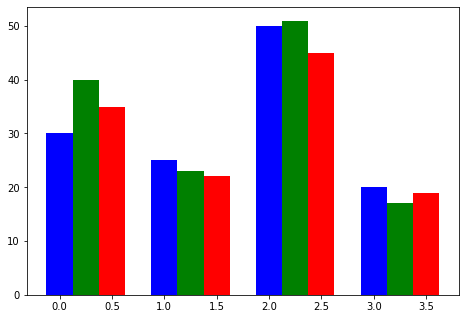

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
data = [[30, 25, 50, 20],
[40, 23, 51, 17],
[35, 22, 45, 19]]
X = np.arange(4)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)